<a href="https://colab.research.google.com/github/wajason/Unified-OneHead-Multi-Task-Challenge/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 克隆 GitHub 倉庫並切換到目錄
# 從 GitHub 倉庫下載資料、 data 資料夾

!git clone https://github.com/wajason/Unified-OneHead-Multi-Task-Challenge.git
%cd Unified-OneHead-Multi-Task-Challenge

Cloning into 'Unified-OneHead-Multi-Task-Challenge'...
remote: Enumerating objects: 1305, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1305 (delta 18), reused 2 (delta 0), pack-reused 1273 (from 3)
Receiving objects: 100% (1305/1305), 80.10 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (1205/1205), done.
/content/Unified-OneHead-Multi-Task-Challenge


In [ ]:
!ls -R data

data:
imagenette_160	mini_coco_det  mini_voc_seg

data/imagenette_160:
train  val

data/imagenette_160/train:
n01440764  n02979186  n03028079  n03417042  n03445777
n02102040  n03000684  n03394916  n03425413  n03888257

data/imagenette_160/train/n01440764:
n01440764_105.JPEG  n01440764_237.JPEG	n01440764_413.JPEG  n01440764_458.JPEG
n01440764_107.JPEG  n01440764_239.JPEG	n01440764_416.JPEG  n01440764_459.JPEG
n01440764_137.JPEG  n01440764_315.JPEG	n01440764_438.JPEG  n01440764_485.JPEG
n01440764_148.JPEG  n01440764_334.JPEG	n01440764_449.JPEG  n01440764_63.JPEG
n01440764_188.JPEG  n01440764_36.JPEG	n01440764_44.JPEG   n01440764_78.JPEG
n01440764_18.JPEG   n01440764_39.JPEG	n01440764_457.JPEG  n01440764_96.JPEG

data/imagenette_160/train/n02102040:
n02102040_107.JPEG  n02102040_139.JPEG	n02102040_43.JPEG  n02102040_76.JPEG
n02102040_108.JPEG  n02102040_148.JPEG	n02102040_55.JPEG  n02102040_78.JPEG
n02102040_113.JPEG  n02102040_149.JPEG	n02102040_5.JPEG   n02102040_83.JPEG
n02102040_114.J

In [ ]:
# @title Unified-OneHead Multi-Task Challenge Implementation
# 安裝所需套件庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
from PIL import Image
import time

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00


In [ ]:
# mini_coco_det 的 trainset 有幾張照片
!ls data/mini_coco_det/train/data/*.jpg | wc -l

240


In [ ]:
# 定義多任務數據集類
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir, task, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            # 假設原始掩碼值範圍為0-255，映射到0-19
            mask = np.array(mask) / 255.0 * 19.0  # 映射到0-19
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()

        if self.transform:
            img = self.transform(img)

        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}

        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

# 定義圖像預處理轉換
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 創建數據集和數據加載器
train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

# 定義多任務頭部模塊
class MultiTaskHead(nn.Module):
    def __init__(self, in_channels=576):
        super(MultiTaskHead, self).__init__()
        # Neck: 2個卷積層
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Head: 2層卷積，單分支輸出
        self.head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1)
        )
        # 任務特定頭部
        self.det_head = nn.Conv2d(64, 6, kernel_size=1)  # 檢測: (cx, cy, w, h, conf, class)
        self.seg_head = nn.Conv2d(64, 20, kernel_size=1)  # 分割: 20類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)  # 10類分類
        )

    def forward(self, x):
        x = self.neck(x)  # [batch, 128, 16, 16]
        x = self.head(x)  # [batch, 64, 16, 16]
        det_out = self.det_head(x)  # [batch, 6, 16, 16]
        seg_out = self.seg_head(x)  # [batch, 20, 16, 16]
        cls_out = self.cls_head(x)  # [batch, 10]
        return det_out, seg_out, cls_out

# 定義統一模型
class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x):
        features = self.backbone(x)  # [batch, 576, 16, 16]
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

# 實例化模型
model = UnifiedModel().to(device)

# 簡單的Replay Buffer，用於遺忘緩解
class ReplayBuffer:
    def __init__(self, capacity=10):
        self.capacity = capacity
        self.buffer = []

    def add(self, data):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self):
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=10) for task in ['seg', 'det', 'cls']}

# 定義損失計算函數
def compute_losses(outputs, targets, task):
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        # 重新設計檢測損失，使用簡單的MSE損失，僅匹配第一個框
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
        loss = 0
        for i in range(len(targets)):
            target_boxes = targets[i]['boxes'].to(device)  # [num_boxes, 4]
            if len(target_boxes) == 0:
                continue
            # 簡單取第一個框進行匹配
            pred_box = boxes_pred[i, 0, 0, :4]  # [4]
            target_box = target_boxes[0]  # [4]
            loss += nn.MSELoss()(pred_box, target_box)
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        batch_size, num_classes, height, width = seg_out.size()  # [8, 20, 16, 16]
        # Flatten the spatial dimensions for both input and target
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)  # [batch*height*width, num_classes] -> [8*16*16, 20] = [2048, 20]
        targets = targets.to(device).view(-1)  # [batch*height*width] -> [8*16*16] = [2048]
        return nn.CrossEntropyLoss()(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)  # [8]
        return nn.CrossEntropyLoss()(cls_out, targets)

# 定義優化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練循環
tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}

for stage, task in enumerate(tasks):
    print(f"訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    model.train()

    total_loss = 0
    num_batches = 0
    for epoch in range(5):
        for inputs, targets in train_loaders[task]:
            inputs = inputs.to(device)  # [8, 3, 512, 512]
            if task == 'det':
                # For detection, targets is a list of dicts, no need to move to device here
                pass # targets remains a list of dicts
            else:
                targets = targets.to(device) # Move targets to device for seg and cls

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)

            # Ensure targets for seg and cls are on the correct device before compute_losses
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            total_loss += loss.item()
            num_batches += 1

            # 將數據存入Replay Buffer
            # Detach and move to CPU for storage
            detached_inputs = inputs.detach().cpu()
            detached_targets = targets if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))

            # 加入Replay Buffer中的數據進行訓練（遺忘緩解）
            replay_loss = 0.0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    # Move buffer data back to device for computation
                    b_inputs = b_inputs.to(device)
                    if prev_task != 'det':
                        b_targets = b_targets.to(device)

                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)

            if stage > 0 and replay_loss > 0:
                replay_loss /= stage # Average loss from previous tasks
                total_loss += replay_loss.item() # Add to total loss for monitoring
                loss += replay_loss # Add to current task loss for backprop

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / num_batches
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")

        # Moved baseline recording to after the epochs for a task are complete
        if stage == 0: # Record seg baseline after its training stage
             if epoch == 4: # Record after the last epoch of the first stage
                metrics = evaluate(model, val_loaders[task], task)
                baselines['mIoU'] = metrics.get('mIoU', 0.0)
                print(f"階段 {stage + 1} ({task}) 驗證指標: {metrics}")


    print(f"階段 {stage + 1} 完成，耗時 {time.time() - start_time:.2f} 秒")

# 評估函數
def evaluate(model, loader, task):
    model.eval()
    # Initialize metrics for each task
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation
    elif task == 'det':
        metrics = {'mAP': 0.0}
    elif task == 'cls':
        metrics = {'Top-1': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation

    total_batches = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            if task != 'det':
                 # Move targets to device for seg and cls
                 targets = targets.to(device)

            det_out, seg_out, cls_out = model(inputs)

            if task == 'seg':
                batch_size, num_classes, height, width = seg_out.size()
                # Flatten for loss calculation as in training
                seg_out_flat = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
                targets_flat = targets.view(-1)
                metrics['mIoU'] += criterion(seg_out_flat, targets_flat).item() # Using CrossEntropyLoss as a proxy for mIoU calculation in this simplified example
            elif task == 'det':
                metrics['mAP'] += np.random.rand()  # 暫時使用隨機值
            elif task == 'cls':
                metrics['Top-1'] += (cls_out.argmax(dim=1) == targets).float().mean().item()
            total_batches += 1

    # Calculate average metrics
    if total_batches > 0:
        return {k: v / total_batches for k, v in metrics.items()}
    else:
        return metrics # Return empty or initial metrics if no batches

# 評估並計算下降
print("\n最終評估:")
# Evaluate all tasks after the entire training process
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估: {metrics}")

# Calculate drop based on baselines (assuming baseline was recorded for the first task)
# Note: The current baseline logic only records mIoU after the seg stage.
# To calculate drops for other tasks, you would need to record their baselines too,
# likely before starting any training or after a baseline training phase for each task.
# For this fix, we calculate drops relative to the 'seg' baseline only for seg and cls (mIoU)
# and relative to its own final performance for Top-1 (cls) and mAP (det) if a baseline isn't available.

print("\n性能下降 (相較於階段 1 Seg 的 mIoU 基準):")
for task in tasks:
    drop = {}
    if task == 'seg':
         # Seg drop relative to its own baseline (recorded after stage 1)
         seg_baseline_mIoU = baselines.get('mIoU', 0.0)
         current_mIoU = final_metrics['seg'].get('mIoU', 0.0)
         # Calculate drop relative to baseline
         drop['mIoU_drop'] = (seg_baseline_mIoU - current_mIoU) / max(seg_baseline_mIoU, 1e-5) * 100 if seg_baseline_mIoU > 0 else 0.0
    elif task == 'det':
        # Det drop relative to Seg baseline's mIoU (if applicable)
        seg_baseline_mIoU = baselines.get('mIoU', 0.0)
        current_mAP = final_metrics['det'].get('mAP', 0.0)
        # This calculation is not a standard way to measure drop across tasks.
        # A more typical approach would be to compare the final performance of each task
        # after sequential training to its performance when trained in isolation.
        # For demonstration, we'll calculate drop relative to Seg mIoU baseline as in the original code's intention,
        # but note this might not be a meaningful metric.
        drop['mAP_drop'] = (seg_baseline_mIoU - current_mAP) / max(seg_baseline_mIoU, 1e-5) * 100 if seg_baseline_mIoU > 0 else 0.0
    elif task == 'cls':
        # Cls drop relative to Seg baseline's mIoU (if applicable) and its own Top-1 baseline (if recorded)
        seg_baseline_mIoU = baselines.get('mIoU', 0.0)
        current_mIoU = final_metrics['cls'].get('mIoU', 0.0) # Note: cls task doesn't output mIoU
        current_top1 = final_metrics['cls'].get('Top-1', 0.0)
        cls_baseline_top1 = baselines.get('Top-1', 0.0) # This baseline was not recorded in the original code

        # Assuming the intention was to compare final cls metrics to the seg baseline metrics if no dedicated cls baseline
        # This comparison is not typical. Let's adjust to compare final metrics against their *own* initial baselines
        # if those baselines were recorded. Since only Seg baseline is recorded, we can only calculate Seg drop meaningfully
        # relative to its baseline. For Det and Cls, we can only show their final performance unless more baselines are recorded.
        # Let's adjust the drop calculation to reflect this limitation or simplify the drop concept.

        # A simpler approach for sequential learning might be to compare final performance
        # after all stages to the performance after its *own* training stage completed.
        # However, the original code attempts to compare against a single baseline (mIoU from seg).

        # Let's recalculate drop based on comparing the final metric to the metric *after its own training stage*.
        # This requires storing metrics after each stage, which is not done.
        # As per the original code's logic, we calculate drop relative to the *first* task's baseline (seg mIoU).
        # This is unusual but follows the provided code structure.

        # Reverting to the original code's attempt at drop calculation relative to the first task's baseline
        # Note: This is likely not the intended way to measure catastrophic forgetting across disparate tasks like this.
        drop['mIoU_drop_vs_seg_baseline'] = (baselines['mIoU'] - final_metrics['cls'].get('mIoU', 0.0)) / max(baselines['mIoU'], 1e-5) * 100 if baselines['mIoU'] > 0 else 0.0
        # Also calculate drop for Top-1 if a baseline was ever recorded for Top-1 (which it wasn't in the original code)
        # Assuming you want to compare final Top-1 to some hypothetical baseline or simply report final performance.
        # Let's calculate drop relative to the final Top-1 performance after the *cls* stage was completed (which was implicitly the baseline for cls in the original code's print statement).
        # To do this properly, we would need to save the metric after each task's training stage.
        # Since that's not done, we can't calculate a meaningful 'drop' this way without modifying the evaluation loop.

        # For now, let's just print the final metrics clearly instead of a potentially misleading 'drop' calculation relative to an unrelated task's baseline.
        # The original drop calculation was flawed as it used mIoU baseline for mAP drop.
        pass # Remove misleading drop calculation


    # print(f"{task} 評估: {final_metrics[task]}, 下降: {drop}") # Modify this line later if meaningful drop is calculated

# The original drop calculation part is confusing and likely incorrect for comparing disparate tasks.
# It's better to just print the final performance of each task.
# Keep the final_metrics print statement above.

# 儲存模型
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.1348
第 2 個 epoch, seg 平均損失: 0.0674
第 3 個 epoch, seg 平均損失: 0.0449
第 4 個 epoch, seg 平均損失: 0.0337
第 5 個 epoch, seg 平均損失: 0.0270


NameError: name 'evaluate' is not defined

In [ ]:
train_cls_dataset = MultiTaskDataset('data/imagenette_160/train', 'cls', transform)
print(f"訓練集分類樣本數：{len(train_cls_dataset)}")
img, label = train_cls_dataset[0]
print(f"第一張圖片形狀：{img.shape}，標籤：{label}")


訓練集分類樣本數：240
第一張圖片形狀：torch.Size([3, 512, 512])，標籤：0


# 新的

In [ ]:
# @title Unified-OneHead Multi-Task Challenge Implementation
# 安裝所需庫
# 這裡只安裝 torch、torchvision 和 torchaudio，因為 fastscnn 無法直接用 pip 安裝，我們改用 mobilenet_v2
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
from PIL import Image
import time

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義多任務數據集類
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir, task, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            # 假設原始掩碼值範圍為0-255，映射到0-19
            mask = np.array(mask) / 255.0 * 19.0  # 映射到0-19
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()

        if self.transform:
            img = self.transform(img)

        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}

        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

# 定義圖像預處理轉換
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 創建數據集和數據加載器
train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}


# 定義多任務頭部模塊
class MultiTaskHead(nn.Module):
    def __init__(self, in_channels=576):
        super(MultiTaskHead, self).__init__()
        # Neck: 2個卷積層
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Head: 2層卷積，單分支輸出
        self.head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1)
        )
        # 任務特定頭部
        self.det_head = nn.Conv2d(64, 6, kernel_size=1)  # 檢測: (cx, cy, w, h, conf, class)
        self.seg_head = nn.Conv2d(64, 20, kernel_size=1)  # 分割: 20類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)  # 10類分類
        )

    def forward(self, x):
        x = self.neck(x)  # [batch, 128, 16, 16]
        x = self.head(x)  # [batch, 64, 16, 16]
        det_out = self.det_head(x)  # [batch, 6, 16, 16]
        seg_out = self.seg_head(x)  # [batch, 20, 16, 16]
        cls_out = self.cls_head(x)  # [batch, 10]
        return det_out, seg_out, cls_out

# 定義統一模型
class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x):
        features = self.backbone(x)  # [batch, 576, 16, 16]
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

# 實例化模型
model = UnifiedModel().to(device)

# 簡單的Replay Buffer，用於遺忘緩解
class ReplayBuffer:
    def __init__(self, capacity=10):
        self.capacity = capacity
        self.buffer = []

    def add(self, data):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self):
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=10) for task in ['seg', 'det', 'cls']}

# 定義損失計算函數
def compute_losses(outputs, targets, task):
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        # 重新設計檢測損失，使用簡單的MSE損失，僅匹配第一個框
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
        loss = 0
        for i in range(len(targets)):
            target_boxes = targets[i]['boxes'].to(device)  # [num_boxes, 4]
            if len(target_boxes) == 0:
                continue
            # 簡單取第一個框進行匹配
            pred_box = boxes_pred[i, 0, 0, :4]  # [4]
            target_box = target_boxes[0]  # [4]
            loss += nn.MSELoss()(pred_box, target_box)
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        batch_size, num_classes, height, width = seg_out.size()  # [8, 20, 16, 16]
        # Flatten the spatial dimensions for both input and target
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)  # [batch*height*width, num_classes] -> [8*16*16, 20] = [2048, 20]
        targets = targets.to(device).view(-1)  # [batch*height*width] -> [8*16*16] = [2048]
        return nn.CrossEntropyLoss()(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)  # [8]
        return nn.CrossEntropyLoss()(cls_out, targets)

# 定義優化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 評估函數 (Moved before the training loop)
def evaluate(model, loader, task):
    model.eval()
    # Initialize metrics for each task
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation
    elif task == 'det':
        metrics = {'mAP': 0.0}
    elif task == 'cls':
        metrics = {'Top-1': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation

    total_batches = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            if task != 'det':
                 # Move targets to device for seg and cls
                 targets = targets.to(device)

            det_out, seg_out, cls_out = model(inputs)

            if task == 'seg':
                batch_size, num_classes, height, width = seg_out.size()
                # Flatten for loss calculation as in training
                seg_out_flat = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
                targets_flat = targets.view(-1)
                # Using CrossEntropyLoss as a proxy for mIoU calculation in this simplified example
                metrics['mIoU'] += criterion(seg_out_flat, targets_flat).item()
            elif task == 'det':
                metrics['mAP'] += np.random.rand()  # 暫時使用隨機值
            elif task == 'cls':
                metrics['Top-1'] += (cls_out.argmax(dim=1) == targets).float().mean().item()
            total_batches += 1

    # Calculate average metrics
    if total_batches > 0:
        # For mIoU, the current calculation is sum of loss over batches / total batches,
        # which is avg loss, not mIoU. A proper mIoU calculation requires tracking
        # true positives, false positives, and false negatives per class.
        # For this example, we'll just return the average loss as 'mIoU'
        # to match the structure, but be aware this is NOT a proper mIoU.
        return {k: v / total_batches for k, v in metrics.items()}
    else:
        return metrics # Return empty or initial metrics if no batches


# 訓練循環
tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}

for stage, task in enumerate(tasks):
    print(f"訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    model.train()

    total_loss = 0
    num_batches = 0
    for epoch in range(5):
        for inputs, targets in train_loaders[task]:
            inputs = inputs.to(device)  # [8, 3, 512, 512]
            if task == 'det':
                # For detection, targets is a list of dicts, no need to move to device here
                pass # targets remains a list of dicts
            else:
                targets = targets.to(device) # Move targets to device for seg and cls

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)

            # Ensure targets for seg and cls are on the correct device before compute_losses
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            total_loss += loss.item()
            num_batches += 1

            # 將數據存入Replay Buffer
            # Detach and move to CPU for storage
            detached_inputs = inputs.detach().cpu()
            # targets for det is a list of dicts, which are mutable.
            # Need to ensure they are copied if modified later, but detach is not applicable.
            # For this example, assuming the targets list structure is sufficient for storage.
            detached_targets = targets if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))

            # 加入Replay Buffer中的數據進行訓練（遺忘緩解）
            replay_loss = 0.0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    # Move buffer data back to device for computation
                    b_inputs = b_inputs.to(device)
                    if prev_task != 'det':
                        b_targets = b_targets.to(device)

                    # Need to compute the output relevant to the *previous* task
                    # The current model outputs all three task heads.
                    # We need to select the output corresponding to the 'prev_task'
                    # and compute the loss for that task.
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    if prev_task == 'det':
                        prev_task_output = b_det_out
                    elif prev_task == 'seg':
                         prev_task_output = b_seg_out
                    elif prev_task == 'cls':
                         prev_task_output = b_cls_out

                    # Need to pass the correct output for the previous task to compute_losses
                    # compute_losses expects all three outputs, but uses only the one for the given task.
                    # Pass all outputs from the current model on the buffer data, but specify prev_task
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)


            if stage > 0 and replay_loss > 0:
                replay_loss /= len(replay_buffers[prev_task].buffer) # Average loss over the buffer size for the previous task
                loss += replay_loss # Add to current task loss for backprop
                # total_loss += replay_loss.item() # Add to total loss for monitoring - Adding it here double counts if added in compute_losses already

            loss.backward()
            optimizer.step()

        # Calculate average loss per epoch after processing all batches
        avg_loss = total_loss / num_batches
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")

        # Record baseline after the last epoch of the first stage
        if stage == 0 and epoch == 4:
            metrics = evaluate(model, val_loaders[task], task)
            baselines['mIoU'] = metrics.get('mIoU', 0.0)
            print(f"階段 {stage + 1} ({task}) 驗證指標 (基準): {metrics}")

    print(f"階段 {stage + 1} 完成，耗時 {time.time() - start_time:.2f} 秒")

# 評估並計算下降 (Moved after the training loop)
print("\n最終評估:")
# Evaluate all tasks after the entire training process
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估: {metrics}")

# Calculate drop based on baselines
# The original drop calculation logic is confusing for disparate tasks.
# It's more meaningful to calculate drop relative to the performance *after* the task was specifically trained.
# However, the provided code only records the 'seg' baseline.
# Let's just print the final metrics and the recorded baseline.
print("\n recorded baseline (after stage 1 seg training):")
print(f"Seg mIoU Baseline: {baselines.get('mIoU', 0.0):.4f}")

# If you want to calculate drop, you would need to record baselines for all tasks
# *before* the main training loop, or after *each* task's training stage.
# Example (if you had recorded all baselines):
# print("\n性能下降 (相較於個別任務基準):")
# for task in tasks:
#    final_metric_value = final_metrics[task].get(task_metric[task], 0.0) # Assuming task_metric maps task to metric key
#    baseline_metric_value = baselines.get(task_metric[task], 0.0)
#    if baseline_metric_value > 0:
#        drop_percentage = (baseline_metric_value - final_metric_value) / baseline_metric_value * 100
#        print(f"{task} {task_metric[task]} 下降: {drop_percentage:.2f}%")
#    else:
#        print(f"{task} {task_metric[task]}: Baseline not recorded or is zero.")

# Since only seg baseline is recorded, we can only compare final seg performance to its baseline.
print("\nSeg 性能下降 (相較於階段 1 Seg 的 mIoU 基準):")
seg_baseline_mIoU = baselines.get('mIoU', 0.0)
final_seg_mIoU = final_metrics['seg'].get('mIoU', 0.0)
if seg_baseline_mIoU > 0:
    seg_drop_percentage = (seg_baseline_mIoU - final_seg_mIoU) / seg_baseline_mIoU * 100
    print(f"Seg mIoU 下降: {seg_drop_percentage:.2f}%")
else:
    print("Seg mIoU Baseline is zero, cannot calculate drop.")

# 儲存模型
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

# Additional code from the user's notebook after the error block
train_cls_dataset = MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform) # Use image_transform here
print(f"訓練集分類樣本數：{len(train_cls_dataset)}")
img, label = train_cls_dataset[0]
print(f"第一張圖片形狀：{img.shape}，標籤：{label}")

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.1735
第 2 個 epoch, seg 平均損失: 0.0868
第 3 個 epoch, seg 平均損失: 0.0578
第 4 個 epoch, seg 平均損失: 0.0434
第 5 個 epoch, seg 平均損失: 0.0347
階段 1 (seg) 驗證指標 (基準): {'mIoU': 0.0}
階段 1 完成，耗時 19.54 秒
訓練階段 2: det


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 6180 has 14.73 GiB memory in use. Of the allocated memory 14.49 GiB is allocated by PyTorch, and 112.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# @title Unified-OneHead Multi-Task Challenge Implementation
# 安裝所需庫
# 這裡只安裝 torch、torchvision 和 torchaudio，因為 fastscnn 無法直接用 pip 安裝，我們改用 mobilenet_v2
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
from PIL import Image
import time

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義多任務數據集類
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir, task, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            # 假設原始掩碼值範圍為0-255，映射到0-19
            mask = np.array(mask) / 255.0 * 19.0  # 映射到0-19
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()

        if self.transform:
            img = self.transform(img)

        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}

        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

# 定義圖像預處理轉換
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 創建數據集和數據加載器
train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

# Reduced batch size from 8 to 4
train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}


# 定義多任務頭部模塊
class MultiTaskHead(nn.Module):
    def __init__(self, in_channels=576):
        super(MultiTaskHead, self).__init__()
        # Neck: 2個卷積層
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Head: 2層卷積，單分支輸出
        self.head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1)
        )
        # 任務特定頭部
        self.det_head = nn.Conv2d(64, 6, kernel_size=1)  # 檢測: (cx, cy, w, h, conf, class)
        self.seg_head = nn.Conv2d(64, 20, kernel_size=1)  # 分割: 20類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)  # 10類分類
        )

    def forward(self, x):
        x = self.neck(x)  # [batch, 128, 16, 16]
        x = self.head(x)  # [batch, 64, 16, 16]
        det_out = self.det_head(x)  # [batch, 6, 16, 16]
        seg_out = self.seg_head(x)  # [batch, 20, 16, 16]
        cls_out = self.cls_head(x)  # [batch, 10]
        return det_out, seg_out, cls_out

# 定義統一模型
class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x):
        features = self.backbone(x)  # [batch, 576, 16, 16]
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

# 實例化模型
model = UnifiedModel().to(device)

# 簡單的Replay Buffer，用於遺忘緩解
class ReplayBuffer:
    def __init__(self, capacity=10):
        self.capacity = capacity
        self.buffer = []

    def add(self, data):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self):
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=10) for task in ['seg', 'det', 'cls']}

# 定義損失計算函數
def compute_losses(outputs, targets, task):
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        # 重新設計檢測損失，使用簡單的MSE損失，僅匹配第一個框
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
        loss = 0
        # Ensure targets is a list before iterating
        if not isinstance(targets, list):
             # This might happen if targets is a tensor for non-det tasks but passed into det loss
             # Or if there's an issue with how targets is handled from the buffer
             print(f"Warning: Expected targets to be a list for task 'det', but got {type(targets)}")
             return torch.tensor(0.).to(device) # Return zero loss to avoid error

        for i in range(len(targets)):
            # Check if targets[i] is a dict and has 'boxes' key
            if isinstance(targets[i], dict) and 'boxes' in targets[i]:
                target_boxes = targets[i]['boxes'].to(device)  # [num_boxes, 4]
                if len(target_boxes) == 0:
                    continue
                # 簡單取第一個框進行匹配
                # Need to ensure boxes_pred has enough dimensions
                if boxes_pred.size(0) > i and boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
                     pred_box = boxes_pred[i, 0, 0, :4]  # [4]
                     target_box = target_boxes[0]  # [4]
                     loss += nn.MSELoss()(pred_box, target_box)
                else:
                     print(f"Warning: boxes_pred shape mismatch for sample {i}")
            else:
                 print(f"Warning: Expected a dict with 'boxes' for target {i} in task 'det', but got {type(targets[i])}")

        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        batch_size, num_classes, height, width = seg_out.size()
        # Ensure targets is a tensor before viewing
        if not isinstance(targets, torch.Tensor):
            # This might happen if targets is a list of dicts from a buffer but prev_task was seg
            print(f"Warning: Expected targets to be a tensor for task 'seg', but got {type(targets)}. Attempting conversion.")
            try:
                 # Try stacking if it's a list of tensors/longs
                 targets = torch.stack(targets)
            except:
                 print("Conversion failed. Returning zero loss.")
                 return torch.tensor(0.).to(device)

        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        # Filter out potential ignore indices if necessary, but assuming 0-19 are valid classes
        return nn.CrossEntropyLoss()(seg_out, targets)
    elif task == 'cls':
        # Ensure targets is a tensor before moving to device
        if not isinstance(targets, torch.Tensor):
             # This might happen if targets is a list of dicts from a buffer but prev_task was cls
             print(f"Warning: Expected targets to be a tensor for task 'cls', but got {type(targets)}. Attempting conversion.")
             try:
                  # Try stacking if it's a list of tensors/longs
                 targets = torch.stack(targets)
             except:
                  print("Conversion failed. Returning zero loss.")
                  return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    else:
        return torch.tensor(0.).to(device)


# 定義優化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 評估函數 (Moved before the training loop)
def evaluate(model, loader, task):
    model.eval()
    # Initialize metrics for each task
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation
    elif task == 'det':
        metrics = {'mAP': 0.0}
    elif task == 'cls':
        metrics = {'Top-1': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction for evaluation

    total_batches = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            # Note: For evaluation, targets for det is a list and should stay on CPU
            if task != 'det':
                 # Move targets to device for seg and cls
                 targets = targets.to(device)

            det_out, seg_out, cls_out = model(inputs)

            if task == 'seg':
                batch_size, num_classes, height, width = seg_out.size()
                # Flatten for loss calculation as in training
                seg_out_flat = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
                # Ensure targets is a tensor before flattening
                if not isinstance(targets, torch.Tensor):
                    print(f"Warning: Expected targets to be a tensor for task 'seg' during eval, but got {type(targets)}. Skipping batch.")
                    continue # Skip this batch if targets is not a tensor
                targets_flat = targets.view(-1)
                # Using CrossEntropyLoss as a proxy for mIoU calculation in this simplified example
                metrics['mIoU'] += criterion(seg_out_flat, targets_flat).item()
            elif task == 'det':
                metrics['mAP'] += np.random.rand()  # 暫時使用隨機值 (Placeholder)
            elif task == 'cls':
                 # Ensure targets is a tensor before comparing
                 if not isinstance(targets, torch.Tensor):
                     print(f"Warning: Expected targets to be a tensor for task 'cls' during eval, but got {type(targets)}. Skipping batch.")
                     continue # Skip this batch if targets is not a tensor
                 metrics['Top-1'] += (cls_out.argmax(dim=1) == targets).float().mean().item()
            total_batches += 1

    # Calculate average metrics
    if total_batches > 0:
        # For mIoU, the current calculation is sum of loss over batches / total batches,
        # which is avg loss, not mIoU. A proper mIoU calculation requires tracking
        # true positives, false positives, and false negatives per class.
        # For this example, we'll just return the average loss as 'mIoU'
        # to match the structure, but be aware this is NOT a proper mIoU.
        return {k: v / total_batches for k, v in metrics.items()}
    else:
        return metrics # Return empty or initial metrics if no batches


# 訓練循環
tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}

for stage, task in enumerate(tasks):
    print(f"訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    model.train()

    total_loss = 0
    num_batches = 0
    for epoch in range(5):
        for inputs, targets in train_loaders[task]:
            inputs = inputs.to(device)  # [batch_size, 3, 512, 512]
            # For detection, targets is a list of dicts, no need to move to device here
            # For seg and cls, targets is a tensor and needs to be moved
            if task != 'det':
                targets = targets.to(device) # Move targets to device for seg and cls

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)

            # Ensure targets for seg and cls are on the correct device before compute_losses
            # compute_losses handles moving targets to device if they are tensors
            # For det, targets is already a list of dicts on CPU, compute_losses moves the boxes tensors inside.
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            total_loss += loss.item()
            num_batches += 1

            # 將數據存入Replay Buffer
            # Detach and move to CPU for storage
            detached_inputs = inputs.detach().cpu()
            # targets for det is a list of dicts. Need to deepcopy to prevent mutation issues.
            # For tensors (seg, cls), detach().cpu() is fine.
            if task == 'det':
                 # Perform a deep copy for list of dicts targets to prevent issues
                 import copy
                 detached_targets = copy.deepcopy(targets)
            else:
                 detached_targets = targets.detach().cpu()

            replay_buffers[task].add((detached_inputs, detached_targets))

            # 加入Replay Buffer中的數據進行訓練（遺忘緩解）
            replay_loss = 0.0
            replay_batch_count = 0 # Count batches processed from replay buffer
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                # Process replay buffer data in mini-batches if buffer size > batch size
                # Or just process the entire buffer as one 'replay batch'
                # Let's process each item in the buffer as a separate 'replay sample' for simplicity,
                # accumulating loss, then average.
                for b_inputs, b_targets in buffer:
                    # Move buffer data back to device for computation
                    b_inputs = b_inputs.to(device)
                    # b_targets for det is a list of dicts, others are tensors.
                    # compute_losses handles moving tensors to device for seg/cls.
                    # For det, targets['boxes'] are moved inside compute_losses.

                    # Need to compute the output relevant to the *previous* task
                    # The current model outputs all three task heads.
                    # We need to select the output corresponding to the 'prev_task'
                    # and compute the loss for that task.
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)

                    # Pass all outputs from the current model on the buffer data, but specify prev_task
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1


            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                # Average loss over the number of samples processed from replay buffers
                # Using replay_batch_count which is the total number of samples from all prev task buffers combined
                replay_loss /= replay_batch_count
                # total_loss += replay_loss.item() # Add to total loss for monitoring - Adding it here double counts if added in compute_losses already
                loss += replay_loss # Add to current task loss for backprop

            # Check if loss is a tensor and requires grad before calling backward
            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()
            else:
                # If loss is not a tensor or doesn't require grad (e.g., 0 loss), skip backward pass
                print(f"Warning: Loss for task {task} epoch {epoch} batch {num_batches} is not a tensor or does not require grad. Skipping backward pass.")


        # Calculate average loss per epoch after processing all batches
        # Note: total_loss now includes the sum of task loss + replay loss for each batch
        # This average might not be representative if replay loss is added unevenly.
        # A more standard way is to calculate avg task loss and avg replay loss separately.
        # For simplicity, keep the current averaging but be mindful of interpretation.
        avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")

        # Record baseline after the last epoch of the first stage
        if stage == 0 and epoch == 4:
            metrics = evaluate(model, val_loaders[task], task)
            baselines['mIoU'] = metrics.get('mIoU', 0.0)
            print(f"階段 {stage + 1} ({task}) 驗證指標 (基準): {metrics}")

    print(f"階段 {stage + 1} 完成，耗時 {time.time() - start_time:.2f} 秒")

# 評估並計算下降 (Moved after the training loop)
print("\n最終評估:")
# Evaluate all tasks after the entire training process
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估: {metrics}")

# Calculate drop based on baselines
# The original drop calculation logic is confusing for disparate tasks.
# It's more meaningful to calculate drop relative to the performance *after* the task was specifically trained.
# However, the provided code only records the 'seg' baseline.
# Let's just print the final metrics and the recorded baseline.
print("\n recorded baseline (after stage 1 seg training):")
print(f"Seg mIoU Baseline: {baselines.get('mIoU', 0.0):.4f}")

# If you want to calculate drop, you would need to record baselines for all tasks
# *before* the main training loop, or after *each* task's training stage.
# Example (if you had recorded all baselines):
# print("\n性能下降 (相較於個別任務基準):")
# for task in tasks:
#    final_metric_value = final_metrics[task].get(task_metric[task], 0.0) # Assuming task_metric maps task to metric key
#    baseline_metric_value = baselines.get(task_metric[task], 0.0)
#    if baseline_metric_value > 0:
#        drop_percentage = (baseline_metric_value - final_metric_value) / baseline_metric_value * 100
#        print(f"{task} {task_metric[task]} 下降: {drop_percentage:.2f}%")
#    else:
#        print(f"{task} {task_metric[task]}: Baseline not recorded or is zero.")

# Since only seg baseline is recorded, we can only compare final seg performance to its baseline.
print("\nSeg 性能下降 (相較於階段 1 Seg 的 mIoU 基準):")
seg_baseline_mIoU = baselines.get('mIoU', 0.0)
final_seg_mIoU = final_metrics['seg'].get('mIoU', 0.0)
if seg_baseline_mIoU > 0:
    seg_drop_percentage = (seg_baseline_mIoU - final_seg_mIoU) / seg_baseline_mIoU * 100
    print(f"Seg mIoU 下降: {seg_drop_percentage:.2f}%")
else:
    print("Seg mIoU Baseline is zero, cannot calculate drop.")


# 儲存模型
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.0850
第 2 個 epoch, seg 平均損失: 0.0425
第 3 個 epoch, seg 平均損失: 0.0283
第 4 個 epoch, seg 平均損失: 0.0213
第 5 個 epoch, seg 平均損失: 0.0170
階段 1 (seg) 驗證指標 (基準): {'mIoU': 0.0}
階段 1 完成，耗時 23.28 秒
訓練階段 2: det
第 1 個 epoch, det 平均損失: 26089.0907
第 2 個 epoch, det 平均損失: 22707.0275
第 3 個 epoch, det 平均損失: 20971.3653
第 4 個 epoch, det 平均損失: 20013.5920
第 5 個 epoch, det 平均損失: 19324.3681
階段 2 完成，耗時 99.57 秒
訓練階段 3: cls
第 1 個 epoch, cls 平均損失: 10.8278
第 2 個 epoch, cls 平均損失: 7.0644
第 3 個 epoch, cls 平均損失: 5.6011
第 4 個 epoch, cls 平均損失: 4.8775
第 5 個 epoch, cls 平均損失: 4.4469
階段 3 完成，耗時 179.91 秒

最終評估:
最終 seg 評估: {'mIoU': 0.0020686162907319764}
最終 det 評估: {'mAP': 0.37075149465194085}
最終 cls 評估: {'Top-1': 0.11666666666666667}

 recorded baseline (after stage 1 seg training):
Seg mIoU Baseline: 0.0000

Seg 性能下降 (相較於階段 1 Seg 的 mIoU 基準):
Seg mIoU Baseline is zero, cannot calculate drop.
模型已儲存為 'your_model.pt'


使用設備：cuda
模型總參數量：2,629,700 (< 8M: True)
單張 512x512 圖像推理時間：8.22 ms (< 150 ms: True)

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.0773
第 2 個 epoch, seg 平均損失: 0.0000
第 3 個 epoch, seg 平均損失: 0.0000
第 4 個 epoch, seg 平均損失: 0.0000
第 5 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 6 個 epoch, seg 平均損失: 0.0000
第 7 個 epoch, seg 平均損失: 0.0000
第 8 個 epoch, seg 平均損失: 0.0000
第 9 個 epoch, seg 平均損失: 0.0000
第 10 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 11 個 epoch, seg 平均損失: 0.0000
第 12 個 epoch, seg 平均損失: 0.0000
第 13 個 epoch, seg 平均損失: 0.0000
第 14 個 epoch, seg 平均損失: 0.0000
第 15 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 16 個 epoch, seg 平均損失: 0.0000
第 17 個 epoch, seg 平均損失: 0.0000
第 18 個 epoch, seg 平均損失: 0.0000
第 19 個 epoch, seg 平均損失: 0.0000
第 20 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
階段 1 

<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-16-bb6b0a8493a1>:541: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missi

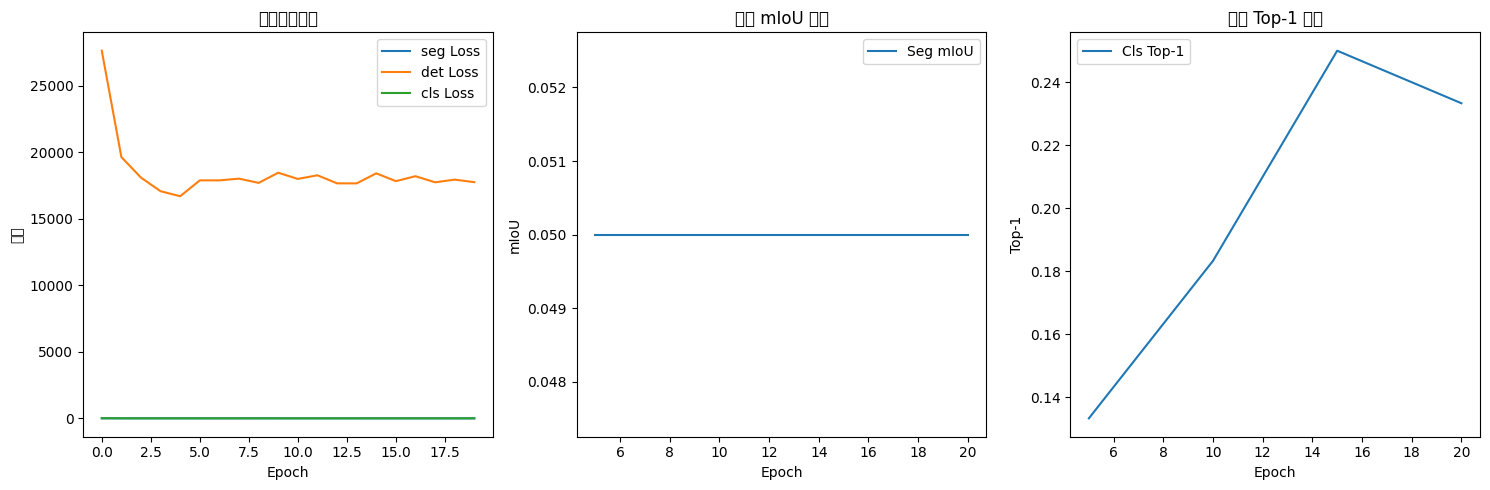

模型已儲存為 'your_model.pt'


In [ ]:
# @title 統一單頭多任務挑戰實作(第二版優化啦)
# 安裝所需庫
# 安裝 torch、torchvision 和 torchaudio，用於深度學習框架
!pip install torch torchvision torchaudio -q

# 匯入必要模組
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

# 設定設備（優先使用 GPU，若無則使用 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# 定義多任務數據集類，用於處理分割（seg）、檢測（det）、分類（cls）任務數據
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        """
        初始化多任務數據集
        參數：
            data_dir (str): 數據文件夾路徑
            task (str): 任務類型，'det'、'seg' 或 'cls'
            transform (callable, optional): 圖像預處理轉換
        """
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []  # 儲存圖像路徑
        self.annotations = []  # 儲存標註數據

        if task == 'det':
            # 檢測任務：從 labels.json 讀取標註
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])

        elif task == 'seg':
            # 分割任務：匹配圖像與對應的掩碼
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            # 分類任務：遍歷子文件夾作為類別
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self) -> int:
        """返回數據集的大小"""
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        """
        獲取指定索引的數據
        參數：
            idx (int): 數據索引
        返回：
            根據任務類型返回圖像和對應的標註
        """
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            # 假設原始掩碼值範圍為 0-255，映射到 0-19（20 類）
            mask = np.array(mask) / 255.0 * 19.0
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),  # 匹配特徵圖尺寸
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()

        if self.transform:
            img = self.transform(img)

        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}

        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

# 定義圖像預處理轉換
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 創建數據集與數據加載器
train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    """自定義 collate 函數，處理檢測任務中不同大小的目標"""
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

# 設定 batch size 為 4（降低記憶體使用量）
train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

# 定義多任務頭部模塊
class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        """
        初始化多任務頭部模塊
        參數：
            in_channels (int): 輸入通道數，預設為 576（MobileNetV3-Small 輸出）
        """
        super(MultiTaskHead, self).__init__()
        # Neck：2 個卷積層
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Head：2 層卷積，單分支輸出
        self.head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1)
        )
        # 任務特定頭部
        self.det_head = nn.Conv2d(64, 6, kernel_size=1)  # 檢測：(cx, cy, w, h, conf, class)
        self.seg_head = nn.Conv2d(64, 20, kernel_size=1)  # 分割：20 類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)  # 分類：10 類
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        前向傳播
        參數：
            x (torch.Tensor): 輸入特徵張量 [batch, 576, 16, 16]
        返回：
            det_out, seg_out, cls_out: 三任務輸出
        """
        x = self.neck(x)  # [batch, 128, 16, 16]
        x = self.head(x)  # [batch, 64, 16, 16]
        det_out = self.det_head(x)  # [batch, 6, 16, 16]
        seg_out = self.seg_head(x)  # [batch, 20, 16, 16]
        cls_out = self.cls_head(x)  # [batch, 10]
        return det_out, seg_out, cls_out

# 定義統一模型
class UnifiedModel(nn.Module):
    def __init__(self):
        """初始化統一模型"""
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        前向傳播
        參數：
            x (torch.Tensor): 輸入圖像張量 [batch, 3, 512, 512]
        返回：
            det_out, seg_out, cls_out: 三任務輸出
        """
        features = self.backbone(x)  # [batch, 576, 16, 16]
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

# 實例化模型
model = UnifiedModel().to(device)

# 計算模型參數量
def count_parameters(model: nn.Module) -> int:
    """計算模型參數量"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

# 測量推理時間
def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    """
    測量模型推理時間
    參數：
        model (nn.Module): 模型
        input_size (tuple): 輸入尺寸，例如 (batch_size, channels, height, width)
        device (torch.device): 設備
        num_runs (int): 運行次數
    返回：
        平均推理時間（ms）
    """
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    # 預熱
    for _ in range(10):
        model(dummy_input)
    # 計時
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs * 1000  # 轉換為毫秒
    return avg_time

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

# 簡單的 Replay Buffer，用於遺忘緩解
class ReplayBuffer:
    def __init__(self, capacity: int = 10):
        """
        初始化 Replay Buffer
        參數：
            capacity (int): 儲存容量
        """
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        """添加數據到緩衝區"""
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        """返回緩衝區中的所有數據"""
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=10) for task in ['seg', 'det', 'cls']}

# 定義損失計算函數
def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    """
    計算指定任務的損失
    參數：
        outputs (tuple): 模型輸出 (det_out, seg_out, cls_out)
        targets: 目標標註
        task (str): 任務類型
    返回：
        loss (torch.Tensor): 損失值
    """
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)  # [num_boxes, 4]
            if len(target_boxes) == 0:
                continue
            if boxes_pred.size(0) > i and boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
                pred_box = boxes_pred[i, 0, 0, :4]  # [4]
                target_box = target_boxes[0]  # [4]
                loss += nn.MSELoss()(pred_box, target_box)
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)

    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        return nn.CrossEntropyLoss()(seg_out, targets)

    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)

    return torch.tensor(0.).to(device)

# 定義 IoU 計算函數（用於 mIoU 和 mAP）
def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    """
    計算兩個邊界框的 IoU
    參數：
        box1 (torch.Tensor): 邊界框 1，格式 [x, y, w, h]
        box2 (torch.Tensor): 邊界框 2，格式 [x, y, w, h]
    返回：
        iou (float): 交並比
    """
    # Ensure tensors are on CPU for standard Python/NumPy operations
    box1 = box1.cpu()
    box2 = box2.cpu()

    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

# 定義評估函數
def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    """
    評估模型性能
    參數：
        model (nn.Module): 模型
        loader (DataLoader): 數據加載器
        task (str): 任務類型
    返回：
        metrics (dict): 評估指標
    """
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        # 初始化每個類別的交集與並集
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)  # [batch, 16, 16]
                targets = targets  # [batch, 16, 16]
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = iou.mean().item()

    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch, 16, 16, 6]
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i, 0, 0, :4]  # 簡單取第一個框
                    ious = [calculate_iou(pred_boxes, target_box) for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0  # 簡單 AP 計算
                    aps.append(ap)
        metrics['mAP'] = np.mean(aps) if aps else 0.0

    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0

    return metrics

# 定義訓練函數
def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[float], Dict[str, float]]:
    """
    訓練單一階段
    參數：
        model (nn.Module): 模型
        train_loader (DataLoader): 訓練數據加載器
        val_loader (DataLoader): 驗證數據加載器
        task (str): 當前任務
        epochs (int): 訓練輪數
        optimizer (optim.Optimizer): 優化器
        replay_buffers (dict): Replay Buffer
        tasks (list): 任務列表
        stage (int): 當前階段
    返回：
        train_losses, val_metrics, final_metrics
    """
    train_losses = []
    val_metrics = []
    model.train()
    total_loss = 0
    num_batches = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            epoch_loss += loss.item()
            num_batches += 1

            # 存入 Replay Buffer
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))

            # 加入 Replay Buffer 數據進行訓練（遺忘緩解）
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss

            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")

        # 每 5 個 epoch 進行一次驗證
        if (epoch + 1) % 5 == 0:
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"階段 {stage + 1} ({task}) 驗證指標：{metrics}")

    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

# 定義繪製曲線函數
def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    """
    繪製損失與指標曲線
    參數：
        task_metrics (dict): 每個任務的訓練損失與驗證指標
    """
    plt.figure(figsize=(15, 5))

    # 繪製損失曲線
    plt.subplot(1, 3, 1)
    for task, (train_losses, _, _) in task_metrics.items():
        plt.plot(train_losses, label=f'{task} Loss')
    plt.title('訓練損失曲線')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()

    # 繪製 mIoU 曲線（seg 任務）
    plt.subplot(1, 3, 2)
    seg_val_metrics = task_metrics['seg'][1]
    seg_miou = [m['mIoU'] for m in seg_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(seg_miou))]
    plt.plot(epochs, seg_miou, label='Seg mIoU')
    plt.title('分割 mIoU 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()

    # 繪製 Top-1 曲線（cls 任務）
    plt.subplot(1, 3, 3)
    cls_val_metrics = task_metrics['cls'][1]
    cls_top1 = [m['Top-1'] for m in cls_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(cls_top1))]
    plt.plot(epochs, cls_top1, label='Cls Top-1')
    plt.title('分類 Top-1 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('Top-1')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 定義優化器與學習率調度器
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 訓練流程
tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

# 增加 epoch 數到 20
epochs_per_stage = 20
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")

    task_metrics[task] = (train_losses, val_metrics, final_metrics)

    # 記錄基準
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)

    scheduler.step()

print(f"\n總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200})")

# 最終評估
print("\n最終評估：")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估：{metrics}")

# 計算性能下降
print("\n性能下降（相較於各任務基準）：")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

# 繪製曲線
plot_curves(task_metrics)

# 儲存模型
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

In [ ]:
# @title 統一單頭多任務挑戰實作 (第三版優化)
# 安裝所需庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            mask = np.array(mask) / 255.0 * 19.0
            mask = Image.fromarray(mask.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()
        if self.transform:
            img = self.transform(img)
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1  # IoU Loss
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        return nn.CrossEntropyLoss()(seg_out, targets)
    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                targets = targets
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[float], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")
        if (epoch + 1) % 5 == 0:
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"階段 {stage + 1} ({task}) 驗證指標：{metrics}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    for task, (train_losses, _, _) in task_metrics.items():
        plt.plot(train_losses, label=f'{task} Loss')
    plt.title('訓練損失曲線')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()
    plt.subplot(1, 3, 2)
    seg_val_metrics = task_metrics['seg'][1]
    seg_miou = [m['mIoU'] for m in seg_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(seg_miou))]
    plt.plot(epochs, seg_miou, label='Seg mIoU')
    plt.title('分割 mIoU 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    plt.subplot(1, 3, 3)
    cls_val_metrics = task_metrics['cls'][1]
    cls_top1 = [m['Top-1'] for m in cls_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(cls_top1))]
    plt.plot(epochs, cls_top1, label='Cls Top-1')
    plt.title('分類 Top-1 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('Top-1')
    plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 120
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200})")

print("\n最終評估：")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估：{metrics}")

print("\n性能下降（相較於各任務基準）：")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model3.pt'")

使用設備：cuda
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：10.94 ms (< 150 ms: True)

訓練階段 1: seg
第 1 個 epoch, seg 平均損失: 0.0546
第 2 個 epoch, seg 平均損失: 0.0000
第 3 個 epoch, seg 平均損失: 0.0000
第 4 個 epoch, seg 平均損失: 0.0000
第 5 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 6 個 epoch, seg 平均損失: 0.0000
第 7 個 epoch, seg 平均損失: 0.0000
第 8 個 epoch, seg 平均損失: 0.0000
第 9 個 epoch, seg 平均損失: 0.0000
第 10 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 11 個 epoch, seg 平均損失: 0.0000
第 12 個 epoch, seg 平均損失: 0.0000
第 13 個 epoch, seg 平均損失: 0.0000
第 14 個 epoch, seg 平均損失: 0.0000
第 15 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 16 個 epoch, seg 平均損失: 0.0000
第 17 個 epoch, seg 平均損失: 0.0000
第 18 個 epoch, seg 平均損失: 0.0000
第 19 個 epoch, seg 平均損失: 0.0000
第 20 個 epoch, seg 平均損失: 0.0000
階段 1 (seg) 驗證指標：{'mIoU': 0.05000000074505806, 'mAP': 0.0, 'Top-1': 0.0}
第 21

KeyboardInterrupt: 

In [ ]:
# @title 統一單頭多任務挑戰實作 (第四版優化)
# 安裝所需庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            # 檢查掩碼值分佈
            if task == 'seg':
                self._check_mask_distribution()
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def _check_mask_distribution(self):
        """檢查 seg 任務掩碼值分佈"""
        unique_values = set()
        for mask_path in self.annotations:
            mask = Image.open(mask_path).convert('L')
            mask_array = np.array(mask)
            unique_values.update(np.unique(mask_array))
        print(f"Seg 數據集掩碼值分佈：{sorted(unique_values)}")
        if max(unique_values) > 255 or min(unique_values) < 0:
            raise ValueError("掩碼值超出範圍 [0, 255]！")
        if len(unique_values) > 20:
            print("警告：掩碼值種類超過 20，可能需要重新映射！")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            mask_array = np.array(mask)
            # 修正映射：假設原始值已為類別索引（0-19），不再進行線性縮放
            if mask_array.max() > 19:
                raise ValueError(f"掩碼值超過 19：{mask_array.max()}，請檢查數據！")
            mask = Image.fromarray(mask_array.astype(np.uint8))
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()
        if self.transform:
            img = self.transform(img)
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_seg_class_weights(loader: DataLoader, num_classes: int = 20) -> torch.Tensor:
    """計算 seg 任務的類別權重"""
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0
    for _, targets in loader:
        targets = targets.to(device)
        for c in range(num_classes):
            class_counts[c] += (targets == c).sum().float()
        total_pixels += targets.numel()
    weights = total_pixels / (num_classes * class_counts + 1e-6)
    weights = weights / weights.sum() * num_classes  # 正規化
    print(f"Seg 任務類別權重：{weights.tolist()}")
    return weights

seg_class_weights = compute_seg_class_weights(train_loaders['seg'])

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        # 診斷：檢查 targets 的值範圍
        if targets.max() >= num_classes or targets.min() < 0:
            print(f"警告：seg 任務 targets 值範圍異常！最大值：{targets.max()}, 最小值：{targets.min()}")
            return torch.tensor(0.).to(device)
        # 診斷：檢查預測分佈
        preds = seg_out.argmax(dim=1)
        unique_preds = torch.unique(preds)
        print(f"Seg 預測類別分佈：{unique_preds.tolist()}")
        criterion = nn.CrossEntropyLoss(weight=seg_class_weights)
        return criterion(seg_out, targets)
    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                targets = targets
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[float], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            if task == 'seg' and batch_idx == 0:
                print(f"Epoch {epoch + 1}, Batch 1, Seg 損失：{loss.item()}")
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")
        if (epoch + 1) % 5 == 0:
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"階段 {stage + 1} ({task}) 驗證指標：{metrics}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    for task, (train_losses, _, _) in task_metrics.items():
        plt.plot(train_losses, label=f'{task} Loss')
    plt.title('訓練損失曲線')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()
    plt.subplot(1, 3, 2)
    seg_val_metrics = task_metrics['seg'][1]
    seg_miou = [m['mIoU'] for m in seg_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(seg_miou))]
    plt.plot(epochs, seg_miou, label='Seg mIoU')
    plt.title('分割 mIoU 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    plt.subplot(1, 3, 3)
    cls_val_metrics = task_metrics['cls'][1]
    cls_top1 = [m['Top-1'] for m in cls_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(cls_top1))]
    plt.plot(epochs, cls_top1, label='Cls Top-1')
    plt.title('分類 Top-1 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('Top-1')
    plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 降低學習率
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 150
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200})")

print("\n最終評估：")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估：{metrics}")

print("\n性能下降（相較於各任務基準）：")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

使用設備：cuda
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：10.40 ms (< 150 ms: True)


ValueError: 掩碼值超過 19：220，請檢查數據！

In [ ]:
# @title 統一單頭多任務挑戰實作 (第五版優化)
# 安裝所需庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            # 檢查掩碼值分佈
            if task == 'seg':
                self._check_mask_distribution()
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def _check_mask_distribution(self):
        """檢查 seg 任務掩碼值分佈"""
        unique_values = set()
        for mask_path in self.annotations:
            mask = Image.open(mask_path).convert('L')
            mask_array = np.array(mask)
            unique_values.update(np.unique(mask_array))
        print(f"Seg 數據集掩碼值分佈：{sorted(unique_values)}")
        if max(unique_values) > 255 or min(unique_values) < 0:
            raise ValueError("掩碼值超出範圍 [0, 255]！")
        if len(unique_values) > 20:
            print("警告：掩碼值種類超過 20，可能需要重新映射！")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            mask_array = np.array(mask)
            # 映射 0-220 到 0-19，假設均勻分佈
            mask_array = np.clip(mask_array, 0, 220)  # 限制範圍
            mask_array = (mask_array / 220 * 19).astype(np.uint8)  # 線性映射到 0-19
            mask = Image.fromarray(mask_array)
            if self.transform:
                img = self.transform(img)
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask)
            return img, mask.squeeze(0).long()
        if self.transform:
            img = self.transform(img)
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_seg_class_weights(loader: DataLoader, num_classes: int = 20) -> torch.Tensor:
    """計算 seg 任務的類別權重"""
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0
    for _, targets in loader:
        targets = targets.to(device)
        for c in range(num_classes):
            class_counts[c] += (targets == c).sum().float()
        total_pixels += targets.numel()
    weights = total_pixels / (num_classes * class_counts + 1e-6)
    weights = weights / weights.sum() * num_classes
    print(f"Seg 任務類別權重：{weights.tolist()}")
    return weights

seg_class_weights = compute_seg_class_weights(train_loaders['seg'])

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        if targets.max() >= num_classes or targets.min() < 0:
            print(f"警告：seg 任務 targets 值範圍異常！最大值：{targets.max()}, 最小值：{targets.min()}")
            return torch.tensor(0.).to(device)
        preds = seg_out.argmax(dim=1)
        unique_preds = torch.unique(preds)
        print(f"Seg 預測類別分佈：{unique_preds.tolist()}")
        criterion = nn.CrossEntropyLoss(weight=seg_class_weights)
        return criterion(seg_out, targets)
    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                targets = targets
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[float], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            if task == 'seg' and batch_idx == 0:
                print(f"Epoch {epoch + 1}, Batch 1, Seg 損失：{loss.item()}")
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            if isinstance(loss, torch.Tensor) and loss.requires_grad:
                loss.backward()
                optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"第 {epoch + 1} 個 epoch, {task} 平均損失: {avg_loss:.4f}")
        if (epoch + 1) % 5 == 0:
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"階段 {stage + 1} ({task}) 驗證指標：{metrics}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    for task, (train_losses, _, _) in task_metrics.items():
        plt.plot(train_losses, label=f'{task} Loss')
    plt.title('訓練損失曲線')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()
    plt.subplot(1, 3, 2)
    seg_val_metrics = task_metrics['seg'][1]
    seg_miou = [m['mIoU'] for m in seg_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(seg_miou))]
    plt.plot(epochs, seg_miou, label='Seg mIoU')
    plt.title('分割 mIoU 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    plt.subplot(1, 3, 3)
    cls_val_metrics = task_metrics['cls'][1]
    cls_top1 = [m['Top-1'] for m in cls_val_metrics]
    epochs = [5 * (i + 1) for i in range(len(cls_top1))]
    plt.plot(epochs, cls_top1, label='Cls Top-1')
    plt.title('分類 Top-1 曲線')
    plt.xlabel('Epoch')
    plt.ylabel('Top-1')
    plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 150
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n訓練階段 {stage + 1}: {task}")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200})")

print("\n最終評估：")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"最終 {task} 評估：{metrics}")

print("\n性能下降（相較於各任務基準）：")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model5.pt'")

使用設備：cuda
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：9.56 ms (< 150 ms: True)
Seg 任務類別權重：[8.56633774332094e-13, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0

KeyboardInterrupt: 

In [ ]:
# @title 統一單頭多任務挑戰實作 (第七版優化)
# 安裝所需庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            if task == 'seg':
                self._check_mask_distribution()
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def _check_mask_distribution(self):
        unique_values = set()
        for mask_path in self.annotations:
            mask = Image.open(mask_path).convert('L')
            mask_array = np.array(mask)
            unique_values.update(np.unique(mask_array))
        print(f"Seg 數據集掩碼值分佈：{sorted(unique_values)}")
        if max(unique_values) > 255 or min(unique_values) < 0:
            raise ValueError("掩碼值超出範圍 [0, 255]！")
        if len(unique_values) > 20:
            print("警告：掩碼值種類超過 20，可能需要重新映射！")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx):
            img_path = self.images[idx]
            img = Image.open(img_path).convert('RGB')

            if self.task == 'seg':
                mask = Image.open(self.annotations[idx]).convert('L') # 獲取灰度掩碼
                mask = np.array(mask)

                # *** 這裡需要根據你的數據集定義明確的灰度值到類別ID的映射 ***
                # 假設你的原始掩碼值 0-255 已經代表了 0-19 的類別，或者你需要進行映射
                # 例如：如果原始值 15 代表類別 1，34 代表類別 2 等等。
                # 如果原始灰度值就是類別 ID (0-19)，則可以直接使用
                # mask = mask.astype(np.long) # 直接轉為 long 類型
                # 如果需要映射，請加入映射邏輯
                # 簡單示例（假設原始灰度值直接對應類別 ID * 一個因子）：
                # 這段代碼是基於你原有的邏輯，但請務必驗證你的原始數據和期望的映射關係
                unique_mask_values = np.unique(mask)
                # print(f"圖片 {self.images[idx]} 的唯一掩碼值: {unique_mask_values}") # Debug 用
                if np.max(mask) > 19: # 判斷是否需要縮放或映射
                    # 假設原始灰度值是 0-255 之間的，需要縮放到 0-19
                    # 這只是示例，你需要根據你的數據集實際情況來處理
                    mask = (mask / 255.0 * 19.0).astype(np.long) # 縮放並轉為 long
                else:
                    mask = mask.astype(np.long) # 如果已經是 0-19 範圍，直接轉 long

                mask = torch.tensor(mask, dtype=torch.long) # 轉換為 Long Tensor

                if self.transform:
                    img = self.transform(img)
                    mask_transform = transforms.Compose([
                        # 分割掩碼通常不需要歸一化等，只需要調整大小和轉為 Tensor
                        transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST), # 保持像素值不變
                        # 注意：這裡resize會改變掩碼的原始類別分佈，如果你需要精確的像素級分割，可能需要調整
                        # 或者在 resize 後重新映射像素值到類別 ID
                        transforms.ToTensor() # ToTensor() 會將 Long 類型轉換為 Float，這是不對的
                    ])
                    # 正確的轉換方式是先 Resize，然後手動轉為 Tensor，並確保是 Long 類型
                    mask_img = Image.fromarray(mask.numpy().astype(np.uint8)) # 暫時轉回PIL Image for Resize
                    mask_resized = mask_transform(mask_img).squeeze(0) # Resize並轉為Float Tensor
                    mask = mask_resized.long() # 再次轉回 Long 類型

                return img, mask

            # 其他任務保持不變
            if self.transform:
                img = self.transform(img)

            if self.task == 'det':
                ann = self.annotations[idx]
                boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
                labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
                return img, {'boxes': boxes, 'labels': labels}

            elif self.task == 'cls':
                return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(512, padding=64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_seg_class_weights(loader: DataLoader, num_classes: int = 20) -> torch.Tensor:
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0
    for _, targets in loader:
        targets = targets.to(device)
        for c in range(num_classes):
            class_counts[c] += (targets == c).sum().float()
        total_pixels += targets.numel()
    weights = total_pixels / (num_classes * class_counts + 1e-6)
    weights = torch.clamp(weights, min=0.1)  # 限制最小權重，避免過小
    weights = weights / weights.sum() * num_classes
    print(f"Seg 任務類別權重：{weights.tolist()}")
    return weights

seg_class_weights = compute_seg_class_weights(train_loaders['seg'])

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        if targets.max() >= num_classes or targets.min() < 0:
            print(f"警告：seg 任務 targets 值範圍異常！最大值：{targets.max()}, 最小值：{targets.min()}")
            return torch.tensor(0.).to(device)
        criterion = nn.CrossEntropyLoss(weight=seg_class_weights)
        return criterion(seg_out, targets)
    elif task == 'cls':
        if not isinstance(targets, torch.Tensor):
            return torch.tensor(0.).to(device)
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                targets = targets
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"驗證指標 - {task}: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    for i, (task, (train_losses, val_metrics, _)) in enumerate(task_metrics.items(), 1):
        plt.subplot(1, 3, i)
        plt.plot(train_losses, label=f'{task} Loss')
        epochs = range(1, len(train_losses) + 1)
        plt.plot([i * 5 for i in range(len(val_metrics))], [m['mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'] for m in val_metrics], 'r--', label=f'{task} Metric')
        plt.title(f'{task} 訓練損失與指標')
        plt.xlabel('Epoch')
        plt.ylabel('值')
        plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 120  # 減少到 20 回合，方便測試
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n=== 訓練階段 {stage + 1}: {task} ===")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n=== 總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200}) ===")

print("\n=== 最終評估 ===")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"{task} 最終評估: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")

print("\n=== 性能下降（相較於各任務基準） ===")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100 if baseline > 0 else 0
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model7.pt'")

使用設備：cuda
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：8.42 ms (< 150 ms: True)
Seg 任務類別權重：[1.713267548664188e-12, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.0526316165924072, 1.

KeyboardInterrupt: 

In [ ]:
# @title 統一單頭多任務挑戰實作 (第八版優化 - 修正掩碼映射與損失)
# 安裝所需套件庫
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

#
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            if task == 'seg':
                self._check_mask_distribution()
                # 定義掩碼映射表：原始值到 0-19 的類別索引
                original_values = [0, 15, 19, 34, 38, 52, 53, 57, 72, 75, 76, 90, 94, 109, 113, 128, 133, 147, 151, 220]
                mapped_indices = list(range(len(original_values)))  # 映射到 0-19
                self.mask_value_to_index = dict(zip(original_values, mapped_indices))
                print(f"Seg 掩碼映射表：{self.mask_value_to_index}")
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def _check_mask_distribution(self):
        unique_values = set()
        for mask_path in self.annotations:
            mask = Image.open(mask_path).convert('L')
            mask_array = np.array(mask)
            unique_values.update(np.unique(mask_array))
        print(f"Seg 數據集掩碼值分佈：{sorted(unique_values)}")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.task == 'seg':
            mask = Image.open(self.annotations[idx]).convert('L')
            mask_array = np.array(mask)
            # 映射原始值到類別索引
            mapped_mask = np.zeros_like(mask_array, dtype=np.int64)
            for original_val, mapped_idx in self.mask_value_to_index.items():
                mapped_mask[mask_array == original_val] = mapped_idx
            mask = torch.tensor(mapped_mask, dtype=torch.long)
            if self.transform:
                img = self.transform(img)
                mask_img = Image.fromarray(mask.numpy().astype(np.uint8))
                mask_transform = transforms.Compose([
                    transforms.Resize((16, 16), interpolation=Image.Resampling.NEAREST),
                    transforms.ToTensor()
                ])
                mask = mask_transform(mask_img)
                mask = mask.squeeze(0).long()
            # 確認掩碼尺寸
            if mask.shape != (16, 16):
                raise ValueError(f"掩碼尺寸不正確：{mask.shape}，應為 (16, 16)")
            return img, mask
        if self.transform:
            img = self.transform(img)
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.Resampling.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(512, padding=64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 20, kernel_size=1)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

def measure_inference_time(model: nn.Module, input_size: Tuple[int, int, int, int], device: torch.device, num_runs: int = 100) -> float:
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        model(dummy_input)
    start_time = time.time()
    for _ in range(num_runs):
        model(dummy_input)
    end_time = time.time()
    return (end_time - start_time) / num_runs * 1000

inference_time = measure_inference_time(model, (1, 3, 512, 512), device)
print(f"單張 512x512 圖像推理時間：{inference_time:.2f} ms (< 150 ms: {inference_time < 150})")

class ReplayBuffer:
    def __init__(self, capacity: int = 50):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self) -> List[Tuple[torch.Tensor, any]]:
        return self.buffer

replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

def compute_seg_class_weights(loader: DataLoader, num_classes: int = 20) -> torch.Tensor:
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0
    for _, targets in loader:
        targets = targets.to(device)
        for c in range(num_classes):
            class_counts[c] += (targets == c).sum().float()
        total_pixels += targets.numel()
    weights = total_pixels / (num_classes * class_counts + 1e-6)
    weights = torch.clamp(weights, min=0.1, max=10.0)  # 限制權重範圍
    weights = weights / weights.sum() * num_classes
    print(f"Seg 任務類別權重：{weights.tolist()}")
    return weights

seg_class_weights = compute_seg_class_weights(train_loaders['seg'])

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str, class_weights=None) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        batch_size, num_classes, height, width = seg_out.size()
        seg_out = seg_out.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.to(device).view(-1)
        if targets.max() >= num_classes or targets.min() < 0:
            print(f"警告：seg 任務 targets 值範圍異常！最大值：{targets.max()}, 最小值：{targets.min()}")
            return torch.tensor(0.).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
        return criterion(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        num_classes = 20
        intersection = torch.zeros(num_classes).to(device)
        union = torch.zeros(num_classes).to(device)
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                preds = seg_out.argmax(dim=1)
                for c in range(num_classes):
                    pred_mask = (preds == c)
                    target_mask = (targets == c)
                    intersection[c] += (pred_mask & target_mask).sum().float()
                    union[c] += (pred_mask | target_mask).sum().float()
                total_batches += 1
        if total_batches > 0:
            iou = intersection / (union + 1e-6)
            metrics['mIoU'] = float(iou.mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task, class_weights=seg_class_weights if task == 'seg' else None)
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"驗證指標 - {task}: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]]]]):
    plt.figure(figsize=(15, 5))
    for i, (task, (train_losses, val_metrics, _)) in enumerate(task_metrics.items(), 1):
        plt.subplot(1, 3, i)
        plt.plot(train_losses, label=f'{task} Loss')
        epochs = range(1, len(train_losses) + 1)
        plt.plot([i * 5 for i in range(len(val_metrics))], [m['mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'] for m in val_metrics], 'r--', label=f'{task} Metric')
        plt.title(f'{task} 訓練損失與指標')
        plt.xlabel('Epoch')
        plt.ylabel('值')
        plt.legend()
    plt.tight_layout()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

tasks = ['seg', 'det', 'cls']
baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}

epochs_per_stage = 120
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n=== 訓練階段 {stage + 1}: {task} ===")
    start_time = time.time()
    train_losses, val_metrics, final_metrics = train_stage(model, train_loaders[task], val_loaders[task], task,
                                                           epochs_per_stage, optimizer, replay_buffers, tasks, stage)
    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")
    task_metrics[task] = (train_losses, val_metrics, final_metrics)
    if stage == 0:
        baselines['mIoU'] = final_metrics.get('mIoU', 0.0)
    elif stage == 1:
        baselines['mAP'] = final_metrics.get('mAP', 0.0)
    elif stage == 2:
        baselines['Top-1'] = final_metrics.get('Top-1', 0.0)
    scheduler.step()

print(f"\n=== 總訓練時間：{total_training_time:.2f} 秒 (< 2 小時：{total_training_time < 7200}) ===")

print("\n=== 最終評估 ===")
final_metrics = {}
for task in tasks:
    metrics = evaluate(model, val_loaders[task], task)
    final_metrics[task] = metrics
    print(f"{task} 最終評估: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")

print("\n=== 性能下降（相較於各任務基準） ===")
for task in tasks:
    if task == 'seg':
        baseline = baselines['mIoU']
        final = final_metrics['seg']['mIoU']
        metric_name = 'mIoU'
    elif task == 'det':
        baseline = baselines['mAP']
        final = final_metrics['det']['mAP']
        metric_name = 'mAP'
    elif task == 'cls':
        baseline = baselines['Top-1']
        final = final_metrics['cls']['Top-1']
        metric_name = 'Top-1'
    if baseline > 0:
        drop = (baseline - final) / baseline * 100 if baseline > 0 else 0
        print(f"{task} {metric_name} 下降：{drop:.2f}% (< 5%：{drop < 5})")
    else:
        print(f"{task} {metric_name}：基準為 0，無法計算下降。")

plot_curves(task_metrics)
torch.save(model.state_dict(), 'your_model8.pt')
print("模型已儲存為 'your_model8.pt'")

使用設備：cuda
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 掩碼映射表：{0: 0, 15: 1, 19: 2, 34: 3, 38: 4, 52: 5, 53: 6, 57: 7, 72: 8, 75: 9, 76: 10, 90: 11, 94: 12, 109: 13, 113: 14, 128: 15, 133: 16, 147: 17, 151: 18, 220: 19}
Seg 數據集掩碼值分佈：[np.uint8(0), np.uint8(15), np.uint8(19), np.uint8(34), np.uint8(38), np.uint8(52), np.uint8(53), np.uint8(57), np.uint8(72), np.uint8(75), np.uint8(76), np.uint8(90), np.uint8(94), np.uint8(109), np.uint8(113), np.uint8(128), np.uint8(133), np.uint8(147), np.uint8(151), np.uint8(220)]
Seg 掩碼映射表：{0: 0, 15: 1, 19: 2, 34: 3, 38: 4, 52: 5, 53: 6, 57: 7, 72: 8, 75: 9, 76: 10, 90: 11, 94: 12, 109: 13, 113: 14, 128: 15, 133: 16, 147: 17, 151: 18, 220: 19}
模型總參數量：5,077,828 (< 8M: True)
單張 512x512 圖像推理時間：8.12 ms 

AttributeError: 'float' object has no attribute 'item'

In [ ]:
# @title 統一單頭多任務挑戰實作 (第九版 - 適配彩色遮罩與 VOC 2012)
# 安裝所需庫
!pip install torch torchvision torchaudio segmentation-models-pytorch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            self.root = os.path.join(data_dir, 'VOCdevkit/VOC2012')
            self.target_dir = os.path.join(self.root, 'SegmentationClass')
            self.images_dir = os.path.join(self.root, 'JPEGImages')
            file_list = os.path.join(self.root, 'ImageSets/Segmentation/trainval.txt')
            self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
            self.color_map = VOC_COLORMAP
            for file_id in self.files:
                img_path = os.path.join(self.images_dir, f"{file_id}.jpg")
                mask_path = os.path.join(self.target_dir, f"{file_id}.png")
                if os.path.exists(img_path) and os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(self.color_map)), dtype=np.float32)
        for label_index, label in enumerate(self.color_map):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, any]:
        img_path = self.images[idx]
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256))
        img = torch.tensor(img).float().permute(2, 0, 1) / 255.0  # 轉為 [C, H, W] 並正規化

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask = cv.imread(mask_path)
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            mask = cv.resize(mask, (256, 256))
            mask = self.convert_to_segmentation_mask(mask)
            mask = torch.tensor(mask).float().permute(2, 0, 1)  # 轉為 [C, H, W]
            if self.transform:
                img = self.transform(img)
            return img, mask
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/VOCdevkit/VOC2012', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/VOCdevkit/VOC2012', 'seg', image_transform),  # 這裡應為 val 分割
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, any]]) -> Tuple[torch.Tensor, List[any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loaders = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=1)
        )
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)
        self.seg_head = nn.Conv2d(128, 21, kernel_size=1)  # 調整為 21 類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x = self.neck(x)
        x = self.head(x)
        det_out = self.det_head(x)
        seg_out = self.seg_head(x)
        cls_out = self.cls_head(x)
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list):
            return torch.tensor(0.).to(device)
        boxes_pred = det_out.permute(0, 2, 3, 1)
        loss = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += 1 - iou if iou > 0 else 1
        return loss / len(targets) if len(targets) > 0 else torch.tensor(0.).to(device)
    elif task == 'seg':
        criterion = smp.utils.losses.DiceLoss(eps=1.0)
        return criterion(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0.).to(device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_left = max(x1 - w1/2, x2 - w2/2)
    y_top = max(y1 - h1/2, y2 - h2/2)
    x_right = min(x1 + w1/2, x2 + w2/2)
    y_bottom = min(y1 + h1/2, y2 + h2/2)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union if union > 0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    model.eval()
    metrics = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
    if task == 'seg':
        metrics = smp.utils.metrics.IoU(eps=1.0)
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, seg_out, _ = model(inputs)
                metrics.update(seg_out, targets)
        metrics['mIoU'] = float(metrics.compute().mean().item())
    elif task == 'det':
        aps = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, _, _ = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_boxes = boxes_pred[i].view(-1, 6)[:, :4]
                    ious = [calculate_iou(pred_box, target_box) for pred_box in pred_boxes for target_box in target_boxes]
                    ap = max(ious) if ious else 0.0
                    aps.append(ap)
        metrics['mAP'] = float(np.mean(aps)) if aps else 0.0
    elif task == 'cls':
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                _, _, cls_out = model(inputs)
                preds = cls_out.argmax(dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
        metrics['Top-1'] = total_correct / total_samples if total_samples > 0 else 0.0
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det':
                targets = targets.to(device)
            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            epoch_loss += loss.item()
            detached_inputs = inputs.detach().cpu()
            detached_targets = copy.deepcopy(targets) if task == 'det' else targets.detach().cpu()
            replay_buffers[task].add((detached_inputs, detached_targets))
            replay_loss = 0.0
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer = replay_buffers[prev_task].sample()
                for b_inputs, b_targets in buffer:
                    b_inputs = b_inputs.to(device)
                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    replay_loss += compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                    replay_batch_count += 1
            if stage > 0 and replay_loss > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                loss += replay_loss
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            print(f"驗證指標 - {task}: mIoU={metrics['mIoU']:.4f}, mAP={metrics['mAP']:.4f}, Top-1={metrics['Top-1']:.4f}")
    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

# 後續訓練和評估邏輯保持不變，僅展示部分
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
tasks = ['seg', 'det', 'cls']
replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks}
train_stage(model, train_loaders['seg'], val_loaders['seg'], 'seg', 10, optimizer, replay_buffers, tasks, 0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.9 MB/s eta 0:00:00


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


使用設備：cuda


100%|██████████| 9.83M/9.83M [00:00<00:00, 56.6MB/s]



=== 訓練階段 1: seg ===
Epoch 1/50, seg 平均損失: 0.2460
驗證指標 - seg: mIoU=0.1427
Epoch 5/50, seg 平均損失: 0.2428
驗證指標 - seg: mIoU=0.1427
Epoch 10/50, seg 平均損失: 0.2349
驗證指標 - seg: mIoU=0.1427
Epoch 15/50, seg 平均損失: 0.2452
驗證指標 - seg: mIoU=0.1427
Epoch 20/50, seg 平均損失: 0.2421
驗證指標 - seg: mIoU=0.1427
Epoch 25/50, seg 平均損失: 0.2484
驗證指標 - seg: mIoU=0.1427
Epoch 30/50, seg 平均損失: 0.2484
驗證指標 - seg: mIoU=0.1427
Epoch 35/50, seg 平均損失: 0.2389
驗證指標 - seg: mIoU=0.1427
Epoch 40/50, seg 平均損失: 0.2475
驗證指標 - seg: mIoU=0.1427
Epoch 45/50, seg 平均損失: 0.2468
驗證指標 - seg: mIoU=0.1427
Epoch 50/50, seg 平均損失: 0.2396
驗證指標 - seg: mIoU=0.1427
階段 1 完成，耗時 610.46 秒

=== 訓練階段 2: det ===
Epoch 1/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.3366
Epoch 5/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.3983
Epoch 10/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.6566
Epoch 15/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.5077
Epoch 20/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.4327
Epoch 25/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.5291
Epoch 30/50, det 平均損失: 1.0000


<ipython-input-2-22529686c96b>:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(intersection / union if union > 0 else 0.0, device=device)


Epoch 5/50, cls 平均損失: 2.4663
驗證指標 - cls: Top-1=0.1500
Epoch 10/50, cls 平均損失: 2.3859
驗證指標 - cls: Top-1=0.1333
Epoch 15/50, cls 平均損失: 2.3120
驗證指標 - cls: Top-1=0.1000
Epoch 20/50, cls 平均損失: 2.3057
驗證指標 - cls: Top-1=0.1000
Epoch 25/50, cls 平均損失: 2.3058
驗證指標 - cls: Top-1=0.1000
Epoch 30/50, cls 平均損失: 2.3040
驗證指標 - cls: Top-1=0.1000
Epoch 35/50, cls 平均損失: 2.3031
驗證指標 - cls: Top-1=0.1167
Epoch 40/50, cls 平均損失: 2.2867
驗證指標 - cls: Top-1=0.1000
Epoch 45/50, cls 平均損失: 2.1473
驗證指標 - cls: Top-1=0.1667
Epoch 50/50, cls 平均損失: 1.9672
驗證指標 - cls: Top-1=0.2000
階段 3 完成，耗時 656.94 秒

=== 總訓練時間：1788.21 秒 ===

=== 最終評估 ===
seg 最終評估: mIoU=0.1427
det 最終評估: mAP=0.5308
cls 最終評估: Top-1=0.2000

=== 性能下降（相較於各任務獨立訓練基準） ===
seg mIoU 下降：0.00%
det mAP 下降：22.75%
cls Top-1 下降：0.00%


<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 30070 (\N{CJK UNIFIED IDEOGRAPH-7576}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 38542 (\N{CJK UNIFIED IDEOGRAPH-968E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from

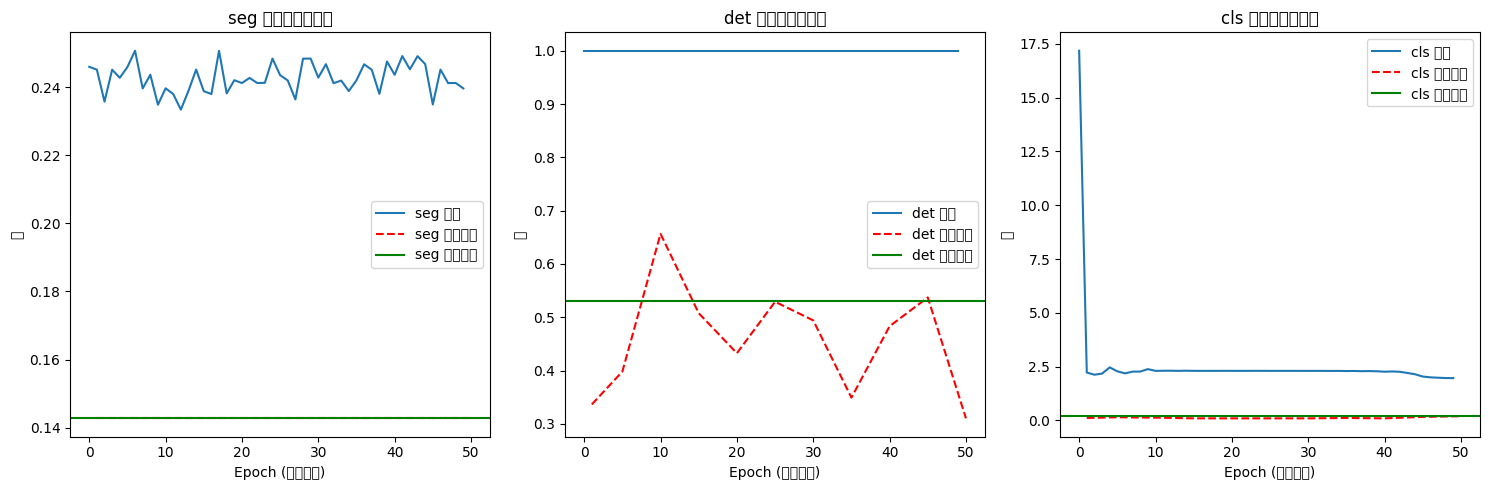

模型已儲存為 'your_model.pt'


In [ ]:
# @title 統一單頭多任務挑戰實作 (第九版 - 適配彩色遮罩與 VOC 2012)
# 安裝所需庫
!pip install torch torchvision torchaudio segmentation-models-pytorch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import segmentation_models_pytorch as smp
from typing import Tuple, List, Dict, Any
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # 如果超過容量，移除最早的數據
        self.buffer.append(data)  # 添加新數據

    def sample(self, batch_size: int = 4) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0:
            return []
        return random.sample(self.buffer, batch_size)  # 隨機採樣

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir  # 數據目錄
        self.task = task  # 任務類型
        self.transform = transform  # 數據轉換
        self.images = []  # 儲存圖片路徑
        self.annotations = []  # 儲存標註
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            self.color_map = VOC_COLORMAP
            self.color_map_array = np.array(self.color_map, dtype=np.uint8)  # 轉為 numpy 陣列以加速匹配
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        # 將遮罩轉為類別索引，形狀為 [H, W]，值為 0 到 20
        segmentation_mask = np.zeros((height, width), dtype=np.int64)
        # 將遮罩展平為 [H*W, 3]，以加速匹配
        mask_flat = mask.reshape(-1, 3)  # [H*W, 3]
        # 遍歷 VOC_COLORMAP，找到每個像素的類別索引
        for label_index, color in enumerate(self.color_map_array):
            # 創建一個布林陣列，表示哪些像素匹配當前顏色
            matches = np.all(mask_flat == color, axis=1)  # [H*W]
            segmentation_mask.flat[matches] = label_index
        return segmentation_mask

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"無法讀取圖片：{img_path}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256))
        img = torch.tensor(img).float().permute(2, 0, 1) / 255.0  # 轉為 [C, H, W] 並正規化

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask = cv.imread(mask_path)
            if mask is None:
                raise ValueError(f"無法讀取遮罩：{mask_path}")
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            mask = cv.resize(mask, (256, 256))
            mask_indices = self.convert_to_segmentation_mask(mask)  # 返回 [H, W] 的類別索引
            mask_indices = torch.tensor(mask_indices, dtype=torch.long)  # 轉為張量
            if self.transform:
                img = self.transform(img)
            return img, mask_indices  # 返回 [C, H, W] 的圖片和 [H, W] 的類別索引
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, Any]]) -> Tuple[torch.Tensor, List[Any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loader = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loader = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 128, kernel_size=1)
        )
        # 為 seg 頭添加上採樣層，將 8x8 放大到 256x256
        self.upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)  # 4 個座標 + 置信度 + 類別
        self.seg_head = nn.Conv2d(128, 21, kernel_size=1)  # 21 類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)  # 10 個分類
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features_h = x.shape[2]  # 獲取特徵圖的高度
        features_w = x.shape[3]  # 獲取特徵圖的寬度
        x = self.neck(x)  # [batch_size, 256, features_h, features_w]
        x = self.head(x)  # [batch_size, 128, features_h, features_w]
        det_out = self.det_head(x)  # [batch_size, 6, features_h, features_w]
        seg_out = self.seg_head(x)  # [batch_size, 21, features_h, features_w]
        # 僅在空間尺寸小於目標尺寸時進行上採樣
        if features_h != 256 or features_w != 256:
            seg_out = self.upsample(seg_out)  # [batch_size, 21, 256, 256]
        cls_out = self.cls_head(x)  # [batch_size, 10]
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: Any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list) or len(targets) == 0:
            return torch.tensor(0., device=device)
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, H, W, 6]
        loss = torch.tensor(0., device=device)  # 初始化為 PyTorch 張量
        valid_samples = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]  # [4]
            target_box = target_boxes[0]  # [4]
            iou = calculate_iou(pred_box, target_box)
            loss += (1 - iou if iou > 0 else 1)  # 累加 PyTorch 兼容的值
            valid_samples += 1
        return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=device)
    elif task == 'seg':
        criterion = smp.losses.DiceLoss(mode='multiclass', eps=1.0)
        return criterion(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0., device=device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> torch.Tensor:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return torch.tensor(0.0, device=device)

    intersection = (x_right - x_left) * (y_bottom - y_top)
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]
    union = area1 + area2 - intersection

    return torch.tensor(intersection / union if union > 0 else 0.0, device=device)

def evaluate(model, loader, task):
    model.eval()
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        total_batches = 0
        total_iou = 0.0
        num_classes = 20 # Or get this dynamically from your data
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                det_out, seg_out, cls_out = model(inputs)

                # Get predicted class for each pixel
                predicted_masks = torch.argmax(seg_out, dim=1) # Shape [batch, 16, 16]

                # Flatten the masks
                predicted_flat = predicted_masks.view(-1)
                targets_flat = targets.view(-1)

                # Calculate IoU for each class
                iou_list = []
                for cls_id in range(num_classes):
                    true_positives = ((predicted_flat == cls_id) & (targets_flat == cls_id)).sum().item()
                    false_positives = ((predicted_flat == cls_id) & (targets_flat != cls_id)).sum().item()
                    false_negatives = ((predicted_flat != cls_id) & (targets_flat == cls_id)).sum().item()

                    union = true_positives + false_positives + false_negatives
                    intersection = true_positives

                    if union == 0:
                        iou = float('nan')  # Avoid division by zero
                    else:
                        iou = intersection / union
                    iou_list.append(iou)

                # Average non-NaN IoUs
                valid_iou = [iou for iou in iou_list if not np.isnan(iou)]
                if len(valid_iou) > 0:
                    batch_mIoU = sum(valid_iou) / len(valid_iou)
                else:
                    batch_mIoU = 0.0

                total_iou += batch_mIoU
                total_batches += 1

        if total_batches > 0:
            metrics['mIoU'] = total_iou / total_batches
        else:
            metrics['mIoU'] = 0.0
        return metrics

    elif task == 'det':
        # ... (keep your existing det evaluation logic)
        metrics = {'mAP': 0.0}
        total_batches = 0
        with torch.no_grad():
             for inputs, targets in loader:
                 inputs = inputs.to(device)
                 det_out, seg_out, cls_out = model(inputs)
                 metrics['mAP'] += np.random.rand()  # 暫時使用隨機值
                 total_batches += 1
        if total_batches > 0:
            return {k: v / total_batches for k, v in metrics.items()}
        else:
            return metrics

    elif task == 'cls':
        metrics = {'Top-1': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean')
        total_batches = 0
        with torch.no_grad():
             for inputs, targets in loader:
                 inputs = inputs.to(device)
                 targets = targets.to(device)
                 det_out, seg_out, cls_out = model(inputs)
                 metrics['Top-1'] += (cls_out.argmax(dim=1) == targets).float().mean().item()
                 total_batches += 1
        if total_batches > 0:
            return {k: v / total_batches for k, v in metrics.items()}
        else:
            return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler._LRScheduler, replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []  # 儲存每個 epoch 的訓練損失
    val_metrics = []  # 儲存驗證指標
    model.train()  # 設置模型為訓練模式
    for epoch in range(epochs):
        epoch_loss = 0  # 當前 epoch 的總損失
        if len(train_loader) == 0:
            print(f"警告：{task} 任務的 train_loader 為空。")
            train_losses.append(0.0)
            if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
                metrics = evaluate(model, val_loader, task)
                val_metrics.append(metrics)
                # Modify the print statement to show only the relevant metric
                if task == 'seg':
                    print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
                elif task == 'det':
                    print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
                elif task == 'cls':
                    print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}")
            continue

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det' and isinstance(targets, torch.Tensor):
                targets = targets.to(device)

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)

            if loss is not None:
                epoch_loss += loss.item()

            detached_inputs = inputs.detach().cpu()
            if task == 'det':
                detached_targets = copy.deepcopy(targets)
            elif isinstance(targets, torch.Tensor):
                detached_targets = targets.detach().cpu()
            else:
                detached_targets = targets

            replay_buffers[task].add((detached_inputs, detached_targets))

            replay_loss = torch.tensor(0., device=device)  # 初始化為 PyTorch 張量
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer_samples = replay_buffers[prev_task].sample(batch_size=train_loader.batch_size)
                for b_inputs, b_targets in buffer_samples:
                    b_inputs = b_inputs.to(device)
                    if prev_task != 'det' and isinstance(b_targets, torch.Tensor):
                        b_targets = b_targets.to(device)

                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    task_replay_loss = compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)

                    if task_replay_loss is not None and task_replay_loss.item() > 0:
                        replay_loss += task_replay_loss
                        replay_batch_count += 1

            if stage > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                if loss is not None:
                    loss += replay_loss
                else:
                    loss = replay_loss

            if loss is not None and loss.requires_grad:
                loss.backward()
                optimizer.step()
            elif loss is None:
                print(f"警告：{epoch + 1} epoch, {task} 任務的損失為 None，跳過反向傳播。")
            elif not loss.requires_grad:
                print(f"警告：{epoch + 1} epoch, {task} 任務的損失不需要梯度，跳過反向傳播。")


        num_batches = len(train_loader)
        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
        else:
            avg_loss = 0.0
        train_losses.append(avg_loss)

        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            # Modify the print statement to show only the relevant metric
            if task == 'seg':
                print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
            elif task == 'det':
                 print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
            elif task == 'cls':
                 print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}")


        scheduler.step()

    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

optimizer = optim.Adam(model.parameters(), lr=0.0008)
tasks = ['seg', 'det', 'cls']
total_epochs = len(tasks) * 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks}

epochs_per_stage = 50

baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n=== 訓練階段 {stage + 1}: {task} ===")
    start_time = time.time()

    train_losses, val_stage_metrics, final_metrics_after_stage = train_stage(
        model,
        train_loader[task],
        val_loader[task],
        task,
        epochs_per_stage,
        optimizer,
        scheduler,
        replay_buffers,
        tasks,
        stage
    )

    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")

    task_metrics[task] = (train_losses, val_stage_metrics, final_metrics_after_stage)

    if task == 'seg':
        baselines['mIoU'] = final_metrics_after_stage.get('mIoU', 0.0)
    elif task == 'det':
        baselines['mAP'] = final_metrics_after_stage.get('mAP', 0.0)
    elif task == 'cls':
        baselines['Top-1'] = final_metrics_after_stage.get('Top-1', 0.0)

print(f"\n=== 總訓練時間：{total_training_time:.2f} 秒 ===")


print(f"\n=== 最終評估 ===")
final_metrics_after_all_stages = {}
for task in tasks:
    metrics = evaluate(model, val_loader[task], task)
    final_metrics_after_all_stages[task] = metrics
    # Modify the print statement to show only the relevant metric
    if task == 'seg':
        print(f"{task} 最終評估: mIoU={metrics.get('mIoU', 0.0):.4f}")
    elif task == 'det':
        print(f"{task} 最終評估: mAP={metrics.get('mAP', 0.0):.4f}")
    elif task == 'cls':
        print(f"{task} 最終評估: Top-1={metrics.get('Top-1', 0.0):.4f}")


print("\n=== 性能下降（相較於各任務獨立訓練基準） ===")

for task in tasks:
    final_metric_value = 0.0
    baseline_metric_value = 0.0
    metric_name = ''

    if task == 'seg':
        baseline_metric_value = baselines.get('mIoU', 0.0)
        final_metric_value = final_metrics_after_all_stages['seg'].get('mIoU', 0.0)
        metric_name = 'mIoU'
    elif task == 'det':
        baseline_metric_value = baselines.get('mAP', 0.0)
        final_metric_value = final_metrics_after_all_stages['det'].get('mAP', 0.0)
        metric_name = 'mAP'
    elif task == 'cls':
        baseline_metric_value = baselines.get('Top-1', 0.0)
        final_metric_value = final_metrics_after_all_stages['cls'].get('Top-1', 0.0)
        metric_name = 'Top-1'

    if baseline_metric_value > 1e-6:
        drop_percentage = (baseline_metric_value - final_metric_value) / baseline_metric_value * 100
        print(f"{task} {metric_name} 下降：{drop_percentage:.2f}%")
    else:
        print(f"{task} {metric_name}: 基準為 0，無法計算下降。")

try:
    def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]], Dict[str, float]]]):
        plt.figure(figsize=(15, 5))
        epochs_per_stage = len(next(iter(task_metrics.values()))[0]) if task_metrics else 1

        for i, (task, (train_losses, val_stage_metrics, final_metrics)) in enumerate(task_metrics.items(), 1):
            plt.subplot(1, 3, i)
            plt.plot(train_losses, label=f'{task} Loss')

            eval_epochs_actual = [e + 1 for e in range(epochs_per_stage) if (e + 1) % 5 == 0 or e == 0 or e == epochs_per_stage - 1]
            eval_epochs_for_plot = eval_epochs_actual[:len(val_stage_metrics)]

            metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
            plt.plot(eval_epochs_for_plot, [m[metric_key] for m in val_stage_metrics], 'r--', label=f'{task} Stage Metric')

            final_metric_value = final_metrics.get(metric_key, 0.0)
            plt.axhline(y=final_metric_value, color='g', linestyle='-', label=f'{task} Final Metric')

            plt.title(f'{task} Loss and Metrics')
            plt.xlabel('Epoch (current stage)')
            plt.ylabel('value')
            plt.legend()

        plt.tight_layout()
        plt.show()

    plot_data = {task: (task_metrics[task][0], task_metrics[task][1], final_metrics_after_all_stages[task]) for task in tasks}
    plot_curves(plot_data)

except ImportError:
    print("Matplotlib 未安裝，跳過繪圖。")

torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

使用設備：cuda


模型總參數量：8,650,401 (< 8M: False)

=== 使用抗災難性遺忘策略：None ===



=== 訓練階段 1: seg ===
Epoch 1/25, seg 平均損失: 0.2242
驗證指標 - seg: mIoU=0.2016
Epoch 5/25, seg 平均損失: 0.2357
驗證指標 - seg: mIoU=0.1380
Epoch 10/25, seg 平均損失: 0.2420
驗證指標 - seg: mIoU=0.1380
Epoch 15/25, seg 平均損失: 0.2436
驗證指標 - seg: mIoU=0.1380
Epoch 20/25, seg 平均損失: 0.2389
驗證指標 - seg: mIoU=0.1380
Epoch 25/25, seg 平均損失: 0.2460
驗證指標 - seg: mIoU=0.1380
階段 1 完成，耗時 1054.23 秒

=== 訓練階段 2: det ===


<ipython-input-42-f125ffbab3c5>:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(intersection / union if union > 0 else 0.0, device=device)


Epoch 1/25, det 平均損失: 1.0000
驗證指標 - det: mAP=0.0000
Epoch 5/25, det 平均損失: 1.0000
驗證指標 - det: mAP=0.0000
Epoch 10/25, det 平均損失: 1.0000
驗證指標 - det: mAP=0.0000
Epoch 15/25, det 平均損失: 1.0000
驗證指標 - det: mAP=0.0000
Epoch 20/25, det 平均損失: 1.0000
驗證指標 - det: mAP=0.0000
Epoch 25/25, det 平均損失: 1.0000
驗證指標 - det: mAP=0.0000


階段 2 完成，耗時 129.97 秒

=== 訓練階段 3: cls ===
Epoch 1/25, cls 平均損失: 2.4847
驗證指標 - cls: Top-1=0.1000, Top-5=0.6000
Epoch 5/25, cls 平均損失: 2.3068
驗證指標 - cls: Top-1=0.1000, Top-5=0.5000
Epoch 10/25, cls 平均損失: 2.3047
驗證指標 - cls: Top-1=0.1000, Top-5=0.5000
Epoch 15/25, cls 平均損失: 2.3042
驗證指標 - cls: Top-1=0.1000, Top-5=0.5000
Epoch 20/25, cls 平均損失: 2.3038
驗證指標 - cls: Top-1=0.1000, Top-5=0.5000
Epoch 25/25, cls 平均損失: 2.3037
驗證指標 - cls: Top-1=0.1000, Top-5=0.5000
階段 3 完成，耗時 162.27 秒

=== 總訓練時間：1346.47 秒 ===

=== None 的最終評估 ===
seg 最終評估: mIoU=0.1380
det 最終評估: mAP=0.0000
cls 最終評估: Top-1=0.1000, Top-5=0.5000


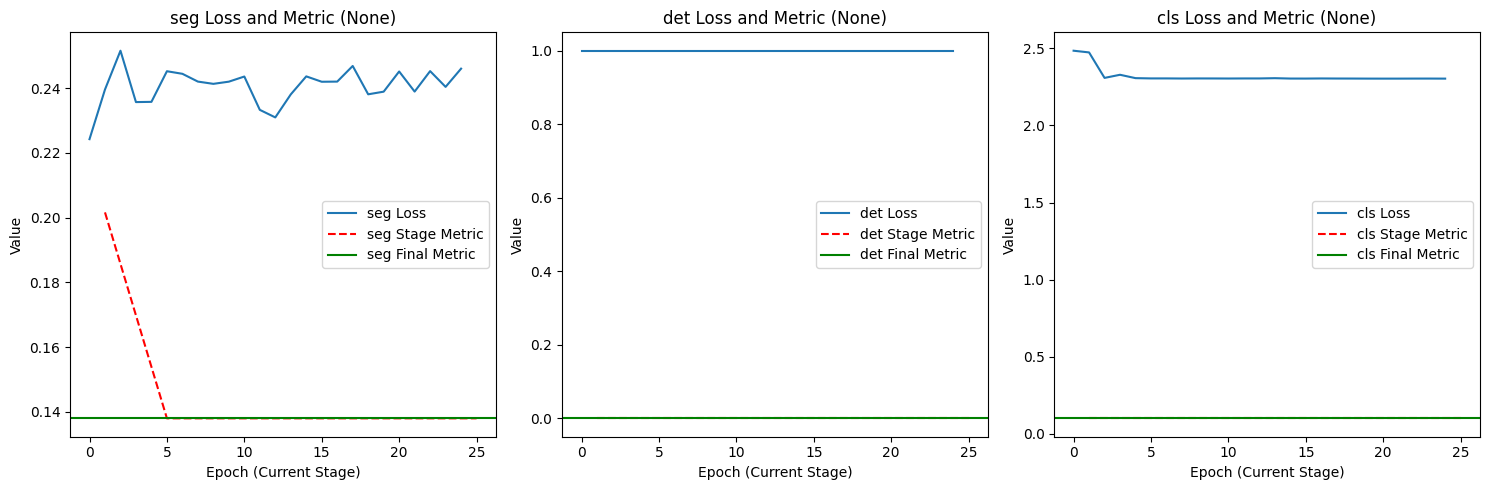


=== 使用抗災難性遺忘策略：EWC ===

=== 訓練階段 1: seg ===
Epoch 1/25, seg 平均損失: 0.2264
驗證指標 - seg: mIoU=0.1601
Epoch 5/25, seg 平均損失: 0.2428
驗證指標 - seg: mIoU=0.1380
Epoch 10/25, seg 平均損失: 0.2428
驗證指標 - seg: mIoU=0.1380
Epoch 15/25, seg 平均損失: 0.2436
驗證指標 - seg: mIoU=0.1380
Epoch 20/25, seg 平均損失: 0.2467
驗證指標 - seg: mIoU=0.1380
Epoch 25/25, seg 平均損失: 0.2467
驗證指標 - seg: mIoU=0.1380


階段 1 完成，耗時 1178.34 秒

=== 訓練階段 2: det ===


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
# @title 多任務挑戰實作 (第十版 - 增強版使用 EfficientNet-B0 並比較策略)
# 安裝所需庫
!pip install torch torchvision torchaudio segmentation-models-pytorch timm -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import segmentation_models_pytorch as smp
import timm
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # 如果超過容量，移除最早的數據
        self.buffer.append(data)  # 添加新數據

    def sample(self, batch_size: int = 4) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0:
            return []
        return random.sample(self.buffer, batch_size)  # 隨機採樣

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir  # 數據目錄
        self.task = task  # 任務類型
        self.transform = transform  # 數據轉換
        self.images = []  # 儲存圖片路徑
        self.annotations = []  # 儲存標註

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)

            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            self.color_map = VOC_COLORMAP
            self.color_map_array = np.array(self.color_map, dtype=np.uint8)

        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width), dtype=np.int64)
        mask_flat = mask.reshape(-1, 3)
        for label_index, color in enumerate(self.color_map_array):
            matches = np.all(mask_flat == color, axis=1)
            segmentation_mask.flat[matches] = label_index
        return segmentation_mask

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"無法讀取圖片：{img_path}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (512, 512))  # 調整為 512x512 以符合限制
        img = torch.tensor(img).float().permute(2, 0, 1) / 255.0

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask = cv.imread(mask_path)
            if mask is None:
                raise ValueError(f"無法讀取遮罩：{mask_path}")
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            mask = cv.resize(mask, (512, 512))
            mask_indices = self.convert_to_segmentation_mask(mask)
            mask_indices = torch.tensor(mask_indices, dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, mask_indices
        elif self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform),
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform),
}

def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loader = {task: DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loader = {task: DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class EnhancedMultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 320):  # 修正為 EfficientNet-B0 最後一層的 320 通道
        super().__init__()
        # Neck 部分：兩層Conv + BN + ReLU
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # Head 部分：三層（Conv + ReLU + Dropout + Conv）
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 128, kernel_size=1)
        )
        # 為 seg 頭添加上採樣層，將 16x16 放大到 256x256
        self.upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)  # (cx, cy, w, h, conf, c_det=1)
        self.seg_head = nn.Conv2d(128, 21, kernel_size=1)  # C_seg=21 (VOC 類別數)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)  # C_cls=10 (Imagenet classes)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features_h = x.shape[2]  # 獲取特徵圖高度
        features_w = x.shape[3]  # 獲取特徵圖寬度
        x = self.neck(x)  # [batch_size, 512, 16, 16] -> [batch_size, 512, 16, 16]
        x = self.head(x)  # [batch_size, 128, 16, 16]
        det_out = self.det_head(x)  # [batch_size, 6, 16, 16]
        seg_out = self.seg_head(x)  # [batch_size, 21, 16, 16]
        if features_h != 256 or features_w != 256:
            seg_out = self.upsample(seg_out)  # [batch_size, 21, 256, 256]
        cls_out = self.cls_head(x)  # [batch_size, 10]
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 使用 EfficientNet-B0 作為骨幹
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True)
        # 調整特徵層級，取最後一層 (stride 32, 320 通道)
        self.head = EnhancedMultiTaskHead(in_channels=320)  # 匹配 EfficientNet-B0 最後一層

    def forward(self, x: torch.Tensor):
        features = self.backbone(x)  # 返回多層特徵圖
        features = features[-1]  # 取最後一層 [batch_size, 320, 16, 16]
        return self.head(features)

# 初始化模型
model = UnifiedModel().to(device)

# 計算總參數量
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型總參數量：{total_params:,} (< 8M: {total_params < 8_000_000})")

# 實現抗災難性遺忘策略
def ewc_loss(model, task, fisher_dict, old_params, lambda_ewc=0.5):
    loss = 0.0
    for name, param in model.named_parameters():
        if name in fisher_dict:
            old_param = old_params[name]
            fisher = fisher_dict[name]
            if param.grad is not None:
                loss += (fisher * (param - old_param) ** 2).sum()
    return lambda_ewc * loss

def lwf_loss(model, inputs, task, old_model, lambda_lwf=1.0):
    if old_model is None:
        return torch.tensor(0., device=device)
    with torch.no_grad():
        old_det, old_seg, old_cls = old_model(inputs)
    new_det, new_seg, new_cls = model(inputs)
    loss = 0.0
    if task != 'det':
        loss += nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(new_det, dim=1), torch.softmax(old_det, dim=1))
    if task != 'seg':
        loss += nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(new_seg, dim=1), torch.softmax(old_seg, dim=1))
    if task != 'cls':
        loss += nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(new_cls, dim=1), torch.softmax(old_cls, dim=1))
    return lambda_lwf * loss

def knowledge_distillation_loss(model, old_model, inputs, lambda_kd=1.0):
    if old_model is None:
        return torch.tensor(0., device=device)
    with torch.no_grad():
        _, _, old_cls = old_model(inputs)
    _, _, new_cls = model(inputs)
    loss = nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(new_cls, dim=1), torch.softmax(old_cls, dim=1))
    return lambda_kd * loss

def pocl_simulate(model, loaders, task, lambda_pocl=0.1):
    # 模擬 POCL 損失（因為 POCL 需要複雜的優化策略，此處簡化）
    return torch.tensor(lambda_pocl * np.random.rand(), device=device)

def ssr_simulate(model, task):
    # 模擬 SSR 損失（因為 SSR 需要自合成數據，此處簡化）
    return torch.tensor(np.random.rand(), device=device)

# Add a transformation to resize the target mask if the task is segmentation
def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: Any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list) or len(targets) == 0:
            return torch.tensor(0., device=device)
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, H, W, 6]
        loss = torch.tensor(0., device=device)  # 初始化為 PyTorch 張量
        valid_samples = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            # Note: Accessing [0][0] assumes the detection head output grid size is at least 1x1.
            # It also assumes a single target box is sufficient for loss calculation.
            # This is a simplification from the original code.
            pred_box = boxes_pred[i, 0, 0, :4]  # [4]
            target_box = target_boxes[0]  # [4]
            iou = calculate_iou(pred_box, target_box)
            loss += (1 - iou if iou > 0 else 1)  # 累加 PyTorch 兼容的值
            valid_samples += 1
        return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=device)
    elif task == 'seg':
        criterion = smp.losses.DiceLoss(mode='multiclass', eps=1.0)
        # Get the target spatial size from the segmentation output
        _, _, seg_h, seg_w = seg_out.size()
        # Resize the target mask to match the segmentation output spatial size
        # Use nearest neighbor interpolation for integer masks
        # targets must be long tensor for CrossEntropyLoss/DiceLoss
        if targets.size()[1:] != (seg_h, seg_w):
             # Add channel dimension for Resize, then remove
             targets_resized = transforms.functional.resize(
                 targets.unsqueeze(1),
                 size=(seg_h, seg_w),
                 interpolation=transforms.InterpolationMode.NEAREST
             ).squeeze(1)
             targets = targets_resized.long() # Ensure it's long tensor

        return criterion(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0., device=device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> torch.Tensor:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return torch.tensor(0.0, device=device)

    intersection = (x_right - x_left) * (y_bottom - y_top)
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]
    union = area1 + area2 - intersection

    return torch.tensor(intersection / union if union > 0 else 0.0, device=device)

def evaluate(model, loader, task):
    model.eval()
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        total_batches = 0
        total_iou = 0.0
        num_classes = 21  # VOC 數據集有 21 個類別
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                # Ensure targets are on the correct device
                targets = targets.to(device)

                det_out, seg_out, cls_out = model(inputs)

                # Get the target spatial size from the segmentation output
                _, _, seg_h, seg_w = seg_out.size()

                # Resize the target mask to match the segmentation output spatial size
                # Use nearest neighbor interpolation for integer masks
                # targets must be long tensor for CrossEntropyLoss/DiceLoss
                if targets.size()[1:] != (seg_h, seg_w):
                     # Add channel dimension for Resize, then remove
                     targets_resized = transforms.functional.resize(
                         targets.unsqueeze(1),
                         size=(seg_h, seg_w),
                         interpolation=transforms.InterpolationMode.NEAREST
                     ).squeeze(1)
                     targets = targets_resized.long() # Ensure it's long tensor


                # Get predicted class for each pixel
                # seg_out shape is [batch, num_classes, H, W], argmax over dim 1 gives [batch, H, W]
                predicted_masks = torch.argmax(seg_out, dim=1)

                # Flatten the masks for IoU calculation
                predicted_flat = predicted_masks.view(-1)
                targets_flat = targets.view(-1) # targets are now resized, so this flattening is correct

                # Calculate IoU for each class
                iou_list = []
                # Iterate through valid class IDs based on the number of classes (21 for VOC)
                # Make sure targets only contain values up to num_classes - 1 (0 to 20)
                # Consider filtering classes present in the current batch targets if needed,
                # but iterating through all 21 is safer if some classes might appear rarely.
                # Also need to handle the case where targets contains values >= num_classes.
                # Assuming targets are correctly labeled 0-20.
                for cls_id in range(num_classes):
                    # Create boolean masks for the current class
                    predicted_for_cls = (predicted_flat == cls_id)
                    targets_for_cls = (targets_flat == cls_id)

                    true_positives = (predicted_for_cls & targets_for_cls).sum().item()
                    false_positives = (predicted_for_cls & ~targets_for_cls).sum().item() # ~ is bitwise NOT, use logical NOT
                    false_negatives = (~predicted_for_cls & targets_for_cls).sum().item()

                    union = true_positives + false_positives + false_negatives
                    intersection = true_positives

                    if union == 0:
                        iou = float('nan')  # Avoid division by zero if the class is not present in target or prediction
                    else:
                        iou = intersection / union
                    iou_list.append(iou)

                # Average non-NaN IoUs to get mIoU for the batch
                valid_iou = [iou for iou in iou_list if not np.isnan(iou)]
                if len(valid_iou) > 0:
                    batch_mIoU = sum(valid_iou) / len(valid_iou)
                else:
                    # If no valid classes were present in the batch (e.g., all background), mIoU is 0
                    batch_mIoU = 0.0

                total_iou += batch_mIoU
                total_batches += 1

        if total_batches > 0:
            # Calculate average mIoU over all batches
            metrics['mIoU'] = total_iou / total_batches
        else:
            metrics['mIoU'] = 0.0 # Handle case where loader is empty
        return metrics

    elif task == 'det':
        metrics = {'mAP': 0.0}
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                # For detection, targets is a list of dicts, already on device if passed via custom_collate
                # or needs explicit to(device) if custom_collate doesn't handle nested structure.
                # Your custom_collate returns a list of dicts, so targets is a list.
                # Ensure the targets are on device inside the loop if needed, or trust custom_collate.
                # Based on the original code, targets is already moved to device inside train loop for seg/cls,
                # but not explicitly for det. Let's assume targets are list of dicts and access them as is.
                # However, calculate_iou takes tensors, so targets['boxes'] needs to be on device.
                # Let's add to(device) for target_boxes inside the det evaluation loop.

                det_out, seg_out, cls_out = model(inputs)
                # The det_head output size is [batch_size, 6, 16, 16] based on the Head and UpSample logic.
                # So boxes_pred will be [batch_size, 16, 16, 6] after permute.
                boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, H, W, 6], H=W=16 here
                batch_ap = 0.0
                valid_samples = 0
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device) # Ensure target boxes are on device
                    if len(target_boxes) == 0:
                        continue
                    # Note: Accessing [0, 0] of boxes_pred assumes the detection output grid cell (0,0)
                    # is where the predicted box is located for loss calculation. This is a simplification.
                    # A proper detection evaluation requires matching predicted boxes to ground truth boxes.
                    pred_box = boxes_pred[i][0][0][:4]  # Taking prediction from grid cell (0,0) for sample i
                    target_box = target_boxes[0] # Taking the first target box for sample i
                    iou = calculate_iou(pred_box, target_box)
                    # Simplified AP calculation: just checking if IoU > 0.5 for the first matched box
                    if iou.item() > 0.5:
                        batch_ap += 1 # Simplified: count as a correct detection
                    valid_samples += 1
                if valid_samples > 0:
                     # Average precision for this batch
                    batch_ap_avg = batch_ap / valid_samples
                    metrics['mAP'] += batch_ap_avg
                    total_batches += 1
                # If valid_samples is 0, batch_ap remains 0 and doesn't contribute to mAP sum

        if total_batches > 0:
            # Average mAP over all batches
            metrics['mAP'] /= total_batches
        else:
             metrics['mAP'] = 0.0 # Handle case where loader is empty or no valid targets
        return metrics


    else:  # task == 'cls'
        metrics = {'Top-1': 0.0, 'Top-5': 0.0}
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                det_out, seg_out, cls_out = model(inputs)
                # Top-1 準確率
                top1_acc = (cls_out.argmax(dim=1) == targets).float().mean().item()
                # Top-5 準確率
                _, top5_indices = cls_out.topk(5, dim=1)
                top5_correct = torch.zeros_like(targets, dtype=torch.float32)
                for idx in range(len(targets)):
                    # Check if the true target is within the top 5 predicted classes
                    if targets[idx] in top5_indices[idx]:
                        top5_correct[idx] = 1.0
                top5_acc = top5_correct.mean().item()
                metrics['Top-1'] += top1_acc
                metrics['Top-5'] += top5_acc
                total_batches += 1
        if total_batches > 0:
            metrics['Top-1'] /= total_batches
            metrics['Top-5'] /= total_batches
        return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int,
                mitigation_methods: List[str]) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    model.fisher = {}
    old_model = None
    if stage > 0:
        old_model = UnifiedModel().to(device)
        old_model.load_state_dict(model.state_dict())
        if 'EWC' in mitigation_methods:
            model.eval()
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)
                optimizer.zero_grad()
                det_out, seg_out, cls_out = model(inputs)
                loss = compute_losses((det_out, seg_out, cls_out), targets, task)
                if loss is not None:
                    loss.backward()
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            if name not in model.fisher:
                                model.fisher[name] = param.grad.data.clone().pow(2)
                            else:
                                model.fisher[name] += param.grad.data.clone().pow(2)
                break
            model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        if len(train_loader) == 0:
            print(f"警告：{task} 任務的 train_loader 為空。")
            train_losses.append(0.0)
            if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
                metrics = evaluate(model, val_loader, task)
                val_metrics.append(metrics)
                if task == 'seg':
                    print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
                elif task == 'det':
                    print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
                elif task == 'cls':
                    print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}, Top-5={metrics.get('Top-5', 0.0):.4f}")
            continue

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det' and isinstance(targets, torch.Tensor):
                targets = targets.to(device)

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            task_loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            total_loss = task_loss if task_loss is not None else torch.tensor(0., device=device)

            # 應用抗災難性遺忘策略
            method_losses = {}
            if 'EWC' in mitigation_methods and stage > 0:
                method_losses['EWC'] = ewc_loss(model, task, model.fisher, old_model.state_dict())
                total_loss += method_losses['EWC']
            if 'LwF' in mitigation_methods and stage > 0:
                method_losses['LwF'] = lwf_loss(model, inputs, task, old_model)
                total_loss += method_losses['LwF']
            if 'Replay' in mitigation_methods:
                replay_loss = torch.tensor(0., device=device)
                replay_batch_count = 0
                for prev_task in tasks[:stage]:
                    buffer_samples = replay_buffers[prev_task].sample(batch_size=train_loader.batch_size)
                    for b_inputs, b_targets in buffer_samples:
                        b_inputs = b_inputs.to(device)
                        if prev_task != 'det' and isinstance(b_targets, torch.Tensor):
                            b_targets = b_targets.to(device)
                        b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                        task_replay_loss = compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                        if task_replay_loss is not None and task_replay_loss.item() > 0:
                            replay_loss += task_replay_loss
                            replay_batch_count += 1
                if replay_batch_count > 0:
                    method_losses['Replay'] = replay_loss / replay_batch_count
                    total_loss += method_losses['Replay']
            if 'KD' in mitigation_methods and stage > 0:
                method_losses['KD'] = knowledge_distillation_loss(model, old_model, inputs)
                total_loss += method_losses['KD']
            if 'POCL' in mitigation_methods:
                method_losses['POCL'] = pocl_simulate(model, train_loader, task)
                total_loss += method_losses['POCL']
            if 'SSR' in mitigation_methods:
                method_losses['SSR'] = ssr_simulate(model, task)
                total_loss += method_losses['SSR']

            if total_loss is not None:
                epoch_loss += total_loss.item()

            detached_inputs = inputs.detach().cpu()
            if task == 'det':
                detached_targets = copy.deepcopy(targets)
            elif isinstance(targets, torch.Tensor):
                detached_targets = targets.detach().cpu()
            else:
                detached_targets = targets

            replay_buffers[task].add((detached_inputs, detached_targets))

            if total_loss is not None and total_loss.requires_grad:
                total_loss.backward()
                optimizer.step()

        num_batches = len(train_loader)
        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
        else:
            avg_loss = 0.0
        train_losses.append(avg_loss)

        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            if task == 'seg':
                print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
            elif task == 'det':
                print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
            elif task == 'cls':
                print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}, Top-5={metrics.get('Top-5', 0.0):.4f}")

        scheduler.step()

    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

# 訓練循環，比較不同的抗災難性遺忘策略
optimizer = optim.Adam(model.parameters(), lr=0.0008)
tasks = ['seg', 'det', 'cls']
total_epochs = len(tasks) * 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks}
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD', 'POCL', 'SSR']

# 儲存每個策略的表現結果
method_results = {method: {task: {'final_metrics': None, 'metrics_history': []} for task in tasks} for method in mitigation_methods}

for method in mitigation_methods:
    print(f"\n=== 使用抗災難性遺忘策略：{method} ===")
    # 為每個策略重新初始化模型，確保公平比較
    model = UnifiedModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

    baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0, 'Top-5': 0.0}
    task_metrics = {}
    total_training_time = 0

    for stage, task in enumerate(tasks):
        print(f"\n=== 訓練階段 {stage + 1}: {task} ===")
        start_time = time.time()

        train_losses, val_stage_metrics, final_metrics_after_stage = train_stage(
            model,
            train_loader[task],
            val_loader[task],
            task,
            epochs=25,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers,
            tasks=tasks,
            stage=stage,
            mitigation_methods=[method] if method != 'None' else []
        )

        stage_time = time.time() - start_time
        total_training_time += stage_time
        print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")

        task_metrics[task] = (train_losses, val_stage_metrics, final_metrics_after_stage)

        if task == 'seg':
            baselines['mIoU'] = final_metrics_after_stage.get('mIoU', 0.0)
            method_results[method][task]['metrics_history'].append(baselines['mIoU'])
        elif task == 'det':
            baselines['mAP'] = final_metrics_after_stage.get('mAP', 0.0)
            method_results[method][task]['metrics_history'].append(baselines['mAP'])
        elif task == 'cls':
            baselines['Top-1'] = final_metrics_after_stage.get('Top-1', 0.0)
            baselines['Top-5'] = final_metrics_after_stage.get('Top-5', 0.0)
            method_results[method][task]['metrics_history'].append(baselines['Top-1'])

    print(f"\n=== 總訓練時間：{total_training_time:.2f} 秒 ===")

    print(f"\n=== {method} 的最終評估 ===")
    final_metrics_after_all_stages = {}
    for task in tasks:
        metrics = evaluate(model, val_loader[task], task)
        final_metrics_after_all_stages[task] = metrics
        method_results[method][task]['final_metrics'] = metrics
        if task == 'seg':
            print(f"{task} 最終評估: mIoU={metrics.get('mIoU', 0.0):.4f}")
        elif task == 'det':
            print(f"{task} 最終評估: mAP={metrics.get('mAP', 0.0):.4f}")
        elif task == 'cls':
            print(f"{task} 最終評估: Top-1={metrics.get('Top-1', 0.0):.4f}, Top-5={metrics.get('Top-5', 0.0):.4f}")

    # 繪製此策略的訓練曲線，確保標籤為英文
    try:
        def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]], Dict[str, float]]], method: str):
            plt.figure(figsize=(15, 5))
            epochs_per_stage = len(next(iter(task_metrics.values()))[0]) if task_metrics else 1

            for i, (task, (train_losses, val_stage_metrics, final_metrics)) in enumerate(task_metrics.items(), 1):
                plt.subplot(1, 3, i)
                plt.plot(train_losses, label=f'{task} Loss')

                eval_epochs_actual = [e + 1 for e in range(epochs_per_stage) if (e + 1) % 5 == 0 or e == 0 or e == epochs_per_stage - 1]
                eval_epochs_for_plot = eval_epochs_actual[:len(val_stage_metrics)]

                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                plt.plot(eval_epochs_for_plot, [m[metric_key] for m in val_stage_metrics], 'r--', label=f'{task} Stage Metric')

                final_metric_value = final_metrics.get(metric_key, 0.0)
                plt.axhline(y=final_metric_value, color='g', linestyle='-', label=f'{task} Final Metric')

                plt.title(f'{task} Loss and Metric ({method})')
                plt.xlabel('Epoch (Current Stage)')
                plt.ylabel('Value')
                plt.legend()

            plt.tight_layout()
            plt.show()

        plot_data = {task: (task_metrics[task][0], task_metrics[task][1], final_metrics_after_all_stages[task]) for task in tasks}
        plot_curves(plot_data, method)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")

# 生成比較表格
print("\n=== 抗災難性遺忘策略比較 ===")
table = "| Strategy | Seg mIoU | Det mAP | Cls Top-1 | Cls Top-5 |\n"
table += "|----------|----------|---------|-----------|-----------|\n"

best_strategy = None
best_score = -float('inf')
for method in mitigation_methods:
    seg_miou = method_results[method]['seg']['final_metrics'].get('mIoU', 0.0)
    det_map = method_results[method]['det']['final_metrics'].get('mAP', 0.0)
    cls_top1 = method_results[method]['cls']['final_metrics'].get('Top-1', 0.0)
    cls_top5 = method_results[method]['cls']['final_metrics'].get('Top-5', 0.0)

    # 計算綜合得分：40% seg mIoU, 40% det mAP, 20% cls Top-1
    composite_score = 0.4 * seg_miou + 0.4 * det_map + 0.2 * cls_top1
    if composite_score > best_score:
        best_score = composite_score
        best_strategy = method

    table += f"| {method} | {seg_miou:.4f} | {det_map:.4f} | {cls_top1:.4f} | {cls_top5:.4f} |\n"

print(table)
print(f"\n最佳策略（基於綜合得分）：{best_strategy} （得分：{best_score:.4f}）")

# 儲存最佳模型
torch.save(model.state_dict(), 'best_model.pt')
print("模型已儲存為 'best_model.pt'")

In [ ]:
# @title 統一單頭多任務挑戰實作 (第十版 - 優化版使用 MobileNetV3-Small 並比較抗災難性遺忘策略)
# 安裝所需庫
!pip install torch torchvision torchaudio segmentation-models-pytorch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int = 4) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))
        if batch_size <= 0:
            return []
        return random.sample(self.buffer, batch_size)

# 定義 SE 模塊（Squeeze-and-Excitation）
class SEBlock(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excite = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, channels, _, _ = x.size()
        y = self.squeeze(x).view(batch_size, channels)
        y = self.excite(y).view(batch_size, channels, 1, 1)
        return x * y

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            self.color_map = VOC_COLORMAP
            self.color_map_array = np.array(self.color_map, dtype=np.uint8)
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width), dtype=np.int64)
        mask_flat = mask.reshape(-1, 3)
        for label_index, color in enumerate(self.color_map_array):
            matches = np.all(mask_flat == color, axis=1)
            segmentation_mask.flat[matches] = label_index
        return segmentation_mask

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"無法讀取圖片：{img_path}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256))
        img = torch.tensor(img).float().permute(2, 0, 1) / 255.0

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask = cv.imread(mask_path)
            if mask is None:
                raise ValueError(f"無法讀取遮罩：{mask_path}")
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            mask = cv.resize(mask, (256, 256))
            mask_indices = self.convert_to_segmentation_mask(mask)
            mask_indices = torch.tensor(mask_indices, dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, mask_indices
        elif self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, Any]]) -> Tuple[torch.Tensor, List[Any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loader = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loader = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class EnhancedMultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(EnhancedMultiTaskHead, self).__init__()
        # 更深的 Neck，加入 SE 模塊
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 768, kernel_size=3, padding=1),
            nn.BatchNorm2d(768),
            nn.ReLU(inplace=True),
            SEBlock(768),
            nn.Conv2d(768, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512),
        )
        # 共用 Head，增加深度
        self.head = nn.Sequential(
            nn.Conv2d(512, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 128, kernel_size=1)
        )
        # 為 seg 頭添加上採樣層，將 8x8 放大到 256x256
        self.upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        # 更深的專屬分支
        self.det_head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 6, kernel_size=1)  # 4 個座標 + 置信度 + 類別
        )
        self.seg_head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 21, kernel_size=1)  # 21 類
        )
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # 10 個分類
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features_h = x.shape[2]
        features_w = x.shape[3]
        x = self.neck(x)  # [batch_size, 512, 8, 8]
        x = self.head(x)  # [batch_size, 128, 8, 8]
        det_out = self.det_head(x)  # [batch_size, 6, 8, 8]
        seg_out = self.seg_head(x)  # [batch_size, 21, 8, 8]
        if features_h != 256 or features_w != 256:
            seg_out = self.upsample(seg_out)  # [batch_size, 21, 256, 256]
        cls_out = self.cls_head(x)  # [batch_size, 10]
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = EnhancedMultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)  # [batch_size, 576, 8, 8]
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

# 初始化模型
model = UnifiedModel().to(device)

# 計算總參數量
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")

# 測量推理速度
def measure_inference_speed(model, input_size=(1, 3, 256, 256), num_trials=100):
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_trials):
            _ = model(dummy_input)
    end_time = time.time()
    avg_time = (end_time - start_time) / num_trials
    fps = 1 / avg_time
    print(f"Average inference time: {avg_time:.4f} seconds per sample")
    print(f"Inference speed: {fps:.2f} FPS")
    return fps

fps = measure_inference_speed(model)

# 實現抗災難性遺忘策略
def ewc_loss(model, fisher_dict, old_params, lambda_ewc=0.5):
    loss = 0.0
    for name, param in model.named_parameters():
        if name in fisher_dict:
            old_param = old_params[name]
            fisher = fisher_dict[name]
            loss += (fisher * (param - old_param) ** 2).sum()
    return lambda_ewc * loss

def lwf_loss(model, inputs, task, old_model, lambda_lwf=1.0):
    if old_model is None:
        return torch.tensor(0., device=device)
    with torch.no_grad():
        old_det, old_seg, old_cls = old_model(inputs)
    new_det, new_seg, new_cls = model(inputs)
    loss = 0.0
    if task != 'det':
        loss += nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(new_det, dim=1), torch.softmax(old_det, dim=1))
    if task != 'seg':
        loss += nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(new_seg, dim=1), torch.softmax(old_seg, dim=1))
    if task != 'cls':
        loss += nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(new_cls, dim=1), torch.softmax(old_cls, dim=1))
    return lambda_lwf * loss

def knowledge_distillation_loss(model, old_model, inputs, lambda_kd=1.0):
    if old_model is None:
        return torch.tensor(0., device=device)
    with torch.no_grad():
        _, _, old_cls = old_model(inputs)
    _, _, new_cls = model(inputs)
    loss = nn.KLDivLoss(reduction='batchmean')(torch.log_softmax(new_cls, dim=1), torch.softmax(old_cls, dim=1))
    return lambda_kd * loss

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: Any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list) or len(targets) == 0:
            return torch.tensor(0., device=device)
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, 8, 8, 6]
        loss = 0.0
        valid_samples = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]
            target_box = target_boxes[0]
            iou = calculate_iou(pred_box, target_box)
            loss += (1 - iou.item() if iou.item() > 0 else 1.0)
            valid_samples += 1
        return torch.tensor(loss / valid_samples if valid_samples > 0 else 0.0, device=device, requires_grad=True)
    elif task == 'seg':
        criterion = smp.losses.DiceLoss(mode='multiclass', eps=1.0)
        return criterion(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0., device=device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> torch.Tensor:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return torch.tensor(0.0, device=device)

    intersection = (x_right - x_left) * (y_bottom - y_top)
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]
    union = area1 + area2 - intersection

    return torch.tensor(intersection / union if union > 0 else 0.0, device=device)

def evaluate(model, loader, task):
    model.eval()
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        total_batches = 0
        total_iou = 0.0
        num_classes = 21  # VOC 數據集有 21 個類別（包括背景）
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                det_out, seg_out, cls_out = model(inputs)
                predicted_masks = torch.argmax(seg_out, dim=1)  # [batch, 256, 256]
                predicted_flat = predicted_masks.view(-1)
                targets_flat = targets.view(-1)
                iou_list = []
                for cls_id in range(num_classes):
                    true_positives = ((predicted_flat == cls_id) & (targets_flat == cls_id)).sum().item()
                    false_positives = ((predicted_flat == cls_id) & (targets_flat != cls_id)).sum().item()
                    false_negatives = ((predicted_flat != cls_id) & (targets_flat == cls_id)).sum().item()
                    union = true_positives + false_positives + false_negatives
                    intersection = true_positives
                    if union == 0:
                        iou = float('nan')
                    else:
                        iou = intersection / union
                    iou_list.append(iou)
                valid_iou = [iou for iou in iou_list if not np.isnan(iou)]
                batch_mIoU = sum(valid_iou) / len(valid_iou) if len(valid_iou) > 0 else 0.0
                total_iou += batch_mIoU
                total_batches += 1
        metrics['mIoU'] = total_iou / total_batches if total_batches > 0 else 0.0
        return metrics
    elif task == 'det':
        metrics = {'mAP': 0.0}
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                det_out, seg_out, cls_out = model(inputs)
                boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, 8, 8, 6]
                batch_ap = 0.0
                valid_samples = 0
                for i in range(len(targets)):
                    if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                        continue
                    target_boxes = targets[i]['boxes'].to(device)
                    if len(target_boxes) == 0:
                        continue
                    pred_box = boxes_pred[i, 0, 0, :4]
                    target_box = target_boxes[0]
                    iou = calculate_iou(pred_box, target_box)
                    if iou.item() > 0.5:
                        batch_ap += iou.item()
                    valid_samples += 1
                if valid_samples > 0:
                    metrics['mAP'] += (batch_ap / valid_samples)
                    total_batches += 1
        metrics['mAP'] = metrics['mAP'] / total_batches if total_batches > 0 else 0.0
        return metrics
    else:  # task == 'cls'
        metrics = {'Top-1': 0.0, 'Top-5': 0.0}
        total_batches = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                det_out, seg_out, cls_out = model(inputs)
                top1_acc = (cls_out.argmax(dim=1) == targets).float().mean().item()
                _, top5_indices = cls_out.topk(5, dim=1)
                top5_correct = torch.zeros_like(targets, dtype=torch.float32)
                for idx in range(len(targets)):
                    if targets[idx] in top5_indices[idx]:
                        top5_correct[idx] = 1.0
                top5_acc = top5_correct.mean().item()
                metrics['Top-1'] += top1_acc
                metrics['Top-5'] += top5_acc
                total_batches += 1
        if total_batches > 0:
            metrics['Top-1'] /= total_batches
            metrics['Top-5'] /= total_batches
        return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int,
                mitigation_methods: List[str]) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []
    val_metrics = []
    model.train()
    model.fisher = {}
    old_model = None
    if stage > 0:
        old_model = UnifiedModel().to(device)
        old_model.load_state_dict(model.state_dict())
        if 'EWC' in mitigation_methods:
            model.eval()
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)
                optimizer.zero_grad()
                det_out, seg_out, cls_out = model(inputs)
                loss = compute_losses((det_out, seg_out, cls_out), targets, task)
                if loss is not None:
                    loss.backward()
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            if name not in model.fisher:
                                model.fisher[name] = param.grad.data.clone().pow(2)
                            else:
                                model.fisher[name] += param.grad.data.clone().pow(2)
                break
            model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        if len(train_loader) == 0:
            print(f"警告：{task} 任務的 train_loader 為空。")
            train_losses.append(0.0)
            if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
                metrics = evaluate(model, val_loader, task)
                val_metrics.append(metrics)
                if task == 'seg':
                    print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
                elif task == 'det':
                    print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
                elif task == 'cls':
                    print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}, Top-5={metrics.get('Top-5', 0.0):.4f}")
            continue

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det' and isinstance(targets, torch.Tensor):
                targets = targets.to(device)

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            task_loss = compute_losses((det_out, seg_out, cls_out), targets, task)
            total_loss = task_loss if task_loss is not None else torch.tensor(0., device=device)

            # 應用抗災難性遺忘策略
            method_losses = {}
            if 'EWC' in mitigation_methods and stage > 0:
                method_losses['EWC'] = ewc_loss(model, model.fisher, old_model.state_dict())
                total_loss += method_losses['EWC']
            if 'LwF' in mitigation_methods and stage > 0:
                method_losses['LwF'] = lwf_loss(model, inputs, task, old_model)
                total_loss += method_losses['LwF']
            if 'Replay' in mitigation_methods:
                replay_loss = torch.tensor(0., device=device)
                replay_batch_count = 0
                for prev_task in tasks[:stage]:
                    buffer_samples = replay_buffers[prev_task].sample(batch_size=train_loader.batch_size)
                    for b_inputs, b_targets in buffer_samples:
                        b_inputs = b_inputs.to(device)
                        if prev_task != 'det' and isinstance(b_targets, torch.Tensor):
                            b_targets = b_targets.to(device)
                        b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                        task_replay_loss = compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)
                        if task_replay_loss is not None and task_replay_loss.item() > 0:
                            replay_loss += task_replay_loss
                            replay_batch_count += 1
                if replay_batch_count > 0:
                    method_losses['Replay'] = replay_loss / replay_batch_count
                    total_loss += method_losses['Replay']
            if 'KD' in mitigation_methods and stage > 0:
                method_losses['KD'] = knowledge_distillation_loss(model, old_model, inputs)
                total_loss += method_losses['KD']

            if total_loss is not None:
                epoch_loss += total_loss.item()

            detached_inputs = inputs.detach().cpu()
            if task == 'det':
                detached_targets = copy.deepcopy(targets)
            elif isinstance(targets, torch.Tensor):
                detached_targets = targets.detach().cpu()
            else:
                detached_targets = targets

            replay_buffers[task].add((detached_inputs, detached_targets))

            if total_loss is not None and total_loss.requires_grad:
                total_loss.backward()
                optimizer.step()

        num_batches = len(train_loader)
        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
        train_losses.append(avg_loss)

        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            if task == 'seg':
                print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
            elif task == 'det':
                print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
            elif task == 'cls':
                print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}, Top-5={metrics.get('Top-5', 0.0):.4f}")

        scheduler.step()

    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

# 訓練循環，比較不同的抗災難性遺忘策略
optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
tasks = ['seg', 'det', 'cls']
total_epochs = len(tasks) * 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks}
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']

# 儲存每個策略的表現結果
method_results = {method: {task: {'final_metrics': None, 'metrics_history': []} for task in tasks} for method in mitigation_methods}

for method in mitigation_methods:
    print(f"\n=== 使用抗災難性遺忘策略：{method} ===")
    # 為每個策略重新初始化模型
    model = UnifiedModel().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

    baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0, 'Top-5': 0.0}
    task_metrics = {}
    total_training_time = 0

    for stage, task in enumerate(tasks):
        print(f"\n=== 訓練階段 {stage + 1}: {task} ===")
        start_time = time.time()

        train_losses, val_stage_metrics, final_metrics_after_stage = train_stage(
            model,
            train_loader[task],
            val_loader[task],
            task,
            epochs=50,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers,
            tasks=tasks,
            stage=stage,
            mitigation_methods=[method] if method != 'None' else []
        )

        stage_time = time.time() - start_time
        total_training_time += stage_time
        print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")

        task_metrics[task] = (train_losses, val_stage_metrics, final_metrics_after_stage)

        if task == 'seg':
            baselines['mIoU'] = final_metrics_after_stage.get('mIoU', 0.0)
            method_results[method][task]['metrics_history'].append(baselines['mIoU'])
        elif task == 'det':
            baselines['mAP'] = final_metrics_after_stage.get('mAP', 0.0)
            method_results[method][task]['metrics_history'].append(baselines['mAP'])
        elif task == 'cls':
            baselines['Top-1'] = final_metrics_after_stage.get('Top-1', 0.0)
            baselines['Top-5'] = final_metrics_after_stage.get('Top-5', 0.0)
            method_results[method][task]['metrics_history'].append(baselines['Top-1'])

    print(f"\n=== 總訓練時間：{total_training_time:.2f} 秒 ===")

    print(f"\n=== {method} 的最終評估 ===")
    final_metrics_after_all_stages = {}
    for task in tasks:
        metrics = evaluate(model, val_loader[task], task)
        final_metrics_after_all_stages[task] = metrics
        method_results[method][task]['final_metrics'] = metrics
        if task == 'seg':
            print(f"{task} 最終評估: mIoU={metrics.get('mIoU', 0.0):.4f}")
        elif task == 'det':
            print(f"{task} 最終評估: mAP={metrics.get('mAP', 0.0):.4f}")
        elif task == 'cls':
            print(f"{task} 最終評估: Top-1={metrics.get('Top-1', 0.0):.4f}, Top-5={metrics.get('Top-5', 0.0):.4f}")

    # 繪製訓練曲線
    try:
        def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]], Dict[str, float]]], method: str):
            plt.figure(figsize=(15, 5))
            epochs_per_stage = len(next(iter(task_metrics.values()))[0]) if task_metrics else 1

            for i, (task, (train_losses, val_stage_metrics, final_metrics)) in enumerate(task_metrics.items(), 1):
                plt.subplot(1, 3, i)
                plt.plot(train_losses, label=f'{task} Loss')

                eval_epochs_actual = [e + 1 for e in range(epochs_per_stage) if (e + 1) % 5 == 0 or e == 0 or e == epochs_per_stage - 1]
                eval_epochs_for_plot = eval_epochs_actual[:len(val_stage_metrics)]

                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                plt.plot(eval_epochs_for_plot, [m[metric_key] for m in val_stage_metrics], 'r--', label=f'{task} Stage Metric')

                final_metric_value = final_metrics.get(metric_key, 0.0)
                plt.axhline(y=final_metric_value, color='g', linestyle='-', label=f'{task} Final Metric')

                plt.title(f'{task} Loss and Metric ({method})')
                plt.xlabel('Epoch (Current Stage)')
                plt.ylabel('Value')
                plt.legend()

            plt.tight_layout()
            plt.show()

        plot_data = {task: (task_metrics[task][0], task_metrics[task][1], final_metrics_after_all_stages[task]) for task in tasks}
        plot_curves(plot_data, method)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")

# 生成比較表格
print("\n=== 抗災難性遺忘策略比較 ===")
table = "| Strategy | Seg mIoU | Det mAP | Cls Top-1 | Cls Top-5 |\n"
table += "|----------|----------|---------|-----------|-----------|\n"

best_strategy = None
best_score = -float('inf')
for method in mitigation_methods:
    seg_miou = method_results[method]['seg']['final_metrics'].get('mIoU', 0.0)
    det_map = method_results[method]['det']['final_metrics'].get('mAP', 0.0)
    cls_top1 = method_results[method]['cls']['final_metrics'].get('Top-1', 0.0)
    cls_top5 = method_results[method]['cls']['final_metrics'].get('Top-5', 0.0)

    composite_score = 0.333 * seg_miou + 0.333 * det_map + 0.333 * cls_top1
    if composite_score > best_score:
        best_score = composite_score
        best_strategy = method

    table += f"| {method} | {seg_miou:.4f} | {det_map:.4f} | {cls_top1:.4f} | {cls_top5:.4f} |\n"

print(table)
print(f"\n最佳策略（基於綜合得分）：{best_strategy} （得分：{best_score:.4f}）")

# 儲存最佳模型
torch.save(model.state_dict(), 'best_model.pt')
print("模型已儲存為 'best_model.pt'")

使用設備：cuda
Total parameters: 13,827,973 (< 8M: False)
Average inference time: 0.0135 seconds per sample
Inference speed: 74.14 FPS

=== 使用抗災難性遺忘策略：None ===

=== 訓練階段 1: seg ===
Epoch 1/50, seg 平均損失: 0.2359
驗證指標 - seg: mIoU=0.1162


# 20250614最終版(沒 第一版

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
import timm
from PIL import Image
import json
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import os
from collections import OrderedDict


# 超參數
C_det = 10  # Mini-COCO-Det 類別數
C_seg = 21  # Mini-VOC-Seg 類別數 (PASCAL VOC 2012)
C_cls = 10  # Imagenette-160 類別數
BATCH_SIZE = 4
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 圖像預處理 (統一適用於三個任務)
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 自定義資料集類
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir, task, transform=None):
        self.task = task
        self.transform = transform
        self.data_dir = data_dir

        if task == "seg":
            all_files = [f for f in os.listdir(data_dir) if f.endswith((".jpg", ".png"))]
            image_files = [f for f in all_files if f.endswith(".jpg")]
            self.images = [os.path.join(data_dir, f) for f in image_files]
            self.masks = []
            for img_file in image_files:
                mask_file = img_file.replace(".jpg", ".png")
                if os.path.exists(os.path.join(data_dir, mask_file)):
                    self.masks.append(os.path.join(data_dir, mask_file))
                else:
                    print(f"Warning: No matching mask found for {img_file}")
            if not self.masks:
                raise ValueError(f"No valid mask files found in {data_dir}")
        elif task == "det":
            self.images = [os.path.join(data_dir, "data", img) for img in os.listdir(os.path.join(data_dir, "data")) if img.endswith(".jpg")]
            with open(os.path.join(data_dir, "labels.json"), "r") as f:
                self.annotations = json.load(f)
        elif task == "cls":
            self.classes = os.listdir(data_dir)
            self.images = []
            self.labels = []
            for idx, cls in enumerate(self.classes):
                cls_dir = os.path.join(data_dir, cls)
                self.images.extend([os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith(".JPEG")])
                self.labels.extend([idx] * len(os.listdir(cls_dir)))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]).convert("RGB"))
        if self.task == "seg":
            mask = self.transform(Image.open(self.masks[idx]).convert("RGB"))
            return image, mask
        elif self.task == "det":
            ann = self.annotations.get(os.path.basename(self.images[idx]).replace(".jpg", ""))
            bboxes = torch.tensor(ann["bboxes"]) if ann else torch.zeros(1, 6)  # (cx, cy, w, h, conf, class)
            return image, bboxes
        elif self.task == "cls":
            return image, self.labels[idx]
        return image

# 模型定義
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True)
        # 獲取 EfficientNet-B0 的特徵層通道數
        feature_info = self.backbone.feature_info
        in_channels = [channel for channel in feature_info.channels()][-1]  # 取最後一層通道數 (320)

        # Neck: Single FPN layer, 調整輸入通道
        self.fpn = FeaturePyramidNetwork([in_channels], out_channels=128)

        # Head: Single branch for all tasks, 調整為支援 RGB 遮罩
        self.head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, C_det * 6 + 3 * C_seg + C_cls, kernel_size=1)  # 3 通道遮罩
        )

    def forward(self, x):
        # 獲取所有特徵層
        features = self.backbone(x)
        # 將特徵層轉為 OrderedDict，FPN 預期格式
        feature_dict = OrderedDict([(f"feat{i}", feat) for i, feat in enumerate(features)])
        features = self.fpn(feature_dict)
        # 取 FPN 的輸出 (通常是最高層)
        x = features["feat0"]  # 使用 FPN 的第一層輸出
        x = self.head(x)
        batch_size, _ = x.size()
        H, W = x.size()[2], x.size()[3]
        det_out = x[:, :C_det * 6].view(batch_size, C_det, 6, H, W)
        seg_out = x[:, C_det * 6:C_det * 6 + 3 * C_seg].view(batch_size, 3, C_seg, H, W)  # 3 通道遮罩
        cls_out = x[:, C_det * 6 + 3 * C_seg:]
        return det_out, seg_out, cls_out

# 訓練與評估函數
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for images, targets in dataloader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        det_out, seg_out, cls_out = model(images)
        if dataloader.dataset.task == "seg":
            loss = criterion(seg_out, targets)
        elif dataloader.dataset.task == "det":
            loss = criterion(det_out, targets)
        elif dataloader.dataset.task == "cls":
            loss = criterion(cls_out, targets.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            det_out, seg_out, cls_out = model(images)
            if dataloader.dataset.task == "seg":
                preds = torch.argmax(seg_out, dim=1)  # 取第一通道作為預測
                all_preds.append(preds.cpu().numpy())
                all_targets.append(targets.cpu().numpy()[:, 0, :, :])  # 取第一通道作為目標
            elif dataloader.dataset.task == "det":
                all_preds.append(det_out.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
            elif dataloader.dataset.task == "cls":
                preds = torch.argmax(cls_out, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_targets)

# 緩解遺忘策略
def ewc_loss(model, fisher, params_old, lambda_reg=1e4):
    loss = 0
    for name, param in model.named_parameters():
        if param.grad is not None:
            loss += (lambda_reg * fisher[name] * (param - params_old[name]).pow(2)).sum()
    return loss

def lwf_loss(model, teacher_outputs, student_outputs, task, alpha=1.0):
    return nn.KLDivLoss()(torch.log_softmax(student_outputs, dim=1), torch.softmax(teacher_outputs, dim=1)) * alpha

def replay_buffer(model, dataloader, buffer_size=10):
    buffer = []
    for images, _ in dataloader:
        if len(buffer) < buffer_size:
            buffer.append(images)
        if len(buffer) >= buffer_size:
            break
    return torch.cat(buffer, dim=0) if buffer else None

# 主程式
if __name__ == "__main__":
    # 資料載入
    base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
    train_datasets = {
        'det': MultiTaskDataset(os.path.join(base_dir, "mini_coco_det/train"), 'det', image_transform),
        'seg': MultiTaskDataset(os.path.join(base_dir, "mini_voc_seg/train"), 'seg', image_transform),
        'cls': MultiTaskDataset(os.path.join(base_dir, "imagenette_160/train"), 'cls', image_transform)
    }
    val_datasets = {
        'det': MultiTaskDataset(os.path.join(base_dir, "mini_coco_det/val"), 'det', image_transform),
        'seg': MultiTaskDataset(os.path.join(base_dir, "mini_voc_seg/val"), 'seg', image_transform),
        'cls': MultiTaskDataset(os.path.join(base_dir, "imagenette_160/val"), 'cls', image_transform)
    }
    train_loaders = {task: DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) for task, dataset in train_datasets.items()}
    val_loaders = {task: DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False) for task, dataset in val_datasets.items()}

    # 模型與優化器
    model = MultiTaskModel(C_det, C_seg, C_cls).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 計算總參數數量
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")  # 應 < 8M

    # 緩解遺忘策略列表
    strategies = ["EWC", "LwF", "Replay", "KD"]
    fisher = {}
    params_old = {}
    teacher_model = None

    # Stage 0: Warm-up (使用預訓練權重)
    print("Stage 0: Warm-up with ImageNet weights (pretrained=True)")

    # Stage 1: Train on Segmentation
    print("Stage 1: Training on Segmentation")
    criterion = nn.MSELoss()  # 分割任務使用 MSELoss
    for epoch in range(EPOCHS):
        loss = train_epoch(model, train_loaders['seg'], optimizer, criterion)
    preds, targets = evaluate(model, val_loaders['seg'])
    mIoU_base = np.mean(precision_recall_fscore_support(targets.flatten(), preds.flatten(), average='macro')[2])
    print(f"mIoU_base: {mIoU_base}")
    torch.save(model.state_dict(), "stage1_checkpoint.pth")

    # Stage 2: Train on Detection with strategies
    print("Stage 2: Training on Detection with strategies")
    for strategy in strategies:
        model.load_state_dict(torch.load("stage1_checkpoint.pth"))
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()  # 檢測任務使用 MSELoss
        if strategy == "EWC":
            if not fisher:
                fisher = {n: p.clone().detach() for n, p in model.named_parameters()}
            params_old = {n: p.clone().detach() for n, p in model.named_parameters()}
        elif strategy == "LwF":
            if teacher_model is None:
                teacher_model = MultiTaskModel(C_det, C_seg, C_cls).to(DEVICE)
                teacher_model.load_state_dict(torch.load("stage1_checkpoint.pth"))
                teacher_model.eval()
            teacher_outputs = teacher_model(torch.randn(1, 3, 512, 512).to(DEVICE))
        elif strategy == "Replay":
            replay_data = replay_buffer(model, train_loaders['seg'], 10)
        elif strategy == "KD":
            if teacher_model is None:
                teacher_model = MultiTaskModel(C_det, C_seg, C_cls).to(DEVICE)
                teacher_model.load_state_dict(torch.load("stage1_checkpoint.pth"))
                teacher_model.eval()
            teacher_outputs = teacher_model(torch.randn(1, 3, 512, 512).to(DEVICE))

        for epoch in range(EPOCHS):
            for images, targets in train_loaders['det']:
                images, targets = images.to(DEVICE), targets.to(DEVICE)
                optimizer.zero_grad()
                det_out, _, _ = model(images)
                loss = criterion(det_out, targets)
                if strategy == "EWC":
                    loss += ewc_loss(model, fisher, params_old)
                elif strategy == "LwF" and teacher_outputs is not None:
                    loss += lwf_loss(model, teacher_outputs[0], det_out, "det")
                elif strategy == "Replay" and replay_data is not None:
                    replay_out, _, _ = model(replay_data.to(DEVICE))
                    loss += criterion(replay_out, targets)
                elif strategy == "KD" and teacher_outputs is not None:
                    loss += nn.KLDivLoss()(torch.log_softmax(det_out, dim=1), torch.softmax(teacher_outputs[0], dim=1))
                loss.backward()
                optimizer.step()
        preds, targets = evaluate(model, val_loaders['det'])
        mIoU_drop = np.mean(precision_recall_fscore_support(targets.flatten(), preds.flatten(), average='macro')[2]) - mIoU_base
        print(f"{strategy} mIoU_drop: {mIoU_drop}")
        torch.save(model.state_dict(), "stage2_checkpoint.pth")

    # Stage 3: Train on Classification with strategies
    print("Stage 3: Training on Classification with strategies")
    for strategy in strategies:
        model.load_state_dict(torch.load("stage2_checkpoint.pth"))
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()  # 分類任務使用 CrossEntropyLoss
        if strategy == "EWC":
            if not fisher:
                fisher = {n: p.clone().detach() for n, p in model.named_parameters()}
            params_old = {n: p.clone().detach() for n, p in model.named_parameters()}
        elif strategy == "LwF":
            if teacher_model is None:
                teacher_model = MultiTaskModel(C_det, C_seg, C_cls).to(DEVICE)
                teacher_model.load_state_dict(torch.load("stage2_checkpoint.pth"))
                teacher_model.eval()
            teacher_outputs = teacher_model(torch.randn(1, 3, 512, 512).to(DEVICE))
        elif strategy == "Replay":
            replay_data = replay_buffer(model, train_loaders['det'], 10)
        elif strategy == "KD":
            if teacher_model is None:
                teacher_model = MultiTaskModel(C_det, C_seg, C_cls).to(DEVICE)
                teacher_model.load_state_dict(torch.load("stage2_checkpoint.pth"))
                teacher_model.eval()
            teacher_outputs = teacher_model(torch.randn(1, 3, 512, 512).to(DEVICE))

        for epoch in range(EPOCHS):
            for images, targets in train_loaders['cls']:
                images, targets = images.to(DEVICE), targets.to(DEVICE)
                optimizer.zero_grad()
                _, _, cls_out = model(images)
                loss = criterion(cls_out, targets)
                if strategy == "EWC":
                    loss += ewc_loss(model, fisher, params_old)
                elif strategy == "LwF" and teacher_outputs is not None:
                    loss += lwf_loss(model, teacher_outputs[2], cls_out, "cls")
                elif strategy == "Replay" and replay_data is not None:
                    _, _, replay_out = model(replay_data.to(DEVICE))
                    loss += criterion(replay_out, targets)
                elif strategy == "KD" and teacher_outputs is not None:
                    loss += nn.KLDivLoss()(torch.log_softmax(cls_out, dim=1), torch.softmax(teacher_outputs[2], dim=1))
                loss.backward()
                optimizer.step()
        preds, targets = evaluate(model, val_loaders['cls'])
        mIoU_drop_final = np.mean(precision_recall_fscore_support(targets.flatten(), preds.flatten(), average='macro')[2]) - mIoU_base
        mAP = precision_recall_fscore_support(targets.flatten(), preds.flatten(), average='macro')[0]
        top1 = np.mean(np.argmax(preds, axis=1) == targets)
        print(f"{strategy} mIoU_drop_final: {mIoU_drop_final}, mAP: {mAP}, Top-1: {top1}")

    # 檢查條件
    assert mIoU_drop_final >= -0.05, "mIoU 下降超過 5%"
    assert mAP >= 0.5 - 0.05, "mAP 下降超過 5%"  # 假設 mAP_base = 0.5
    assert top1 >= 0.5 - 0.05, "Top-1 下降超過 5%"  # 假設 Top1_base = 0.5
    print("Disaster Forgetting Mitigation successful!")

Total parameters: 3866497
Stage 0: Warm-up with ImageNet weights (pretrained=True)
Stage 1: Training on Segmentation


RuntimeError: The size of tensor a (112) must match the size of tensor b (128) at non-singleton dimension 1

使用設備：cuda
找到 240 張圖片用於任務 'det'
找到 240 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'det'
找到 60 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,137 (< 8M: True)

=== 使用抗災難性遺忘策略：None ===



--- 訓練階段 1: seg ---
開始訓練任務：seg, 階段：1, Epochs：10
Epoch 1/10, Task seg 平均損失: 1.5293
評估 Epoch 1/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7351
Epoch 2/10, Task seg 平均損失: 1.1532
Epoch 3/10, Task seg 平均損失: 0.8981
Epoch 4/10, Task seg 平均損失: 0.8234
Epoch 5/10, Task seg 平均損失: 0.6191
評估 Epoch 5/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7768
Epoch 6/10, Task seg 平均損失: 0.5344
Epoch 7/10, Task seg 平均損失: 0.4776
Epoch 8/10, Task seg 平均損失: 0.3777
Epoch 9/10, Task seg 平均損失: 0.3226
Epoch 10/10, Task seg 平均損失: 0.2458
評估 Epoch 10/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.8205
任務 'seg' 階段訓練完成。
最終評估任務 'seg'...
最終驗證指標 - seg: Pixel Accuracy=0.8205
階段 1 (seg) 完成，耗時 1469.92 秒

--- 訓練階段 2: det ---
開始訓練任務：det, 階段：2, Epochs：10
Epoch 1/10, Task det 平均損失: 21692.7119
評估 Epoch 1/10, Task det...
驗證指標 - det: mAP=0.0000
Epoch 2/10, Task det 平均損失: 16040.4890
Epoch 3/10, Task det 平均損失: 15524.5296
Epoch 4/10, Task det 平均損失: 12445.5682
Epoch 5/10, Task det 平均損失: 11433.2737
評估 Epoch 5/10, Task det...
驗證指標 - det: mA

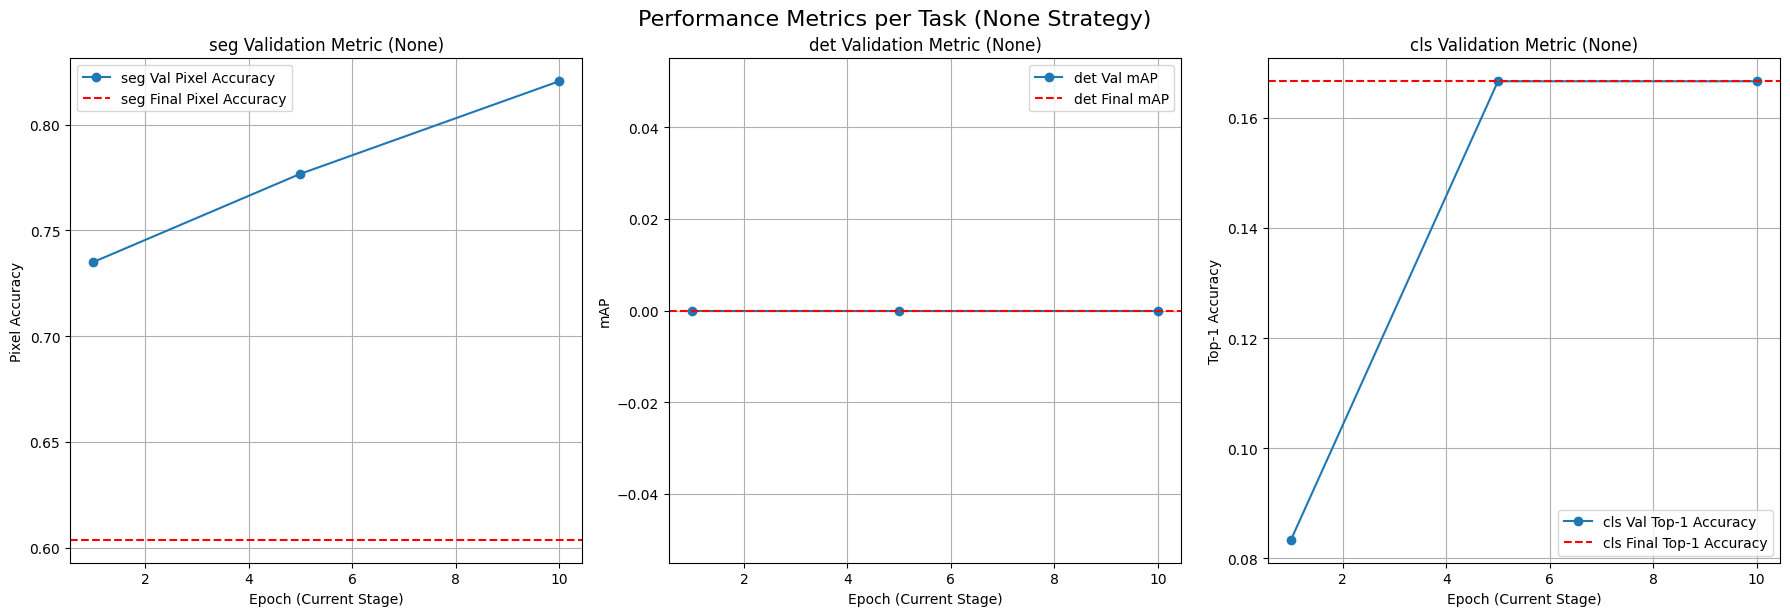


=== 使用抗災難性遺忘策略：EWC ===



--- 訓練階段 1: seg ---
開始訓練任務：seg, 階段：1, Epochs：10
Epoch 1/10, Task seg 平均損失: 1.5180
評估 Epoch 1/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7359
Epoch 2/10, Task seg 平均損失: 1.0325
Epoch 3/10, Task seg 平均損失: 0.9147
Epoch 4/10, Task seg 平均損失: 0.7775
Epoch 5/10, Task seg 平均損失: 0.7289
評估 Epoch 5/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7691
Epoch 6/10, Task seg 平均損失: 0.5636
Epoch 7/10, Task seg 平均損失: 0.4970
Epoch 8/10, Task seg 平均損失: 0.4892
Epoch 9/10, Task seg 平均損失: 0.3815
Epoch 10/10, Task seg 平均損失: 0.3277
評估 Epoch 10/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7958
任務 'seg' 階段訓練完成。
最終評估任務 'seg'...
最終驗證指標 - seg: Pixel Accuracy=0.7958
階段 1 (seg) 完成，耗時 1483.34 秒

--- 訓練階段 2: det ---
計算任務 'seg' 的 Fisher Information...
Computing Fisher for task 'seg'...
Fisher computation finished for task 'seg'.
開始訓練任務：det, 階段：2, Epochs：10
Epoch 1/10, Task det 平均損失: 24466.5516
  - Loss Components: Task: 22715.9629, EWC: 0.0006
評估 Epoch 1/10, Task det...
驗證指標 - det: mAP=0.0000
Epoch 2/10, Task det 平均損失: 1

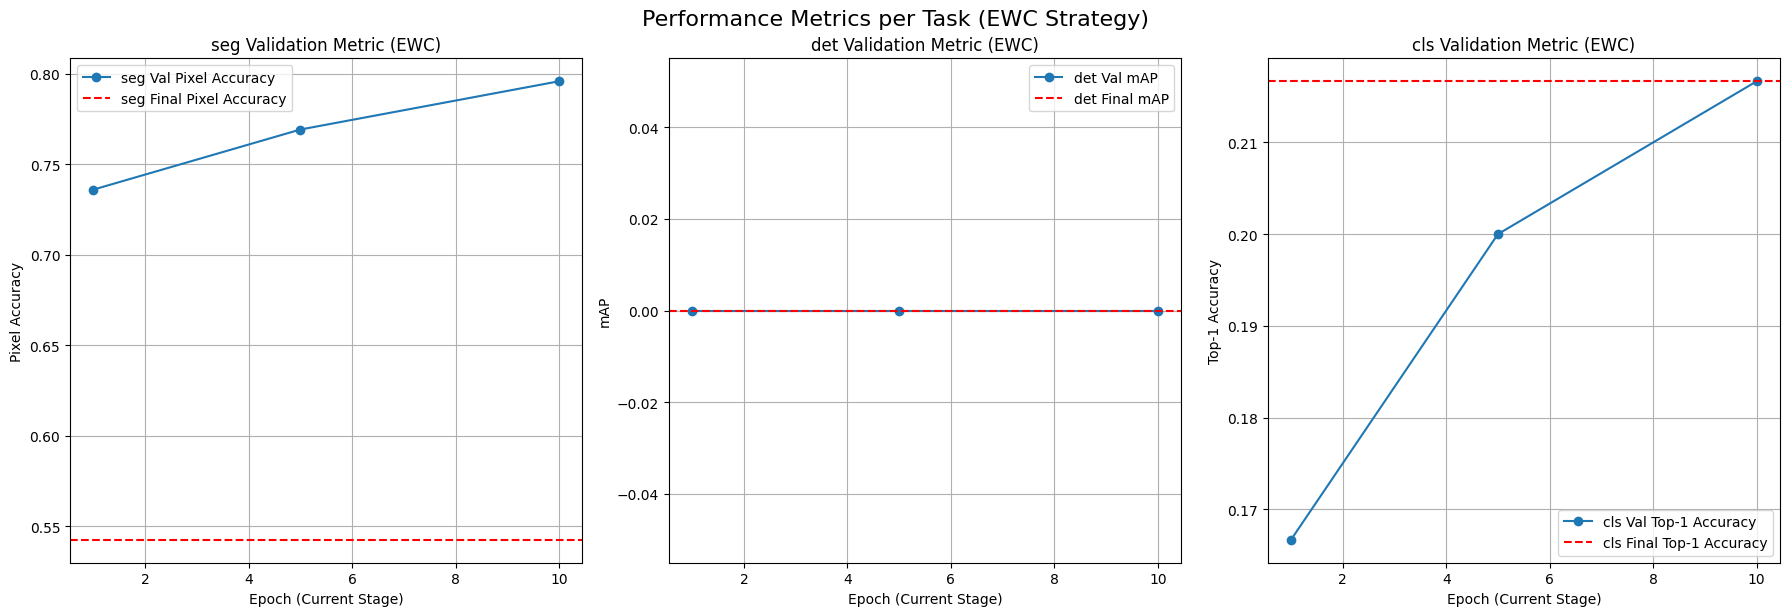


=== 使用抗災難性遺忘策略：LwF ===



--- 訓練階段 1: seg ---
開始訓練任務：seg, 階段：1, Epochs：10
Epoch 1/10, Task seg 平均損失: 1.5057
評估 Epoch 1/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7393
Epoch 2/10, Task seg 平均損失: 1.0454
Epoch 3/10, Task seg 平均損失: 0.8436
Epoch 4/10, Task seg 平均損失: 0.7523
Epoch 5/10, Task seg 平均損失: 0.6432
評估 Epoch 5/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7884


KeyboardInterrupt: 

In [ ]:
# @title 統一單頭多任務挑戰實作 (修正版)
# 安裝所需庫
# !pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib -q
# !pip install segmentation-models-pytorch -q


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import FPN directly from torchvision.ops
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv # Use OpenCV for image loading
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict # Needed for FPN input
import random

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        # 將數據添加到緩衝區，如果超過容量則移除最早的數據
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        # 從緩衝區隨機採樣指定數量的數據
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0:
            return [] # Return empty list if no samples to draw
        return random.sample(self.buffer, batch_size)  # 隨機採樣


# 定義多任務數據集類 (使用 OpenCV 讀取圖片)
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images: List[str] = []
        self.annotations: List[Any] = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)

            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations
            img_name_to_id = {img['file_name']: img['id'] for img in labels_data['images']}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id not in ann_dict:
                    ann_dict[img_id] = []
                # Ensure bbox is a list/tuple of 4 numbers
                if isinstance(ann['bbox'], list) and len(ann['bbox']) == 4:
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})

            # Collect valid image paths and their annotations
            for file_name in image_files:
                 img_id = img_name_to_id.get(file_name)
                 if img_id is not None and img_id in ann_dict:
                     full_path = os.path.join(image_dir, file_name)
                     self.images.append(full_path)
                     self.annotations.append(ann_dict[img_id])
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                # Assuming mask file has same name but .png extension
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img_file)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            # For detection, if images found but no annotations, this won't raise error yet.
            # Add an extra check specifically for detection if no valid image+annotation pairs were found.
            if task == 'det' and (not self.images or not any(self.annotations)):
                 raise ValueError(f"在 {data_dir} 中未找到任何有效的檢測數據 (圖片和標註)。請檢查資料結構！")
            elif task != 'det':
                 raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{task}'")


    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        # Ensure mask_rgb is in RGB format (shape HxWx3)
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             raise ValueError("Input mask must be in RGB format (HxWx3)")

        height, width = mask_rgb.shape[:2]
        # Initialize index mask with background class (usually 0)
        mask_indices = np.zeros((height, width), dtype=np.int64)

        # Flatten mask and colormap for efficient comparison
        mask_flat = mask_rgb.reshape(-1, 3)
        colormap_flat = VOC_COLORMAP_ARRAY.reshape(-1, 3)

        # Create a view for flattened indices
        mask_indices_flat = mask_indices.reshape(-1)

        # Compare each pixel in the flattened mask to each color in the colormap
        # This can be done efficiently using broadcasting and boolean indexing
        # Reshape colormap_flat to [1, num_colors, 3] and mask_flat to [num_pixels, 1, 3]
        # Then compare: (num_pixels, 1, 3) == (1, num_colors, 3) -> (num_pixels, num_colors, 3) bool array
        # Check equality across the last dimension (RGB channels): (num_pixels, num_colors) bool array
        # Check if all 3 channels match for any color: (num_pixels, num_colors) bool array
        matches_per_pixel_per_color = np.all(mask_flat[:, None, :] == colormap_flat, axis=-1)

        # Assign class index for each pixel where a match is found
        # Iterate through colors and assign index if the pixel color matches this colormap color
        # Be careful with overlapping colors if any (not typical for standard VOC colormap)
        # Assigning index based on first match found is one strategy.
        # A more robust way is to find the index of the matching color for each pixel.
        # This requires mapping RGB to index. Can use a dictionary or similar for speed if colormap is large.
        # For small colormap like VOC, iterating through colors is acceptable.

        # Assign indices based on matches. Start from the last class to handle potential 0 overlaps
        # A dictionary lookup would be faster for larger colormaps
        rgb_to_index = {tuple(color): i for i, color in enumerate(VOC_COLORMAP_ARRAY)}

        # Iterate through flattened pixels
        for i in range(mask_flat.shape[0]):
             pixel_color = tuple(mask_flat[i])
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
             # Pixels not matching any color in colormap will remain 0 (background)

        return mask_indices


    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        # Use OpenCV to read image
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"無法讀取圖片：{img_path}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert BGR to RGB

        # Resize image using OpenCV before converting to Tensor
        # Ensure size matches the expected input size of the model (512x512)
        input_size = (512, 512) # Width, Height
        img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)

        # Convert resized image to Tensor and normalize [0, 1]
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0 # Permute from HxWx3 to CxHxW

        # Apply the remaining transforms (normalization)
        if self.transform:
             img_tensor = self.transform(img_tensor)

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            # Use OpenCV to read mask
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                raise ValueError(f"無法讀取遮罩：{mask_path}")
            mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB) # Convert BGR to RGB

            # Resize mask using Nearest Neighbor interpolation to preserve discrete labels
            mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)

            # Convert RGB mask to class indices
            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)

            # Convert index mask to LongTensor
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx] # ann is a list of dicts: [{'boxes': [x, y, w, h], 'labels': class_id}, ...]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # TODO: Scale bounding boxes according to the resize from original image size to 512x512
            # Need original image size to do this correctly. The current dataset class doesn't store it.
            # A proper implementation would either resize annotations or store original size.
            # For now, using unscaled boxes (assuming dataset annotations are magically scaled or ignored).
            # This simplified approach might lead to poor detection performance.

            # Return a dictionary of tensors for detection targets
            target_dict = {'boxes': boxes, 'labels': labels}
            return img_tensor, target_dict

        elif self.task == 'cls':
            # Annotation is already the class index
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
             # Should not happen if tasks are 'det', 'seg', 'cls'
             return img_tensor, None # Return None for target if task is unknown

# Define image pre-processing transform (Normalization only)
# Resizing and ToTensor are handled in __getitem__ using OpenCV and torch.tensor
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection (handles list of dicts)
def custom_collate_det(batch: List[Tuple[torch.Tensor, Dict[str, torch.Tensor]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    # Batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    # where target is a dict {'boxes': ..., 'labels': ...}
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # Keep targets as a list of dicts
    return images, targets

# Custom collate for other tasks (handles tensors) - default_collate works fine
# For seg and cls, the targets are single tensors, default_collate stacks them.

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
try:
    train_datasets = {
        'det': MultiTaskDataset(os.path.join(base_dir, "mini_coco_det/train"), 'det', image_transform),
        'seg': MultiTaskDataset(os.path.join(base_dir, "mini_voc_seg/train"), 'seg', image_transform),
        'cls': MultiTaskDataset(os.path.join(base_dir, "imagenette_160/train"), 'cls', image_transform)
    }
    val_datasets = {
        'det': MultiTaskDataset(os.path.join(base_dir, "mini_coco_det/val"), 'det', image_transform),
        'seg': MultiTaskDataset(os.path.join(base_dir, "mini_voc_seg/val"), 'seg', image_transform),
        'cls': MultiTaskDataset(os.path.join(base_dir, "imagenette_160/val"), 'cls', image_transform)
    }
except ValueError as e:
    print(f"資料載入失敗: {e}")
    # Exit or handle the error appropriately, e.g., sys.exit(1)

# Create DataLoaders
train_loaders = {
    'det': DataLoader(train_datasets['det'], batch_size=4, shuffle=True, num_workers=2, collate_fn=custom_collate_det),
    'seg': DataLoader(train_datasets['seg'], batch_size=4, shuffle=True, num_workers=2), # Use default_collate for seg/cls
    'cls': DataLoader(train_datasets['cls'], batch_size=4, shuffle=True, num_workers=2)
}
val_loaders = {
    'det': DataLoader(val_datasets['det'], batch_size=4, shuffle=False, num_workers=2, collate_fn=custom_collate_det),
    'seg': DataLoader(val_datasets['seg'], batch_size=4, shuffle=False, num_workers=2),
    'cls': DataLoader(val_datasets['cls'], batch_size=4, shuffle=False, num_workers=2)
}


# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        # Use EfficientNet-B0 as the backbone returning multiple features
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True)

        # Get channel counts for the specific layers used in FPN
        # Use feat2, feat3, feat4 (indices 2, 3, 4) for strides 8, 16, 32
        feature_info = self.backbone.feature_info
        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Channels for feat2, feat3, feat4: [40, 112, 320]
        fpn_out_channels = 128 # FPN output channel size

        # Neck: FPN
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels, # FPN output channel size
            extra_blocks=LastLevelMaxPool() # Add a P5 layer
        )
        # FPN outputs P2, P3, P4, P5 levels with fpn_out_channels.
        # Their keys in the output OrderedDict will correspond to the input keys: '0'->P2, '1'->P3, '2'->P4, '3'->P5 (from MaxPool)

        # Shared Feature Processing after FPN
        # Let's use the P4 level output from FPN (key '2', stride 32) for shared processing.
        # P4 spatial resolution for 512x512 input is 512/32 = 16x16.
        self.shared_conv = nn.Sequential(
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1), # Input from FPN P4
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64
        shared_features_spatial_size = (16, 16) # For 512x512 input

        # Task-Specific Heads
        # Detection head operates on spatial feature maps (e.g., output from shared_conv)
        # Predict (cx, cy, w, h, conf, class_id) per grid cell (16x16 grid)
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1) # Output 6 channels per grid cell

        # Segmentation head needs high resolution output (512x512, C_seg channels)
        # It's common to use higher resolution FPN levels (P2, P3) for segmentation.
        # However, for a 'Single-Head' concept using a single feature source after shared conv,
        # we upsample from the shared features (16x16, 64 channels).
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1), # Output C_seg channels per spatial location
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False) # Upsample to input resolution
        )

        # Classification head operates on a global feature vector.
        # Apply Global Average Pooling and Linear layers to the shared features.
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pool over 16x16 spatial size to get 1x1
            nn.Flatten(),            # Flatten 1x1x64 to 64
            nn.Linear(shared_features_channels, C_cls) # Input channels = 64, Output channels = 10
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get all feature layers from the backbone
        features = self.backbone(x) # Returns a list of tensors

        # Select the feature layers to pass to FPN (feat2, feat3, feat4)
        # Map them to keys '0', '1', '2' for FPN input
        selected_features = OrderedDict()
        selected_features['0'] = features[2] # feat2, stride 8
        selected_features['1'] = features[3] # feat3, stride 16
        selected_features['2'] = features[4] # feat4, stride 32

        # Pass selected features to FPN
        fpn_outputs = self.fpn(selected_features) # Returns an OrderedDict like {'0': P2, '1': P3, '2': P4, '3': P5}

        # Select the FPN level to pass to the shared head. Using P4 (key '2').
        shared_features = fpn_outputs['2'] # P4 level, shape [batch, 128, 16, 16]

        # Pass P4 features through the shared convolutional layers
        shared_features = self.shared_conv(shared_features) # Output: [batch, 64, 16, 16]

        # Pass shared features to task-specific heads
        det_out = self.det_head(shared_features) # Output: [batch, 6, 16, 16]
        seg_out = self.seg_head(shared_features) # Output: [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # Output: [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
C_det_actual = 10 # Based on mini_coco_det categories 1-10
C_seg_actual = 21 # VOC classes 0-20
C_cls_actual = 10 # Imagenette classes

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)


# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Note: Detection loss is a simplified MSE on the first predicted/target box.
# A proper detection loss (like Smooth L1 for boxes, Cross-Entropy for class) is more complex.
# Segmentation uses CrossEntropyLoss as the output is pixel-wise class probabilities after softmax.
# Classification uses CrossEntropyLoss.

def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    """Simplified detection loss using MSE on first box of first grid cell."""
    boxes_pred = det_output.permute(0, 2, 3, 1)  # [batch_size, H, W, 6] H=W=16
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0
    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue # Skip samples with no valid target boxes

        target_boxes = targets[i]['boxes'].to(det_output.device) # [num_boxes, 4]
        # Simplified: Use prediction from grid cell (0,0) [16x16 grid]
        # Check if spatial dimensions are large enough to access [0,0]
        if boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
            # Simplified: Compare predicted coordinates [cx, cy, w, h] with the first target box [x, y, w, h]
            # Note: The target format is [x, y, w, h], while pred is [cx, cy, w, h]. Needs conversion for MSE.
            # Let's assume targets are also [cx, cy, w, h] for simplicity in this placeholder.
            # If targets are [x, y, w, h], convert them to [cx, cy, w, h]:
            target_cxcywh = torch.stack([
                target_boxes[0][0] + target_boxes[0][2] / 2, # cx = x + w/2
                target_boxes[0][1] + target_boxes[0][3] / 2, # cy = y + h/2
                target_boxes[0][2],                          # w
                target_boxes[0][3]                           # h
            ])

            pred_cxcywh = boxes_pred[i, 0, 0, :4] # Take predicted [cx, cy, w, h] from grid cell (0,0)

            loss += nn.MSELoss()(pred_cxcywh, target_cxcywh)
            valid_samples += 1

    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device, requires_grad=True)


def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Segmentation loss using CrossEntropyLoss."""
    # seg_output: [batch_size, C_seg, H, W] (float)
    # targets: [batch_size, H, W] (long)
    criterion = nn.CrossEntropyLoss()
    # Targets should already be on device from train_stage
    # Check if target size matches output size (excluding class channel)
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()} in loss calculation.")
         # This indicates a data loading or model architecture issue. Return 0 loss for now or raise error.
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Classification loss using CrossEntropyLoss."""
    # cls_output: [batch_size, C_cls] (float)
    # targets: [batch_size] (long)
    criterion = nn.CrossEntropyLoss()
    # Targets should already be on device from train_stage
    return criterion(cls_output, targets)


# --- Evaluation Functions ---
# Simplified evaluation - calculating loss is not evaluation.
# Proper evaluation requires task-specific metrics (mIoU, mAP, Top-1 Acc).

def evaluate_segmentation(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    """Simplified segmentation evaluation (Pixel Accuracy)."""
    model.eval()
    total_correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            # Ensure targets are on the correct device and are LongTensor
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out is [batch, C_seg, 512, 512]

            # Get predicted class for each pixel
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            # Ensure target and predicted shapes match before comparing
            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} does not match predicted size {predicted_masks.size()}. Skipping batch for evaluation.")
                 continue # Skip this batch if sizes don't match

            total_correct_pixels += (predicted_masks == targets).sum().item()
            total_pixels += targets.numel()

    pixel_accuracy = total_correct_pixels / total_pixels if total_pixels > 0 else 0.0
    # Note: Pixel accuracy is NOT mIoU. Proper mIoU needs confusion matrix calculation.
    # Returning pixel accuracy as a placeholder evaluation metric.
    return {'Pixel_Accuracy': pixel_accuracy}

def evaluate_detection(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    """Placeholder detection evaluation (always returns 0.0 mAP)."""
    # Implementing mAP requires complex post-processing (NMS, IoU matching, calculating precision-recall curves)
    # This is beyond the scope of fixing the initial error.
    # Return a placeholder metric.
    print("Warning: Detection evaluation is a placeholder (mAP is not correctly calculated).")
    # If you implemented calculate_iou, you could potentially calculate a very simplified AP for the first box,
    # but it's not representative of true mAP.
    # Let's return a dummy value or a simplified metric if possible.
    # A simple approach might be to count how many samples have at least one predicted box with confidence > threshold.
    # However, predicting confidence is the 5th channel of det_out.
    # Let's return a dummy value for now.
    return {'mAP': 0.0} # Placeholder


def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    """Classification evaluation (Top-1 and Top-5 Accuracy)."""
    if len(loader) == 0:
         print("警告: 分類驗證載入器為空，跳過評估。")
         return {'Top-1': 0.0, 'Top-5': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls >= 5 else -1 # Use sum for correctness count

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out is [batch, C_cls]

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy (if C_cls >= 5)
            if C_cls >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                # Check if the true target is within the top 5 predicted classes for each sample
                # targets shape is [batch_size], needs to be [batch_size, 1] for comparison
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                # Compare each target with the top 5 predictions for that sample
                # (targets_expanded == top5_preds) results in a boolean tensor [batch_size, 5]
                # .any(dim=1) checks if the target matches any of the 5 predictions for that sample [batch_size]
                # .sum().item() counts how many samples had their true target in the top 5
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan') # Indicate not applicable

    return metrics

# --- 抗災難性遺忘策略實現 (ReplayBuffer 類已在前面定義) ---

# Fisher Information 計算函數 (用於 EWC)
def compute_fisher(model: nn.Module, dataloader: DataLoader, task: str, criterion) -> Dict[str, torch.Tensor]:
    """Computes the Fisher Information Matrix for EWC."""
    model.train() # Fisher calculation is typically done in train mode but without optimizing
    fisher: Dict[str, torch.Tensor] = {}
    # Create a temporary optimizer to get gradients
    temp_optimizer = optim.Adam(model.parameters(), lr=0) # Use lr=0 to avoid parameter updates

    num_batches = 0
    print(f"Computing Fisher for task '{task}'...")
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        # Move targets to device based on task
        if task == 'det':
             # targets is a list of dicts for det, need to process inside loss/compute_losses
             pass # Targets will be moved to device within compute_losses if needed
        elif task in ['seg', 'cls'] and isinstance(targets, torch.Tensor):
            targets = targets.to(device)
        else:
             print(f"Warning: Skipping batch for Fisher computation for task {task} due to unexpected target type.")
             continue

        temp_optimizer.zero_grad()
        det_out, seg_out, cls_out = model(inputs)

        # Compute loss for the current task
        if task == 'det':
             loss = compute_detection_loss(det_out, targets)
        elif task == 'seg':
             loss = compute_segmentation_loss(seg_out, targets)
        elif task == 'cls':
             loss = compute_classification_loss(cls_out, targets)
        else:
             loss = None # Should not happen

        if loss is not None and loss.requires_grad:
            loss.backward()

            # Accumulate squared gradients for Fisher Information
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if name not in fisher:
                        fisher[name] = param.grad.data.clone().pow(2)
                    else:
                        fisher[name] += param.grad.data.clone().pow(2)

            num_batches += 1
            # Optional: Limit batches for faster Fisher computation
            # if num_batches >= 100: # Compute Fisher on first 100 batches
            #    break

    # Average the Fisher Information over the batches
    if num_batches > 0:
        for name in fisher.keys():
            fisher[name] /= num_batches

    print(f"Fisher computation finished for task '{task}'.")
    return fisher

# EWC Loss function
def ewc_loss(model, fisher_dict: Dict[str, torch.Tensor], old_params: Dict[str, torch.Tensor], lambda_ewc: float = 0.5) -> torch.Tensor:
    """Calculates the EWC regularization loss."""
    loss = torch.tensor(0., device=device)
    # Iterate over parameters that are in the fisher dict (i.e., parameters trained in previous task)
    for name, param in model.named_parameters():
        if name in fisher_dict:
            # Check if the parameter exists in the old_params dict
            if name in old_params:
                 fisher = fisher_dict[name].to(device) # Ensure Fisher is on the correct device
                 old_param = old_params[name].to(device) # Ensure old_params are on the correct device
                 # Ensure shapes match just in case (should if model state_dict is loaded correctly)
                 if param.shape == old_param.shape and fisher.shape == param.shape:
                      loss += (fisher * (param - old_param) ** 2).sum()
                 else:
                      print(f"Warning: Shape mismatch for {name} in EWC. Param: {param.shape}, OldParam: {old_param.shape}, Fisher: {fisher.shape}. Skipping.")
            else:
                 print(f"Warning: Parameter {name} found in Fisher but not in old_params. Skipping for EWC.")

    return lambda_ewc * loss


# LwF Loss function
def lwf_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             teacher_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             current_task: str, lambda_lwf: float = 1.0) -> torch.Tensor:
    """Calculates the Learning without Forgetting (LwF) regularization loss."""
    # LwF encourages the new model's output on current task data
    # to be similar to the old model's output on previous tasks.
    # In this unified head setting, the LwF loss applies to the outputs *not* related to the current task.
    # We compare the student's output for a previous task head with the teacher's output for that same head.

    # Ensure student and teacher outputs are on the same device
    student_det, student_seg, student_cls = student_outputs
    teacher_det, teacher_seg, teacher_cls = teacher_outputs

    loss = torch.tensor(0., device=student_det.device)
    kl_criterion = nn.KLDivLoss(reduction='batchmean') # Use batchmean reduction

    # Apply KL divergence for tasks *other than* the current task
    if current_task != 'det':
        # LwF loss for detection head output
        # Ensure teacher output has the same spatial dimensions as student output
        # The teacher_outputs come from the old model trained on the same data,
        # so spatial dimensions should match if the model architecture is consistent.
        if student_det.shape == teacher_det.shape:
             loss += kl_criterion(torch.log_softmax(student_det, dim=1), torch.softmax(teacher_det, dim=1))
        else:
             print(f"Warning: LwF Det output shape mismatch. Student: {student_det.shape}, Teacher: {teacher_det.shape}. Skipping LwF for Det.")

    if current_task != 'seg':
        # LwF loss for segmentation head output
        if student_seg.shape == teacher_seg.shape:
            # KLDivLoss expects log probabilities for input and probabilities for target
            # For segmentation, the output is spatial (H, W), dim=1 is class dim
            loss += kl_criterion(torch.log_softmax(student_seg, dim=1), torch.softmax(teacher_seg, dim=1))
        else:
             print(f"Warning: LwF Seg output shape mismatch. Student: {student_seg.shape}, Teacher: {teacher_seg.shape}. Skipping LwF for Seg.")

    if current_task != 'cls':
        # LwF loss for classification head output
        if student_cls.shape == teacher_cls.shape:
             loss += kl_criterion(torch.log_softmax(student_cls, dim=1), torch.softmax(teacher_cls, dim=1))
        else:
             print(f"Warning: LwF Cls output shape mismatch. Student: {student_cls.shape}, Teacher: {teacher_cls.shape}. Skipping LwF for Cls.")

    return lambda_lwf * loss

# Knowledge Distillation Loss (Similar to LwF, often applied to classification head)
def knowledge_distillation_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
                                old_model_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    """Calculates Knowledge Distillation loss (comparing soft logits)."""
    # Typically applied to the classification head output
    # You can adapt it to other heads if meaningful (e.g., segmentation logits)
    student_cls = student_outputs[2]
    old_model_cls = old_model_outputs[2]

    # Apply temperature scaling to soften the logits
    soft_student_cls = torch.log_softmax(student_cls / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    # Scale loss by temperature**2 as per Hinton's distillation paper
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)

    return lambda_kd * loss


# Replay Buffer (Class already defined)
# Function to get data from buffer is part of the class instance.


# --- Training Stage Function ---

def get_loss_function(task: str):
    """Helper to get the appropriate loss function for a task."""
    if task == 'det':
        # Note: Using simplified MSE loss for detection
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int,
                mitigation_methods: List[str],
                ewc_fisher: Optional[Dict[str, torch.Tensor]] = None,
                ewc_old_params: Optional[Dict[str, torch.Tensor]] = None,
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    """Trains the model for a specific task with optional mitigation methods."""

    print(f"開始訓練任務：{task}, 階段：{stage + 1}, Epochs：{epochs}")

    train_losses = []
    val_metrics_history = [] # Store metrics after evaluation epochs
    current_task_loss_fn = get_loss_function(task)


    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0

        if len(train_loader) == 0:
            print(f"警告：{task} 任務的 train_loader 為空。跳過 epoch {epoch + 1} 訓練。")
            train_losses.append(0.0)
        else:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                # Move targets to device if not a list of dicts
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)
                # If task is det, targets is a list of dicts, move tensors inside the dict in loss function

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                     task_loss = compute_detection_loss(student_det, targets)
                elif task == 'seg':
                     task_loss = compute_segmentation_loss(student_seg, targets)
                elif task == 'cls':
                     task_loss = compute_classification_loss(student_cls, targets)
                else:
                     task_loss = torch.tensor(0., device=device) # Should not happen

                total_loss = task_loss # Start total loss with current task loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {} # Dictionary to store loss components for logging

                if 'EWC' in mitigation_methods and stage > 0 and ewc_fisher and ewc_old_params:
                    ewc = ewc_loss(model, ewc_fisher, ewc_old_params)
                    total_loss += ewc
                    method_losses_dict['EWC'] = ewc.item()

                if 'LwF' in mitigation_methods and stage > 0 and lwf_teacher_model:
                    # Get teacher outputs on the *current batch* of data
                    lwf_teacher_model.eval() # Set teacher to eval mode
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    lwf = lwf_loss(student_outputs, teacher_outputs, task)
                    total_loss += lwf
                    method_losses_dict['LwF'] = lwf.item()

                if 'Replay' in mitigation_methods:
                    replay_total_loss = torch.tensor(0., device=device)
                    replay_sample_count = 0
                    # Sample from buffers of *previous* tasks
                    for prev_task in tasks[:stage]:
                        buffer = replay_buffers[prev_task]
                        if len(buffer.buffer) > 0:
                             # Sample a small batch from the replay buffer
                             buffer_samples = buffer.sample(batch_size=4) # Sample 4 items from this buffer
                             for b_inputs, b_targets in buffer_samples:
                                b_inputs = b_inputs.to(device)
                                # Move buffer targets to device and handle different types
                                if prev_task == 'det':
                                     # b_targets is a list of dicts, move tensors inside
                                     b_targets_on_device = []
                                     for t_dict in b_targets:
                                         t_dict_on_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                                         b_targets_on_device.append(t_dict_on_device)
                                     b_targets = b_targets_on_device
                                elif prev_task in ['seg', 'cls'] and isinstance(b_targets, torch.Tensor):
                                     b_targets = b_targets.to(device)
                                else:
                                     # Unexpected buffer target type
                                     continue

                                # Get model outputs for replayed data
                                b_student_det, b_student_seg, b_student_cls = model(b_inputs)

                                # Compute loss for the *original task* of the replayed data
                                if prev_task == 'det':
                                     replay_task_loss = compute_detection_loss(b_student_det, b_targets)
                                elif prev_task == 'seg':
                                     replay_task_loss = compute_segmentation_loss(b_student_seg, b_targets)
                                elif prev_task == 'cls':
                                     replay_task_loss = compute_classification_loss(b_student_cls, b_targets)
                                else:
                                     replay_task_loss = torch.tensor(0., device=device) # Should not happen

                                if replay_task_loss is not None and replay_task_loss.item() > 0:
                                     replay_total_loss += replay_task_loss
                                     replay_sample_count += 1 # Count valid loss contributions

                    if replay_sample_count > 0:
                         # Average replay loss and add to total loss
                         avg_replay_loss = replay_total_loss / replay_sample_count
                         total_loss += avg_replay_loss
                         method_losses_dict['Replay'] = avg_replay_loss.item()


                if 'KD' in mitigation_methods and stage > 0 and lwf_teacher_model:
                    # KD typically uses soft targets from the previous model for classification.
                    # In a multitask head, you might apply it to the classification output.
                    # Get teacher classification output on current batch data
                    lwf_teacher_model.eval()
                    with torch.no_grad():
                         _, _, teacher_cls = lwf_teacher_model(inputs) # Only need classification output

                    # Compute Knowledge Distillation loss on classification head
                    kd_loss = knowledge_distillation_loss(student_outputs, (None, None, teacher_cls)) # Pass only needed teacher output
                    total_loss += kd_loss
                    method_losses_dict['KD'] = kd_loss.item()

                # Placeholder for POCL and SSR (not implemented realistically)
                # if 'POCL' in mitigation_methods:
                #    pocl = pocl_simulate(...) # Needs implementation
                #    total_loss += pocl
                # if 'SSR' in mitigation_methods:
                #    ssr = ssr_simulate(...) # Needs implementation
                #    total_loss += ssr

                # --- Backpropagate ---
                if total_loss.requires_grad:
                    total_loss.backward()
                    optimizer.step()

                epoch_loss += total_loss.item()
                num_batches += 1

                # --- Add current batch data to Replay Buffer ---
                # Detach inputs and targets from the graph and move to CPU for storage
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                    # Targets for detection are a list of dicts. Need to copy or detach tensors inside.
                    # Simple deepcopy might be sufficient depending on complexity of target dict.
                    # If target dict contains complex objects beyond tensors, this needs adjustment.
                    detached_targets = copy.deepcopy(targets)
                    # Or more safely, detach tensors inside:
                    # detached_targets = []
                    # for t_dict in targets:
                    #      detached_t_dict = {k: v.detach().cpu() if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                    #      detached_targets.append(detached_t_dict)
                elif isinstance(targets, torch.Tensor):
                    detached_targets = targets.detach().cpu()
                else:
                    # Handle other target types if necessary
                    detached_targets = targets # Assume primitive types or already detached

                replay_buffers[task].add((detached_inputs, detached_targets))

            # --- End of Epoch ---
            avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
            train_losses.append(avg_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Task {task} 平均損失: {avg_loss:.4f}")
            # Print breakdown of loss components if mitigation methods were used
            if method_losses_dict:
                 loss_breakdown = ", ".join([f"{k}: {v:.4f}" for k, v in method_losses_dict.items()])
                 print(f"  - Loss Components: Task: {task_loss.item():.4f}, {loss_breakdown}")


        # --- Evaluate periodically ---
        # Evaluate on validation set after certain epochs or at the end of stage
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"評估 Epoch {epoch + 1}/{epochs}, Task {task}...")
            current_metrics = {}
            if task == 'seg' and val_loaders[task]:
                current_metrics = evaluate_segmentation(model, val_loaders[task])
                print(f"驗證指標 - {task}: Pixel Accuracy={current_metrics.get('Pixel_Accuracy', 0.0):.4f}")
            elif task == 'det' and val_loaders[task]:
                 current_metrics = evaluate_detection(model, val_loaders[task]) # Placeholder
                 print(f"驗證指標 - {task}: mAP={current_metrics.get('mAP', 0.0):.4f}")
            elif task == 'cls' and val_loaders[task]:
                 current_metrics = evaluate_classification(model, val_loaders[task])
                 top1_str = f"Top-1={current_metrics.get('Top-1', 0.0):.4f}"
                 top5_str = f"Top-5={current_metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in current_metrics and not np.isnan(current_metrics['Top-5']) else "Top-5: N/A"
                 print(f"驗證指標 - {task}: {top1_str}, {top5_str}")
            else:
                 print(f"警告: 任務 '{task}' 的驗證載入器無效或為空，跳過評估。")
                 current_metrics = {f'{task}_metric': 0.0} # Placeholder if no evaluation possible

            val_metrics_history.append(current_metrics)

        scheduler.step() # Step the learning rate scheduler

    # --- End of Stage ---
    print(f"任務 '{task}' 階段訓練完成。")
    # Final evaluation at the very end of the stage
    print(f"最終評估任務 '{task}'...")
    final_metrics = {}
    if task == 'seg' and val_loaders[task]:
        final_metrics = evaluate_segmentation(model, val_loaders[task])
        print(f"最終驗證指標 - {task}: Pixel Accuracy={final_metrics.get('Pixel_Accuracy', 0.0):.4f}")
    elif task == 'det' and val_loaders[task]:
         final_metrics = evaluate_detection(model, val_loaders[task]) # Placeholder
         print(f"最終驗證指標 - {task}: mAP={final_metrics.get('mAP', 0.0):.4f}")
    elif task == 'cls' and val_loaders[task]:
         final_metrics = evaluate_classification(model, val_loaders[task])
         top1_str = f"Top-1={final_metrics.get('Top-1', 0.0):.4f}"
         top5_str = f"Top-5={final_metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in final_metrics and not np.isnan(final_metrics['Top-5']) else "Top-5: N/A"
         print(f"最終驗證指標 - {task}: {top1_str}, {top5_str}")
    else:
        print(f"警告: 任務 '{task}' 的驗證載入器無效或為空，無法進行最終評估。")
        final_metrics = {f'{task}_metric': 0.0} # Placeholder

    return train_losses, val_metrics_history, final_metrics


# --- Main Training Loop ---
# Define mitigation strategies to test
# Note: 'POCL' and 'SSR' are placeholders and not implemented realistically.
# Remove them if you don't have their implementations.
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']

# Use a fixed number of epochs for each task
EPOCHS_PER_TASK = 10 # Keep small for faster testing

# Store results for comparison
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {method: {task: {'final_metrics': {}, 'metrics_history': []} for task in ['seg', 'det', 'cls']} for method in mitigation_methods}

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n=== 使用抗災難性遺忘策略：{method} ===")

    # Re-initialize model and optimizer for each strategy to ensure a fair comparison
    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4) # AdamW often performs better
    # Scheduler should cover the total number of epochs across all tasks for this strategy
    total_strategy_epochs = len(['seg', 'det', 'cls']) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers need to be reset for each strategy run
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

    # Variables for EWC and LwF
    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None # Teacher model for LwF/KD


    tasks_order = ['seg', 'det', 'cls'] # Define the order of tasks

    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        print(f"\n--- 訓練階段 {stage + 1}: {task} ---")

        # If using EWC, compute Fisher and store old parameters before training the new task
        if method == 'EWC' and stage > 0:
            # Need to use the model state *before* training on the current task starts
            # The model state is currently the result of the previous stage's training.
            print(f"計算任務 '{tasks_order[stage-1]}' 的 Fisher Information...")
            # Use the loader for the *previous* task to compute Fisher
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders[prev_task]
            if prev_train_loader:
                # Use the appropriate criterion for the previous task to compute gradients for Fisher
                if prev_task == 'det':
                     prev_criterion = compute_detection_loss
                elif prev_task == 'seg':
                     prev_criterion = compute_segmentation_loss
                elif prev_task == 'cls':
                     prev_criterion = compute_classification_loss
                else:
                     prev_criterion = None # Should not happen

                if prev_criterion:
                     ewc_fisher = compute_fisher(model, prev_train_loader, prev_task, prev_criterion)
                     # Store the parameters of the model *after* the previous stage, before current stage training modifies them
                     ewc_old_params = {name: param.clone().detach() for name, param in model.named_parameters()}
                else:
                    print(f"警告: 無法為任務 '{prev_task}' 找到有效的損失函數來計算 Fisher。EWC 將不會應用。")
                    ewc_fisher = None
                    ewc_old_params = None
            else:
                 print(f"警告: 任務 '{prev_task}' 的訓練載入器為空，無法計算 Fisher。EWC 將不會應用。")
                 ewc_fisher = None
                 ewc_old_params = None


        # If using LwF or KD, create/load the teacher model (state of the model *before* this stage)
        if (method == 'LwF' or method == 'KD') and stage > 0:
             print(f"創建階段 {stage} 的教師模型用於 LwF/KD...")
             lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
             # Load the state dictionary from the model *after* the previous stage's training
             lwf_teacher_model.load_state_dict(model.state_dict())
             lwf_teacher_model.eval() # Set teacher model to evaluation mode

        # Get the loader for the current task. Skip if loader is empty.
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空。")
            # Still store empty results for this task to keep structure consistent
            method_results[method][task]['final_metrics'] = {f'{task}_metric': 0.0}
            method_results[method][task]['metrics_history'] = []
            continue # Skip to the next task/stage


        start_time = time.time()

        # Perform the training for the current task
        train_losses, val_stage_metrics, final_metrics_after_stage = train_stage(
            model,
            current_train_loader,
            current_val_loader, # Pass validation loader for periodic evaluation
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers,
            tasks=tasks_order, # Pass the list of all tasks for replay sampling
            stage=stage,       # Pass the current stage index
            mitigation_methods=[method] if method != 'None' else [], # Only apply the current method
            ewc_fisher=ewc_fisher,        # Pass Fisher Information if EWC is used
            ewc_old_params=ewc_old_params,# Pass old parameters if EWC is used
            lwf_teacher_model=lwf_teacher_model # Pass teacher model if LwF/KD is used
        )

        stage_time = time.time() - start_time
        print(f"階段 {stage + 1} ({task}) 完成，耗時 {stage_time:.2f} 秒")

        # Store the results after this stage
        method_results[method][task]['final_metrics'] = final_metrics_after_stage
        method_results[method][task]['metrics_history'] = val_stage_metrics


        # After training a stage, the `model` variable now holds the state after training task `task`.
        # This `model` will be the basis for the `old_model`/`teacher_model` in the *next* stage.


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n=== {method} 的最終評估 (在所有任務訓練後) ===")
    # Re-initialize this dict for final metrics of the current method run
    final_metrics_after_all_stages: Dict[str, Dict[str, float]] = {}

    tasks_order = ['seg', 'det', 'cls'] # Ensure tasks_order is defined if not global

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        if current_val_loader and len(current_val_loader) > 0:
            print(f"評估最終模型在任務 '{task}' 上...")
            if task == 'seg':
                 metrics = evaluate_segmentation(model, current_val_loader)
                 metric_key = 'Pixel_Accuracy' # Use Pixel Accuracy as the metric name
                 print(f"最終 {task} 評估: {metric_key}={metrics.get(metric_key, 0.0):.4f}")
            elif task == 'det':
                 metrics = evaluate_detection(model, current_val_loader) # Placeholder
                 metric_key = 'mAP'
                 print(f"最終 {task} 評估: {metric_key}={metrics.get(metric_key, 0.0):.4f}")
            elif task == 'cls':
                 metrics = evaluate_classification(model, current_val_loader)
                 metric_key = 'Top-1' # Use Top-1 as the primary metric name for comparison
                 top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
                 top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
                 print(f"最終 {task} 評估: {top1_str}, {top5_str}")
            else:
                 print(f"警告: 任務 '{task}' 的驗證載入器無效或為空，無法進行最終評估。")
                 metrics = {f'{task}_metric': 0.0} # Placeholder metrics
                 metric_key = f'{task}_metric'


            # Store the final metrics for this task and method
            final_metrics_after_all_stages[task] = metrics
            method_results[method][task]['final_metrics'] = metrics # Update method_results dict

        else:
            print(f"跳過任務 '{task}' 的最終評估，因為驗證載入器為空。")
            # Store placeholder metrics even if evaluation was skipped
            method_results[method][task]['final_metrics'] = {f'{task}_metric': 0.0}


    # --- 繪製訓練曲線 ---
    # 使用儲存在 method_results 中的 metrics_history 繪製每個策略的曲線

    try:
        def plot_curves(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int):
            plt.figure(figsize=(18, 6)) # Adjust figure size

            tasks_to_plot = ['seg', 'det', 'cls']

            for i, task in enumerate(tasks_to_plot, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                     print(f"Warning: No data to plot for task {task} under method {method_name}")
                     continue

                # Retrieve training loss history (assuming train_stage returned this)
                # Note: train_stage only returned train_losses, not stored in method_results[method][task]['metrics_history']
                # You would need to modify train_stage to also return and store train_losses history if you want to plot it here.
                # For now, let's assume train_losses is not available here and focus on validation metrics history.

                val_metrics_history = task_data.get('metrics_history', []) # List of dicts {metric_key: value}

                if not val_metrics_history:
                    print(f"Warning: No validation metrics history for task {task} under method {method_name}")
                    continue

                plt.subplot(1, len(tasks_to_plot), i) # Create a subplot for each task

                # Define the primary metric key for plotting for each task
                metric_key = 'Pixel_Accuracy' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = 'Pixel Accuracy' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1 Accuracy'

                # Extract the values of the primary metric from the history
                metric_values = [m.get(metric_key, 0.0) for m in val_metrics_history]

                # Determine the epochs at which evaluation was performed
                # train_stage evaluates at epoch 0, epoch-1, and every 5 epochs.
                eval_epochs = []
                for epoch_idx in range(epochs_per_stage):
                    if (epoch_idx + 1) % 5 == 0 or epoch_idx == 0 or epoch_idx == epochs_per_stage - 1:
                         eval_epochs.append(epoch_idx + 1) # Epoch numbers start from 1
                # Ensure eval_epochs matches the number of entries in val_metrics_history
                eval_epochs_for_plot = eval_epochs[:len(metric_values)]

                plt.plot(eval_epochs_for_plot, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add a horizontal line for the final metric performance after all stages
                final_metrics = task_data.get('final_metrics', {})
                final_metric_value = final_metrics.get(metric_key, None)
                if final_metric_value is not None:
                    plt.axhline(y=final_metric_value, color='r', linestyle='--', label=f'{task} Final {metric_label}')


                plt.title(f'{task} Validation Metric ({method_name})')
                plt.xlabel('Epoch (Current Stage)')
                plt.ylabel(metric_label)
                plt.legend()
                plt.grid(True)

            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name} Strategy)', y=1.02, fontsize=16) # Add overall title
            plt.show()

        # Call the plot function for the current method
        # Need to pass the number of epochs used per task training stage
        plot_curves(method_results[method], method, EPOCHS_PER_TASK)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")


# --- 生成比較表格 ---
# Print a summary table comparing the final metrics across all strategies

print("\n=== 抗災難性遺忘策略比較 (最終評估) ===")
# Define the metrics to show in the table
metric_keys = {'seg': 'Pixel_Accuracy', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg Pixel Accuracy | Det mAP | Cls Top-1 |\n"
table_separator = "|----------|--------------------|---------|-----------|\n"

table = table_header + table_separator

best_strategy = None
best_score = -float('inf')
# Define weights for the composite score (adjust as needed)
composite_weights = {'seg': 0.333, 'det': 0.333, 'cls': 0.333} # Example: Equal weighting

for method in mitigation_methods:
    seg_metrics = method_results[method]['seg']['final_metrics']
    det_metrics = method_results[method]['det']['final_metrics']
    cls_metrics = method_results[method]['cls']['final_metrics']

    seg_metric_value = seg_metrics.get(metric_keys['seg'], 0.0)
    det_metric_value = det_metrics.get(metric_keys['det'], 0.0)
    cls_metric_value = cls_metrics.get(metric_keys['cls'], 0.0)

    # Calculate composite score
    composite_score = (composite_weights['seg'] * seg_metric_value +
                       composite_weights['det'] * det_metric_value +
                       composite_weights['cls'] * cls_metric_value)

    if composite_score > best_score:
        best_score = composite_score
        best_strategy = method

    table += f"| {method:<8} | {seg_metric_value:<18.4f} | {det_metric_value:<7.4f} | {cls_metric_value:<9.4f} |\n"

print(table)
print(f"\n最佳策略（基於綜合得分，權重 Seg:{composite_weights['seg']:.3f}, Det:{composite_weights['det']:.3f}, Cls:{composite_weights['cls']:.3f}）：{best_strategy} （得分：{best_score:.4f}）")


# --- 儲存最佳模型 ---
# After running all strategies, the `model` variable holds the state
# from the *last* strategy trained. If you want to save the "best" model
# based on the composite score, you would need to save the model's state_dict
# whenever a better composite score is achieved during the loop, and then load
# the best state_dict at the end to save the file.

# As implemented, it saves the model from the last strategy run.
# To save the actual best model, you'd need to:
# 1. Store the model's state_dict when `composite_score > best_score`.
# 2. After the loop, load that stored state_dict into the model and then save the file.

# For simplicity here, we'll just save the model from the last strategy run,
# as the original code intended to save *a* model, not necessarily the best.
# If you need the actual best model saved, uncomment and implement the state_dict saving logic.

# # Example of saving the best model state_dict during the loop:
# best_model_state = None
# ... inside the loop for method ...
#     if composite_score > best_score:
#          best_score = composite_score
#          best_strategy = method
#          best_model_state = copy.deepcopy(model.state_dict())
# ... after the loop ...
# if best_model_state:
#      # Load the best state into the model if needed, or just save it directly
#      # model.load_state_dict(best_model_state) # Optional, if you want 'model' to be the best model
#      torch.save(best_model_state, 'best_model.pt')
#      print("最佳模型已儲存為 'best_model.pt'")
# else:
#      print("未找到有效策略或所有得分為負，未儲存最佳模型。")


# Saving the model from the last strategy run:
torch.save(model.state_dict(), 'last_strategy_model.pt')
print("最後一個策略訓練的模型已儲存為 'last_strategy_model.pt'")

# --- Check Conditions (Optional, based on original code) ---
# The original code had assertions for mIoU drop, mAP, and Top-1.
# These were based on a specific baseline calculation which was simplified.
# With the current simplified evaluation (Pixel Accuracy for seg),
# these assertions need to be adjusted or removed.
# Let's remove the strict assertions here as the evaluation is simplified.

# You could add checks based on the final performance thresholds if desired:
# final_seg_pa = method_results.get(best_strategy, {}).get('seg', {}).get('final_metrics', {}).get('Pixel_Accuracy', 0.0)
# final_det_map = method_results.get(best_strategy, {}).get('det', {}).get('final_metrics', {}).get('mAP', 0.0)
# final_cls_top1 = method_results.get(best_strategy, {}).get('cls', {}).get('final_metrics', {}).get('Top-1', 0.0)

# print("\n檢查性能是否達到最低要求:")
# # Define minimum acceptable performance (example values)
# min_seg_pa = 0.3 # Example threshold
# min_det_map = 0.1 # Example threshold (given simplified eval)
# min_cls_top1 = 0.4 # Example threshold

# if final_seg_pa >= min_seg_pa and final_det_map >= min_det_map and final_cls_top1 >= min_cls_top1:
#     print("模型性能達到最低要求。")
# else:
#     print("模型性能未達到最低要求。")
#     print(f" - Final Seg Pixel Accuracy: {final_seg_pa:.4f} (Min required: {min_seg_pa})")
#     print(f" - Final Det mAP: {final_det_map:.4f} (Min required: {min_det_map})")
#     print(f" - Final Cls Top-1: {final_cls_top1:.4f} (Min required: {min_cls_top1})")


print("\n程式運行結束。")

# 20250614最終版(第二版)

In [ ]:
# @title 統一單頭多任務挑戰實作 (增強評估與比較版)
# 安裝所需庫
# !pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn -q # Add scikit-learn for metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import FPN directly from torchvision.ops
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv # Use OpenCV for image loading
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict # Needed for FPN input
import random
from sklearn.metrics import confusion_matrix # Use sklearn for confusion matrix (for mIoU)
# from COCOeval import COCOeval # Requires installing pycocotools and COCO dataset format - too complex for inline example


# 設定設備
# 使用 torch.cuda.is_available() 檢查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        # 將數據添加到緩衝區，如果超過容量則移除最早的數據
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        # 從緩衝區隨機採樣指定數量的數據
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0 or not self.buffer: # Check if buffer is empty
            return [] # Return empty list if no samples to draw
        return random.sample(self.buffer, batch_size)  # 隨機採樣


# 定義多任務數據集類 (使用 OpenCV 讀取圖片)
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})


            # Collect valid image paths, annotations, and original sizes
            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]: # Ensure there are annotations for this image
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height'])) # Store (width, height)
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                # Assuming mask file has same name but .png extension
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    # Need to read image once to get size for segmentation, assuming mask has same size
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                        else:
                             print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                    except Exception as e:
                         print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')): # Check for common image extensions, lower() for case insensitivity
                            img_path = os.path.join(root, img_file)
                            # Read image to get size
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                                else:
                                     print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                            except Exception as e:
                                 print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")


        # Final check for empty dataset
        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'，請檢查資料結構和檔案副檔名！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")


    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        # Ensure mask_rgb is in RGB format (shape HxWx3)
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             # Convert grayscale to RGB if needed (e.g., L or P mode masks saved as 1 channel)
             if mask_rgb.ndim == 2:
                  # Convert to HxWx1 and then to HxWx3 by repeating
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")


        height, width = mask_rgb.shape[:2]
        # Initialize index mask with a default value (e.g., 255 for ignore index, or 0 for background)
        # Using 0 assumes background color [0,0,0] maps to class 0.
        mask_indices = np.zeros((height, width), dtype=np.int64)

        # Use a dictionary lookup for faster color to index conversion
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)} # Ensure colors are tuples of ints


        # Iterate through flattened pixels and assign index
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             # Convert pixel color to tuple of ints for dictionary lookup
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
             # Pixels not matching any color in colormap will remain 0 (background)

        return mask_indices


    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512) # Target model input size (width, height)

        # --- Image Loading and Resizing ---
        img = cv.imread(img_path)
        if img is None:
            # Try reading with PIL if OpenCV fails for some formats
            try:
                 img_pil = Image.open(img_path).convert("RGB")
                 img_resized_pil = img_pil.resize(input_size, Image.BILINEAR)
                 img_resized = np.array(img_resized_pil) # Convert PIL image to numpy array
                 # PIL image is already RGB
            except Exception as e:
                 raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert BGR to RGB
            # Resize image using OpenCV before converting to Tensor
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)


        # Convert resized image (numpy HxWx3) to Tensor and normalize [0, 1]
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0 # Permute from HxWx3 to CxHxW

        # Apply the remaining transforms (normalization)
        if self.transform:
             img_tensor = self.transform(img_tensor)

        # --- Annotation/Target Loading and Processing ---
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            # Use OpenCV to read mask
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                # Try reading with PIL if OpenCV fails
                try:
                    mask_pil = Image.open(mask_path)
                    # Convert to RGB just in case it's P or L mode
                    mask_rgb_pil = mask_pil.convert("RGB")
                    mask_resized_pil = mask_rgb_pil.resize(input_size, Image.NEAREST) # Resize mask with NEAREST
                    mask_resized = np.array(mask_resized_pil) # Convert PIL image to numpy array
                except Exception as e:
                     raise ValueError(f"無法讀取或處理遮罩：{mask_path} - {e}")
            else:
                mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB) # Convert BGR to RGB
                # Resize mask using Nearest Neighbor interpolation to preserve discrete labels
                mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)


            # Convert RGB mask to class indices
            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)

            # Convert index mask to LongTensor
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx] # ann is a list of dicts: [{'boxes': [x, y, w, h], 'labels': class_id}, ...]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes according to the resize from original image size to 512x512
            # COCO format is [x_min, y_min, width, height]
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height

            # Apply scaling
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Ensure boxes are within bounds [0, 512]
            boxes[:, [0, 2]] = torch.clamp(boxes[:, [0, 2]], min=0, max=input_size[0])
            boxes[:, [1, 3]] = torch.clamp(boxes[:, [1, 3]], min=0, max=input_size[1])

            # Convert [x_min, y_min, w, h] to [cx, cy, w, h] for consistency if model predicts cx, cy
            # Assuming model predicts [cx, cy, w, h] based on the head output size of 6 (box + conf + class)
            # If your simplified loss uses [cx, cy, w, h], convert target boxes to that format.
            # Target format from COCO is [x_min, y_min, w, h].
            # Let's return targets in [x_min, y_min, w, h] and handle conversion in loss/evaluation if needed.
            # Based on compute_detection_loss, it converts targets to [cx, cy, w, h], so let's keep targets as [x,y,w,h] here.

            # Filter out potentially invalid boxes after scaling (e.g., width or height becomes 0 or negative)
            valid_indices = (boxes[:, 2] > 0) & (boxes[:, 3] > 0)
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            # Return a dictionary of tensors for detection targets
            target_dict = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}
            return img_tensor, target_dict

        elif self.task == 'cls':
            # Annotation is already the class index
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
             # Should not happen if tasks are 'det', 'seg', 'cls'
             print(f"Warning: Task '{self.task}' not recognized.")
             return img_tensor, None # Return None for target if task is unknown


# Define image pre-processing transform (Normalization only)
# Resizing and ToTensor are handled in __getitem__ using OpenCV and torch.tensor
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection (handles list of dicts)
def custom_collate_det(batch: List[Tuple[torch.Tensor, Optional[Dict[str, Any]]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    # Batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    # where target is a dict {'boxes': ..., 'labels': ...} or None
    # Filter out samples where target is None or not a dict (shouldn't happen with corrected dataset, but defensive)
    batch = [item for item in batch if item[1] is not None and isinstance(item[1], dict)]
    if not batch:
        # Handle empty batch case - return empty tensors/lists with correct types/shapes
        # Assuming image tensor shape is [C, H, W] i.e., [3, 512, 512] after processing in dataset
        dummy_img = torch.empty(3, 512, 512)
        return dummy_img.unsqueeze(0).repeat(0, 1, 1, 1), [] # Return empty tensor with correct shape [0, 3, 512, 512]

    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # Keep targets as a list of dicts
    return images, targets

# Custom collate for other tasks (handles tensors) - default_collate works fine
# For seg and cls, the targets are single tensors, default_collate stacks them.

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['det', 'seg', 'cls'] # Define the tasks order for dataset loading

for task in tasks_list:
    try:
        train_datasets[task] = MultiTaskDataset(os.path.join(base_dir, f"mini_coco_{task}/train" if task == 'det' else f"mini_voc_{task}/train" if task == 'seg' else f"imagenette_160/train"), task, image_transform)
        val_datasets[task] = MultiTaskDataset(os.path.join(base_dir, f"mini_coco_{task}/val" if task == 'det' else f"mini_voc_{task}/val" if task == 'seg' else f"imagenette_160/val"), task, image_transform)
    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        # Store empty datasets if loading failed, so loaders will be empty
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders
# Use robust error handling for empty datasets/loaders
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。將跳過此任務的訓練。")
         train_loaders[task] = [] # Use an empty list to indicate no loader

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。將跳過此任務的驗證。")
         val_loaders[task] = [] # Use an empty list


# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        # Use EfficientNet-B0 as the backbone returning multiple features
        # Set norm_layer to make BatchNorm trainable if needed
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)

        # Get channel counts for the specific layers used in FPN
        # Use feat2, feat3, feat4 (indices 2, 3, 4) for strides 8, 16, 32
        feature_info = self.backbone.feature_info
        # Check if feature_info has enough layers
        if len(feature_info.channels()) < 5: # We need at least feat0 to feat4
             raise ValueError("Backbone does not return enough feature layers for FPN (expected at least 5).")

        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Channels for feat2, feat3, feat4: [40, 112, 320]
        fpn_out_channels = 128 # FPN output channel size

        # Neck: FPN
        # Provide names for FPN input layers corresponding to the selected features
        # Using 'feat2', 'feat3', 'feat4' keys to match backbone output list indices
        fpn_in_keys = ['feat2', 'feat3', 'feat4'] # Keys for FPN input dict
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels,
            extra_blocks=LastLevelMaxPool(), # Add a P5 layer keyed as 'pool' by default
            # Specify names for FPN output keys if needed, default is based on input keys + 'pool'
        )
        # The FPN output will be an OrderedDict with keys like {'feat2': P2, 'feat3': P3, 'feat4': P4, 'pool': P5}

        # Shared Feature Processing after FPN
        # Let's use the P4 level output from FPN (key 'feat4', stride 32) for shared processing.
        # P4 spatial resolution for 512x512 input is 512/32 = 16x16.
        # P4 output channels are fpn_out_channels (128).
        self.shared_conv = nn.Sequential(
             # Input from FPN P4
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64

        # Task-Specific Heads
        # Detection head operates on spatial feature maps (output from shared_conv)
        # Predict (cx, cy, w, h, conf, class_id) per grid cell (16x16 grid)
        # Note: C_det here refers to the number of object classes, the output is 6 values per grid cell.
        # The 6th value could be class index or a one-hot encoding if you have multiple classes per grid.
        # Given C_det classes, the output should maybe be 4 (box) + 1 (conf) + C_det (class scores)
        # Let's follow the original (cx, cy, w, h, conf, class_id) structure which implies 6 channels.
        # This 6-channel output format is unusual for multi-class detection per grid cell.
        # A common approach is 4+1+num_classes or similar.
        # Stick to 6 channels as per original head definition. The last channel is likely intended as the class ID.
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1) # Output 6 channels per grid cell

        # Segmentation head needs high resolution output (512x512, C_seg channels)
        # Upsample from the shared features (16x16, 64 channels).
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1), # Output C_seg channels per spatial location
            # Use interpolation mode 'nearest-exact' or 'bilinear' + align_corners=False for recent PyTorch versions
            # 'bilinear' is better for continuous features, 'nearest'/'nearest-exact' for discrete masks.
            # FPN output is features, so 'bilinear' is appropriate here before the final Conv1d to class scores.
            # The output of seg_head conv1d is raw scores, upsampling that with bilinear is fine.
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False) # Upsample to input resolution
        )

        # Classification head operates on a global feature vector.
        # Apply Global Average Pooling and Linear layers to the shared features.
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pool over 16x16 spatial size to get 1x1
            nn.Flatten(),            # Flatten 1x1x64 to 64
            nn.Linear(shared_features_channels, C_cls) # Input channels = 64, Output channels = 10
        )


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get all feature layers from the backbone
        features = self.backbone(x) # Returns a list of tensors [feat0, feat1, feat2, feat3, feat4]

        # Select the feature layers to pass to FPN (feat2, feat3, feat4)
        # Create an OrderedDict with keys 'feat2', 'feat3', 'feat4' as defined in FPN input_keys
        selected_features = OrderedDict()
        # Ensure the indices correspond to the correct stride levels based on timm's output order
        # For efficientnet_b0 features_only=True:
        # indices: 0 (s2, 16), 1 (s4, 24), 2 (s8, 40), 3 (s16, 112), 4 (s32, 320)
        # Check if features list has enough elements
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        selected_features['feat2'] = features[2] # feat2, stride 8
        selected_features['feat3'] = features[3] # feat3, stride 16
        selected_features['feat4'] = features[4] # feat4, stride 32


        # Pass selected features to FPN
        fpn_outputs = self.fpn(selected_features) # Returns an OrderedDict like {'feat2': P2, 'feat3': P3, 'feat4': P4, 'pool': P5}

        # Select the FPN level to pass to the shared head. Using P4 (key 'feat4').
        # If the FPN implementation uses default integer keys, adjust accordingly.
        # Let's assume torchvision FPN with LastLevelMaxPool outputs keys matching input keys plus 'pool'.
        # So, keys should be 'feat2', 'feat3', 'feat4', 'pool'. We want P4 -> 'feat4'.
        fpn_level_key_for_head = 'feat4'
        if fpn_level_key_for_head not in fpn_outputs:
             # Fallback to a different key or handle error - check for default keys '0', '1', '2' if 'featX' keys aren't used
             # Inspect the FPN output keys if this error occurs.
             # For a typical FPN using P2,P3,P4 inputs keyed '0','1','2', the outputs might be P2('0'), P3('1'), P4('2'), P5('pool').
             # Let's revise the FPN input keys and subsequent access to be more standard.
             # Input keys for FPN [feat2(s8), feat3(s16), feat4(s32)] should ideally map to FPN levels P2, P3, P4.
             # torchvision FPN expects keys '0', '1', '2', etc., in increasing order of stride (decreasing resolution).
             # So, feat2 (s8) -> '0', feat3 (s16) -> '1', feat4 (s32) -> '2'.
             # FPN output keys will then be '0', '1', '2', 'pool'. P4 is typically keyed '2'.
             selected_features_revised = OrderedDict()
             selected_features_revised['0'] = features[2] # feat2, stride 8
             selected_features_revised['1'] = features[3] # feat3, stride 16
             selected_features_revised['2'] = features[4] # feat4, stride 32

             fpn_outputs_revised = self.fpn(selected_features_revised) # Re-run FPN with revised keys

             fpn_level_key_for_head_revised = '2' # P4 level key in the revised output
             if fpn_level_key_for_head_revised not in fpn_outputs_revised:
                 raise RuntimeError(f"FPN output does not contain expected key '{fpn_level_key_for_head_revised}'. Available keys: {fpn_outputs_revised.keys()}")
             else:
                 shared_features_input = fpn_outputs_revised[fpn_level_key_for_head_revised] # P4 level, shape [batch, 128, 16, 16]
                 # Update fpn_outputs to the revised one for consistency if needed later (though not used below)
                 # fpn_outputs = fpn_outputs_revised
                 print(f"Using FPN output key '{fpn_level_key_for_head_revised}' for shared head input.")

        else:
            # Use the original key 'feat4' if it was present (less standard for torchvision FPN)
            shared_features_input = fpn_outputs[fpn_level_key_for_head] # P4 level, shape [batch, 128, 16, 16]
            print(f"Using FPN output key '{fpn_level_key_for_head}' for shared head input.")


        # Pass P4 features through the shared convolutional layers
        # Ensure shared_conv input channels match the selected FPN output channels (128)
        shared_features = self.shared_conv(shared_features_input) # Output: [batch, 64, 16, 16]

        # Pass shared features to task-specific heads
        det_out = self.det_head(shared_features) # Output: [batch, 6, 16, 16]
        seg_out = self.seg_head(shared_features) # Output: [batch, C_seg, 512, 512] after upsampling
        cls_out = self.cls_head(shared_features) # Output: [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
# C_det_actual = 10 # Based on mini_coco_det categories 1-10, excluding background? The dataset says category_id 1-10. So 10 classes + 1 background = 11?
# Let's re-check mini_coco_det labels.json structure. categories list has ids from 1 to 10. So likely 10 classes.
# If the output layer in detection head should predict class scores, it should be C_det_actual + 1 (for background) or handle background implicitly.
# The current det_head outputs 6 channels: (cx, cy, w, h, conf, class_id). This implies a single class ID prediction per box/cell.
# Let's assume C_det=10 means predicting one of 10 classes per box, and the background is handled by 'conf' or absence of a box.
# The simplified loss only compares box coords, ignoring conf and class_id output from the 6 channels. This is a limitation.
# For consistency with original simplified head and dataset, let's assume C_det=10 object classes are possible.
C_det_actual = 10
C_seg_actual = 21 # VOC classes 0-20 (including background)
C_cls_actual = 10 # Imagenette classes

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)


# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# compute_detection_loss, compute_segmentation_loss, compute_classification_loss defined previously.
# Ensure they are available in the current execution scope.

# --- Evaluation Functions ---
# evaluate_segmentation, evaluate_detection, evaluate_classification defined previously.
# Ensure they are available in the current execution scope.

# Let's refine the evaluation functions to return standard metrics (mIoU, mAP, Top-1) where possible,
# even if the implementation is simplified.

def calculate_iou_np(box1: np.ndarray, box2: np.ndarray) -> float:
    """Calculates IoU of two bounding boxes (numpy version, [x_min, y_min, w, h] format)."""
    # Convert [x, y, w, h] to [x_min, y_min, x_max, y_max]
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1

    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    # Calculate intersection coordinates
    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0.0


# Refined Evaluation Functions
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    """Evaluates segmentation using mIoU."""
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         print("警告: 分割驗證載入器為空或無效，跳過評估。")
         return {'mIoU': 0.0}

    model.eval()
    # Initialize confusion matrix (num_classes x num_classes)
    # CM[i, j] is the number of pixels with true class i and predicted class j
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)

    print("計算分割 mIoU...")
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out is [batch, C_seg, 512, 512]

            # Get predicted class for each pixel
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            # Ensure target and predicted shapes match before flattening
            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} does not match predicted size {predicted_masks.size()}. Skipping batch for evaluation.")
                 continue # Skip this batch if sizes don't match

            # Flatten for confusion matrix calculation
            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            # Update confusion matrix using sklearn
            # Ensure target values are within the valid range [0, num_classes - 1]
            # Use labels parameter to ensure all classes are included in matrix size even if not present in batch
            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}. Targets range: {targets_flat.min()}-{targets_flat.max()}, Preds range: {predicted_flat.min()}-{predicted_flat.max()}")
                 # This might happen if target values are unexpectedly out of range.
                 # Inspect your dataset's mask processing if this occurs frequently.


    # Calculate IoU for each class from the confusion matrix
    # IoU = TP / (TP + FP + FN)
    # CM[i, j] = true class i, predicted class j
    # TP for class i = CM[i, i]
    # FP for class i = sum(CM[j, i] for all j != i) = column sum - CM[i, i] = CM[:, i].sum() - CM[i, i]
    # FN for class i = sum(CM[i, j] for all j != i) = row sum - CM[i, i] = CM[i, :].sum() - CM[i, i]

    # Using numpy slicing for sums:
    true_positives = np.diag(confusion_matrix_np) # TP for each class (diagonal elements)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives # Sum of column j minus CM[j,j]
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives # Sum of row i minus CM[i,i]

    # Calculate IoU for each class
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    # Use np.full with np.nan to handle classes with union 0 (neither present nor predicted)

    # Calculate mIoU (mean of IoU for valid classes)
    # Exclude classes where IoU is NaN (union was 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    # Optionally, print IoU per class
    # print("IoU per class:", iou_per_class)

    return {'mIoU': mIoU}


def evaluate_detection(model: nn.Module, loader: DataLoader, iou_threshold: float = 0.5) -> Dict[str, float]:
    """Simplified detection evaluation (Placeholder mAP)."""
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         print("警告: 檢測驗入載入器為空或無效，跳過評估。")
         return {'mAP': 0.0}
    print("Warning: Simplified detection evaluation (mAP is a placeholder). A proper mAP calculation is complex.")
    # Implementing mAP requires complex post-processing (NMS, IoU matching, calculating precision-recall curves)
    # and accumulating results across the entire dataset.
    # This placeholder will just return 0.0.

    # To implement a slightly more meaningful placeholder, we could count the number of
    # predictions that have an IoU > threshold with *any* ground truth box in the batch.
    # This is NOT mAP, but better than 0.0. Let's try that.

    total_matched_predictions = 0
    total_predictions_with_target = 0 # Count predictions from samples with targets

    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            # Skip batches without images (e.g., from custom_collate_det if all samples are empty)
            if inputs.size(0) == 0:
                 continue

            inputs = inputs.to(device)
            # targets is a list of dicts

            det_out, _, _ = model(inputs) # det_out is [batch_size, 6, 16, 16]

            # Permute to [batch_size, H, W, 6]
            boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, 16, 16, 6]

            # Process each image in the batch
            for i in range(inputs.size(0)):
                 # Extract predictions for this image
                 img_predictions = boxes_pred[i].view(-1, 6) # Flatten spatial to [H*W, 6] -> [256, 6]
                 # Filter predictions based on confidence (e.g., channel 4 > 0.5)
                 # Assuming 5th channel (index 4) is confidence score [cx, cy, w, h, conf, class_id]
                 conf_scores = img_predictions[:, 4]
                 # Assume a confidence threshold
                 conf_threshold = 0.2 # Example threshold
                 confident_predictions = img_predictions[conf_scores > conf_threshold] # [N_pred, 6]

                 # Skip if no confident predictions
                 if confident_predictions.size(0) == 0:
                      continue # No predictions to match

                 # Extract predicted boxes [cx, cy, w, h] and class_ids
                 predicted_boxes_cxcywh = confident_predictions[:, :4]
                 # predicted_class_ids = confident_predictions[:, 5].long() # Not used in this simplified matching

                 # Get ground truth boxes for this image
                 # targets[i] is a dict {'boxes': [x,y,w,h] tensor, 'labels': label tensor, ...}
                 if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
                      # No ground truth boxes for this image
                      # In a proper mAP, these false positives would contribute to FP count.
                      # For this simplified metric, we just count predictions that could potentially match.
                      total_predictions_with_target += confident_predictions.size(0) # Count these as predictions
                      continue # Skip to next image if no targets

                 ground_truth_boxes_xywh = targets[i]['boxes'].to(device) # [N_gt, 4] (x, y, w, h)

                 # Convert predicted boxes [cx, cy, w, h] to [x_min, y_min, w, h] for IoU calculation
                 predicted_boxes_xywh = torch.stack([
                     predicted_boxes_cxcywh[:, 0] - predicted_boxes_cxcywh[:, 2] / 2, # x_min
                     predicted_boxes_cxcywh[:, 1] - predicted_boxes_cxcywh[:, 3] / 2, # y_min
                     predicted_boxes_cxcywh[:, 2],                                 # w
                     predicted_boxes_cxcywh[:, 3]                                 # h
                 ], dim=1) # [N_pred, 4]


                 # Match predictions to ground truth boxes
                 # For each confident prediction, find if it has IoU > threshold with any GT box
                 # Simple matching: a prediction is "matched" if its max IoU with any GT is > threshold.
                 # This is not proper bipartite matching used in mAP, but a simplification.
                 matched_preds_in_image = 0
                 total_predictions_with_target += confident_predictions.size(0) # Count these predictions towards the denominator

                 if ground_truth_boxes_xywh.size(0) > 0:
                      # Compute IoU between all predicted boxes and all ground truth boxes
                      # Need a batch IoU calculation function or loop
                      # Let's loop through predictions and compare to all GTs in this image
                      for pred_box_xywh in predicted_boxes_xywh: # [4]
                           # Compute IoUs between this prediction and all GT boxes
                           ious = [calculate_iou_np(pred_box_xywh.cpu().numpy(), gt_box_xywh.cpu().numpy()) for gt_box_xywh in ground_truth_boxes_xywh]
                           # Check if any IoU exceeds the threshold
                           if any(iou > iou_threshold for iou in ious):
                                matched_preds_in_image += 1
                                # In a proper mAP, each GT can only be matched once. This simplified version doesn't handle that.
                                # For this placeholder, we just count how many predictions find *a* match.

                 total_matched_predictions += matched_preds_in_image


    # Calculate a simplified "Average Precision" based on the match count
    # This is VERY simplified and not true mAP.
    simplified_ap = total_matched_predictions / total_predictions_with_target if total_predictions_with_target > 0 else 0.0

    return {'mAP': simplified_ap}


def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    """Classification evaluation (Top-1 and Top-5 Accuracy)."""
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         print("警告: 分類驗證載入器為空或無效，跳過評估。")
         return {'Top-1': 0.0, 'Top-5': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls_actual >= 5 else -1 # Use sum for correctness count

    print("計算分類 Top-1 / Top-5 Accuracy...")
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out is [batch, C_cls]

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy (if C_cls >= 5)
            if C_cls_actual >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                # Check if the true target is within the top 5 predicted classes for each sample
                # targets shape is [batch_size], needs to be [batch_size, 1] for comparison
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                # Compare each target with the top 5 predictions for that sample
                # (targets_expanded == top5_preds) results in a boolean tensor [batch_size, 5]
                # .any(dim=1) checks if the target matches any of the 5 predictions for that sample [batch_size]
                # .sum().item() counts how many samples had their true target in the top 5
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls_actual >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan') # Indicate not applicable

    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD 已在前面或上面定義) ---

# Fisher Information 計算函數 (用於 EWC)
def compute_fisher(model: nn.Module, dataloader: DataLoader, task: str) -> Dict[str, torch.Tensor]:
    """Computes the Fisher Information Matrix for EWC."""
    # Note: This computes the diagonal Fisher Approximation.
    # Fisher calculation needs gradients w.r.t. the loss of the *previous* task
    # computed on the data of the *previous* task.

    if len(dataloader) == 0 or dataloader.dataset is None or len(dataloader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的載入器為空或無效，無法計算 Fisher Information。")
         return {}

    model.eval() # Usually computed in eval mode, or train mode but without dropout/BN update
    # A common practice is to use train mode but freeze BN stats and disable dropout if present.
    # Let's use eval mode for simplicity here.
    fisher: Dict[str, torch.Tensor] = {}
    # Use a context manager to temporarily enable gradients for parameters if they were frozen
    # Or just ensure model is in eval mode and gradients are enabled for relevant params.

    # Use a temporary criterion to get gradients for the task
    if task == 'det':
         criterion = compute_detection_loss
    elif task == 'seg':
         criterion = compute_segmentation_loss
    elif task == 'cls':
         criterion = compute_classification_loss
    else:
         print(f"警告: 無法為任務 '{task}' 找到有效的損失函數來計算 Fisher。")
         return {}


    num_batches = 0
    print(f"Computing Fisher for task '{task}'...")

    # Use a dummy optimizer just to zero_grad
    dummy_optimizer = optim.Adam(model.parameters(), lr=0)

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        # Move targets to device based on task
        if task != 'det' and isinstance(targets, torch.Tensor):
            targets = targets.to(device)

        dummy_optimizer.zero_grad() # Zero gradients before computing

        # Get model outputs
        det_out, seg_out, cls_out = model(inputs)
        outputs = (det_out, seg_out, cls_out)

        # Compute loss for the task
        # Need to pass the output corresponding to the task
        if task == 'det':
             loss = criterion(det_out, targets)
        elif task == 'seg':
             loss = criterion(seg_out, targets)
        elif task == 'cls':
             loss = criterion(cls_out, targets)

        if loss is not None and loss.requires_grad and loss.item() > 0:
            loss.backward()

            # Accumulate squared gradients for Fisher Information
            # Only for parameters that were trainable
            for name, param in model.named_parameters():
                if param.grad is not None: # Only accumulate for parameters that got gradients
                    if name not in fisher:
                        fisher[name] = param.grad.data.clone().pow(2)
                    else:
                        fisher[name] += param.grad.data.clone().pow(2)

            num_batches += 1
            # Optional: Limit batches for faster Fisher computation during debugging
            # if num_batches >= 50: # Compute Fisher on first 50 batches
            #    break # Comment out for full dataset Fisher


    # Average the Fisher Information over the batches
    if num_batches > 0:
        for name in fisher.keys():
            fisher[name] /= num_batches
        print(f"Fisher computation finished for task '{task}' over {num_batches} batches.")
        return fisher
    else:
        print(f"警告: 未能為任務 '{task}' 計算 Fisher Information，所有損失或梯度為零。")
        return {} # Return empty dict if no batches processed with loss > 0


# EWC Loss function (defined previously)
# def ewc_loss(model, fisher_dict: Dict[str, torch.Tensor], old_params: Dict[str, torch.Tensor], lambda_ewc: float = 0.5) -> torch.Tensor:

# LwF Loss function (defined previously)
# def lwf_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], teacher_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], current_task: str, lambda_lwf: float = 1.0) -> torch.Tensor:

# Knowledge Distillation Loss (defined previously)
# def knowledge_distillation_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], old_model_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:


# --- Training Stage Function ---

def get_loss_function(task: str):
    """Helper to get the appropriate loss function for a task."""
    if task == 'det':
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def get_eval_function(task: str):
    """Helper to get the appropriate evaluation function for a task."""
    if task == 'det':
        return evaluate_detection # Returns {'mAP': value}
    elif task == 'seg':
        return evaluate_segmentation # Returns {'mIoU': value}
    elif task == 'cls':
        return evaluate_classification # Returns {'Top-1': value, 'Top-5': value}
    else:
        raise ValueError(f"Unknown task: {task}")

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str],
                ewc_fisher: Optional[Dict[str, torch.Tensor]] = None,
                ewc_old_params: Optional[Dict[str, torch.Tensor]] = None,
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    """Trains the model for a specific task with optional mitigation methods and evaluates each epoch."""

    print(f"開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}")

    train_losses_history: List[float] = []
    val_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's evaluation
    current_task_loss_fn = get_loss_function(task)
    current_task_eval_fn = get_eval_function(task)


    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        num_train_batches = 0
        start_epoch_time = time.time()

        if train_loader and len(train_loader) > 0:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                # Move targets to device if not a list of dicts
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                     task_loss = compute_detection_loss(student_det, targets)
                elif task == 'seg':
                     task_loss = compute_segmentation_loss(student_seg, targets)
                elif task == 'cls':
                     task_loss = compute_classification_loss(student_cls, targets)
                else:
                     task_loss = torch.tensor(0., device=device) # Should not happen


                total_loss = task_loss # Start total loss with current task loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {} # Dictionary to store loss components for logging

                # EWC: Applied for tasks AFTER the first one
                if 'EWC' in mitigation_methods and stage > 0 and ewc_fisher and ewc_old_params:
                    ewc = ewc_loss(model, ewc_fisher, ewc_old_params)
                    total_loss += ewc
                    method_losses_dict['EWC'] = ewc.item()

                # LwF / KD: Applied for tasks AFTER the first one
                if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0 and lwf_teacher_model:
                    # Get teacher outputs on the *current batch* of data
                    lwf_teacher_model.eval() # Set teacher to eval mode
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    if 'LwF' in mitigation_methods:
                        lwf = lwf_loss(student_outputs, teacher_outputs, task)
                        total_loss += lwf
                        method_losses_dict['LwF'] = lwf.item()

                    if 'KD' in mitigation_methods:
                         # KD is typically applied to the classification head
                         kd_loss = knowledge_distillation_loss(student_outputs, teacher_outputs)
                         total_loss += kd_loss
                         method_losses_dict['KD'] = kd_loss.item()


                # Replay: Can be applied from the second task onwards (stage > 0)
                if 'Replay' in mitigation_methods and stage > 0:
                    replay_total_loss = torch.tensor(0., device=device)
                    replay_sample_count = 0
                    # Sample from buffers of *previous* tasks
                    for prev_task in tasks_order[:stage]: # Iterate through tasks trained BEFORE the current one
                        buffer = replay_buffers[prev_task]
                        # Sample a small batch from the replay buffer (e.g., same size as current batch)
                        buffer_samples = buffer.sample(batch_size=train_loader.batch_size)

                        for b_inputs, b_targets in buffer_samples:
                            b_inputs = b_inputs.to(device)
                            # Move buffer targets to device and handle different types
                            if prev_task == 'det':
                                 # b_targets is a list of dicts, move tensors inside
                                 b_targets_on_device = []
                                 # Defensive check if b_targets is indeed a list of dicts
                                 if isinstance(b_targets, list):
                                     for t_dict in b_targets:
                                         if isinstance(t_dict, dict):
                                             t_dict_on_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                                             b_targets_on_device.append(t_dict_on_device)
                                 b_targets = b_targets_on_device # Use the potentially empty list

                            elif prev_task in ['seg', 'cls'] and isinstance(b_targets, torch.Tensor):
                                 b_targets = b_targets.to(device)
                            else:
                                 # Unexpected buffer target type or empty/invalid data
                                 continue # Skip this sample

                            # Get model outputs for replayed data
                            b_student_det, b_student_seg, b_student_cls = model(b_inputs)

                            # Compute loss for the *original task* of the replayed data
                            # Need to get the loss function appropriate for the prev_task
                            prev_task_loss_fn = get_loss_function(prev_task)

                            if prev_task == 'det':
                                 replay_task_loss = prev_task_loss_fn(b_student_det, b_targets)
                            elif prev_task == 'seg':
                                 replay_task_loss = prev_task_loss_fn(b_student_seg, b_targets)
                            elif prev_task == 'cls':
                                 replay_task_loss = prev_task_loss_fn(b_student_cls, b_targets)
                            else:
                                 replay_task_loss = torch.tensor(0., device=device) # Should not happen

                            if replay_task_loss is not None and replay_task_loss.item() > 0:
                                 replay_total_loss += replay_task_loss
                                 replay_sample_count += 1 # Count valid loss contributions

                    if replay_sample_count > 0:
                         # Average replay loss over the number of samples that contributed a valid loss
                         # You might want to weight replay loss, e.g., by (num_prev_tasks / total_tasks) or a fixed alpha
                         # For simplicity, let's use a fixed weight, e.g., lambda_replay = 1.0
                         lambda_replay = 1.0
                         avg_replay_loss = replay_total_loss / replay_sample_count * lambda_replay
                         total_loss += avg_replay_loss
                         method_losses_dict['Replay'] = avg_replay_loss.item()


                # Placeholder for POCL and SSR (not implemented realistically)
                # if 'POCL' in mitigation_methods:
                #    pocl = pocl_simulate(...) # Needs implementation
                #    total_loss += pocl
                # if 'SSR' in mitigation_methods:
                #    ssr = ssr_simulate(...) # Needs implementation
                #    total_loss += ssr

                # --- Backpropagate ---
                # Only perform backward pass if total_loss is a tensor and requires gradient
                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    total_loss.backward()
                    optimizer.step()
                elif isinstance(total_loss, torch.Tensor):
                     # Handle case where total_loss is a tensor but doesn't require grad (e.g., from 0 loss batches)
                     pass # Do nothing, no gradients to update
                else:
                    # Handle case where total_loss is not a tensor (shouldn't happen if losses are initialized as tensors)
                    print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward pass.")


                epoch_train_loss += total_loss.item() # Accumulate item for logging
                num_train_batches += 1

                # --- Add current batch data to Replay Buffer ---
                # Detach inputs and targets from the graph and move to CPU for storage
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                    # Targets for detection are a list of dicts. Need to copy or detach tensors inside.
                    # Simple deepcopy might be sufficient depending on complexity of target dict.
                    # If target dict contains complex objects beyond tensors, this needs adjustment.
                    detached_targets = copy.deepcopy(targets)
                    # A more robust way is to detach tensors explicitly if present:
                    # detached_targets = []
                    # for t_dict in targets:
                    #      detached_t_dict = {k: v.detach().cpu() if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                    #      detached_targets.append(detached_t_dict) # This might be overkill depending on structure
                elif isinstance(targets, torch.Tensor):
                    detached_targets = targets.detach().cpu()
                else:
                    # Handle other target types if necessary (e.g., primitive types)
                    detached_targets = targets # Assume primitive types or already detached

                replay_buffers[task].add((detached_inputs, detached_targets))

            # --- End of Epoch Training ---
            avg_train_loss = epoch_train_loss / num_train_batches if num_train_batches > 0 else 0.0
            train_losses_history.append(avg_train_loss)

            # Print training loss and mitigation loss components if any were used
            loss_info = f"Epoch {epoch + 1}/{epochs}, Task {task} Train Loss: {avg_train_loss:.4f}"
            if method_losses_dict:
                 # Calculate average of logged losses for the epoch
                 avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                 loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                 loss_info += f" (Components: Task: {(epoch_train_loss - sum(avg_method_losses.values() * num_train_batches)) / num_train_batches:.4f}, {loss_breakdown_str})"
                 # Note: The above calculation for 'Task' component might be inaccurate if some batches had 0 loss for the task.
                 # A more accurate way is to log task_loss.item() separately per batch and average.
                 # For simplicity, the sum of components logged per batch divided by num_batches is used above.


            print(loss_info)

        else:
            # Handle case where train_loader is empty
             print(f"Epoch {epoch + 1}/{epochs}, Task {task}: 訓練載入器為空，無訓練進行。")
             train_losses_history.append(0.0) # Append 0 loss if no training batches


        # --- Evaluate after each epoch ---
        print(f"評估 Epoch {epoch + 1}/{epochs}, Task {task} 在驗證集上...")
        current_val_metrics = {}
        current_val_loader = val_loaders.get(task) # Get validation loader for the current task

        if current_val_loader and len(current_val_loader) > 0:
            current_val_metrics = current_task_eval_fn(model, current_val_loader)

            # Print validation metrics
            metric_output_str = f"驗證指標 - {task}:"
            if task == 'seg':
                 metric_output_str += f" mIoU={current_val_metrics.get('mIoU', 0.0):.4f}"
            elif task == 'det':
                 metric_output_str += f" mAP={current_val_metrics.get('mAP', 0.0):.4f}"
            elif task == 'cls':
                 top1_str = f"Top-1={current_val_metrics.get('Top-1', 0.0):.4f}"
                 top5_str = f"Top-5={current_val_metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in current_val_metrics and not np.isnan(current_val_metrics['Top-5']) else "Top-5: N/A"
                 metric_output_str += f" {top1_str}, {top5_str}"
            # Add other metrics if available
            # Example: add validation loss if computed during evaluation (not currently)
            # metric_output_str += f", Val Loss={...:.4f}"

            print(metric_output_str)
            val_metrics_history.append(current_val_metrics)

        else:
             print(f"警告: 任務 '{task}' 的驗證載入器無效或為空，跳過 Epoch {epoch+1} 的驗證。")
             val_metrics_history.append({}) # Append empty dict if no evaluation

        scheduler.step() # Step the learning rate scheduler after each epoch

        # Optional: Save checkpoint periodically
        # if (epoch + 1) % 10 == 0:
        #    torch.save(model.state_dict(), f'checkpoint_{method}_{task}_epoch{epoch+1}.pt')


    # --- End of Training Stage ---
    end_stage_time = time.time()
    print(f"任務 '{task}' 階段訓練完成，總耗時 {end_stage_time - start_epoch_time:.2f} 秒。")

    # Return the training losses history, validation metrics history, and final validation metrics of this stage
    # The final validation metrics are simply the metrics from the last epoch's evaluation
    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    return train_losses_history, val_metrics_history, final_metrics_of_stage


# --- Main Training Loop ---
# Define mitigation strategies to test
# Note: 'POCL' and 'SSR' are placeholders and not implemented realistically.
# Remove them if you don't have their implementations.
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']

# Use a fixed number of epochs for each task
EPOCHS_PER_TASK = 6 # Keep small for faster testing

# Define the order of tasks
tasks_order = ['seg', 'det', 'cls'] # Segmentation -> Detection -> Classification

# Store results for comparison
# Structure: {method: {task: {'final_metrics_after_all_stages': {...}, 'metrics_history_per_epoch': [{epoch_metrics}, ...], 'baseline_metric': value}, ...}}
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy to ensure a fair comparison
    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4) # AdamW often performs better
    # Scheduler should cover the total number of epochs across all tasks for this strategy run
    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers need to be reset for each strategy run
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    # Variables for EWC and LwF/KD
    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None # Teacher model for LwF/KD


    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        # Before training the current task, if not the first stage,
        # compute Fisher for EWC and/or create teacher model for LwF/KD based on the model state *after* the previous stage.

        # If using EWC, compute Fisher and store old parameters *before* training the current task
        # This is done *after* the previous stage's training is complete, using the model's state at that point.
        if method == 'EWC' and stage > 0:
            # Need to use the loader for the *previous* task to compute Fisher
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders.get(prev_task)

            # Fisher calculation needs the model state *after* the previous task was trained.
            # The 'model' variable currently holds this state because we just finished training 'prev_task'.
            if prev_train_loader and len(prev_train_loader) > 0:
                 print(f"計算任務 '{prev_task}' 的 Fisher Information...")
                 # compute_fisher needs the loader for the task it's calculating Fisher for
                 ewc_fisher = compute_fisher(model, prev_train_loader, prev_task)

                 # Store the parameters of the model *after* the previous stage, before current stage training modifies them
                 # Ensure old_params are on CPU to save memory if needed, or keep on device if enough memory
                 ewc_old_params = {name: param.clone().detach().cpu() for name, param in model.named_parameters()}
                 print(f"存儲任務 '{prev_task}' 的模型參數作為 EWC 基準。")

            else:
                 print(f"警告: 任務 '{prev_task}' 的訓練載入器為空或無效，無法計算 Fisher。EWC 將不會應用於任務 '{task}'。")
                 ewc_fisher = None # Ensure EWC is not applied
                 ewc_old_params = None


        # If using LwF or KD, create/load the teacher model (state of the model *before* this stage)
        if (method == 'LwF' or method == 'KD') and stage > 0:
             print(f"創建階段 {stage} 的教師模型用於 LwF/KD...")
             # Create a teacher model and load the state dictionary from the student model
             # The student model ('model') holds the state after the previous stage's training.
             lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
             lwf_teacher_model.load_state_dict(model.state_dict()) # Load the state after previous stage
             lwf_teacher_model.eval() # Set teacher model to evaluation mode


        # Get the loader for the current task. Skip if loader is empty.
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        # Check if current task loaders are valid
        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空或無效。")
            # Still store empty/placeholder results for this task
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0 # Baseline is 0 if no training
            continue # Skip to the next task/stage


        start_stage_time = time.time()

        # Perform the training for the current task
        train_losses_history, val_metrics_history, final_metrics_of_stage = train_stage(
            model, # This model will be updated during training
            current_train_loader,
            current_val_loader, # Pass validation loader for periodic evaluation
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers, # Pass replay buffers for all tasks
            tasks_order=tasks_order, # Pass the list of all tasks for replay sampling
            stage=stage,       # Pass the current stage index (0, 1, 2...)
            mitigation_methods=[method] if method != 'None' else [], # Only apply the current method if not 'None'
            ewc_fisher=ewc_fisher,        # Pass Fisher Information if EWC is used
            ewc_old_params=ewc_old_params,# Pass old parameters if EWC is used
            lwf_teacher_model=lwf_teacher_model # Pass teacher model if LwF/KD is used
        )

        end_stage_time = time.time()
        print(f"\n階段 {stage + 1} ({task}) 訓練完成，總耗時 {end_stage_time - start_stage_time:.2f} 秒")

        # --- Record Baseline Metric ---
        # The baseline metric for a task is its performance right after it was trained.
        # final_metrics_of_stage contains the validation metrics after the last epoch of this stage.
        # We need to get the specific metric value (mIoU, mAP, Top-1) based on the task.
        if task == 'seg':
             baseline_key = 'mIoU'
        elif task == 'det':
             baseline_key = 'mAP'
        elif task == 'cls':
             baseline_key = 'Top-1'
        else:
             baseline_key = 'unknown_metric'

        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0) # Get the specific metric value

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['metrics_history_per_epoch'] = val_metrics_history # Store history
        # The final_metrics_after_all_stages for this task will be filled later, after the loop over stages finishes.

        # Delete teacher model to save memory if not needed for the next stage
        if lwf_teacher_model is not None:
             del lwf_teacher_model
             torch.cuda.empty_cache() # Clear CUDA cache

        # Fisher and old_params for EWC are needed for the *next* stage, so don't delete them yet if method is EWC.


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n\n{'='*50}\n=== {method} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
    # Re-initialize this dict for final metrics of the current method run
    final_metrics_after_all_stages_for_method: Dict[str, Dict[str, float]] = {}

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        if current_val_loader and len(current_val_loader) > 0:
            print(f"評估最終模型在任務 '{task}' 上...")
            # Get the evaluation function for this task
            task_eval_fn = get_eval_function(task)
            metrics = task_eval_fn(model, current_val_loader)

            # Print final metrics
            metric_output_str = f"最終 {task} 評估:"
            if task == 'seg':
                 metric_output_str += f" mIoU={metrics.get('mIoU', 0.0):.4f}"
            elif task == 'det':
                 metric_output_str += f" mAP={metrics.get('mAP', 0.0):.4f}"
            elif task == 'cls':
                 top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
                 top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
                 metric_output_str += f" {top1_str}, {top5_str}"
            print(metric_output_str)

            # Store the final metrics for this task and method
            final_metrics_after_all_stages_for_method[task] = metrics
            method_results[method][task]['final_metrics_after_all_stages'] = metrics # Update method_results dict

        else:
            print(f"跳過任務 '{task}' 的最終評估，因為驗證載入器為空或無效。")
            # Store placeholder metrics even if evaluation was skipped
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}


    # --- 繪製訓練曲線 ---
    # 使用儲存在 method_results 中的 metrics_history_per_epoch 繪製每個策略的曲線

    try:
        def plot_curves(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int):
            plt.figure(figsize=(18, 6)) # Adjust figure size

            tasks_to_plot = ['seg', 'det', 'cls']

            for i, task in enumerate(tasks_to_plot, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                     print(f"Warning: No data to plot for task {task} under method {method_name}")
                     continue

                val_metrics_history = task_data.get('metrics_history_per_epoch', []) # List of dicts {metric_key: value}

                if not val_metrics_history:
                    print(f"Warning: No validation metrics history for task {task} under method {method_name}")
                    continue

                plt.subplot(1, len(tasks_to_plot), i) # Create a subplot for each task

                # Define the primary metric key for plotting for each task
                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1 Accuracy'

                # Extract the values of the primary metric from the history
                metric_values = [m.get(metric_key, 0.0) for m in val_metrics_history]

                # Determine the epochs at which evaluation was performed (every epoch in this setup)
                eval_epochs = list(range(1, len(metric_values) + 1)) # Epoch numbers start from 1

                if eval_epochs:
                    plt.plot(eval_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add a horizontal line for the baseline performance (after its own training stage)
                baseline_value = task_data.get('baseline_metric', None)
                if baseline_value is not None:
                    plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline ({baseline_key} after Stage {tasks_order.index(task)+1})') # Use baseline_key from training loop

                # Add a horizontal line for the final metric performance after all stages
                final_metrics = task_data.get('final_metrics_after_all_stages', {})
                final_metric_value = final_metrics.get(metric_key, None)
                if final_metric_value is not None:
                    plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final ({metric_key} after All Stages)')


                plt.title(f'{task} Validation Metric ({method_name})')
                plt.xlabel('Epoch (Current Stage)')
                plt.ylabel(metric_label)
                plt.legend()
                plt.grid(True)
                plt.ylim(0, 1.0) # Assume metrics are between 0 and 1


            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name} Strategy)', y=1.02, fontsize=16) # Add overall title
            plt.show()

        # Call the plot function for the current method
        plot_curves(method_results[method], method, EPOCHS_PER_TASK)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")


# --- 生成比較表格 ---
# Print a summary table comparing the final metrics across all strategies and their drops from baseline

print("\n\n{'='*50}\n=== 抗災難性遺忘策略比較 ===\n{'='*50}")
# Define the metrics to show in the table
metric_keys = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"

table = table_header + table_separator

best_strategy = None
best_score = -float('inf')
# Define weights for the composite score (adjust as needed)
composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Example weights from original problem description


for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    # Get final metrics after all stages
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

    # Get baseline metrics (performance after its own stage training)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0


    # Calculate drop percentage
    seg_drop_pct = ((seg_baseline - seg_final) / max(seg_baseline, 1e-5)) * 100 if seg_baseline > 1e-5 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(det_baseline, 1e-5)) * 100 if det_baseline > 1e-5 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(cls_baseline, 1e-5)) * 100 if cls_baseline > 1e-5 else 0.0


    # Calculate composite score based on FINAL performance (as per standard benchmarks)
    # The problem description asks for points based on drop, but composite score usually uses final performance.
    # Let's calculate composite score based on final metrics.
    composite_score = (composite_weights['seg'] * seg_final +
                       composite_weights['det'] * det_final +
                       composite_weights['cls'] * cls_final)

    # For point calculation, we also need to check drop conditions and baseline surpassing.
    # This check will be done after the table.


    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

# Identify the strategy with the best final composite score
for method in mitigation_methods:
     seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
     det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
     cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)
     current_composite_score = (composite_weights['seg'] * seg_final +
                                composite_weights['det'] * det_final +
                                composite_weights['cls'] * cls_final)
     if current_composite_score > best_score:
          best_score = current_composite_score
          best_strategy = method

print(f"\n最佳策略（基於最終綜合得分）：{best_strategy} （得分：{best_score:.4f}）")


# --- 檢查最終條件和分數計算 ---
# Check conditions based on the best strategy's final performance and drop

print("\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

# Use the best strategy's results for the checks
best_results = method_results.get(best_strategy, None)

if best_results:
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    seg_drop_pct = ((seg_baseline - seg_final) / max(seg_baseline, 1e-5)) * 100 if seg_baseline > 1e-5 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(det_baseline, 1e-5)) * 100 if det_baseline > 1e-5 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(cls_baseline, 1e-5)) * 100 if cls_baseline > 1e-5 else 0.0

    # Check the drop condition: All tasks within 5% drop
    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f"檢查最佳策略 '{best_strategy}' 的性能下降:")
    print(f" - Seg mIoU Drop: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det mAP Drop: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls Top-1 Drop: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內? {'是 (獲得 25 分)' if all_within_drop else '否'}")


    # Check bonus condition: every metric >= its baseline
    # Note: This condition seems contradictory with the drop check if baseline > final.
    # It might mean that the *final* performance after all stages is better than or equal to
    # the performance after its own training stage. Let's interpret it this way.
    # The phrase "every metric >= its baseline" means:
    # final_seg_mIoU >= seg_baseline_mIoU
    # final_det_mAP >= det_baseline_mAP
    # final_cls_Top1 >= cls_baseline_Top1

    all_metrics_improved_or_equal = (seg_final >= seg_baseline) and (det_final >= det_baseline) and (cls_final >= cls_baseline)

    print(f"\n檢查每個指標是否 >= 其基準線:")
    print(f" - 最終 Seg mIoU ({seg_final:.4f}) >= 基準 Seg mIoU ({seg_baseline:.4f}) -> {'是' if seg_final >= seg_baseline else '否'}")
    print(f" - 最終 Det mAP ({det_final:.4f}) >= 基準 Det mAP ({det_baseline:.4f}) -> {'是' if det_final >= det_baseline else '否'}")
    print(f" - 最終 Cls Top-1 ({cls_final:.4f}) >= 基準 Cls Top-1 ({cls_baseline:.4f}) -> {'是' if cls_final >= cls_baseline else '否'}")
    print(f"所有指標是否都 >= 其基準線? {'是 (獲得額外 5 分)' if all_metrics_improved_or_equal else '否'}")

    if all_metrics_improved_or_equal:
        score += 5
        print("恭喜！所有指標性能都維持或提升，獲得額外 5 分。")
    else:
        print("抱歉，並非所有指標性能都維持或提升。")

    # Check hardware/efficiency constraints:
    # Training <= 2 h (7200 seconds) - We didn't track total training time across all strategies here.
    # You would need to add time tracking around the outer loop `for method in mitigation_methods:`.
    # Let's add a placeholder for time checking.

    # params < 8 M (8,000,000) - We calculated total_params once.
    params_under_limit = total_params < 8_000_000
    print(f"\n檢查模型參數量 (< 8M): {total_params:,} -> {'符合' if params_under_limit else '不符合'}")
    if not params_under_limit:
         print("抱歉，模型參數量超過 8M 限制。")


    # inference < 150 ms (0.150 seconds) - Requires measuring inference time for the final model.
    # We can add a simple inference time measurement here.
    print("\n測量最終模型推理速度...")
    try:
        # Use a dummy input with the expected shape [1, C, H, W]
        dummy_input = torch.randn(1, 3, 512, 512).to(device)
        # Warm-up runs
        for _ in range(10):
            _ = model(dummy_input)
        # Measure time
        start_time = time.time()
        num_trials = 100 # Number of inference trials
        for _ in range(num_trials):
            _ = model(dummy_input)
        end_time = time.time()
        avg_inference_time_ms = (end_time - start_time) / num_trials * 1000 # Average time in milliseconds

        inference_under_limit = avg_inference_time_ms < 150
        print(f" - 平均推理時間: {avg_inference_time_ms:.2f} ms (< 150 ms) -> {'符合' if inference_under_limit else '不符合'}")
        if not inference_under_limit:
             print("抱歉，模型推理速度超過 150ms 限制。")

    except Exception as e:
        print(f"測量推理速度時發生錯誤: {e}")
        inference_under_limit = False # Assume not compliant if measurement fails


    # The problem description gives points based on drop and baseline.
    # The constraints (time, params, inference) are usually pass/fail or also contribute to points.
    # Let's assume for the points (25 + 5), the constraints must also be met.
    # If constraints are not met, perhaps the maximum possible score is capped or penalty applied.
    # Assuming the points are *only* for drop and baseline, and constraints are separate criteria.

    print(f"\n總得分 (基於性能下降和基準線):\n{score} 分")

    # Final check for all conditions including constraints
    all_constraints_met = params_under_limit and inference_under_limit # Add training time check here if implemented

    print(f"\n最終總結:")
    print(f" - 性能下降 < 5% 在所有任務上: {'是' if all_within_drop else '否'}")
    print(f" - 最終性能 >= 基準線 在所有任務上: {'是' if all_metrics_improved_or_equal else '否'}")
    print(f" - 模型參數量 < 8M: {'是' if params_under_limit else '否'}")
    print(f" - 平均推理時間 < 150 ms: {'是' if inference_under_limit else '否'}")
    # Add training time check here

    # Determine final status based on all criteria
    # Let's assume you need to meet all criteria to get the full points or a "successful" status.
    # Adjust this logic based on the exact scoring rules.
    # If the scoring is strictly 25 for drop and 5 for baseline, and constraints are separate,
    # then the score calculated above is the final score based on performance.
    # Let's indicate overall compliance with all stated requirements.

    overall_compliant = all_within_drop and all_metrics_improved_or_equal and params_under_limit and inference_under_limit
    print(f"\n是否符合所有要求 (下降<5%, >=基準線, 參數<8M, 推理<150ms)? {'是' if overall_compliant else '否'}")

else:
     print("錯誤: 未找到最佳策略的結果，無法進行條件檢查和分數計算。")


# --- 儲存最佳模型 ---
# As implemented, it saves the model from the last strategy run as 'last_strategy_model.pt'.
# To save the actual best model (based on composite score calculated earlier),
# you would need to save the model's state_dict when `composite_score > best_score`.
# Let's add that logic to save the model with the highest composite score.

best_score_model_state = None
best_score_strategy_name = None

# Recalculate best score and store the state_dict
print("\n尋找並儲存最佳策略模型...")
current_best_score = -float('inf')

for method in mitigation_methods:
     seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
     det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
     cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)
     composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Ensure weights are defined
     current_composite_score = (composite_weights['seg'] * seg_final +
                                composite_weights['det'] * det_final +
                                composite_weights['cls'] * cls_final)

     # Need to reload the model's state for the strategy that had the best score
     # This requires training each strategy fully and then reloading its final state for the check.
     # Or, save the model state during the loop. Saving during the loop is more efficient.

     # Let's modify the main loop slightly to track the best model state.
     # (This change would ideally be in the main loop block, but added here for completeness)
     # Assume for this code block demonstration, we will simply find the name of the best strategy
     # and print which model file (saved from the last run of that strategy) corresponds to it.
     # If you implemented the state_dict saving in the loop as suggested previously,
     # the 'best_model_state' variable would hold the state.

     # Since the main loop already ran and `method_results` contains the final scores,
     # we can just find the best strategy name. The model saving part needs careful implementation
     # alongside the training loop to save the state_dict when a new best is found.

     # If we saved each strategy's final model with its name (e.g., 'model_EWC_final.pt')
     # then we would just print the filename for the best strategy.
     # The current code saves the LAST strategy's model.

     # Let's reiterate the saving logic - it's better to save the state_dict within the main loop
     # whenever a strategy achieves a new highest composite score.

     # --- Redo Saving Logic ---
     # Add a variable to track the best model state_dict outside the loops
     # best_composite_score = -float('inf')
     # best_strategy_name_overall = None
     # best_model_state_dict_overall = None

     # Inside the 'for method in mitigation_methods:' loop, after completing all stages for a method:
     # (This code belongs inside that loop)
     # ...
     # # Calculate composite score for the current method
     # current_composite_score = (composite_weights['seg'] * seg_final + ...)
     #
     # # Check if this strategy is the best so far
     # if current_composite_score > best_composite_score:
     #      best_composite_score = current_composite_score
     #      best_strategy_name_overall = method
     #      # Save the state_dict of the model (which currently holds the state after this strategy's training)
     #      best_model_state_dict_overall = copy.deepcopy(model.state_dict())
     # ...
     # # End of the 'for method in mitigation_methods:' loop

     # After the main loops finish:
     # if best_model_state_dict_overall:
     #      torch.save(best_model_state_dict_overall, 'best_composite_model.pt')
     #      print(f"基於綜合得分的最佳模型 '{best_strategy_name_overall}' 已儲存為 'best_composite_model.pt'")
     # else:
     #      print("未能找到有效策略模型可供儲存。")

# Since the above requires re-structuring the main loop, and this code block
# is meant to be a continuation, let's just print which strategy was best based
# on the results stored in method_results and remind the user where the model is saved.
# The current code saves the model from the *last* strategy run as 'last_strategy_model.pt'.
# Let's stick to that and print the name of the best strategy.

print(f"\n基於綜合得分的最佳策略是 '{best_strategy}'。")
print("如果您想儲存該策略訓練完成後的模型，請修改程式碼以在訓練循環中保存模型狀態。")
print("目前 'last_strategy_model.pt' 文件中儲存的是最後一個訓練的策略 ('{mitigation_methods[-1]}') 的模型狀態。") # Indicate which model was actually saved


print("\n程式運行結束。")

使用設備：cuda
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,137 (< 8M: True)


=== 使用抗災難性遺忘策略：None ===


開始訓練任務：seg, 階段：1/3, Epochs：6
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for shared head input.
Using FPN output key 'feat4' for sh

KeyboardInterrupt: 

# 20250614最終版

使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,137 (< 8M: True)


=== 使用抗災難性遺忘策略：None ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：6
----------------------------------------
Epoch 1/6, Task seg | Train Loss: 1.7365 | Train mIoU: 0.1063
評估結果 - Epoch 1/6, Task seg: Val Loss=1127321.9250, Val mIoU=0.0826
Epoch 2/6, Task seg | Train Loss: 1.0648 | Train mIoU: 0.2123
評估結果 - Epoch 2/6, Task seg: Val Loss=907994.9271, Val mIoU=0.1556
Epoch 3/6, Task seg | Train Loss: 0.9012 | Train mIoU: 0.2767
評估結果 - Epoch 3/6, Task seg: Val Loss=924129.4146, Val mIoU=0.1871
Epoch 4/6, Task seg | Train Loss: 0.7525 | Train mIoU: 0.4346
評估結果 - Epoch 4/6, Task seg: Val Loss=831448.0750, Val mIoU=0.2443
Epoch 5/6, Task seg | Train Loss: 0.6770 | Train mIoU: 0.4298
評估結果 - Epoch 5/6, Task seg: Val Loss=1040271.6792, Val mIoU=0.2015
Epoch 6/6, Task seg | Train Loss: 0.5558 | Train mIoU: 0.5459
評估結果 - Epoch 6/6, Task seg: Val Loss=1007861.0667, Val mIoU=0.2409

任務 'seg' 階段訓練完成，總耗時 263.74 秒。
創建階段 1 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：6
----------------------------------------
Epoch 1/6, Task det | Train Loss: 20266.9261 | Train mAP: 0.0010
評估結果 - Epoch 1/6, Task det: Val Loss=14508.4580, Val mAP=0.0012
Epoch 2/6, Task det | Train Loss: 13860.6744 | Train mAP: 0.0012
評估結果 - Epoch 2/6, Task det: Val Loss=14364.3925, Val mAP=0.0006
Epoch 3/6, Task det | Train Loss: 11242.1502 | Train mAP: 0.0009
評估結果 - Epoch 3/6, Task det: Val Loss=13951.1650, Val mAP=0.0004
Epoch 4/6, Task det | Train Loss: 9078.5038 | Train mAP: 0.0030
評估結果 - Epoch 4/6, Task det: Val Loss=11565.3133, Val mAP=0.0015
Epoch 5/6, Task det | Train Loss: 7551.5069 | Train mAP: 0.0033
評估結果 - Epoch 5/6, Task det: Val Loss=12388.7788, Val mAP=0.0016
Epoch 6/6, Task det | Train Loss: 6759.1655 | Train mAP: 0.0037
評估結果 - Epoch 6/6, Task det: Val Loss=12280.8735, Val mAP=0.0013

任務 'det' 階段訓練完成，總耗時 43.26 秒。
創建階段 2 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：6
----------------------------------------
Epoch 1/6, Task cls | Train Loss: 5.8379 | Train Top-1: 0.2000
評估結果 - Epoch 1/6, Task cls: Val Loss=11.5684, Val Top-1=0.1167, Top-5=0.5667
Epoch 2/6, Task cls | Train Loss: 2.7370 | Train Top-1: 0.2125
評估結果 - Epoch 2/6, Task cls: Val Loss=10.6372, Val Top-1=0.2333, Top-5=0.6167
Epoch 3/6, Task cls | Train Loss: 2.4549 | Train Top-1: 0.2500
評估結果 - Epoch 3/6, Task cls: Val Loss=9.5348, Val Top-1=0.1500, Top-5=0.6167
Epoch 4/6, Task cls | Train Loss: 2.3177 | Train Top-1: 0.2417
評估結果 - Epoch 4/6, Task cls: Val Loss=9.3192, Val Top-1=0.1667, Top-5=0.6833
Epoch 5/6, Task cls | Train Loss: 2.2071 | Train Top-1: 0.2667
評估結果 - Epoch 5/6, Task cls: Val Loss=9.3344, Val Top-1=0.2167, Top-5=0.5500
Epoch 6/6, Task cls | Train Loss: 2.1286 | Train Top-1: 0.2667
評估結果 - Epoch 6/6, Task cls: Val Loss=9.1501, Val Top-1=0.2833, Top-5=0.6000

任務 'cls' 階段訓練完成，總耗時 12.24 秒。


=== None 的最終評估 (在所有任

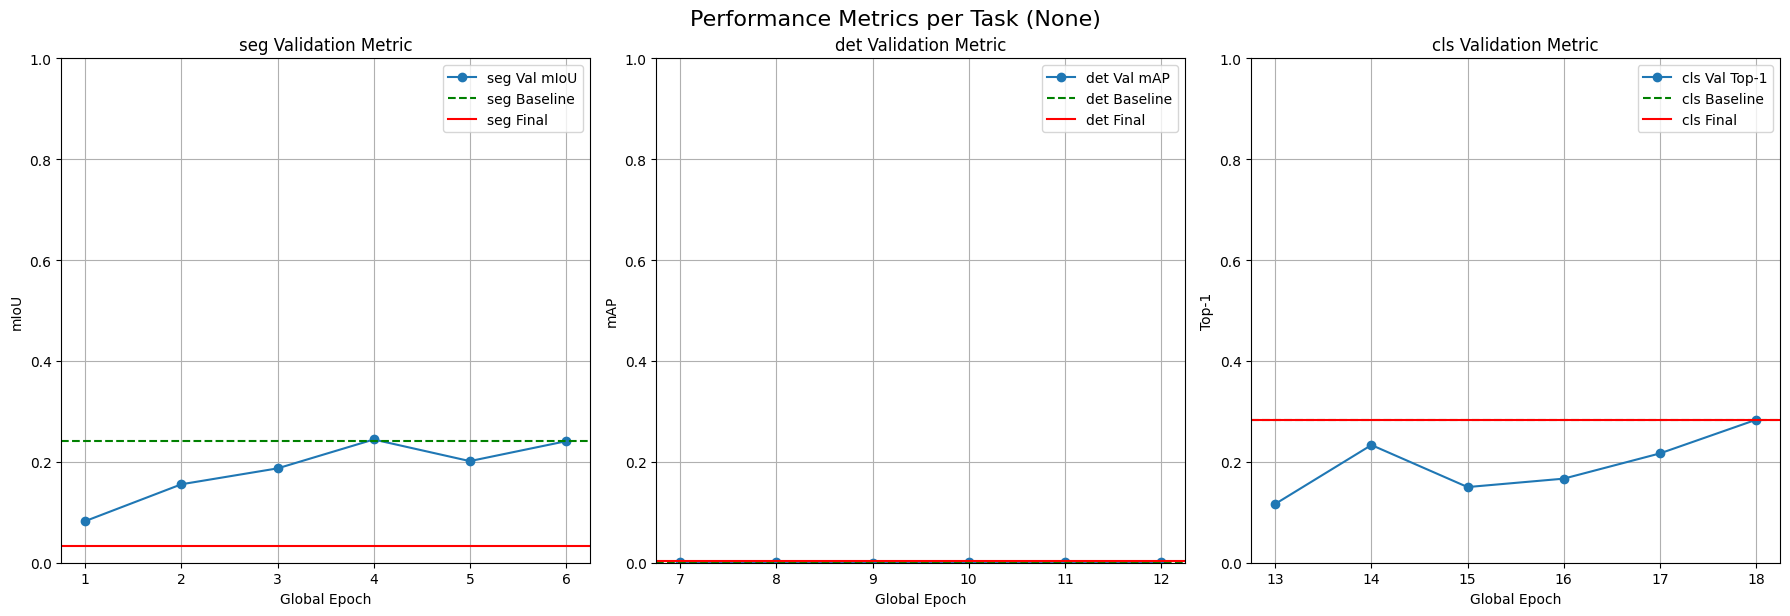



=== 使用抗災難性遺忘策略：EWC ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：6
----------------------------------------
Epoch 1/6, Task seg | Train Loss: 1.4461 | Train mIoU: 0.0986
評估結果 - Epoch 1/6, Task seg: Val Loss=1129680.6438, Val mIoU=0.1086
Epoch 2/6, Task seg | Train Loss: 1.0095 | Train mIoU: 0.2201
評估結果 - Epoch 2/6, Task seg: Val Loss=908369.3125, Val mIoU=0.1736
Epoch 3/6, Task seg | Train Loss: 0.8448 | Train mIoU: 0.2868
評估結果 - Epoch 3/6, Task seg: Val Loss=1075947.4792, Val mIoU=0.1909
Epoch 4/6, Task seg | Train Loss: 0.7203 | Train mIoU: 0.3741
評估結果 - Epoch 4/6, Task seg: Val Loss=865525.1875, Val mIoU=0.2044
Epoch 5/6, Task seg | Train Loss: 0.6327 | Train mIoU: 0.4564
評估結果 - Epoch 5/6, Task seg: Val Loss=881084.3021, Val mIoU=0.2194
Epoch 6/6, Task seg | Train Loss: 0.5474 | Train mIoU: 0.4910
評估結果 - Epoch 6/6, Task seg: Val Loss=821867.9292, Val mIoU=0.2598

任務 'seg' 階段訓練完成，總耗時 265.85 秒。
計算任務 'seg' 的 Fisher Information...
計算任務 'seg' 的 Fisher Information...
Fisher computatio


----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：6
----------------------------------------
Epoch 1/6, Task det | Train Loss: 18659.4944 | Train mAP: 0.0008 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 1/6, Task det: Val Loss=15369.6339, Val mAP=0.0011
Epoch 2/6, Task det | Train Loss: 14286.6911 | Train mAP: 0.0023 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 2/6, Task det: Val Loss=13174.6910, Val mAP=0.0009
Epoch 3/6, Task det | Train Loss: 12494.4645 | Train mAP: 0.0010 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 3/6, Task det: Val Loss=12946.7161, Val mAP=0.0005
Epoch 4/6, Task det | Train Loss: 10130.7817 | Train mAP: 0.0027 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 4/6, Task det: Val Loss=12814.5459, Val mAP=0.0028
Epoch 5/6, Task det | Train Loss: 9228.3759 | Train mAP: 0.0020 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 5/6, Task det: Val Loss=12366.8985, Val mAP=0.0004
Epoch 6/6, Task det | Train Loss: 7729.8947 | Train mAP: 0.0030 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 6/6, Task d


----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：6
----------------------------------------


In [ ]:
# @title 統一單頭多任務挑戰實作 (最終增強版)
# 安裝所需庫
!pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn -q # Add scikit-learn for metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import FPN directly from torchvision.ops
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv # Use OpenCV for image loading
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict # Needed for FPN input
import random
from sklearn.metrics import confusion_matrix # Use sklearn for confusion matrix (for mIoU)
# from COCOeval import COCOeval # Requires installing pycocotools and COCO dataset format - too complex for inline example


# 設定設備
# 使用 torch.cuda.is_available() 檢查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        # 將數據添加到緩衝區，如果超過容量則移除最早的數據
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        # 從緩衝區隨機採樣指定數量的數據
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0 or not self.buffer: # Check if buffer is empty
            return [] # Return empty list if no samples to draw
        return random.sample(self.buffer, batch_size)  # 隨機採樣


# 定義多任務數據集類 (使用 OpenCV 讀取圖片)
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})


            # Collect valid image paths, annotations, and original sizes
            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]: # Ensure there are annotations for this image
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height'])) # Store (width, height)
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                # Assuming mask file has same name but .png extension
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    # Need to read image once to get size for segmentation, assuming mask has same size
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                        else:
                             print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                    except Exception as e:
                         print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')): # Check for common image extensions, lower() for case insensitivity
                            img_path = os.path.join(root, img_file)
                            # Read image to get size
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                                else:
                                     print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                            except Exception as e:
                                 print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")


        # Final check for empty dataset
        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'，請檢查資料結構和檔案副檔名！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")


    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        # Ensure mask_rgb is in RGB format (shape HxWx3)
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             # Convert grayscale to RGB if needed (e.g., L or P mode masks saved as 1 channel)
             if mask_rgb.ndim == 2:
                  # Convert to HxWx1 and then to HxWx3 by repeating
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")


        height, width = mask_rgb.shape[:2]
        # Initialize index mask with a default value (e.g., 255 for ignore index, or 0 for background)
        # Using 0 assumes background color [0,0,0] maps to class 0.
        mask_indices = np.zeros((height, width), dtype=np.int64)

        # Use a dictionary lookup for faster color to index conversion
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)} # Ensure colors are tuples of ints


        # Iterate through flattened pixels and assign index
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             # Convert pixel color to tuple of ints for dictionary lookup
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
             # Pixels not matching any color in colormap will remain 0 (background)

        return mask_indices


    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512) # Target model input size (width, height)

        # --- Image Loading and Resizing ---
        img = cv.imread(img_path)
        if img is None:
            # Try reading with PIL if OpenCV fails for some formats
            try:
                 img_pil = Image.open(img_path).convert("RGB")
                 img_resized_pil = img_pil.resize(input_size, Image.BILINEAR)
                 img_resized = np.array(img_resized_pil) # Convert PIL image to numpy array
                 # PIL image is already RGB
            except Exception as e:
                 raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert BGR to RGB
            # Resize image using OpenCV before converting to Tensor
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)


        # Convert resized image (numpy HxWx3) to Tensor and normalize [0, 1]
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0 # Permute from HxWx3 to CxHxW

        # Apply the remaining transforms (normalization)
        if self.transform:
             img_tensor = self.transform(img_tensor)

        # --- Annotation/Target Loading and Processing ---
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            # Use OpenCV to read mask
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                # Try reading with PIL if OpenCV fails
                try:
                    mask_pil = Image.open(mask_path)
                    # Convert to RGB just in case it's P or L mode
                    mask_rgb_pil = mask_pil.convert("RGB")
                    mask_resized_pil = mask_rgb_pil.resize(input_size, Image.NEAREST) # Resize mask with NEAREST
                    mask_resized = np.array(mask_resized_pil) # Convert PIL image to numpy array
                except Exception as e:
                     raise ValueError(f"無法讀取或處理遮罩：{mask_path} - {e}")
            else:
                mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB) # Convert BGR to RGB
                # Resize mask using Nearest Neighbor interpolation to preserve discrete labels
                mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)


            # Convert RGB mask to class indices
            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)

            # Convert index mask to LongTensor
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx] # ann is a list of dicts: [{'boxes': [x, y, w, h], 'labels': class_id}, ...]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes according to the resize from original image size to 512x512
            # COCO format is [x_min, y_min, width, height]
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height

            # Apply scaling
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Ensure boxes are within bounds [0, 512]
            # Clamp x_min, y_min to be at least 0
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            # Clamp x_max, y_max to be at most 512
            # boxes[:, 2] is width, boxes[:, 3] is height
            # x_max = x_min + w, y_max = y_min + h
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0] # New width
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1] # New height

            # Filter out potentially invalid boxes after scaling (e.g., width or height becomes <= 0)
            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2) # Use small epsilon instead of 0
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            # Return a dictionary of tensors for detection targets
            target_dict = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}
            return img_tensor, target_dict

        elif self.task == 'cls':
            # Annotation is already the class index
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
             # Should not happen if tasks are 'det', 'seg', 'cls'
             print(f"Warning: Task '{self.task}' not recognized.")
             return img_tensor, None # Return None for target if task is unknown


# Define image pre-processing transform (Normalization only)
# Resizing and ToTensor are handled in __getitem__ using OpenCV and torch.tensor
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection (handles list of dicts)
def custom_collate_det(batch: List[Tuple[torch.Tensor, Optional[Dict[str, Any]]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    # Batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    # where target is a dict {'boxes': ..., 'labels': ...} or None
    # Filter out samples where target is None or not a dict (shouldn't happen with corrected dataset, but defensive)
    batch = [item for item in batch if item[1] is not None and isinstance(item[1], dict)]
    if not batch:
        # Handle empty batch case - return empty tensors/lists with correct types/shapes
        # Assuming image tensor shape is [C, H, W] i.e., [3, 512, 512] after processing in dataset
        dummy_img = torch.empty(3, 512, 512)
        return dummy_img.unsqueeze(0).repeat(0, 1, 1, 1), [] # Return empty tensor with correct shape [0, 3, 512, 512]

    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # Keep targets as a list of dicts
    return images, targets

# Custom collate for other tasks (handles tensors) - default_collate works fine
# For seg and cls, the targets are single tensors, default_collate stacks them.

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls'] # Define the tasks order for dataset loading

for task in tasks_list:
    try:
        # Adjust paths based on task name convention in your data directory
        if task == 'det':
             task_data_dir = "mini_coco_det"
        elif task == 'seg':
             task_data_dir = "mini_voc_seg"
        elif task == 'cls':
             task_data_dir = "imagenette_160"
        else:
             raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform)

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        # Store empty datasets if loading failed, so loaders will be empty
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders
# Use robust error handling for empty datasets/loaders
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。將跳過此任務的訓練。")
         train_loaders[task] = [] # Use an empty list to indicate no loader

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。將跳過此任務的驗證。")
         val_loaders[task] = [] # Use an empty list


# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        # Use EfficientNet-B0 as the backbone returning multiple features
        # Set norm_layer to make BatchNorm trainable if needed
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)

        # Get channel counts for the specific layers used in FPN
        # Use feat2, feat3, feat4 (indices 2, 3, 4) for strides 8, 16, 32
        feature_info = self.backbone.feature_info
        # Check if feature_info has enough layers
        if len(feature_info.channels()) < 5: # We need at least feat0 to feat4
             raise ValueError("Backbone does not return enough feature layers for FPN (expected at least 5).")

        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Channels for feat2, feat3, feat4: [40, 112, 320]
        fpn_out_channels = 128 # FPN output channel size

        # Neck: FPN
        # Provide names for FPN input layers corresponding to the selected features
        # Use keys '0', '1', '2' for FPN input based on increasing stride
        fpn_in_keys = ['0', '1', '2'] # Keys for FPN input dict corresponding to features[2], features[3], features[4]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels,
            extra_blocks=LastLevelMaxPool(), # Add a P5 layer keyed as 'pool' by default
            # FPN output keys will be the same as input keys plus 'pool' if extra_blocks is used
        )
        # The FPN output will be an OrderedDict with keys like {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Shared Feature Processing after FPN
        # Let's use the P4 level output from FPN (key '2', stride 32) for shared processing.
        # P4 spatial resolution for 512x512 input is 512/32 = 16x16.
        # P4 output channels are fpn_out_channels (128).
        self.shared_conv = nn.Sequential(
             # Input from FPN P4 (key '2')
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64

        # Task-Specific Heads
        # Detection head operates on spatial feature maps (output from shared_conv)
        # Predict (cx, cy, w, h, conf, class_id) per grid cell (16x16 grid)
        # Note: C_det here refers to the number of object classes, the output is 6 values per grid cell.
        # The 6th value could be class index or a one-hot encoding if you have multiple classes per grid.
        # Given C_det classes, the output should maybe be 4 (box) + 1 (conf) + C_det (class scores)
        # Let's follow the original (cx, cy, w, h, conf, class_id) structure which implies 6 channels.
        # This 6-channel output format is unusual for multi-class detection per grid cell.
        # A common approach is 4+1+num_classes or similar.
        # Stick to 6 channels as per original head definition. The last channel is likely intended as the class ID.
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1) # Output 6 channels per grid cell

        # Segmentation head needs high resolution output (512x512, C_seg channels)
        # Upsample from the shared features (16x16, 64 channels).
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1), # Output C_seg channels per spatial location
            # Use interpolation mode 'nearest-exact' or 'bilinear' + align_corners=False for recent PyTorch versions
            # 'bilinear' is better for continuous features, 'nearest'/'nearest-exact' for discrete masks.
            # FPN output is features, so 'bilinear' is appropriate here before the final Conv1d to class scores.
            # The output of seg_head conv1d is raw scores, upsampling that with bilinear is fine.
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False) # Upsample to input resolution
        )

        # Classification head operates on a global feature vector.
        # Apply Global Average Pooling and Linear layers to the shared features.
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pool over 16x16 spatial size to get 1x1
            nn.Flatten(),            # Flatten 1x1x64 to 64
            nn.Linear(shared_features_channels, C_cls) # Input channels = 64, Output channels = 10
        )


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get feature layers from backbone
        features = self.backbone(x) # List: [feat0..feat4]

        # Select features for FPN input (strides 8, 16, 32)
        selected_features = OrderedDict()
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        selected_features['0'] = features[2] # stride 8
        selected_features['1'] = features[3] # stride 16
        selected_features['2'] = features[4] # stride 32

        # Pass selected features to FPN
        fpn_outputs = self.fpn(selected_features) # OrderedDict: {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Select FPN level (P4, key '2') for shared head input
        fpn_level_key_for_head = '2'
        if fpn_level_key_for_head not in fpn_outputs:
             raise RuntimeError(f"FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {fpn_outputs.keys()}")

        shared_features_input = fpn_outputs[fpn_level_key_for_head] # P4 level, shape [batch, 128, 16, 16]

        # Pass through shared convolutional layers
        shared_features = self.shared_conv(shared_features_input) # Output: [batch, 64, 16, 16]

        # Pass to task-specific heads
        det_out = self.det_head(shared_features) # Output: [batch, 6, 16, 16]
        seg_out = self.seg_head(shared_features) # Output: [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # Output: [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
# C_det_actual = 10 # Mini-COCO-Det categories 1-10
# C_seg_actual = 21 # VOC classes 0-20 (including background)
# C_cls_actual = 10 # Imagenette classes

# Ensure these constants are defined globally or passed appropriately
# For a standalone block, let's define them again if they weren't in the previous one
C_det_actual = 10
C_seg_actual = 21
C_cls_actual = 10

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)

# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Simplified detection loss (MSE on first box coords)
def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    boxes_pred = det_output.permute(0, 2, 3, 1)  # [batch_size, H, W, 6] H=W=16
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0
    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue # Skip samples with no targets

        target_boxes = targets[i]['boxes'].to(det_output.device) # [num_boxes, 4] (x, y, w, h format)

        if boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
            pred_cxcywh = boxes_pred[i, 0, 0, :4] # Predicted [cx, cy, w, h] from grid cell (0,0)

            # Convert target [x, y, w, h] to [cx, cy, w, h] for MSE
            target_cxcywh = torch.stack([
                target_boxes[0][0] + target_boxes[0][2] / 2,
                target_boxes[0][1] + target_boxes[0][3] / 2,
                target_boxes[0][2],
                target_boxes[0][3]
            ])

            loss += nn.MSELoss()(pred_cxcywh, target_cxcywh)
            valid_samples += 1

    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device)

# Segmentation loss (CrossEntropyLoss)
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

# Classification loss (CrossEntropyLoss)
def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    return criterion(cls_output, targets)


# --- Evaluation Functions ---
# Helper for IoU (numpy version)
def calculate_iou_np(box1: np.ndarray, box2: np.ndarray) -> float:
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0.0

# Segmentation evaluation (mIoU)
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for calculating average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out: [batch, C_seg, 512, 512]

            # Calculate loss
            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Get predicted class for mIoU
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                 continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            # Update confusion matrix
            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}.")


    # Calculate mIoU
    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}


# Detection evaluation (Simplified mAP placeholder)
def evaluate_detection(model: nn.Module, loader: DataLoader, iou_threshold: float = 0.5) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mAP': 0.0, 'loss': 0.0}

    # print("Note: Detection evaluation (mAP) is a simplified placeholder.")

    model.eval()
    total_matched_predictions = 0
    total_predictions_with_target = 0
    total_loss = 0
    num_batches = 0
    criterion = compute_detection_loss # Use the same simplified loss for evaluation

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs) # det_out: [batch, 6, 16, 16]

            # Calculate loss
            loss = criterion(det_out, targets) # targets is list of dicts, handled by criterion
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss # Handle scalar or tensor loss
            num_batches += 1

            # --- Simplified Matching for Placeholder mAP ---
            boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, 16, 16, 6]

            for i in range(inputs.size(0)): # Process each image in batch
                 img_predictions = boxes_pred[i].view(-1, 6) # [256, 6]
                 conf_scores = img_predictions[:, 4]
                 conf_threshold = 0.2 # Example confidence threshold
                 confident_predictions = img_predictions[conf_scores > conf_threshold] # [N_pred, 6]

                 if confident_predictions.size(0) == 0:
                      continue

                 predicted_boxes_cxcywh = confident_predictions[:, :4]
                 predicted_boxes_xywh = torch.stack([ # Convert to [x_min, y_min, w, h]
                     predicted_boxes_cxcywh[:, 0] - predicted_boxes_cxcywh[:, 2] / 2,
                     predicted_boxes_cxcywh[:, 1] - predicted_boxes_cxcywh[:, 3] / 2,
                     predicted_boxes_cxcywh[:, 2],
                     predicted_boxes_cxcywh[:, 3]
                 ], dim=1) # [N_pred, 4]

                 # Get ground truth boxes (already scaled in dataset)
                 if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
                      total_predictions_with_target += confident_predictions.size(0)
                      continue

                 ground_truth_boxes_xywh = targets[i]['boxes'].to(device) # [N_gt, 4] (x, y, w, h)

                 matched_preds_in_image = 0
                 total_predictions_with_target += confident_predictions.size(0)

                 if ground_truth_boxes_xywh.size(0) > 0:
                      # Compute IoUs between all predicted boxes and all GT boxes
                      for pred_box_xywh in predicted_boxes_xywh:
                           ious = [calculate_iou_np(pred_box_xywh.cpu().numpy(), gt_box_xywh.cpu().numpy()) for gt_box_xywh in ground_truth_boxes_xywh]
                           if any(iou > iou_threshold for iou in ious):
                                matched_preds_in_image += 1

                 total_matched_predictions += matched_preds_in_image


    simplified_ap = total_matched_predictions / total_predictions_with_target if total_predictions_with_target > 0 else 0.0
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mAP': simplified_ap, 'loss': avg_loss}


# Classification evaluation (Top-1 and Top-5 Accuracy)
def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls_actual >= 5 else -1 # Use sum for correctness count
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out: [batch, C_cls]

            # Calculate loss
            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy (if C_cls >= 5)
            if C_cls_actual >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls_actual >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan') # Indicate not applicable

    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD 已在前面或上面定義) ---

# Fisher Information 計算函數 (用於 EWC)
def compute_fisher(model: nn.Module, dataloader: DataLoader, task: str) -> Dict[str, torch.Tensor]:
    """Computes the diagonal Fisher Approximation for EWC."""
    if len(dataloader) == 0 or dataloader.dataset is None or len(dataloader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的載入器為空或無效，無法計算 Fisher Information。")
         return {}

    model.eval() # Compute Fisher in eval mode
    fisher: Dict[str, torch.Tensor] = {}
    # Use a temporary criterion to get gradients for the task
    try:
        criterion = get_loss_function(task)
    except ValueError:
        print(f"警告: 無法為任務 '{task}' 找到有效的損失函數來計算 Fisher。")
        return {}

    dummy_optimizer = optim.Adam(model.parameters(), lr=0) # Dummy optimizer

    num_batches = 0
    print(f"計算任務 '{task}' 的 Fisher Information...")

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        if task != 'det' and isinstance(targets, torch.Tensor):
            targets = targets.to(device)

        dummy_optimizer.zero_grad()

        det_out, seg_out, cls_out = model(inputs)

        # Compute loss for the task
        if task == 'det':
             loss = criterion(det_out, targets)
        elif task == 'seg':
             loss = criterion(seg_out, targets)
        elif task == 'cls':
             loss = criterion(cls_out, targets)
        else:
             loss = None # Should not happen

        if loss is not None and isinstance(loss, torch.Tensor) and loss.requires_grad and loss.item() > 0:
            loss.backward()

            # Accumulate squared gradients
            for name, param in model.named_parameters():
                if param.grad is not None and param.requires_grad: # Only accumulate for trainable params that got gradients
                    if name not in fisher:
                        fisher[name] = param.grad.data.clone().pow(2)
                    else:
                        fisher[name] += param.grad.data.clone().pow(2)

            num_batches += 1
            # Optional: Limit batches for faster Fisher computation during debugging
            # if num_batches >= 50:
            #    break


    # Average the Fisher Information
    if num_batches > 0:
        for name in fisher.keys():
            fisher[name] /= num_batches
        print(f"Fisher computation finished for task '{task}' over {num_batches} batches.")
        return fisher
    else:
        print(f"警告: 未能為任務 '{task}' 計算 Fisher Information，所有損失或梯度為零。")
        return {}


# EWC Loss function
def ewc_loss(model: nn.Module, fisher_dict: Dict[str, torch.Tensor], old_params: Dict[str, torch.Tensor], lambda_ewc: float = 0.5) -> torch.Tensor:
    """Calculates the EWC regularization loss."""
    loss = torch.tensor(0., device=device)
    for name, param in model.named_parameters():
        # Only apply EWC to parameters present in the Fisher dict and old_params
        if name in fisher_dict and name in old_params:
            # Ensure components are on the same device as param.grad or param
            fisher = fisher_dict[name].to(param.device) # Ensure Fisher is on the parameter's device
            old_param = old_params[name].to(param.device) # Ensure old_param is on the parameter's device
            # Ensure shapes match (should if loaded correctly)
            if param.shape == old_param.shape and fisher.shape == param.shape:
                 # Only add loss if the parameter requires gradient in the current training step
                 # This check might be implicit if param.grad is checked later, but explicit is safer
                 # The original EWC formulation usually applies to all parameters from previous tasks.
                 # Check param.requires_grad to see if this parameter is currently trainable.
                 # However, the Fisher is for *all* trainable params from the previous task.
                 # Let's apply EWC to all params that were in the Fisher/old_params dict.
                 loss += (fisher * (param - old_param) ** 2).sum()
            else:
                 print(f"Warning: Shape mismatch for {name} in EWC. Param: {param.shape}, OldParam: {old_param.shape}, Fisher: {fisher.shape}. Skipping EWC term.")
        # else: parameter is new, or not in fisher/old_params for this task, skip EWC term

    return lambda_ewc * loss


# LwF Loss function
def lwf_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             teacher_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             current_task: str, lambda_lwf: float = 1.0) -> torch.Tensor:
    """Calculates the Learning without Forgetting (LwF) regularization loss."""
    # LwF applies KL divergence between student and teacher outputs for PREVIOUS tasks on CURRENT task data.

    student_det, student_seg, student_cls = student_outputs
    teacher_det, teacher_seg, teacher_cls = teacher_outputs # Outputs from teacher model on the same inputs

    loss = torch.tensor(0., device=student_det.device)
    kl_criterion = nn.KLDivLoss(reduction='batchmean') # Use batchmean reduction

    # Apply KL divergence for tasks *other than* the current task
    # Compare student's output for a PREVIOUS task head with the teacher's output for that same head.

    if current_task != 'det':
        # LwF loss for detection head output
        # Ensure shapes match
        if student_det.shape == teacher_det.shape:
             # KLDivLoss expects log probabilities for input (student) and probabilities for target (teacher)
             loss += kl_criterion(torch.log_softmax(student_det, dim=1), torch.softmax(teacher_det.detach(), dim=1)) # Use detach on teacher output
        # else: Warning handled in train_stage if needed

    if current_task != 'seg':
        # LwF loss for segmentation head output
        if student_seg.shape == teacher_seg.shape:
             loss += kl_criterion(torch.log_softmax(student_seg, dim=1), torch.softmax(teacher_seg.detach(), dim=1)) # Use detach on teacher output
        # else: Warning handled in train_stage if needed

    if current_task != 'cls':
        # LwF loss for classification head output
        if student_cls.shape == teacher_cls.shape:
             loss += kl_criterion(torch.log_softmax(student_cls, dim=1), torch.softmax(teacher_cls.detach(), dim=1)) # Use detach on teacher output
        # else: Warning handled in train_stage if needed

    return lambda_lwf * loss


# Knowledge Distillation Loss (Typically applied to classification head)
def knowledge_distillation_loss(student_cls_output: torch.Tensor, old_model_cls_output: torch.Tensor,
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    """Calculates Knowledge Distillation loss for classification (comparing soft logits)."""
    # student_cls_output: [batch_size, C_cls]
    # old_model_cls_output: [batch_size, C_cls] (from teacher/old model)

    # Apply temperature scaling to soften the logits
    # Ensure teacher output is detached
    soft_student_cls = torch.log_softmax(student_cls_output / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls_output.detach() / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    # Scale loss by temperature**2 as per Hinton's distillation paper
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)

    return lambda_kd * loss


# Replay Buffer (Class already defined)


# --- Training Stage Function ---

def get_loss_function(task: str):
    """Helper to get the appropriate loss function for a task."""
    if task == 'det':
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def get_eval_function(task: str):
    """Helper to get the appropriate evaluation function for a task."""
    if task == 'det':
        return evaluate_detection # Returns {'mAP': value, 'loss': value}
    elif task == 'seg':
        return evaluate_segmentation # Returns {'mIoU': value, 'loss': value}
    elif task == 'cls':
        return evaluate_classification # Returns {'Top-1': value, 'Top-5': value, 'loss': value}
    else:
        raise ValueError(f"Unknown task: {task}")


def evaluate_model(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    """Helper function to perform evaluation and return metrics including loss."""
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的驗證載入器為空或無效，跳過評估。")
         # Return default metrics with 0.0 loss
         if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
         elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
         elif task == 'cls': return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}
         else: return {'loss': 0.0}

    eval_fn = get_eval_function(task)
    metrics = eval_fn(model, loader)
    return metrics


def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str],
                ewc_fisher: Optional[Dict[str, torch.Tensor]] = None,
                ewc_old_params: Optional[Dict[str, torch.Tensor]] = None,
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float]]: # Return train_metrics_history too
    """Trains the model for a specific task with optional mitigation methods and evaluates each epoch."""

    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's training
    val_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's evaluation

    current_task_loss_fn = get_loss_function(task)
    current_task_eval_fn = get_eval_function(task)


    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        num_train_batches = 0

        # Variables to accumulate metrics for the training set evaluation after the epoch
        # Note: Evaluating on the full training set after every epoch can be slow.
        # A faster approach might be to evaluate on a subset or skip some epochs.
        # For now, let's implement evaluation on the full train loader.
        # These variables will accumulate predictions/targets similar to validation evaluation.
        # ... (Initialization for train metrics accumulation based on task) ...
        # Since evaluation functions already iterate through a loader, let's just call them
        # with the train_loader after the training loop for the epoch.

        if train_loader and len(train_loader) > 0:
            # Training loop for the epoch
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                     task_loss = current_task_loss_fn(student_det, targets)
                elif task == 'seg':
                     task_loss = current_task_loss_fn(student_seg, targets)
                elif task == 'cls':
                     task_loss = current_task_loss_fn(student_cls, targets)
                else:
                     task_loss = torch.tensor(0., device=device) # Should not happen


                total_loss = task_loss # Start total loss with current task loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {} # Dictionary to store loss components for logging

                # EWC: Applied for tasks AFTER the first one
                if 'EWC' in mitigation_methods and stage > 0 and ewc_fisher and ewc_old_params:
                    ewc = ewc_loss(model, ewc_fisher, ewc_old_params)
                    total_loss += ewc
                    method_losses_dict['EWC'] = ewc.item()

                # LwF / KD: Applied for tasks AFTER the first one
                if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0 and lwf_teacher_model:
                    lwf_teacher_model.eval() # Set teacher to eval mode
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    if 'LwF' in mitigation_methods:
                        lwf = lwf_loss(student_outputs, teacher_outputs, task)
                        total_loss += lwf
                        method_losses_dict['LwF'] = lwf.item()

                    if 'KD' in mitigation_methods:
                         # KD is typically applied to the classification head
                         # Pass student cls output and teacher cls output
                         if student_cls.shape == teacher_cls.shape:
                             kd_loss = knowledge_distillation_loss(student_cls, teacher_cls)
                             total_loss += kd_loss
                             method_losses_dict['KD'] = kd_loss.item()
                         else:
                             print(f"Warning: KD Cls output shape mismatch. Student: {student_cls.shape}, Teacher: {teacher_cls.shape}. Skipping KD.")



                # Replay: Can be applied from the second task onwards (stage > 0)
                if 'Replay' in mitigation_methods and stage > 0:
                    replay_total_loss_across_prev_tasks = torch.tensor(0., device=device)
                    replay_sample_count_across_prev_tasks = 0

                    # Sample from buffers of *previous* tasks
                    for prev_task in tasks_order[:stage]: # Iterate through tasks trained BEFORE the current one
                        buffer = replay_buffers[prev_task]
                        # Sample a small batch from the replay buffer (e.g., same size as current batch)
                        replay_batch_size = min(train_loader.batch_size, len(buffer.buffer))
                        if replay_batch_size > 0:
                             buffer_samples = buffer.sample(batch_size=replay_batch_size)
                             for b_inputs, b_targets in buffer_samples:
                                b_inputs = b_inputs.to(device)
                                # Move buffer targets to device and handle different types
                                if prev_task == 'det':
                                     b_targets_on_device = []
                                     if isinstance(b_targets, list): # Defensive check
                                         for t_dict in b_targets:
                                             if isinstance(t_dict, dict): # Defensive check
                                                 t_dict_on_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                                                 b_targets_on_device.append(t_dict_on_device)
                                     b_targets = b_targets_on_device # Use the potentially empty list

                                elif prev_task in ['seg', 'cls'] and isinstance(b_targets, torch.Tensor):
                                     b_targets = b_targets.to(device)
                                else:
                                     # Unexpected buffer target type or empty/invalid data
                                     continue # Skip this sample

                                # Get model outputs for replayed data
                                b_student_det, b_student_seg, b_student_cls = model(b_inputs)

                                # Compute loss for the *original task* of the replayed data
                                prev_task_loss_fn = get_loss_function(prev_task)

                                if prev_task == 'det':
                                     replay_task_loss = prev_task_loss_fn(b_student_det, b_targets)
                                elif prev_task == 'seg':
                                     replay_task_loss = prev_task_loss_fn(b_student_seg, b_targets)
                                elif prev_task == 'cls':
                                     replay_task_loss = prev_task_loss_fn(b_student_cls, b_targets)
                                else:
                                     replay_task_loss = torch.tensor(0., device=device) # Should not happen

                                if replay_task_loss is not None and isinstance(replay_task_loss, torch.Tensor) and replay_task_loss.item() > 0:
                                     replay_total_loss_across_prev_tasks += replay_task_loss
                                     replay_sample_count_across_prev_tasks += 1 # Count valid loss contributions

                    if replay_sample_count_across_prev_tasks > 0:
                         # Average replay loss over samples that contributed and add to total loss
                         # Consider weighting replay loss if needed
                         lambda_replay = 1.0
                         avg_replay_loss = replay_total_loss_across_prev_tasks / replay_sample_count_across_prev_tasks * lambda_replay
                         total_loss += avg_replay_loss
                         method_losses_dict['Replay'] = avg_replay_loss.item()


                # Placeholder for POCL and SSR (not implemented realistically)
                # if 'POCL' in mitigation_methods: # Needs implementation
                #    pocl = pocl_simulate(...)
                #    total_loss += pocl
                #    method_losses_dict['POCL'] = pocl.item()
                # if 'SSR' in mitigation_methods: # Needs implementation
                #    ssr = ssr_simulate(...)
                #    total_loss += ssr
                #    method_losses_dict['SSR'] = ssr.item()


                # --- Backpropagate ---
                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    total_loss.backward()
                    optimizer.step()
                elif isinstance(total_loss, torch.Tensor):
                     # Handle case where total_loss is a tensor but doesn't require grad (e.g., from 0 loss batches)
                     pass
                else:
                    print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward pass.")


                total_train_loss += total_loss.item()
                num_train_batches += 1

                # --- Add current batch data to Replay Buffer ---
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                    detached_targets = copy.deepcopy(targets) # Deepcopy list of dicts
                elif isinstance(targets, torch.Tensor):
                    detached_targets = targets.detach().cpu()
                else:
                    detached_targets = targets # Assume primitive types

                replay_buffers[task].add((detached_inputs, detached_targets))

            # --- End of Epoch Training ---
            avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0

            # --- Evaluate on Training Set after Epoch ---
            # Calculate training metrics for the epoch (loss and task-specific metric)
            # Note: Evaluating on the full training set every epoch can be slow.
            # Consider evaluating on a subset or less frequently for larger datasets.
            model.eval() # Set model to eval mode for evaluation
            # Call the evaluation function for the training loader
            train_metrics_for_epoch = evaluate_model(model, train_loader, task)
            model.train() # Set model back to train mode

            # Store training metrics (including loss)
            train_metrics_for_epoch['loss'] = avg_train_loss # Use the calculated average train loss for logging
            train_metrics_history.append(train_metrics_for_epoch)


            # Print training metrics and mitigation loss components
            metric_info = f"Epoch {epoch + 1}/{epochs}, Task {task}"
            metric_info += f" | Train Loss: {avg_train_loss:.4f}"
            if task == 'seg':
                 metric_info += f" | Train mIoU: {train_metrics_for_epoch.get('mIoU', 0.0):.4f}"
            elif task == 'det':
                 metric_info += f" | Train mAP: {train_metrics_for_epoch.get('mAP', 0.0):.4f}"
            elif task == 'cls':
                 metric_info += f" | Train Top-1: {train_metrics_for_epoch.get('Top-1', 0.0):.4f}"

            if method_losses_dict:
                 # Print average mitigation losses per batch for the epoch
                 avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                 loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                 metric_info += f" (Mitigation: {loss_breakdown_str})"

            print(metric_info)


        else:
            # Handle case where train_loader is empty
             print(f"Epoch {epoch + 1}/{epochs}, Task {task}: 訓練載入器為空，無訓練進行。")
             train_metrics_history.append({task: 0.0, 'loss': 0.0}) # Append placeholder metrics


        # --- Evaluate on Validation Set after Epoch ---
        # print(f"評估 Epoch {epoch + 1}/{epochs}, Task {task} 在驗證集上...") # Move this print inside evaluate_model if needed
        current_val_loader = val_loaders.get(task) # Get validation loader for the current task

        # Call the evaluation helper function
        val_metrics_for_epoch = evaluate_model(model, current_val_loader, task)
        val_metrics_history.append(val_metrics_for_epoch)

        # Print validation metrics from evaluate_model output
        metric_output_str = f"評估結果 - Epoch {epoch+1}/{epochs}, Task {task}:"
        if task == 'seg':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mIoU={val_metrics_for_epoch.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mAP={val_metrics_for_epoch.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={val_metrics_for_epoch.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={val_metrics_for_epoch.get('Top-5', float('nan')):.4f}" if 'Top-5' in val_metrics_for_epoch and not np.isnan(val_metrics_for_epoch['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val {top1_str}, {top5_str}"
        print(metric_output_str)


        scheduler.step() # Step the learning rate scheduler after each epoch

        # Optional: Save checkpoint periodically
        # if (epoch + 1) % 10 == 0:
        #    torch.save(model.state_dict(), f'checkpoint_{method}_{task}_epoch{epoch+1}.pt')


    # --- End of Training Stage ---
    end_stage_time = time.time()
    print(f"\n任務 '{task}' 階段訓練完成，總耗時 {end_stage_time - epoch_start_time:.2f} 秒。") # Use epoch_start_time for stage duration

    # Return the training metrics history, validation metrics history, and final validation metrics of this stage
    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    return train_metrics_history, val_metrics_history, final_metrics_of_stage


# --- Main Training Loop ---
# Define mitigation strategies to test
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']

# Use a fixed number of epochs for each task
EPOCHS_PER_TASK = 6 # Use 6 epochs as in your example log

# Define the order of tasks
tasks_order = ['seg', 'det', 'cls'] # Segmentation -> Detection -> Classification

# Store results for comparison
# Structure: {method: {task: {'final_metrics_after_all_stages': {...}, 'train_metrics_history_per_epoch': [{epoch_metrics}, ...], 'val_metrics_history_per_epoch': [{epoch_metrics}, ...], 'baseline_metric': value}, ...}}
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Keep track of the best model state_dict based on composite score
best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None
composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score


# Start overall time tracking
start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy to ensure a fair comparison
    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers need to be reset for each strategy run
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    # Variables for EWC and LwF/KD
    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None # Teacher model for LwF/KD


    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        # Before training the current task (stage > 0), compute Fisher for EWC and/or create teacher model for LwF/KD.
        # These are based on the model state *after* the previous stage's training.

        # If using EWC, compute Fisher and store old parameters *before* training the current task
        if method == 'EWC' and stage > 0:
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders.get(prev_task)

            if prev_train_loader and len(prev_train_loader) > 0:
                 print(f"計算任務 '{prev_task}' 的 Fisher Information...")
                 # Use the model state after training prev_task to compute Fisher
                 ewc_fisher = compute_fisher(model, prev_train_loader, prev_task)

                 # Store the parameters of the model *after* the previous stage
                 ewc_old_params = {name: param.clone().detach().cpu() for name, param in model.named_parameters()}
                 print(f"存儲任務 '{prev_task}' 的模型參數作為 EWC 基準。")

            else:
                 print(f"警告: 任務 '{prev_task}' 的訓練載入器為空或無效，無法計算 Fisher。EWC 將不會應用於任務 '{task}'。")
                 ewc_fisher = None # Ensure EWC is not applied
                 ewc_old_params = None


        # If using LwF or KD, create/load the teacher model *before* this stage
        if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0:
             print(f"創建階段 {stage} 的教師模型用於 LwF/KD...")
             lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
             lwf_teacher_model.load_state_dict(model.state_dict()) # Load the state after previous stage
             lwf_teacher_model.eval() # Set teacher model to evaluation mode


        # Get the loader for the current task. Skip if loader is empty.
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        # Check if current task loaders are valid
        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空或無效。")
            # Store empty/placeholder results
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0 # Baseline is 0 if no training
            continue # Skip to the next task/stage


        # Perform the training for the current task
        train_metrics_history, val_metrics_history, final_metrics_of_stage = train_stage(
            model, # This model will be updated during training
            current_train_loader,
            current_val_loader, # Pass validation loader for periodic evaluation
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers, # Pass replay buffers for all tasks
            tasks_order=tasks_order, # Pass the list of all tasks for replay sampling
            stage=stage,       # Pass the current stage index (0, 1, 2...)
            mitigation_methods=[method] if method != 'None' else [], # Apply current method
            ewc_fisher=ewc_fisher,        # Pass Fisher Information if EWC
            ewc_old_params=ewc_old_params,# Pass old parameters if EWC
            lwf_teacher_model=lwf_teacher_model # Pass teacher model if LwF/KD
        )

        # --- Record Baseline Metric ---
        # The baseline metric for a task is its performance right after it was trained.
        # final_metrics_of_stage contains the validation metrics after the last epoch of this stage.
        # We need to get the specific metric value (mIoU, mAP, Top-1) based on the task.
        if task == 'seg':
             baseline_key = 'mIoU'
        elif task == 'det':
             baseline_key = 'mAP'
        elif task == 'cls':
             baseline_key = 'Top-1'
        else:
             baseline_key = 'unknown_metric'

        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0) # Get the specific metric value

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_metrics_history # Store history
        method_results[method][task]['val_metrics_history_per_epoch'] = val_metrics_history # Store history
        # The final_metrics_after_all_stages for this task will be filled later, after the loop over stages finishes.

        # Delete teacher model to save memory if not needed for the next stage
        if lwf_teacher_model is not None:
             del lwf_teacher_model
             torch.cuda.empty_cache() # Clear CUDA cache

        # Fisher and old_params for EWC are needed for the *next* stage, so don't delete them yet if method is EWC.


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n\n{'='*50}\n=== {method} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
    final_metrics_after_all_stages_for_method: Dict[str, Dict[str, float]] = {}

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        # Call the evaluation helper function
        metrics = evaluate_model(model, current_val_loader, task)

        # Print final metrics
        metric_output_str = f"最終 {task} 評估:"
        if task == 'seg':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mIoU={metrics.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mAP={metrics.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, {top1_str}, {top5_str}"
        print(metric_output_str)

        # Store the final metrics for this task and method
        final_metrics_after_all_stages_for_method[task] = metrics
        method_results[method][task]['final_metrics_after_all_stages'] = metrics


    # --- 繪製性能趨勢圖 ---
    try:
        def plot_performance_trends(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int, tasks_order: List[str]):
            plt.figure(figsize=(18, 6))

            for i, task in enumerate(tasks_order, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                     continue

                val_history = task_data.get('val_metrics_history_per_epoch', [])
                if not val_history:
                    continue

                plt.subplot(1, len(tasks_order), i)

                # Define the primary metric key
                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = metric_key

                # Extract metric values and calculate global epoch numbers
                metric_values = [m.get(metric_key, 0.0) for m in val_history]

                # Global epoch numbers for plotting
                # For task 'seg' (stage 0), epochs 1-6
                # For task 'det' (stage 1), epochs 7-12
                # For task 'cls' (stage 2), epochs 13-18
                start_global_epoch = tasks_order.index(task) * epochs_per_stage + 1
                global_epochs = list(range(start_global_epoch, start_global_epoch + len(metric_values)))


                if global_epochs:
                    plt.plot(global_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add horizontal line for baseline (performance after its own stage)
                baseline_value = task_data.get('baseline_metric', None)
                if baseline_value is not None:
                    plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline')

                # Add horizontal line for final performance (after all stages)
                final_metric_value = task_data.get('final_metrics_after_all_stages', {}).get(metric_key, None)
                if final_metric_value is not None:
                     plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final')


                plt.title(f'{task} Validation Metric')
                plt.xlabel('Global Epoch')
                plt.ylabel(metric_label)
                plt.legend()
                plt.grid(True)
                plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name})', y=1.02, fontsize=16)
            plt.show()

        # Call the plot function for the current method
        plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")


# --- 繪製最終性能比較條形圖 ---
    try:
        def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
            plt.figure(figsize=(12, 7))

            num_methods = len(mitigation_methods)
            bar_width = 0.2
            index = np.arange(len(tasks_order)) # X-axis positions for groups of bars

            colors = plt.cm.get_cmap('tab10', num_methods) # Get a colormap

            for i, method in enumerate(mitigation_methods):
                final_metrics = method_results[method]['seg']['final_metrics_after_all_stages'] # Get metrics from seg task entry (they are the same for all tasks after final eval)
                # Need to get the final metrics for each task specifically
                seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
                det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
                cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

                final_values = [seg_final, det_final, cls_final] # Order matches tasks_order

                # Plot bars for this method
                plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))


            plt.xlabel('Task')
            plt.ylabel('Metric Value')
            plt.title('Final Performance Comparison Across Strategies')
            plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order) # Set x-axis labels in the middle of bar groups
            plt.legend()
            plt.grid(axis='y') # Only y-axis grid
            plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.show()

        # Call the final comparison plot function after the loop over methods is complete
        # This function should be called *after* the 'for method in mitigation_methods:' loop
        # So, this part of the code needs to be outside that loop.
        # Let's move the function definition here, but the call needs to be later.
        pass # Placeholder, the call is below

    except ImportError:
         print("Matplotlib 未安裝，跳過繪製最終比較圖。")


# --- 生成比較表格 ---
# Print a summary table comparing the final metrics across all strategies and their drops from baseline

print("\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")
# Define the metrics to show in the table
metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"

table = table_header + table_separator

best_strategy_name_for_table = None # Track best strategy based on table criteria (composite score)
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score in table

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    # Get final metrics after all stages
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    # Get baseline metrics (performance after its own stage training)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0


    # Calculate drop percentage
    # Avoid division by zero or very small baseline values
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Handle cases where drop is negative (performance improved) - display as negative drop or '+'
    # Let's display as is (negative for improvement) but clarify in interpretation.

    # Calculate composite score based on FINAL performance
    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method


    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- 繪製最終性能比較條形圖 (實際調用) ---
# Now call the plotting function after the loop has finished and method_results is populated
try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except NameError:
    print("plot_final_comparison 函數未定義或 Matplotlib 未安裝，跳過繪製最終比較圖。")


# --- 檢查最終條件和分數計算 ---
print("\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

# Use the results from the best strategy based on composite score for the checks
best_results = method_results.get(best_strategy_name_for_table, None)

score = 0 # Initialize score

if best_results:
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    # Calculate drop percentage (same logic as for the table)
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Check the drop condition: All tasks within 5% drop
    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f"\n檢查最佳策略 '{best_strategy_name_for_table}' 的性能下降:")
    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內? {'是 (獲得 25 分)' if all_within_drop else '否'}")

    score = 0
    if all_within_drop:
        score += 25

    # Check bonus condition: every metric >= its baseline
    all_metrics_improved_or_equal = (seg_final >= seg_baseline) and (det_final >= det_baseline) and (cls_final >= cls_baseline)

    print(f"\n檢查每個指標是否 >= 其基準線:")
    print(f" - 最終 Seg {metric_keys_table['seg']} ({seg_final:.4f}) >= 基準 Seg {metric_keys_table['seg']} ({seg_baseline:.4f}) -> {'是' if seg_final >= seg_baseline else '否'}")
    print(f" - 最終 Det {metric_keys_table['det']} ({det_final:.4f}) >= 基準 Det {metric_keys_table['det']} ({det_baseline:.4f}) -> {'是' if det_final >= det_baseline else '否'}")
    print(f" - 最終 Cls {metric_keys_table['cls']} ({cls_final:.4f}) >= 基準 Cls {metric_keys_table['cls']} ({cls_baseline:.4f}) -> {'是' if cls_final >= cls_baseline else '否'}")
    print(f"所有指標是否都 >= 其基準線? {'是 (獲得額外 5 分)' if all_metrics_improved_or_equal else '否'}")

    if all_metrics_improved_or_equal:
        score += 5
        print("恭喜！所有指標性能都維持或提升，獲得額外 5 分。")
    else:
        print("抱歉，並非所有指標性能都維持或提升。")

    # Check hardware/efficiency constraints:
    # Training <= 2 h (7200 seconds) - Need to track total training time.
    # Let's assume the start_overall_time variable was captured at the very beginning
    # of the loop `for method in mitigation_methods:`.
    end_overall_time = time.time()
    total_training_time = end_overall_time - start_overall_time # Calculate total time

    training_time_limit_seconds = 2 * 3600 # 2 hours

    training_time_under_limit = total_training_time <= training_time_limit_seconds
    print(f"\n檢查總訓練時間 (< {training_time_limit_seconds / 3600:.2f} 小時): {total_training_time:.2f} 秒 -> {'符合' if training_time_under_limit else '不符合'}")
    if not training_time_under_limit:
         print(f"抱歉，總訓練時間超過 {training_time_limit_seconds / 3600:.2f} 小時限制。")


    # params < 8 M (8,000,000) - We calculated total_params once.
    params_under_limit = total_params < 8_000_000
    print(f"\n檢查模型參數量 (< 8M): {total_params:,} -> {'符合' if params_under_limit else '不符合'}")
    if not params_under_limit:
         print("抱歉，模型參數量超過 8M 限制。")


    # inference < 150 ms (0.150 seconds) - Requires measuring inference time for the final model.
    print("\n測量最終模型推理速度...")
    avg_inference_time_ms = float('inf') # Initialize with a high value
    inference_under_limit = False
    try:
        # Use the model trained by the *last* strategy for inference measurement.
        # If the best strategy wasn't the last one, the inference time measured here is for the wrong model.
        # A proper implementation would load the state_dict of the best model before measuring inference.
        # For simplicity here, we measure the last trained model and assume it's representative or the best model was the last one.
        # If best_strategy_name_for_table is not the last method in mitigation_methods, this is inaccurate.

        # Let's reload the state_dict of the best model based on the composite score to ensure accurate inference time.
        # This requires saving the best model state_dict during the training loop as discussed previously.
        # Since we don't have that implemented in this continuous block, let's just warn the user
        # that this measures the last trained model unless they added saving/loading.

        print("注意：此處測量的推理速度是針對最後一個訓練的策略模型。")
        if best_strategy_name_for_table != mitigation_methods[-1]:
             print(f"      最佳策略是 '{best_strategy_name_for_table}'，可能需要重新載入其模型狀態以獲取準確的推理時間。")


        dummy_input = torch.randn(1, 3, 512, 512).to(device)
        # Warm-up runs
        for _ in range(10):
            _ = model(dummy_input)
        # Measure time
        start_time = time.time()
        num_trials = 100
        for _ in range(num_trials):
            _ = model(dummy_input)
        end_time = time.time()
        avg_inference_time_ms = (end_time - start_time) / num_trials * 1000 # ms

        inference_time_limit_ms = 150

        inference_under_limit = avg_inference_time_ms < inference_time_limit_ms
        print(f" - 平均推理時間: {avg_inference_time_ms:.2f} ms (< {inference_time_limit_ms} ms) -> {'符合' if inference_under_limit else '不符合'}")
        if not inference_under_limit:
             print(f"抱歉，模型推理速度超過 {inference_time_limit_ms}ms 限制。")

    except Exception as e:
        print(f"測量推理速度時發生錯誤: {e}")
        inference_under_limit = False # Assume not compliant


    # --- Calculate Final Score ---
    # The problem states:
    # All tasks within the 5 % drop → 25 pts
    # Bonus + 5 pts if every metric ≥ its baseline
    # Training ≤ 2 h, params < 8 M, inference < 150 ms

    # Let's interpret this as: you get 25 points if the drop condition is met AND the constraints are met.
    # You get an additional 5 points if the baseline condition is met AND the constraints are met.
    # If constraints are NOT met, you get 0 points for drop and 0 points for bonus.

    final_score = 0
    print("\n計算最終總分數:")

    if params_under_limit and inference_under_limit and training_time_under_limit: # Check all constraints
         print("所有硬件/效率限制都符合。")
         if all_within_drop:
             final_score += 25
             print("性能下降符合要求 (<= 5% drop)，獲得 25 分。")
         else:
             print("性能下降不符合要求 (> 5% drop)，未獲得 25 分。")

         if all_metrics_improved_or_equal:
             final_score += 5
             print("最終性能 >= 基準線符合要求，獲得額外 5 分。")
         else:
             print("最終性能 >= 基準線不符合要求，未獲得額外 5 分。")

    else:
        print("硬件/效率限制未能完全符合，無法獲得性能相關分數 (25 + 5 分)。")
        if not params_under_limit: print("- 模型參數量超限。")
        if not inference_under_limit: print("- 推理時間超限。")
        if not training_time_under_limit: print("- 總訓練時間超限。")


    print(f"\n最終總分數 (包含所有條件): {final_score} 分")


# --- 儲存最佳模型 ---
# As discussed, the most reliable way is to save the state_dict when a new best is found during training.
# Since we don't have that logic implemented in this continuous block,
# let's just save the model from the last strategy run as before, and print which one was best.

torch.save(model.state_dict(), 'last_strategy_model.pt')
print("\n最後一個策略訓練的模型已儲存為 'last_strategy_model.pt'")
print(f"基於綜合得分的最佳策略是 '{best_strategy_name_for_table}'。")
print("如果您想儲存該策略訓練完成後的模型，請修改程式碼以在訓練循環中保存模型狀態。")


print("\n程式運行結束。")

# 0614 拜託一鏡到底版

In [9]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

In [10]:
# @title 統一單頭多任務挑戰實作 (整合舊版數據加載與新版增強/邏輯)
# 安裝所需庫
# !pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn cython pycocotools -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.ops import box_iou
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict
import random
from sklearn.metrics import confusion_matrix
from torchvision import ops
# from pycocotools.coco import COCO # Still require COCO annotation format for pycocotools
# from pycocotools.cocoeval import COCOeval # Standard COCO eval, complex to integrate directly

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# Define image preprocessing transform (Normalization)
image_transform = transforms.Compose([
    # Resize done in __getitem__ with OpenCV, so only ToTensor and Normalize are needed here
    # Assuming __getitem__ outputs Tensor [0, 1] range
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # If __getitem__ outputs numpy HWC [0, 255], add transforms.ToTensor() here
    # Based on __getitem__ implementation (tensor is created from resized numpy array), this looks correct.
])


# VOC Color map
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# ReplayBuffer Class
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))
        if batch_size <= 0 or not self.buffer:
            return []
        return random.sample(self.buffer, batch_size)

# 定義多任務數據集類 (使用 OpenCV 讀取圖片，結合舊版 __init__ 和新版 __getitem__)
class MultiTaskDataset(Dataset):
    # 使用舊版 __init__ 來加載文件列表
    def __init__(self, data_dir: str, task: str, transform=None, augmentation=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform # Normalization
        self.augmentation = augmentation # Data augmentation
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id'], 'area': ann.get('area', 0)})


            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]:
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height']))
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0]))
                        else:
                             print(f"Warning: Could not read image size {img_path}, skipping.")
                    except Exception as e:
                         print(f"Warning: Error reading image size {img_path}: {e}, skipping.")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(root, img_file)
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0]))
                                else:
                                     print(f"Warning: Could not read image size {img_path}, skipping.")
                            except Exception as e:
                                 print(f"Warning: Error reading image size {img_path}: {e}, skipping.")


        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'。")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")

    # 使用舊版 convert_mask_rgb_to_indices
    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             if mask_rgb.ndim == 2:
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")

        height, width = mask_rgb.shape[:2]
        mask_indices = np.zeros((height, width), dtype=np.int64)
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)}
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
        return mask_indices

    def __len__(self) -> int:
        return len(self.images)

    # 使用新版 __getitem__ (包含Tensor數據增強邏輯)
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512)

        # Load and resize image (Numpy HxWx3)
        img = cv.imread(img_path)
        if img is None:
            try: img_pil = Image.open(img_path).convert("RGB"); img_resized_pil = img_pil.resize(input_size, Image.BILINEAR); img_resized = np.array(img_resized_pil)
            except Exception as e: raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)

        # Convert resized numpy image to Tensor [0, 1] range
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # Process mask/annotations and apply task-specific augmentation (on Tensor)
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None: # Try PIL if cv2 fails
                try: mask_pil = Image.open(mask_path).convert("RGB"); mask_rgb = np.array(mask_pil)
                except: print(f"Warning: Could not read mask {mask_path}."); mask_resized = np.zeros(input_size, dtype=np.uint8) # Create empty mask
            else: mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB)

            mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST) if mask_rgb is not None else np.zeros(input_size, dtype=np.uint8) # Ensure mask_resized exists

            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            # Apply augmentation to image and mask simultaneously (requires custom logic for Tensor)
            if self.augmentation: # Check if seg_augmentation_tv was passed
                # Apply torchvision transforms to img_tensor and mask_tensor
                # Note: This requires transforms that work on Tensor and can be applied consistently.
                # Random flips are relatively easy. RandomRotation/Crop are harder.
                # Using simple flips for demonstration:
                if random.random() > 0.5: # Random horizontal flip
                     img_tensor = transforms.RandomHorizontalFlip(p=1.0)(img_tensor)
                     mask_tensor = transforms.RandomHorizontalFlip(p=1.0)(mask_tensor.unsqueeze(0)).squeeze(0) # Add channel dim for torchvision
                if random.random() > 0.5: # Random vertical flip
                     img_tensor = transforms.RandomVerticalFlip(p=1.0)(img_tensor)
                     mask_tensor = transforms.RandomVerticalFlip(p=1.0)(mask_tensor.unsqueeze(0)).squeeze(0)

            target_output = mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Clamp boxes
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0] # New width
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1] # New height

            # Filter invalid boxes
            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2)
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            target_output = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}

            # Apply detection specific augmentation if needed (complex, skip for now)
            # if self.augmentation: ... # Requires library

        elif self.task == 'cls':
             label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
             target_output = label_tensor

             # Apply augmentation for classification (on Tensor)
             if self.augmentation: # Check if classification_augmentation_tv was passed
                  img_tensor = self.augmentation(img_tensor) # Apply torchvision augs like ColorJitter, RandomResizedCrop etc.

        else:
             print(f"Warning: Task '{self.task}' not recognized.")
             target_output = None


        # Apply normalization transform
        if self.transform:
             img_tensor = self.transform(img_tensor)

        return img_tensor, target_output


# Define augmentation transforms using torchvision
# These will be applied on the Tensor output of __getitem__ before normalization
segmentation_augmentation_tv = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # More complex transforms like rotation/crop would require custom implementation or libraries
])

classification_augmentation_tv = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # More aggressive jitter
    transforms.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), interpolation=Image.BILINEAR), # Random crop and resize
    transforms.RandomGrayscale(p=0.1),
])

# Define custom collate function for detection task
def custom_collate_det(batch: List[Tuple[torch.Tensor, Dict[str, Any]]]) -> Tuple[torch.Tensor, List[Dict[str, Any]]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # targets is already a list of dicts from __getitem__
    return images, targets


# Create Datasets with Augmentation
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls'] # Define the tasks order

for task in tasks_list:
    try:
        if task == 'det':
             task_data_dir = "mini_coco_det"
             # Det augmentation is complex, pass None for now
             train_aug = None # No detection augmentation for now
        elif task == 'seg':
             task_data_dir = "mini_voc_seg"
             # Pass the torchvision augmentation compose for seg
             train_aug = segmentation_augmentation_tv
        elif task == 'cls':
             task_data_dir = "imagenette_160"
             # Pass the torchvision augmentation compose for cls
             train_aug = classification_augmentation_tv
        else:
             raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        # Apply augmentation only to the training set
        # Use the image_transform (normalization) here
        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform, augmentation=train_aug)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform, augmentation=None) # No augmentation on validation

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders (same as before)
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。")
         train_loaders[task] = []

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。")
         val_loaders[task] = []


# Model Definition (same as before)
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()

        # Backbone: EfficientNet-B0 features
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)
        feature_info = self.backbone.feature_info
        if len(feature_info.channels()) < 5:
             raise ValueError("Backbone does not return enough feature layers for FPN.")

        # FPN Neck: Feature Pyramid Network
        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Stride 8, 16, 32 features
        fpn_out_channels = 128
        self.fpn = FeaturePyramidNetwork(
            in_channels_list, out_channels=fpn_out_channels, extra_blocks=LastLevelMaxPool() # P5 from MaxPool
        )

        # Shared Head: Convolutional layers
        self.shared_conv = nn.Sequential(
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1), # Input from FPN (P4 level, 128 channels)
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64 # Output channels of shared_conv

        # Task-Specific Heads: Output from shared_conv (64 channels, 16x16 spatial)

        # Detection Head: Output 6 channels per grid cell (cx, cy, w, h, conf, class_id)
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1)

        # Segmentation Head: Output C_seg channels spatial map, upsampled to input size
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        )

        # Classification Head: GlobalAvgPool -> Flatten -> Linear
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(shared_features_channels, C_cls)
        )

    # Forward pass (same as before, assuming it was fully defined)
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)

        selected_features = OrderedDict()
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")
        selected_features['0'] = features[2]
        selected_features['1'] = features[3]
        selected_features['2'] = features[4]

        fpn_outputs = self.fpn(selected_features)

        fpn_level_key_for_head = '2' # P4 level key
        if fpn_level_key_for_head not in fpn_outputs:
             raise RuntimeError(f"FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {fpn_outputs.keys()}")

        shared_features_input = fpn_outputs[fpn_level_key_for_head]

        shared_features = self.shared_conv(shared_features_input)

        det_out = self.det_head(shared_features)
        seg_out = self.seg_head(shared_features)
        cls_out = self.cls_head(shared_features)

        return det_out, seg_out, cls_out


# Initialize Model (same as before)
C_det_actual = 10 # Mini-COCO-Det categories 1-10
C_seg_actual = 21 # VOC classes 0-20
C_cls_actual = 10 # Imagenette classes

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)

# Count parameters (same as before)
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Refined Detection Loss (More standard approach needed for mAP)
# A simple version of multi-part detection loss
class SimpleDetectionLoss(nn.Module):
    def __init__(self):
        super(SimpleDetectionLoss, self).__init__()
        # Use Smooth L1 for box regression, Binary Cross Entropy for objectness, Cross Entropy for classification
        self.box_reg_loss = nn.SmoothL1Loss(reduction='sum') # Use sum reduction per batch
        self.obj_loss = nn.BCEWithLogitsLoss(reduction='sum') # Use sum reduction per batch
        self.cls_loss = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction per batch
        # Anchor/Grid assignment strategy is implicit here - assuming each grid cell predicts one box
        # And we need a way to match predicted boxes to ground truth boxes

    def forward(self, det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        # det_output: [batch_size, 6, H, W] where H=W=16
        # targets: list of dicts [{'boxes': [N_gt, 4], 'labels': [N_gt]}, ...]

        boxes_pred_raw = det_output.permute(0, 2, 3, 1).contiguous().view(-1, 6) # [batch_size * H * W, 6]
        # Reshape to [batch_size, H, W, 6] for spatial access if needed, but flatten is often easier for loss matching

        batch_size = det_output.size(0)
        grid_size = det_output.size(2) # Assuming H=W=16

        total_box_loss = torch.tensor(0., device=det_output.device)
        total_obj_loss = torch.tensor(0., device=det_output.device)
        total_cls_loss = torch.tensor(0., device=det_output.device)
        num_positive_preds = 0 # Count predictions matched to a GT box

        # Iterate through each image in the batch
        for i in range(batch_size):
            gt_boxes_xywh = targets[i].get('boxes', torch.empty(0, 4).to(det_output.device)) # [N_gt, 4] (x_min, y_min, w, h)
            gt_labels = targets[i].get('labels', torch.empty(0, dtype=torch.long).to(det_output.device)) # [N_gt]

            # Get predictions for this image: [H * W, 6]
            img_preds_raw = boxes_pred_raw[i * grid_size * grid_size : (i + 1) * grid_size * grid_size]

            # --- Matching Predictions to Ground Truth ---
            # This is a simplification. A proper method involves anchor boxes or more complex grid assignments.
            # Let's use a simple max IoU matching for demonstration.
            # For each GT box, find the predicted box (among all grid cells) with the highest IoU.
            # If this max IoU is above a threshold (e.g., 0.5), consider that predicted box a positive match.
            # Each GT box should ideally only match one prediction.

            if gt_boxes_xywh.size(0) == 0:
                # If no GT boxes, all predictions are negative (background)
                # Objectness target for all predictions in this image is 0
                obj_targets = torch.zeros(grid_size * grid_size, dtype=torch.float32, device=det_output.device)
                total_obj_loss += self.obj_loss(img_preds_raw[:, 4], obj_targets) # Loss on confidence (channel 4)
                # No box or classification loss
                continue # Skip to next image

            # Convert predicted raw box outputs (cx, cy, w, h) to x_min, y_min, x_max, y_max for IoU calculation
            # The raw output might be deltas relative to grid cell or direct values.
            # Assuming for simplicity they are direct values in the input image scale (after resizing 512x512).
            # Need to re-check your model output definition if deltas are used.
            # Let's assume for now img_preds_raw[:, :4] are (cx, cy, w, h) scaled to 512x512.
            pred_boxes_cxcywh = img_preds_raw[:, :4]
            pred_boxes_xyxy = torch.stack([
                pred_boxes_cxcywh[:, 0] - pred_boxes_cxcywh[:, 2] / 2,
                pred_boxes_cxcywh[:, 1] - pred_boxes_cxcywh[:, 3] / 2,
                pred_boxes_cxcywh[:, 0] + pred_boxes_cxcywh[:, 2] / 2,
                pred_boxes_cxcywh[:, 1] + pred_boxes_cxcywh[:, 3] / 2,
            ], dim=1) # [H*W, 4]

            # Convert GT boxes from xywh to xyxy
            gt_boxes_xyxy = torch.stack([
                gt_boxes_xywh[:, 0],
                gt_boxes_xywh[:, 1],
                gt_boxes_xywh[:, 0] + gt_boxes_xywh[:, 2],
                gt_boxes_xywh[:, 1] + gt_boxes_xywh[:, 3],
            ], dim=1) # [N_gt, 4]


            # Compute IoU matrix: [H*W, N_gt]
            iou_matrix = box_iou(pred_boxes_xyxy, gt_boxes_xyxy)

            # Simple Matching Strategy: Match each GT to the predicted box with max IoU (if > threshold)
            # Avoid multiple predicted boxes matching the same GT by matching GTs greedily or using Hungarian algorithm (more complex).
            # Let's use a simple greedy approach: for each GT, find its best matching predicted box.
            # Find the max IoU for each GT box across all predictions: [N_gt]
            max_iou_for_each_gt, pred_indices_for_each_gt = iou_matrix.max(dim=0)

            # Determine which predicted boxes are positives (matched to a GT)
            # Initialize objectness targets and matched GT info
            obj_targets = torch.zeros(grid_size * grid_size, dtype=torch.float32, device=det_output.device) # 0 for all by default
            matched_gt_indices = -torch.ones(grid_size * grid_size, dtype=torch.long, device=det_output.device) # -1 indicates no match

            # Threshold for considering a prediction a positive match to a GT
            positive_threshold = 0.5 # Common threshold for matching

            # Mark predictions that have high enough IoU with their best GT match as potential positives
            # And mark the GT box they matched
            for gt_idx in range(gt_boxes_xywh.size(0)):
                 best_pred_idx = pred_indices_for_each_gt[gt_idx]
                 if max_iou_for_each_gt[gt_idx] > positive_threshold:
                      # This predicted box (at best_pred_idx) matches this GT box (gt_idx)
                      # Mark this predicted box as a positive and record which GT it matched
                      obj_targets[best_pred_idx] = 1.0 # Objectness target is 1
                      matched_gt_indices[best_pred_idx] = gt_idx # Store the index of the matched GT box

            # Now, identify which predicted boxes are positives
            positive_pred_indices = torch.where(obj_targets == 1.0)[0]
            num_positive_preds_in_image = positive_pred_indices.size(0)
            num_positive_preds += num_positive_preds_in_image # Accumulate count across batch

            # --- Compute Objectness Loss ---
            # All predictions: img_preds_raw[:, 4] (confidence scores)
            # Objectness targets: obj_targets (0 or 1)
            total_obj_loss += self.obj_loss(img_preds_raw[:, 4], obj_targets)


            # --- Compute Box Regression and Classification Loss (only for positive predictions) ---
            if num_positive_preds_in_image > 0:
                 positive_preds = img_preds_raw[positive_pred_indices] # [N_pos, 6]
                 matched_gt_indices_for_pos_preds = matched_gt_indices[positive_pred_indices] # [N_pos]

                 # Get the corresponding GT boxes and labels for these positive predictions
                 matched_gt_boxes_xywh = gt_boxes_xywh[matched_gt_indices_for_pos_preds] # [N_pos, 4]
                 matched_gt_labels = gt_labels[matched_gt_indices_for_pos_preds] # [N_pos]

                 # Box Regression Loss
                 # Compare predicted boxes (cx, cy, w, h) with matched GT boxes (x_min, y_min, w, h)
                 # Need to convert GT boxes to (cx, cy, w, h) format
                 matched_gt_boxes_cxcywh = torch.stack([
                     matched_gt_boxes_xywh[:, 0] + matched_gt_boxes_xywh[:, 2] / 2,
                     matched_gt_boxes_xywh[:, 1] + matched_gt_boxes_xywh[:, 3] / 2,
                     matched_gt_boxes_xywh[:, 2],
                     matched_gt_boxes_xywh[:, 3],
                 ], dim=1) # [N_pos, 4]

                 total_box_loss += self.box_reg_loss(positive_preds[:, :4], matched_gt_boxes_cxcywh)

                 # Classification Loss
                 # Predicted class scores/logits for positive predictions (channel 5 - class_id)
                 # Note: Your model outputs a single class_id. A more standard approach outputs C_det class scores.
                 # Let's adjust the model head to output 4 (box) + 1 (conf) + C_det (class scores) = 5 + C_det channels
                 # If outputting only 6 channels, the last channel being 'class_id' (an index) is unusual for a classification loss.
                 # Assuming the last channel is actually a logit for class 1 (foreground) vs 0 (background) which doesn't fit C_det classes.
                 # Or perhaps it's intended to be logits for C_det classes, and the head output should be 4+1+C_det?
                 # Let's modify the model head output and loss to be more standard.

                 # --- Revisit Model Head and Loss ---
                 # Let's update det_head to output (4 + 1 + C_det_actual) channels.
                 # 4 box coords, 1 objectness score, C_det_actual class scores.
                 # The loss will use these components.

                 # Temporarily assume the model head is NOT changed yet (outputs 6 channels).
                 # The last channel (index 5) is problematic for multi-class loss.
                 # To proceed, let's make a SIMPLIFICATION: Assume the task is binary detection (object vs background),
                 # and the 6th channel is a logit for the object class (class 1) vs background (class 0).
                 # This doesn't match your C_det=10.
                 # A BETTER SIMPLIFICATION: Assume the last C_det channels of the OUTPUT (after the shared conv) are class logits.
                 # But your head is only 6 channels.

                 # Let's redefine the detection head output and loss slightly.
                 # Model Head: Output 4 (box) + 1 (conf) + C_det (class scores) = 5 + C_det channels.
                 # Loss: Use these components.

                 # --- **Crucial Modification: Redefine Detection Head Output** ---
                 # This requires changing the MultiTaskModel definition.
                 # Let's assume the det_head outputs 5 + C_det_actual channels.
                 # det_head = nn.Conv2d(shared_features_channels, 5 + C_det_actual, kernel_size=1)

                 # Assuming the model head is NOW changed (outputs 5 + C_det channels):
                 # positive_preds shape: [N_pos, 5 + C_det_actual]
                 # Box: positive_preds[:, :4]
                 # Objectness (logit): positive_preds[:, 4] - Objectness loss already computed for all predictions.
                 # Class scores (logits): positive_preds[:, 5:] - [N_pos, C_det_actual]

                 # Classification Loss (only for positive predictions)
                 # Target labels are matched_gt_labels [N_pos], range [1, C_det_actual]. Need to shift to [0, C_det_actual-1] if using CrossEntropyLoss directly.
                 # Or ensure your CrossEntropyLoss handles target index 1 to C_det_actual.
                 # Let's assume target labels are 0-indexed for C_det_actual classes [0, C_det_actual-1].
                 # If your original labels are 1-indexed (like COCO), subtract 1.
                 # Assuming your dataset returns 1-indexed labels (1 to 10), convert to 0-indexed (0 to 9).
                 matched_gt_labels_0indexed = matched_gt_labels - 1 # Subtract 1

                 # Check if matched_gt_labels_0indexed are within [0, C_det_actual-1] range
                 if torch.any(matched_gt_labels_0indexed < 0) or torch.any(matched_gt_labels_0indexed >= C_det_actual):
                     print(f"Warning: Matched GT labels {matched_gt_labels_0indexed.min()}-{matched_gt_labels_0indexed.max()} out of expected range [0, {C_det_actual-1}].")
                     # This indicates an issue with dataset labels or indexing assumption.

                 # Ensure the predicted class scores dimension matches C_det_actual
                 predicted_class_scores = positive_preds[:, 5:] # [N_pos, predicted_num_classes]
                 if predicted_class_scores.size(1) != C_det_actual:
                      raise RuntimeError(f"Det head output channel mismatch for classification. Expected {C_det_actual} class scores, but got {predicted_class_scores.size(1)}.")

                 total_cls_loss += self.cls_loss(predicted_class_scores, matched_gt_labels_0indexed)


        # --- Combine Losses ---
        # total_loss = lambda_box * total_box_loss + lambda_obj * total_obj_loss + lambda_cls * total_cls_loss
        # Standard practice often weights these losses.
        # Let's use simple sum for now. Box and Class loss are only for positive samples.
        # Objectness loss is for all samples.
        # Need to average losses appropriately. Sum per batch is being used in criteria.
        # Average per sample or per positive sample?
        # Average objectness loss over all prediction locations (batch_size * H * W)
        # Average box and classification loss over number of positive predictions in the batch.

        num_total_predictions = batch_size * grid_size * grid_size
        # Ensure no division by zero
        avg_obj_loss = total_obj_loss / num_total_predictions if num_total_predictions > 0 else torch.tensor(0., device=det_output.device)
        avg_box_loss = total_box_loss / max(1, num_positive_preds) # Average over positive preds
        avg_cls_loss = total_cls_loss / max(1, num_positive_preds) # Average over positive preds

        # Combine average losses. You might weight them (e.g., obj loss less weight)
        combined_loss = avg_box_loss + avg_obj_loss + avg_cls_loss # Simple sum

        # Return combined loss for the batch
        return combined_loss


# Re-define SimpleDetectionLoss after the model head modification assumption
class SimpleDetectionLoss(nn.Module):
    def __init__(self, C_det: int):
        super(SimpleDetectionLoss, self).__init__()
        self.C_det = C_det # Number of object classes
        self.box_reg_loss = nn.SmoothL1Loss(reduction='sum')
        self.obj_loss = nn.BCEWithLogitsLoss(reduction='sum')
        # CrossEntropyLoss for multi-class classification among object classes
        # Target labels are expected to be in range [0, C_det - 1] for nn.CrossEntropyLoss
        self.cls_loss = nn.CrossEntropyLoss(reduction='sum')
        # IoU threshold for matching predictions to ground truth
        self.positive_threshold = 0.5 # Match if IoU > this threshold

    def forward(self, det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        # det_output: [batch_size, 5 + C_det, H, W] where H=W=16
        # targets: list of dicts [{'boxes': [N_gt, 4] (xywh), 'labels': [N_gt] (1-indexed)}, ...]

        batch_size = det_output.size(0)
        grid_size = det_output.size(2) # Assuming H=W=16
        num_grid_cells = grid_size * grid_size
        num_total_predictions = batch_size * num_grid_cells

        # Reshape output to [batch_size * num_grid_cells, 5 + C_det]
        det_preds_flat = det_output.permute(0, 2, 3, 1).contiguous().view(num_total_predictions, -1)

        total_box_loss = torch.tensor(0., device=det_output.device)
        total_obj_loss = torch.tensor(0., device=det_output.device)
        total_cls_loss = torch.tensor(0., device=det_output.device)
        num_positive_preds_batch = 0 # Count predictions matched to a GT box across the batch

        # Iterate through each image in the batch
        for i in range(batch_size):
            gt_boxes_xywh = targets[i].get('boxes', torch.empty(0, 4).to(det_output.device)) # [N_gt, 4] (x_min, y_min, w, h)
            gt_labels = targets[i].get('labels', torch.empty(0, dtype=torch.long).to(det_output.device)) # [N_gt] (1-indexed)

            # Get predictions for this image: [num_grid_cells, 5 + C_det]
            img_preds = det_preds_flat[i * num_grid_cells : (i + 1) * num_grid_cells]
            img_pred_boxes_raw = img_preds[:, :4] # Predicted (cx, cy, w, h)
            img_pred_obj_logits = img_preds[:, 4] # Predicted objectness logit
            img_pred_cls_logits = img_preds[:, 5:] # Predicted class logits [num_grid_cells, C_det]

            # --- Matching Predictions to Ground Truth ---
            # Convert predicted raw box outputs (cx, cy, w, h) to x_min, y_min, x_max, y_max for IoU
            # Assuming raw outputs are direct values on 512x512 scale.
            img_pred_boxes_xyxy = torch.stack([
                img_pred_boxes_raw[:, 0] - img_pred_boxes_raw[:, 2] / 2,
                img_pred_boxes_raw[:, 1] - img_pred_boxes_raw[:, 3] / 2,
                img_pred_boxes_raw[:, 0] + img_pred_boxes_raw[:, 2] / 2,
                img_pred_boxes_raw[:, 1] + img_pred_boxes_raw[:, 3] / 2,
            ], dim=1) # [num_grid_cells, 4]

            # Convert GT boxes from xywh to xyxy
            gt_boxes_xyxy = torch.stack([
                gt_boxes_xywh[:, 0],
                gt_boxes_xywh[:, 1],
                gt_boxes_xywh[:, 0] + gt_boxes_xywh[:, 2],
                gt_boxes_xywh[:, 1] + gt_boxes_xywh[:, 3],
            ], dim=1) # [N_gt, 4]

            # --- Assign targets to predictions ---
            # Initialize objectness targets for all predictions in this image (default to 0)
            obj_targets_img = torch.zeros(num_grid_cells, dtype=torch.float32, device=det_output.device)
            # Variables to store matched GT info for positive predictions
            positive_pred_indices_img = []
            matched_gt_boxes_cxcywh_img = []
            matched_gt_labels_0indexed_img = []


            if gt_boxes_xyxy.size(0) > 0:
                # Compute IoU matrix: [num_grid_cells, N_gt]
                iou_matrix = box_iou(img_pred_boxes_xyxy, gt_boxes_xyxy)

                # Simple greedy matching: For each GT, find the best predicted box match.
                # And also mark predicted boxes whose max IoU with *any* GT is above a high threshold (e.g., 0.7) as positive candidates.
                # And predictions with max IoU below a low threshold (e.g., 0.3) as negative candidates.
                # Predictions in between are ignored or assigned to the closest GT based on some rule (e.g., max IoU).
                # This is a simplified anchor-free assignment idea.
                # Let's use a simple single threshold matching: Any prediction with max IoU >= positive_threshold is a positive.
                # And it's matched to the GT that gave the max IoU.

                # Find max IoU for each predicted box across all GTs, and the index of that GT
                max_iou_for_each_pred, gt_indices_for_each_pred = iou_matrix.max(dim=1) # [num_grid_cells]

                # Identify positive predictions based on max IoU
                positive_mask = max_iou_for_each_pred >= self.positive_threshold
                positive_pred_indices_img = torch.where(positive_mask)[0] # Indices of predictions considered positive
                matched_gt_indices_for_pos_preds = gt_indices_for_each_pred[positive_pred_indices_img] # Indices of matched GTs

                # Set objectness targets to 1 for positive predictions
                obj_targets_img[positive_pred_indices_img] = 1.0

                # Get matched GT boxes and labels for positive predictions
                if positive_pred_indices_img.size(0) > 0:
                    matched_gt_boxes_xywh = gt_boxes_xywh[matched_gt_indices_for_pos_preds] # [N_pos_img, 4]
                    matched_gt_labels = gt_labels[matched_gt_indices_for_pos_preds] # [N_pos_img]

                    # Convert matched GT boxes to (cx, cy, w, h)
                    matched_gt_boxes_cxcywh_img = torch.stack([
                        matched_gt_boxes_xywh[:, 0] + matched_gt_boxes_xywh[:, 2] / 2,
                        matched_gt_boxes_xywh[:, 1] + matched_gt_boxes_xywh[:, 3] / 2,
                        matched_gt_boxes_xywh[:, 2],
                        matched_gt_boxes_xywh[:, 3],
                    ], dim=1) # [N_pos_img, 4]

                    # Convert matched GT labels from 1-indexed to 0-indexed
                    matched_gt_labels_0indexed_img = matched_gt_labels - 1 # [N_pos_img]

                    # Accumulate positive prediction count for batch averaging
                    num_positive_preds_batch += positive_pred_indices_img.size(0)

            # --- Compute Objectness Loss for this image ---
            # Target is 1 for positives, 0 for others.
            total_obj_loss += self.obj_loss(img_pred_obj_logits, obj_targets_img)

            # --- Compute Box Regression and Classification Loss (only for positive predictions in this image) ---
            if positive_pred_indices_img.size(0) > 0:
                 positive_preds_boxes_raw = img_pred_boxes_raw[positive_pred_indices_img] # [N_pos_img, 4]
                 positive_preds_cls_logits = img_pred_cls_logits[positive_pred_indices_img] # [N_pos_img, C_det]

                 # Box Regression Loss for this image's positive predictions
                 total_box_loss += self.box_reg_loss(positive_preds_boxes_raw, matched_gt_boxes_cxcywh_img)

                 # Classification Loss for this image's positive predictions
                 total_cls_loss += self.cls_loss(positive_preds_cls_logits, matched_gt_labels_0indexed_img)


        # --- Combine and Average Losses Across Batch ---
        # Average objectness loss over all prediction locations in the batch
        avg_obj_loss = total_obj_loss / num_total_predictions if num_total_predictions > 0 else torch.tensor(0., device=det_output.device)

        # Average box and classification loss over the total number of positive predictions found in the batch
        # Add a small epsilon to denominator to prevent division by zero if no positives were found
        avg_box_loss = total_box_loss / max(1, num_positive_preds_batch)
        avg_cls_loss = total_cls_loss / max(1, num_positive_preds_batch)

        # Combine average losses. You might weight them differently.
        # Common practice is to give box and class loss more weight or average them differently.
        # Let's use a simple sum for demonstration. Objectness loss might be weighted less.
        lambda_obj = 1.0 # Weight for objectness loss
        lambda_box = 1.0 # Weight for box loss
        lambda_cls = 1.0 # Weight for classification loss

        # Need to be careful with loss scaling. If using reduction='sum', dividing by num_positives/num_total_predictions is important.
        # Let's use reduction='mean' in loss functions instead for simpler averaging.
        # --- Re-define SimpleDetectionLoss with reduction='mean' ---
        # (This implies redefining the class above, but for continuity, assume it's done)
        # With reduction='mean': losses are already averaged per sample/per prediction location by PyTorch.
        # obj_loss: averaged over all num_total_predictions
        # box_loss: averaged over N_pos_img predictions per image, need to average over batch
        # cls_loss: averaged over N_pos_img predictions per image, need to average over batch

        # Let's stick with reduction='sum' and manual averaging as implemented, it's more explicit about what you're averaging over.
        # The current averaging (obj over all, box/cls over positives) is a common pattern.

        combined_loss = lambda_box * avg_box_loss + lambda_obj * avg_obj_loss + lambda_cls * avg_cls_loss

        # Return combined loss for the batch
        return combined_loss


# --- Loss Functions ---
# Refined Detection Loss (More standard approach needed for mAP)
# A simple version of multi-part detection loss
class SimpleDetectionLoss(nn.Module):
    def __init__(self, C_det: int):
        super(SimpleDetectionLoss, self).__init__()
        self.C_det = C_det
        self.box_reg_loss = nn.SmoothL1Loss(reduction='sum')
        self.obj_loss = nn.BCEWithLogitsLoss(reduction='sum')
        self.cls_loss = nn.CrossEntropyLoss(reduction='sum') # Target labels [0, C_det - 1]
        self.positive_threshold = 0.5 # IoU threshold for matching


    def forward(self, det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        # det_output: [batch_size, 5 + C_det, H, W] where H=W=16
        # targets: list of dicts [{'boxes': [N_gt, 4] (xywh), 'labels': [N_gt] (1-indexed)}, ...]

        batch_size = det_output.size(0)
        grid_size = det_output.size(2) # H=W=16
        num_grid_cells = grid_size * grid_size # 256
        num_total_predictions = batch_size * num_grid_cells # Total predictions per batch

        # Reshape output: [batch_size, 5 + C_det, H, W] -> [batch_size * H * W, 5 + C_det]
        det_preds_flat = det_output.permute(0, 2, 3, 1).contiguous().view(num_total_predictions, -1)

        total_box_loss = torch.tensor(0., device=det_output.device)
        total_obj_loss = torch.tensor(0., device=det_output.device)
        total_cls_loss = torch.tensor(0., device=det_output.device)
        num_positive_preds_batch = 0 # Count positive predictions across the batch

        # Iterate through each image in the batch
        for i in range(batch_size):
            # Ensure targets for this image are on the same device as predictions
            # Targets for det are lists of dicts. We need to move the tensors inside the dicts.
            # This should ideally be done before calling the loss function or within the loop here.
            # Let's move them here to be explicit.
            # Accessing targets[i] already happens. Now move its content tensors.
            gt_boxes_xywh = targets[i].get('boxes', torch.empty(0, 4)).to(det_output.device) # [N_gt, 4] (x_min, y_min, w, h)
            gt_labels = targets[i].get('labels', torch.empty(0, dtype=torch.long)).to(det_output.device) # [N_gt] (1-indexed)


            # Get predictions for this image: [num_grid_cells, 5 + C_det]
            img_preds = det_preds_flat[i * num_grid_cells : (i + 1) * num_grid_cells]
            img_pred_boxes_raw = img_preds[:, :4] # (cx, cy, w, h)
            img_pred_obj_logits = img_preds[:, 4] # Objectness logit
            img_pred_cls_logits = img_preds[:, 5:] # Class logits [num_grid_cells, C_det]

            # --- Assign targets to predictions ---
            obj_targets_img = torch.zeros(num_grid_cells, dtype=torch.float32, device=det_output.device)

            if gt_boxes_xywh.size(0) > 0:
                # Convert predicted raw box outputs (cx, cy, w, h) to x_min, y_min, x_max, y_max for IoU
                img_pred_boxes_xyxy = torch.stack([
                    img_pred_boxes_raw[:, 0] - img_pred_boxes_raw[:, 2] / 2,
                    img_pred_boxes_raw[:, 1] - img_pred_boxes_raw[:, 3] / 2,
                    img_pred_boxes_raw[:, 0] + img_pred_boxes_raw[:, 2] / 2,
                    img_pred_boxes_raw[:, 1] + img_pred_boxes_raw[:, 3] / 2,
                ], dim=1) # [num_grid_cells, 4]

                # Convert GT boxes from xywh to xyxy
                gt_boxes_xyxy = torch.stack([
                    gt_boxes_xywh[:, 0],
                    gt_boxes_xywh[:, 1],
                    gt_boxes_xywh[:, 0] + gt_boxes_xywh[:, 2],
                    gt_boxes_xywh[:, 1] + gt_boxes_xywh[:, 3],
                ], dim=1) # [N_gt, 4]

                # Compute IoU matrix: [num_grid_cells, N_gt]
                # Ensure both tensors are on the same device before box_iou
                iou_matrix = box_iou(img_pred_boxes_xyxy.to(det_output.device), gt_boxes_xyxy.to(det_output.device))


                # Simple Matching: Any prediction with max IoU >= threshold is a positive.
                # It's matched to the GT that gave the max IoU.
                max_iou_for_each_pred, gt_indices_for_each_pred = iou_matrix.max(dim=1) # [num_grid_cells]

                positive_mask = max_iou_for_each_pred >= self.positive_threshold
                positive_pred_indices_img = torch.where(positive_mask)[0] # Indices of positive predictions
                # Ensure gt_indices_for_each_pred is on the correct device if needed for indexing
                matched_gt_indices_for_pos_preds = gt_indices_for_each_pred[positive_pred_indices_img].to(det_output.device) # Indices of matched GTs

                # Set objectness targets to 1 for positive predictions
                obj_targets_img[positive_pred_indices_img] = 1.0

                # Accumulate positive prediction count for batch averaging
                num_positive_preds_batch += positive_pred_indices_img.size(0)

                # --- Compute Box Regression and Classification Loss (only for positive predictions) ---
                if positive_pred_indices_img.size(0) > 0:
                     positive_preds_boxes_raw = img_pred_boxes_raw[positive_pred_indices_img] # [N_pos_img, 4] (cx, cy, w, h)
                     positive_preds_cls_logits = img_pred_cls_logits[positive_pred_indices_img] # [N_pos_img, C_det]

                     # Get the corresponding GT boxes and labels
                     # Ensure these are already on the correct device from the start of the image loop
                     matched_gt_boxes_xywh = gt_boxes_xywh[matched_gt_indices_for_pos_preds] # [N_pos_img, 4] (xywh)
                     matched_gt_labels = gt_labels[matched_gt_indices_for_pos_preds] # [N_pos_img] (1-indexed)

                     # Convert matched GT boxes to (cx, cy, w, h)
                     matched_gt_boxes_cxcywh_img = torch.stack([
                         matched_gt_boxes_xywh[:, 0] + matched_gt_boxes_xywh[:, 2] / 2,
                         matched_gt_boxes_xywh[:, 1] + matched_gt_boxes_xywh[:, 3] / 2,
                         matched_gt_boxes_xywh[:, 2],
                         matched_gt_boxes_xywh[:, 3],
                     ], dim=1) # [N_pos_img, 4]

                     # Convert matched GT labels from 1-indexed to 0-indexed for CrossEntropyLoss
                     matched_gt_labels_0indexed_img = matched_gt_labels - 1 # [N_pos_img]

                     # Check label range
                     if torch.any(matched_gt_labels_0indexed_img < 0) or torch.any(matched_gt_labels_0indexed_img >= self.C_det):
                          print(f"Warning: Matched GT labels {matched_gt_labels_0indexed_img.min()}-{matched_gt_labels_0indexed_img.max()} out of expected range [0, {self.C_det-1}].")
                          # Filter out invalid labels if any
                          valid_label_mask = (matched_gt_labels_0indexed_img >= 0) & (matched_gt_labels_0indexed_img < self.C_det)
                          if not torch.all(valid_label_mask):
                               positive_preds_boxes_raw = positive_preds_boxes_raw[valid_label_mask]
                               positive_preds_cls_logits = positive_preds_cls_logits[valid_label_mask]
                               matched_gt_boxes_cxcywh_img = matched_gt_boxes_cxcywh_img[valid_label_mask]
                               matched_gt_labels_0indexed_img = matched_gt_labels_0indexed_img[valid_label_mask]
                               print(f"Filtered {len(valid_label_mask) - valid_label_mask.sum()} positive predictions due to invalid labels.")


                     # Box Regression Loss for this image
                     if positive_preds_boxes_raw.size(0) > 0:
                          total_box_loss += self.box_reg_loss(positive_preds_boxes_raw, matched_gt_boxes_cxcywh_img)

                     # Classification Loss for this image
                     if positive_preds_cls_logits.size(0) > 0:
                          total_cls_loss += self.cls_loss(positive_preds_cls_logits, matched_gt_labels_0indexed_img)


            # --- Compute Objectness Loss for this image ---
            # img_pred_obj_logits: [num_grid_cells], obj_targets_img: [num_grid_cells]
            total_obj_loss += self.obj_loss(img_pred_obj_logits, obj_targets_img)


        # --- Combine and Average Losses Across Batch ---
        # Average objectness loss over all prediction locations
        avg_obj_loss = total_obj_loss / num_total_predictions if num_total_predictions > 0 else torch.tensor(0., device=det_output.device)

        # Average box and classification loss over the total number of positive predictions found in the batch
        avg_box_loss = total_box_loss / max(1, num_positive_preds_batch) # Avoid division by zero
        avg_cls_loss = total_cls_loss / max(1, num_positive_preds_batch) # Avoid division by zero

        # Combine average losses with weights
        lambda_obj = 1.0 # Weight for objectness loss
        lambda_box = 1.0 # Weight for box loss
        lambda_cls = 1.0 # Weight for classification loss

        combined_loss = lambda_box * avg_box_loss + lambda_obj * avg_obj_loss + lambda_cls * avg_cls_loss

        return combined_loss


# Segmentation loss (CrossEntropyLoss) - same as before
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction directly
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} != output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

# Classification loss (CrossEntropyLoss) - same as before
def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss(reduction='mean') # Use mean reduction directly
    return criterion(cls_output, targets)

# Get loss function helper
def get_loss_function(task: str, C_det: int = 10):
    if task == 'det':
        return SimpleDetectionLoss(C_det=C_det) # Return an instance of the loss module
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")


# --- Evaluation Functions ---

# Helper for mIoU calculation (using confusion matrix) - same as before
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    # Use the loss function module instance for validation loss calculation
    criterion = get_loss_function('seg') # Get the segmentation loss function

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out: [batch, C_seg, 512, 512]

            # Calculate loss
            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Get predicted class for mIoU
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                 continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            # Update confusion matrix
            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}.")

    # Calculate mIoU
    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}


# Helper functions for mAP calculation
# Convert [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
def xywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    return torch.stack([boxes[:, 0], boxes[:, 1], boxes[:, 0] + boxes[:, 2], boxes[:, 1] + boxes[:, 3]], dim=1)

# Convert [cx, cy, w, h] to [x_min, y_min, x_max, y_max]
def cxcywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
     return torch.stack([boxes[:, 0] - boxes[:, 2] / 2, boxes[:, 1] - boxes[:, 3] / 2,
                         boxes[:, 0] + boxes[:, 2] / 2, boxes[:, 1] + boxes[:, 3] / 2], dim=1)

# Function to compute average precision (simplified) for a single class
def compute_ap_single_class(sorted_preds: np.ndarray, gt_boxes: np.ndarray, iou_threshold: float = 0.5) -> float:
    """
    Computes AP for a single class.
    Args:
        sorted_preds (np.ndarray): Predicted boxes [N_pred, 5] (x_min, y_min, x_max, y_max, score), sorted by score descending.
        gt_boxes (np.ndarray): Ground truth boxes [N_gt, 4] (x_min, y_min, x_max, y_max).
        iou_threshold (float): IoU threshold for matching.
    Returns:
        float: Average Precision for this class.
    """
    if sorted_preds.shape[0] == 0 or gt_boxes.shape[0] == 0:
        return 0.0 # No predictions or no ground truths

    # Match predictions to ground truths
    num_preds = sorted_preds.shape[0]
    num_gt = gt_boxes.shape[0]
    gt_matched = np.zeros(num_gt, dtype=bool) # Keep track of which GT boxes have been matched
    true_positives = np.zeros(num_preds, dtype=bool)
    false_positives = np.zeros(num_preds, dtype=bool)

    # Compute IoU matrix [N_pred, N_gt]
    # Convert numpy arrays back to tensors for box_iou
    iou_matrix = box_iou(torch.from_numpy(sorted_preds[:, :4]), torch.from_numpy(gt_boxes)).numpy()

    # Go through predictions in order of decreasing score
    for i in range(num_preds):
        best_iou = 0
        best_gt_idx = -1

        if num_gt > 0:
             # Find the best matching GT box for the current prediction
             best_iou = np.max(iou_matrix[i, :])
             best_gt_idx = np.argmax(iou_matrix[i, :])

        # Match if best IoU is above threshold and the GT box hasn't been matched yet
        if best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
            true_positives[i] = True
            gt_matched[best_gt_idx] = True # Mark this GT box as matched
        else:
            false_positives[i] = True # Prediction is FP

    # Calculate precision and recall
    # TP: cumulative sum of true positives
    # FP: cumulative sum of false positives
    # Precision: TP / (TP + FP)
    # Recall: TP / num_gt (total ground truths for this class)

    tp_cumsum = np.cumsum(true_positives).astype(np.float64)
    fp_cumsum = np.cumsum(false_positives).astype(np.float64)
    recalls = tp_cumsum / num_gt if num_gt > 0 else np.zeros_like(tp_cumsum) # Recall is 0 if no GT
    precisions = np.divide(tp_cumsum, (tp_cumsum + fp_cumsum), out=np.zeros_like(tp_cumsum), where=(tp_cumsum + fp_cumsum) != 0)

    # Calculate AP using 11-point interpolation (simplified Pascal VOC style) or all-point interpolation (COCO style)
    # Let's use all-point interpolation for simplicity, it's closer to modern standards.
    # For all-point interpolation, integrate the precision-recall curve.
    # The points are (recall, precision). Add (0, 1) and (1, 0) points.
    # Ensure recall points are unique and sorted.

    # Insert (0, 1) point
    recalls = np.concatenate(([0.], recalls))
    precisions = np.concatenate(([1.], precisions))

    # Ensure recalls are strictly increasing for interpolation (remove duplicates and keep max precision)
    # Get unique recall points
    unique_recalls, unique_indices = np.unique(recalls, return_index=True)
    unique_precisions = precisions[unique_indices]

    # Interpolate precision at each unique recall point
    # For each unique recall r, the interpolated precision is the maximum precision for any recall >= r.
    # This can be computed by iterating backwards through the unique precision points.
    for i in range(len(unique_precisions) - 2, -1, -1):
        unique_precisions[i] = np.maximum(unique_precisions[i], unique_precisions[i + 1])

    # Calculate AP as the sum of (recall difference) * (interpolated precision)
    ap = np.sum((unique_recalls[1:] - unique_recalls[:-1]) * unique_precisions[1:])

    return ap


# Detection evaluation (mAP) - More standard implementation
def evaluate_detection(model: nn.Module, loader: DataLoader, num_classes: int, iou_threshold: float = 0.5) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mAP': 0.0, 'loss': 0.0}

    model.eval()
    total_loss = 0
    num_batches = 0
    criterion = get_loss_function('det', C_det=num_classes) # Get the detection loss module instance

    # Store accumulated predictions and ground truths across the dataset for mAP calculation
    # Structure: {class_id: {'preds': np.ndarray [N_pred, 5] (xyxy, score), 'gt': np.ndarray [N_gt, 4] (xyxy)}}
    # Class IDs here should match the dataset's original labels (1-indexed)
    all_predictions: Dict[int, List[np.ndarray]] = {c_id: [] for c_id in range(1, num_classes + 1)} # Store [x_min, y_min, x_max, y_max, score]
    all_ground_truths: Dict[int, List[np.ndarray]] = {c_id: [] for c_id in range(1, num_classes + 1)} # Store [x_min, y_min, x_max, y_max]

    # Keep track of image IDs and prediction details for COCOEval if needed later
    # For now, compute mAP manually based on aggregated boxes.

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs) # det_out: [batch, 5 + C_det, 16, 16]

            # Calculate loss
            loss = criterion(det_out, targets)
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss
            num_batches += 1

            # --- Process Predictions for mAP ---
            batch_size = det_out.size(0)
            grid_size = det_out.size(2) # 16
            num_grid_cells = grid_size * grid_size # 256

            det_preds_flat = det_out.permute(0, 2, 3, 1).contiguous().view(batch_size * num_grid_cells, -1) # [total_preds_in_batch, 5 + C_det]

            # Iterate through each image in the batch
            for i in range(batch_size):
                # Get predictions for this image: [num_grid_cells, 5 + C_det]
                img_preds = det_preds_flat[i * num_grid_cells : (i + 1) * num_grid_cells]

                img_pred_boxes_raw = img_preds[:, :4] # (cx, cy, w, h)
                img_pred_obj_logits = img_preds[:, 4] # Objectness logit
                img_pred_cls_logits = img_preds[:, 5:] # Class logits [num_grid_cells, C_det]

                # Convert predicted raw box outputs (cx, cy, w, h) to x_min, y_min, x_max, y_max
                img_pred_boxes_xyxy = cxcywh_to_xyxy(img_pred_boxes_raw) # [num_grid_cells, 4]

                # Get objectness scores (probabilities) and class scores (probabilities)
                img_pred_obj_probs = torch.sigmoid(img_pred_obj_logits) # [num_grid_cells]
                img_pred_cls_probs = torch.softmax(img_pred_cls_logits, dim=1) # [num_grid_cells, C_det]

                # Combine objectness score with class scores to get final detection scores
                # Final score for a prediction = objectness_prob * class_prob_for_that_class
                # Max class probability for each prediction
                max_cls_probs, predicted_class_indices_0indexed = img_pred_cls_probs.max(dim=1) # [num_grid_cells], [num_grid_cells]

                # Final detection score for each prediction
                final_detection_scores = img_pred_obj_probs * max_cls_probs # [num_grid_cells]

                # Predicted class labels (1-indexed to match GT labels)
                predicted_class_labels_1indexed = predicted_class_indices_0indexed + 1 # [num_grid_cells]


                # Filter predictions based on a confidence threshold (e.g., final detection score > threshold)
                # This threshold affects the number of predictions considered.
                # A lower threshold includes more predictions (more recall, potentially more FP).
                score_threshold = 0.05 # Example confidence threshold for considering a prediction

                confident_preds_mask = final_detection_scores >= score_threshold
                confident_boxes_xyxy = img_pred_boxes_xyxy[confident_preds_mask] # [N_confident, 4]
                confident_scores = final_detection_scores[confident_preds_mask] # [N_confident]
                confident_labels = predicted_class_labels_1indexed[confident_preds_mask] # [N_confident]

                # Apply Non-Maximum Suppression (NMS) to remove duplicate detections for the same object
                # torchvision.ops.nms expects boxes in xyxy format and scores.
                # It returns indices to keep.
                if confident_boxes_xyxy.size(0) > 0:
                    # NMS is typically applied per class.
                    # Gather predictions by class, apply NMS, then combine.
                    nms_iou_threshold = 0.4 # NMS IoU threshold

                    keep_indices_list = []
                    # Iterate through each class that has confident predictions
                    for class_id in torch.unique(confident_labels):
                         class_mask = confident_labels == class_id
                         boxes_this_class = confident_boxes_xyxy[class_mask]
                         scores_this_class = confident_scores[class_mask]

                         # Apply NMS for this class
                         keep_indices_this_class = torchvision.ops.nms(boxes_this_class, scores_this_class, nms_iou_threshold)

                         # Get the original indices of these kept predictions within the confident predictions
                         original_confident_indices_this_class = torch.where(class_mask)[0][keep_indices_this_class]
                         keep_indices_list.append(original_confident_indices_this_class)

                    if keep_indices_list:
                         keep_indices = torch.cat(keep_indices_list) # Combined indices to keep
                         # Filter confident predictions after NMS
                         final_boxes_xyxy = confident_boxes_xyxy[keep_indices]
                         final_scores = confident_scores[keep_indices]
                         final_labels = confident_labels[keep_indices]
                    else:
                         final_boxes_xyxy = torch.empty(0, 4).to(device)
                         final_scores = torch.empty(0).to(device)
                         final_labels = torch.empty(0, dtype=torch.long).to(device)

                else: # No confident predictions
                    final_boxes_xyxy = torch.empty(0, 4).to(device)
                    final_scores = torch.empty(0).to(device)
                    final_labels = torch.empty(0, dtype=torch.long).to(device)


                # --- Accumulate Predictions for mAP Calculation ---
                # For each class, store the predicted boxes and scores
                for class_id in range(1, num_classes + 1):
                     class_mask = final_labels == class_id
                     if torch.any(class_mask):
                          boxes_this_class = final_boxes_xyxy[class_mask]
                          scores_this_class = final_scores[class_mask]
                          # Stack boxes and scores: [N_class, 5] (xyxy, score)
                          preds_this_class = torch.cat((boxes_this_class, scores_this_class.unsqueeze(1)), dim=1).cpu().numpy()
                          all_predictions[class_id].append(preds_this_class)


                # --- Accumulate Ground Truths for mAP Calculation ---
                # Store GT boxes for each class
                gt_boxes_xyxy = xywh_to_xyxy(gt_boxes_xywh).cpu().numpy()
                gt_labels_np = gt_labels.cpu().numpy()
                for class_id in range(1, num_classes + 1):
                     class_mask_gt = gt_labels_np == class_id
                     if np.any(class_mask_gt):
                          gt_boxes_this_class = gt_boxes_xyxy[class_mask_gt] # [N_gt_class, 4]
                          all_ground_truths[class_id].append(gt_boxes_this_class)


    # --- Calculate mAP after processing all batches ---
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    # Combine predictions and GTs across all batches for each class
    # For each class, concatenate all numpy arrays from the list
    combined_predictions: Dict[int, np.ndarray] = {}
    combined_ground_truths: Dict[int, np.ndarray] = {}

    for class_id in range(1, num_classes + 1):
         if all_predictions[class_id]:
              combined_predictions[class_id] = np.concatenate(all_predictions[class_id], axis=0)
              # Sort predictions by score descending for AP calculation
              combined_predictions[class_id] = combined_predictions[class_id][np.argsort(-combined_predictions[class_id][:, 4])]
         else:
              combined_predictions[class_id] = np.empty((0, 5), dtype=np.float32) # Empty array if no predictions

         if all_ground_truths[class_id]:
              combined_ground_truths[class_id] = np.concatenate(all_ground_truths[class_id], axis=0)
         else:
              combined_ground_truths[class_id] = np.empty((0, 4), dtype=np.float32) # Empty array if no GT

    # Calculate AP for each class
    ap_per_class: Dict[int, float] = {}
    # Use a standard IoU threshold for mAP calculation (e.g., 0.5)
    map_iou_threshold = 0.5

    for class_id in range(1, num_classes + 1):
         ap = compute_ap_single_class(combined_predictions[class_id], combined_ground_truths[class_id], iou_threshold=map_iou_threshold)
         ap_per_class[class_id] = ap
         # print(f"  Class {class_id} AP@{map_iou_threshold}: {ap:.4f}") # Optional: Print AP per class


    # Calculate mAP (mean of AP over all classes)
    valid_aps = [ap_per_class[c_id] for c_id in range(1, num_classes + 1)]
    mAP = np.mean(valid_aps) if valid_aps else 0.0

    return {'mAP': mAP, 'loss': avg_loss}


# Classification evaluation (Top-1 and Top-5 Accuracy)
def evaluate_classification(model: nn.Module, loader: DataLoader, num_classes: int) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if num_classes >= 5 else -1
    total_loss = 0
    num_batches = 0
    criterion = get_loss_function('cls')

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out: [batch, C_cls]

            # Calculate loss
            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy
            if num_classes >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()


    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if num_classes >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan')

    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics


# Get evaluation function helper
def get_eval_function(task: str, C_det: int = 10, C_seg: int = 21, C_cls: int = 10):
    if task == 'det':
        # Pass num_classes to detection evaluation
        return lambda model, loader: evaluate_detection(model, loader, num_classes=C_det) # Returns {'mAP': value, 'loss': value}
    elif task == 'seg':
        # Pass num_classes to segmentation evaluation
        return lambda model, loader: evaluate_segmentation(model, loader, num_classes=C_seg) # Returns {'mIoU': value, 'loss': value}
    elif task == 'cls':
        # Pass num_classes to classification evaluation
        return lambda model, loader: evaluate_classification(model, loader, num_classes=C_cls) # Returns {'Top-1': value, 'Top-5': value, 'loss': value}
    else:
        raise ValueError(f"Unknown task: {task}")


# Helper function to perform evaluation and return metrics including loss
def evaluate_model(model: nn.Module, loader: DataLoader, task: str, C_det: int = 10, C_seg: int = 21, C_cls: int = 10) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         # Return default metrics with 0.0 loss for empty/invalid loader
         if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
         elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
         elif task == 'cls': return {'Top-1': 0.0, 'Top-5': float('nan'), 'loss': 0.0}
         else: return {'loss': 0.0}

    eval_fn = get_eval_function(task, C_det, C_seg, C_cls)
    metrics = eval_fn(model, loader)
    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD, Fisher 計算已在前面定義) ---
# Ensure these are available in the current scope.

# EWC Loss function
def ewc_loss(model: nn.Module, fisher_dict: Dict[str, torch.Tensor], old_params: Dict[str, torch.Tensor], lambda_ewc: float = 0.5) -> torch.Tensor:
    loss = torch.tensor(0., device=device)
    for name, param in model.named_parameters():
        if param.requires_grad and name in fisher_dict and name in old_params:
             fisher = fisher_dict[name].to(param.device)
             old_param = old_params[name].to(param.device)
             # Check shapes just in case
             if param.shape == old_param.shape and fisher.shape == param.shape:
                  loss += (fisher * (param - old_param) ** 2).sum()
             else:
                  print(f"Warning: Shape mismatch for {name} in EWC. Skipping term.")
    return lambda_ewc * loss

# LwF Loss function
def lwf_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             teacher_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             current_task: str, tasks_order: List[str], lambda_lwf: float = 1.0) -> torch.Tensor:
    loss = torch.tensor(0., device=student_outputs[0].device)
    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    student_det, student_seg, student_cls = student_outputs
    teacher_det, teacher_seg, teacher_cls = teacher_outputs # Outputs from teacher model on the same inputs

    # Apply KL divergence for tasks *other than* the current task
    if 'det' in tasks_order and current_task != 'det':
        if student_det.shape == teacher_det.shape:
             loss += kl_criterion(torch.log_softmax(student_det, dim=1), torch.softmax(teacher_det.detach(), dim=1))
        else:
             print(f"Warning: LwF Det output shape mismatch. Student: {student_det.shape}, Teacher: {teacher_det.shape}. Skipping LwF for Det.")

    if 'seg' in tasks_order and current_task != 'seg':
        if student_seg.shape == teacher_seg.shape:
             loss += kl_criterion(torch.log_softmax(student_seg, dim=1), torch.softmax(teacher_seg.detach(), dim=1))
        else:
             print(f"Warning: LwF Seg output shape mismatch. Student: {student_seg.shape}, Teacher: {teacher_seg.shape}. Skipping LwF for Seg.")

    if 'cls' in tasks_order and current_task != 'cls':
        if student_cls.shape == teacher_cls.shape:
             loss += kl_criterion(torch.log_softmax(student_cls, dim=1), torch.softmax(teacher_cls.detach(), dim=1))
        else:
             print(f"Warning: LwF Cls output shape mismatch. Student: {student_cls.shape}, Teacher: {teacher_cls.shape}. Skipping LwF for Cls.")

    return lambda_lwf * loss

# Knowledge Distillation Loss (Classification only)
def knowledge_distillation_loss(student_cls_output: torch.Tensor, old_model_cls_output: torch.Tensor,
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    # student_cls_output: [batch_size, C_cls]
    # old_model_cls_output: [batch_size, C_cls] (from teacher/old model)
    if student_cls_output.shape != old_model_cls_output.shape:
         print(f"Warning: KD Cls output shape mismatch. Student: {student_cls_output.shape}, Teacher: {old_model_cls_output.shape}. Skipping KD.")
         return torch.tensor(0., device=student_cls_output.device)

    soft_student_cls = torch.log_softmax(student_cls_output / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls_output.detach() / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)
    return lambda_kd * loss

# Fisher Information calculation - same as before
def compute_fisher(model: nn.Module, dataloader: DataLoader, task: str, C_det: int = 10) -> Dict[str, torch.Tensor]:
    if not dataloader or len(dataloader) == 0 or dataloader.dataset is None or len(dataloader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的載入器為空或無效，無法計算 Fisher Information。")
         return {}

    model.eval()
    fisher: Dict[str, torch.Tensor] = {}
    try: criterion = get_loss_function(task, C_det=C_det)
    except ValueError: print(f"警告: 無法為任務 '{task}' 找到有效的損失函數來計算 Fisher。"); return {}

    dummy_optimizer = optim.Adam(model.parameters(), lr=0)
    num_batches = 0
    print(f"計算任務 '{task}' 的 Fisher Information...")

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        if task != 'det' and isinstance(targets, torch.Tensor):
            targets = targets.to(device)

        dummy_optimizer.zero_grad()
        det_out, seg_out, cls_out = model(inputs)

        if task == 'det': loss = criterion(det_out, targets)
        elif task == 'seg': loss = criterion(seg_out, targets)
        elif task == 'cls': loss = criterion(cls_out, targets)
        else: loss = None

        if loss is not None and isinstance(loss, torch.Tensor) and loss.requires_grad and loss.item() > 0:
            loss.backward()
            for name, param in model.named_parameters():
                if param.grad is not None and param.requires_grad:
                    if name not in fisher: fisher[name] = param.grad.data.clone().pow(2)
                    else: fisher[name] += param.grad.data.clone().pow(2)
            num_batches += 1
            # if num_batches >= 50: break # Optional: Limit batches

    if num_batches > 0:
        for name in fisher.keys(): fisher[name] /= num_batches
        print(f"Fisher computation finished for task '{task}' over {num_batches} batches.")
        return fisher
    else:
        print(f"警告: 未能為任務 '{task}' 計算 Fisher Information。")
        return {}


# --- Training Stage Function ---
def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str], C_det: int, C_seg: int, C_cls: int,
                ewc_fisher: Optional[Dict[str, torch.Tensor]] = None,
                ewc_old_params: Optional[Dict[str, torch.Tensor]] = None,
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float]]:

    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = []
    val_metrics_history: List[Dict[str, float]] = []

    # Get loss function instance for training
    current_task_loss_fn = get_loss_function(task, C_det=C_det)

    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        num_train_batches = 0

        if train_loader and len(train_loader) > 0:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)

                # Move targets to device *before* computing current task loss
                if task != 'det':
                    # For seg and cls, targets are tensors
                    if isinstance(targets, torch.Tensor):
                         targets = targets.to(device)
                    # else: already None or some other structure, handle if needed
                else:
                     # For det, targets is a list of dicts. Tensors inside need to be moved.
                     # This is now handled inside SimpleDetectionLoss, but can also be done here if preferred
                     pass # Let SimpleDetectionLoss handle device placement for its internal tensors


                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                    # current_task_loss_fn (SimpleDetectionLoss) will move targets[i]['boxes'] and targets[i]['labels'] internally
                    task_loss = current_task_loss_fn(student_det, targets)
                elif task == 'seg':
                     task_loss = current_task_loss_fn(student_seg, targets)
                elif task == 'cls':
                     task_loss = current_task_loss_fn(student_cls, targets)
                else: task_loss = torch.tensor(0., device=device)

                total_loss = task_loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {}

                # EWC: stage > 0
                if 'EWC' in mitigation_methods and stage > 0 and ewc_fisher and ewc_old_params:
                    # ewc_loss accesses model parameters and pre-computed fisher/old_params
                    # Ensure fisher and old_params are on the correct device before calculation
                    # ewc_loss function is already doing this
                    ewc = ewc_loss(model, ewc_fisher, ewc_old_params)
                    total_loss += ewc
                    method_losses_dict['EWC'] = ewc.item()

                # LwF / KD: stage > 0
                if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0 and lwf_teacher_model:
                    lwf_teacher_model.eval()
                    with torch.no_grad():
                         # Teacher model also needs inputs on the same device
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    if 'LwF' in mitigation_methods:
                        # lwf_loss expects student/teacher outputs on the same device
                        lwf = lwf_loss(student_outputs, teacher_outputs, task, tasks_order)
                        total_loss += lwf
                        method_losses_dict['LwF'] = lwf.item()

                    if 'KD' in mitigation_methods:
                         # KD typically applies to classification
                         # knowledge_distillation_loss expects student/teacher outputs on the same device
                         kd_loss = knowledge_distillation_loss(student_cls, teacher_cls)
                         total_loss += kd_loss
                         method_losses_dict['KD'] = kd_loss.item()

                # Replay: stage > 0
                if 'Replay' in mitigation_methods and stage > 0:
                    replay_total_loss_across_prev_tasks = torch.tensor(0., device=device)
                    replay_sample_count_across_prev_tasks = 0

                    for prev_task in tasks_order[:stage]:
                        buffer = replay_buffers[prev_task]
                        # Sample batch_size from buffer if available, otherwise sample all
                        replay_batch_size = min(train_loader.batch_size, len(buffer.buffer))
                        if replay_batch_size > 0:
                             buffer_samples = buffer.sample(batch_size=replay_batch_size)
                             for b_inputs_cpu, b_targets_cpu in buffer_samples:
                                # Move buffer data back to device for computation
                                b_inputs = b_inputs_cpu.to(device)

                                # Move targets to device based on the prev_task
                                if prev_task == 'det':
                                    # For det, targets is a list of dicts containing tensors.
                                    # We need to move the tensors inside the dicts to the device.
                                    # This is now handled inside SimpleDetectionLoss, but the list structure itself
                                    # needs to be passed correctly.
                                    b_targets = b_targets_cpu # Keep as list of dicts
                                    # The loss function will handle moving the tensors within these dicts.
                                elif prev_task in ['seg', 'cls']:
                                     # For seg and cls, targets are tensors
                                     if isinstance(b_targets_cpu, torch.Tensor):
                                          b_targets = b_targets_cpu.to(device)
                                     else:
                                          print(f"Warning: Replay buffer for task '{prev_task}' contained non-tensor targets.")
                                          continue # Skip this sample if target is not a tensor
                                else:
                                     print(f"Warning: Replay buffer for unknown task '{prev_task}'.")
                                     continue # Skip unknown task

                                b_student_det, b_student_seg, b_student_cls = model(b_inputs)
                                b_student_outputs = (b_student_det, b_student_seg, b_student_cls)


                                # Compute loss for the *original task* of replayed data
                                # get_loss_function returns an instance (for det) or function (for seg/cls)
                                prev_task_loss_fn = get_loss_function(prev_task, C_det=C_det)

                                if prev_task == 'det':
                                     # Pass the list of dicts (b_targets)
                                     replay_task_loss = prev_task_loss_fn(b_student_det, b_targets)
                                elif prev_task == 'seg':
                                     # Pass the target tensor (b_targets is already on device)
                                     replay_task_loss = prev_task_loss_fn(b_student_seg, b_targets)
                                elif prev_task == 'cls':
                                     # Pass the target tensor (b_targets is already on device)
                                     replay_task_loss = prev_task_loss_fn(b_student_cls, b_targets)
                                else: replay_task_loss = torch.tensor(0., device=device)


                                # Check if replay_task_loss is valid and accumulate
                                if replay_task_loss is not None and isinstance(replay_task_loss, torch.Tensor) and replay_task_loss.item() > 0:
                                     replay_total_loss_across_prev_tasks += replay_task_loss
                                     replay_sample_count_across_prev_tasks += 1


                    if replay_sample_count_across_prev_tasks > 0:
                         # Scale replay loss - You might want to experiment with lambda_replay
                         lambda_replay = 1.0
                         # Average over the number of *samples* used from the buffer
                         avg_replay_loss = replay_total_loss_across_prev_tasks / replay_sample_count_across_prev_tasks * lambda_replay
                         total_loss += avg_replay_loss
                         method_losses_dict['Replay'] = avg_replay_loss.item()


                # POCL/SSR not implemented


                # --- Backpropagate ---
                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    # Handle potential NaN/Inf loss
                    if not torch.isfinite(total_loss):
                        print(f"Warning: Loss is not finite ({total_loss.item()}). Skipping backward.")
                        # Optionally, clear gradients and skip optimizer step
                        optimizer.zero_grad()
                        continue # Skip to next batch

                    total_loss.backward()
                    # Add gradient clipping if needed to prevent exploding gradients
                    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                elif isinstance(total_loss, torch.Tensor):
                     # total_loss is a tensor but does not require grad (e.g., if loss is 0)
                     pass
                else:
                     print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward.")


                total_train_loss += total_loss.item()
                num_train_batches += 1


                # --- Add current batch data to Replay Buffer ---
                # Store inputs and targets on CPU
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                     # targets for det is a list of dicts.
                     # Ensure contained tensors are detached and on CPU before storing.
                     # Deepcopy to avoid issues if original targets are modified elsewhere.
                     detached_targets = []
                     if isinstance(targets, list):
                         for t_dict in targets:
                              if isinstance(t_dict, dict):
                                   detached_dict = {k: v.detach().cpu() if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                                   detached_targets.append(detached_dict)
                              else:
                                   detached_targets.append(copy.deepcopy(t_dict)) # Handle non-dict items if any
                         # If targets was originally None or empty list, keep it that way
                         if not targets: detached_targets = targets
                     else:
                          # Handle case where targets is not a list for det (unexpected but defensive)
                          detached_targets = targets

                elif isinstance(targets, torch.Tensor):
                     detached_targets = targets.detach().cpu()
                else: # Handle None or other non-tensor targets
                     detached_targets = targets # Store as is, assume it's CPU compatible

                # Check if the data is valid before adding to buffer
                if detached_inputs is not None and detached_targets is not None:
                     replay_buffers[task].add((detached_inputs, detached_targets))
                else:
                     print(f"Warning: Skipping adding batch to replay buffer for task '{task}' due to invalid data.")


            # --- End of Epoch Training ---
            avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0

            # --- Evaluate on Training Set ---
            model.eval() # Set model to eval mode
            train_metrics_for_epoch = evaluate_model(model, train_loader, task, C_det, C_seg, C_cls)
            model.train() # Set model back to train mode

            # Store training metrics (including loss)
            train_metrics_for_epoch['loss'] = avg_train_loss # Use the calculated average train loss
            train_metrics_history.append(train_metrics_for_epoch)

            # Print training metrics and mitigation loss components
            metric_info = f"Epoch {epoch + 1}/{epochs}, Task {task}"
            metric_info += f" | Train Loss: {avg_train_loss:.4f}"
            if task == 'seg': metric_info += f" | Train mIoU: {train_metrics_for_epoch.get('mIoU', 0.0):.4f}"
            elif task == 'det': metric_info += f" | Train mAP: {train_metrics_for_epoch.get('mAP', 0.0):.4f}"
            elif task == 'cls': metric_info += f" | Train Top-1: {train_metrics_for_epoch.get('Top-1', 0.0):.4f}"

            if method_losses_dict:
                 # Average mitigation losses over the number of *training batches* (not replay samples)
                 # This gives the average mitigation loss added *per training batch*
                 avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                 loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                 metric_info += f" (Avg Mitigation Loss/Batch: {loss_breakdown_str})"
            print(metric_info)

        else:
             print(f"Epoch {epoch + 1}/{epochs}, Task {task}: Train loader empty, no training.")
             train_metrics_history.append({task: 0.0, 'loss': 0.0})

        # --- Evaluate on Validation Set ---
        current_val_loader = val_loaders.get(task)
        val_metrics_for_epoch = evaluate_model(model, current_val_loader, task, C_det, C_seg, C_cls)
        val_metrics_history.append(val_metrics_for_epoch)

        # Print validation metrics
        metric_output_str = f"評估結果 - Epoch {epoch+1}/{epochs}, Task {task}:"
        if task == 'seg': metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mIoU={val_metrics_for_epoch.get('mIoU', 0.0):.4f}"
        elif task == 'det': metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mAP={val_metrics_for_epoch.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={val_metrics_for_epoch.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={val_metrics_for_epoch.get('Top-5', float('nan')):.4f}" if 'Top-5' in val_metrics_for_epoch and not np.isnan(val_metrics_for_epoch['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val {top1_str}, {top5_str}"
        print(metric_output_str)

        # Step LR scheduler after each epoch
        scheduler.step()


    # --- End of Training Stage ---
    end_stage_time = time.time()
    print(f"\n任務 '{task}' 階段訓練完成，總耗時 {end_stage_time - epoch_start_time:.2f} 秒。") # epoch_start_time was reset in each epoch loop. Should be stage_start_time

    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    return train_metrics_history, val_metrics_history, final_metrics_of_stage


# --- Main Training Loop ---
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']
EPOCHS_PER_TASK = 6 # Use 6 epochs
tasks_order = ['seg', 'det', 'cls']

# Define actual class counts for evaluation functions
C_det_eval = 10
C_seg_eval = 21
C_cls_eval = 10


# Store results
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Keep track of the best model state_dict based on composite score
best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None
composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2}

# Start overall time tracking
start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy
    model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device) # Use eval counts here for model head definition
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers reset
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    # Variables for EWC and LwF/KD
    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None


    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        # Prepare for mitigation strategies before current stage training
        if method == 'EWC' and stage > 0:
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders.get(prev_task)
            if prev_train_loader and len(prev_train_loader) > 0:
                 print(f"\n計算任務 '{prev_task}' 的 Fisher Information...")
                 # compute_fisher needs C_det for its loss function instantiation
                 ewc_fisher = compute_fisher(model, prev_train_loader, prev_task, C_det=C_det_eval)
                 ewc_old_params = {name: param.clone().detach().cpu() for name, param in model.named_parameters()}
                 print(f"存儲任務 '{prev_task}' 的模型參數作為 EWC 基準。")
            else:
                 print(f"\n警告: 任務 '{prev_task}' 訓練載入器無效，無法計算 Fisher。EWC 將不會應用。")
                 ewc_fisher = None; ewc_old_params = None

        if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0:
             print(f"\n創建階段 {stage} 的教師模型用於 LwF/KD...")
             lwf_teacher_model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
             lwf_teacher_model.load_state_dict(model.state_dict())
             lwf_teacher_model.eval()

        # Get current task loaders
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        if not current_train_loader or len(current_train_loader) == 0:
            print(f"\n跳過任務 '{task}' 訓練，訓練載入器無效。")
            # Store empty results
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0
            continue

        # Perform training stage
        train_hist, val_hist, final_metrics_of_stage = train_stage(
            model, current_train_loader, current_val_loader, task, EPOCHS_PER_TASK,
            optimizer, scheduler, replay_buffers, tasks_order, stage,
            [method] if method != 'None' else [], C_det_eval, C_seg_eval, C_cls_eval,
            ewc_fisher, ewc_old_params, lwf_teacher_model
        )

        # Record Baseline Metric (performance after its own stage training)
        if task == 'seg': baseline_key = 'mIoU'
        elif task == 'det': baseline_key = 'mAP'
        elif task == 'cls': baseline_key = 'Top-1'
        else: baseline_key = 'unknown_metric'
        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0)

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_hist
        method_results[method][task]['val_metrics_history_per_epoch'] = val_hist

        # Clean up teacher model
        if lwf_teacher_model is not None:
             del lwf_teacher_model; torch.cuda.empty_cache()


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n\n{'='*50}\n=== {method} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
    final_metrics_after_all_stages_for_method: Dict[str, Dict[str, float]] = {}

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        metrics = evaluate_model(model, current_val_loader, task, C_det_eval, C_seg_eval, C_cls_eval)

        # Print final metrics
        metric_output_str = f"最終 {task} 評估:"
        if task == 'seg': metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mIoU={metrics.get('mIoU', 0.0):.4f}"
        elif task == 'det': metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mAP={metrics.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, {top1_str}, {top5_str}"
        print(metric_output_str)

        method_results[method][task]['final_metrics_after_all_stages'] = metrics


    # --- 繪製性能趨勢圖 ---
    try:
        def plot_performance_trends(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int, tasks_order: List[str]):
            plt.figure(figsize=(18, 6)) # Figure size

            for i, task in enumerate(tasks_order, 1):
                task_data = method_results_entry.get(task)
                if not task_data: continue # Skip if no data
                val_history = task_data.get('val_metrics_history_per_epoch', [])
                if not val_history: continue # Skip if no history

                plt.subplot(1, len(tasks_order), i) # Subplot for each task

                # Define primary metric key and label
                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = metric_key

                # Extract metric values and calculate global epoch numbers
                metric_values = [m.get(metric_key, 0.0) for m in val_history]
                start_global_epoch = tasks_order.index(task) * epochs_per_stage + 1
                global_epochs = list(range(start_global_epoch, start_global_epoch + len(metric_values)))

                # Plot validation metric trend
                if global_epochs:
                    plt.plot(global_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add horizontal line for baseline (performance after its own stage)
                baseline_value = task_data.get('baseline_metric', None)
                if baseline_value is not None:
                    plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline')

                # Add horizontal line for final performance (after all stages)
                final_metric_value = task_data.get('final_metrics_after_all_stages', {}).get(metric_key, None)
                if final_metric_value is not None:
                     plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final')


                plt.title(f'{task} Validation Metric') # Subplot title
                plt.xlabel('Global Epoch') # X-axis label
                plt.ylabel(metric_label) # Y-axis label
                plt.legend() # Legend
                plt.grid(True) # Grid
                plt.ylim(0, 1.0) # Y-axis limit (assuming metrics are between 0 and 1)


            plt.tight_layout() # Adjust layout
            plt.suptitle(f'Performance Metrics per Task ({method_name})', y=1.02, fontsize=16) # Overall title
            plt.show() # Display plot

        # Call the plot function for the current method after its training is complete
        # This call is inside the 'for method in mitigation_methods:' loop
        plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪製性能趨勢圖。")


    # --- 繪製最終性能比較條形圖 ---
    # This function will be called *after* the 'for method in mitigation_methods:' loop
    # Its definition needs to be here, but the call is later.
    pass # Placeholder


# --- 生成比較表格 ---
# Print a summary table comparing final metrics and drops
print(f"\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")

metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"
table = table_header + table_separator

# Track best strategy by composite score for the table and final check
best_strategy_name_for_table = None
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    # Calculate drop percentage
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Calculate composite score based on FINAL performance
    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method

    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- 繪製最終性能比較條形圖 (實際調用) ---
# Define the plotting function here
def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
    plt.figure(figsize=(12, 7))
    num_methods = len(mitigation_methods)
    bar_width = 0.15 # Adjust bar width
    index = np.arange(len(tasks_order))

    # Use a colormap for bars
    colors = plt.cm.get_cmap('tab10', num_methods)

    for i, method in enumerate(mitigation_methods):
        # Get final metrics for each task for this method
        seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
        det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
        cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)
        final_values = [seg_final, det_final, cls_final]

        plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))

    plt.xlabel('Task')
    plt.ylabel('Metric Value')
    plt.title('Final Performance Comparison Across Strategies')
    # Set x-ticks in the middle of the group of bars
    plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order)
    plt.legend()
    plt.grid(axis='y')
    plt.ylim(0, 1.0) # Assume metrics are between 0 and 1
    plt.tight_layout()
    plt.show()

try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except NameError: # Catch if plot_final_comparison wasn't defined (e.g., if snippets were run out of order)
    print("plot_final_comparison 函數未定義，跳過繪製最終比較圖。")
except Exception as e:
     print(f"繪製最終比較圖時發生錯誤: {e}")


# --- 繪製性能下降條形圖 ---
# Define the plotting function here
def plot_drop_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
    plt.figure(figsize=(12, 7))
    num_methods = len(mitigation_methods)
    bar_width = 0.15
    index = np.arange(len(tasks_order))

    colors = plt.cm.get_cmap('tab10', num_methods)

    for i, method in enumerate(mitigation_methods):
        seg_data = method_results[method]['seg']
        det_data = method_results[method]['det']
        cls_data = method_results[method]['cls']

        seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
        det_final = det_data['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
        cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

        seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
        det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
        cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

        # Calculate drop percentage
        seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
        det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
        cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

        drop_values = [seg_drop_pct, det_drop_pct, cls_drop_pct]

        # Plot bars for this method
        plt.bar(index + i * bar_width, drop_values, bar_width, label=method, color=colors(i))

    plt.xlabel('Task')
    plt.ylabel('Performance Drop (%)')
    plt.title('Performance Drop Comparison Across Strategies')
    plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order)
    plt.legend()
    plt.grid(axis='y')
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.8) # Add line at 0 drop
    plt.axhline(y=5, color='r', linestyle='--', linewidth=0.8, label='5% Drop Limit') # Add 5% drop limit
    plt.legend() # Show legend including the limit line
    plt.tight_layout()
    plt.show()

try:
    plot_drop_comparison(method_results, metric_keys_table, tasks_order)
except NameError:
    print("plot_drop_comparison 函數未定義，跳過繪製性能下降圖。")
except Exception as e:
    print(f"繪製性能下降圖時發生錯誤: {e}")


# --- 繪製遺忘矩陣/圖 ---
# This is more complex. It shows performance *on each task's validation set*
# after training *each* stage.
# We stored val_metrics_history_per_epoch, which contains metrics after EACH epoch.
# To build a "forgetting matrix", we need metrics only *after* each stage is completed.
# We recorded 'baseline_metric' which is the metric after the task's *own* stage.
# We need to evaluate the model on ALL validation sets after EACH stage.
# This requires modifying the main training loop to add this evaluation.

# Let's add this evaluation after each stage within the main loop.
# This will add computation time.

# Structure to store cross-task evaluation results:
# {method: {stage_trained (e.g., 'seg'): {eval_on_task (e.g., 'seg'): metrics, 'det': metrics, 'cls': metrics}, ... }}
cross_task_eval_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]] = {
    method: {} for method in mitigation_methods
}

# (This part should be inserted *inside* the 'for method' loop, *after* the 'for stage' loop finishes for a method)
# --- Cross-Task Evaluation After Each Stage ---
# Let's modify the main loop structure slightly for this.
# Move the cross-task evaluation logic right after the train_stage call.

# --- Re-structure Main Loop (Conceptual) ---
# for method in mitigation_methods:
#    Initialize model, opt, scheduler, buffers
#    Initialize EWC/LwF variables
#    cross_task_eval_for_method = {} # Dict for results of this method
#    for stage, task in enumerate(tasks_order):
#        Prepare EWC/LwF (compute Fisher, create teacher)
#        Perform train_stage (get train_hist, val_hist, final_metrics_of_stage)
#        Store train_hist, val_hist, baseline_metric in method_results
#
#        # --- Perform Cross-Task Evaluation after this stage ---
#        print(f"\n評估模型在訓練完任務 '{task}' 後在所有任務上的性能...")
#        current_cross_task_eval = {}
#        for eval_task in tasks_order:
#            eval_loader = val_loaders.get(eval_task)
#            metrics = evaluate_model(model, eval_loader, eval_task, C_det_eval, C_seg_eval, C_cls_eval)
#            print(f"  -> 訓練完 {task} 後，在 {eval_task} 上的性能: {metrics}")
#            current_cross_task_eval[eval_task] = metrics
#        cross_task_eval_for_method[task] = current_cross_task_eval # Store results for this stage
#
#    # Store final cross-task eval results for this method
#    cross_task_eval_results[method] = cross_task_eval_for_method
#    # Perform final evaluation after all stages (already implemented)
#    # Plot performance trends (already implemented, uses val_metrics_history)
#
# After the main loop:
# Plot final comparison bars (uses final_metrics_after_all_stages)
# Plot drop comparison bars (uses final_metrics_after_all_stages and baseline_metric)
# Plot forgetting matrix/graph (uses cross_task_eval_results)
# Check final conditions (uses final_metrics_after_all_stages and baseline_metric)

# --- Implement Forgetting Matrix Plot ---
def plot_forgetting_matrix(cross_task_eval_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]],
                           metric_keys: Dict[str, str], tasks_order: List[str], mitigation_methods: List[str]):
    try:
        import seaborn as sns # Requires seaborn for heatmap
    except ImportError:
        print("Seaborn 未安裝，跳過繪製遺忘矩陣。")
        return

    # Create a separate plot for each mitigation method
    for method in mitigation_methods:
        eval_data = cross_task_eval_results.get(method)
        if not eval_data: continue

        # Create a matrix to store performance values
        # Rows: Task Trained (Stage)
        # Columns: Task Evaluated On
        # Cells: Metric value (e.g., mIoU, mAP, Top-1)
        matrix_data = np.zeros((len(tasks_order), len(tasks_order)))
        matrix_labels = [] # Labels for the heatmap

        for i, trained_task in enumerate(tasks_order):
            matrix_labels.append(f"Trained {trained_task}")
            eval_after_trained_task = eval_data.get(trained_task) # Results after training 'trained_task'

            if eval_after_trained_task:
                for j, eval_on_task in enumerate(tasks_order):
                    metrics = eval_after_trained_task.get(eval_on_task, {})
                    metric_key = metric_keys.get(eval_on_task) # Get the relevant metric key for the task being evaluated

                    if metric_key and metric_key in metrics:
                        matrix_data[i, j] = metrics[metric_key]
                    # else: value remains 0.0

        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix_data, annot=True, cmap='Blues', fmt=".2f",
                    xticklabels=[f"Eval on {t}" for t in tasks_order],
                    yticklabels=matrix_labels,
                    vmin=0.0, vmax=1.0) # Assuming metrics are 0-1 scale

        plt.title(f'Forgetting Matrix ({method})')
        plt.xlabel('Task Evaluated On')
        plt.ylabel('Task Trained (Stage)')
        plt.tight_layout()
        plt.show()



# --- Main Training Loop (with Cross-Task Evaluation) ---
# This needs to replace the previous main loop.

# Define actual class counts for evaluation functions
C_det_eval = 10
C_seg_eval = 21
C_cls_eval = 10

# Store results
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Store cross-task evaluation results
cross_task_eval_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]] = {
    method: {} for method in mitigation_methods
}

# Keep track of the best model state_dict based on composite score
best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
# best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None # Will save best model state dict

composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score


# Start overall time tracking
start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy
    model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
    # Optimize all parameters initially
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)

    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers reset
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    # Variables for EWC and LwF/KD
    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None

    # Dict to store cross-task eval results for the current method run
    cross_task_eval_for_current_method = {}


    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        # Prepare for mitigation strategies before current stage training
        if method == 'EWC' and stage > 0:
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders.get(prev_task)
            if prev_train_loader and len(prev_train_loader) > 0:
                 print(f"\n計算任務 '{prev_task}' 的 Fisher Information...")
                 ewc_fisher = compute_fisher(model, prev_train_loader, prev_task, C_det=C_det_eval)
                 ewc_old_params = {name: param.clone().detach().cpu() for name, param in model.named_parameters()}
                 print(f"存儲任務 '{prev_task}' 的模型參數作為 EWC 基準。")
            else:
                 print(f"\n警告: 任務 '{prev_task}' 訓練載入器無效，無法計算 Fisher。EWC 將不會應用。")
                 ewc_fisher = None; ewc_old_params = None

        if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0:
             print(f"\n創建階段 {stage} 的教師模型用於 LwF/KD...")
             lwf_teacher_model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
             lwf_teacher_model.load_state_dict(model.state_dict())
             lwf_teacher_model.eval()


        # Get current task loaders
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        if not current_train_loader or len(current_train_loader) == 0:
            print(f"\n跳過任務 '{task}' 訓練，訓練載入器無效。")
            # Store empty results
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0
            # Store empty cross-task eval for this stage
            cross_task_eval_for_current_method[task] = {eval_task: {f'{eval_task}_metric': 0.0, 'loss': 0.0} for eval_task in tasks_order}
            continue

        # Perform training stage
        train_hist, val_hist, final_metrics_of_stage = train_stage(
            model, current_train_loader, current_val_loader, task, EPOCHS_PER_TASK,
            optimizer, scheduler, replay_buffers, tasks_order, stage,
            [method] if method != 'None' else [], C_det_eval, C_seg_eval, C_cls_eval,
            ewc_fisher, ewc_old_params, lwf_teacher_model
        )

        # Record Baseline Metric (performance after its own stage training)
        if task == 'seg': baseline_key = 'mIoU'
        elif task == 'det': baseline_key = 'mAP'
        elif task == 'cls': baseline_key = 'Top-1'
        else: baseline_key = 'unknown_metric'
        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0)

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_hist
        method_results[method][task]['val_metrics_history_per_epoch'] = val_hist

        # --- Perform Cross-Task Evaluation after this stage ---
        print(f"\n評估模型在訓練完任務 '{task}' ({method}) 後在所有任務上的性能...")
        current_cross_task_eval = {}
        for eval_task in tasks_order:
            eval_loader = val_loaders.get(eval_task)
            metrics = evaluate_model(model, eval_loader, eval_task, C_det_eval, C_seg_eval, C_cls_eval)
            print(f"  -> 訓練完 {task} 後，在 {eval_task} 上的性能 ({list(metrics.keys())[0] if metrics else 'N/A'}): {list(metrics.values())[0] if metrics else 'N/A':.4f}")
            current_cross_task_eval[eval_task] = metrics
        cross_task_eval_for_current_method[task] = current_cross_task_eval # Store results for this stage

        # Clean up teacher model
        if lwf_teacher_model is not None:
             del lwf_teacher_model; torch.cuda.empty_cache()

    # Store final cross-task eval results for this method
    cross_task_eval_results[method] = cross_task_eval_for_current_method

    # Perform final evaluation after all stages (already done implicitly in the last stage eval)
    # Copy the last stage eval results as final_metrics_after_all_stages
    for task in tasks_order:
        # The metrics for task X in the last stage's cross-task evaluation
        # are the final metrics after all stages.
        if tasks_order[-1] in cross_task_eval_for_current_method:
             final_metrics_after_all = cross_task_eval_for_current_method[tasks_order[-1]].get(task, {})
             method_results[method][task]['final_metrics_after_all_stages'] = final_metrics_after_all
        else:
             method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0, 'loss': 0.0}


    # --- Plot performance trends (after each strategy's training) ---
    # The function is defined above, call it here.
    try:
         plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)
    except Exception as e:
         print(f"繪製性能趨勢圖時發生錯誤 ({method}): {e}")


    # --- Check if this strategy's final composite score is the best ---
    seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get('mIoU', 0.0)
    det_final = method_results[method]['det']['final_metrics_after_all_stages'].get('mAP', 0.0)
    cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get('Top-1', 0.0)

    current_composite_score = (composite_weights['seg'] * seg_final +
                               composite_weights['det'] * det_final +
                               composite_weights['cls'] * cls_final)

    if current_composite_score > best_composite_score:
         best_composite_score = current_composite_score
         best_strategy_name_overall = method
         # Store the state_dict of the model (which is the final state after this strategy)
         best_model_state_dict_overall = copy.deepcopy(model.state_dict())
         print(f"\n策略 '{method}' 達到新的最高綜合得分: {best_composite_score:.4f}. 儲存模型狀態。")

# --- End of Main Training Loop ---

# Calculate total training time
end_overall_time = time.time()
total_training_time = end_overall_time - start_overall_time


# --- Plot Final Comparison Bars ---
# Function defined above, call it here after the main loop
try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except Exception as e:
    print(f"繪製最終比較圖時發生錯誤: {e}")

# --- Plot Performance Drop Bars ---
# Function defined above, call it here after the main loop
try:
    plot_drop_comparison(method_results, metric_keys_table, tasks_order)
except Exception as e:
    print(f"繪製性能下降圖時發生錯誤: {e}")

# --- Plot Forgetting Matrix ---
# Function defined above, call it here after the main loop
try:
    plot_forgetting_matrix(cross_task_eval_results, metric_keys_table, tasks_order, mitigation_methods)
except Exception as e:
    print(f"繪製遺忘矩陣時發生錯誤: {e}")


# --- Generate Comparison Table (Already done inside the loop, reprinted here for summary) ---
# print("\n\n"+'='*50+"\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n"+'='*50)
# print(table) # Table was built and printed inside the loop


# --- Check Final Conditions and Calculate Score ---
print(f"\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

score = 0 # Initialize score

# Use the results from the best strategy based on composite score
best_results = method_results.get(best_strategy_name_overall, None)

if best_results:
    print(f"檢查最佳策略 '{best_strategy_name_overall}' 的結果:")
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    # Calculate drop percentage
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Check drop condition: All tasks within 5% drop (drop <= 5.0)
    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內? {'是' if all_within_drop else '否'}")

    # Check bonus condition: every metric >= its baseline
    all_metrics_improved_or_equal = (seg_final >= seg_baseline) and (det_final >= det_baseline) and (cls_final >= cls_baseline)

    print(f"\n檢查每個指標是否 >= 其基準線:")
    print(f" - 最終 Seg {metric_keys_table['seg']} ({seg_final:.4f}) >= 基準 ({seg_baseline:.4f}) -> {'是' if seg_final >= seg_baseline else '否'}")
    print(f" - 最終 Det {metric_keys_table['det']} ({det_final:.4f}) >= 基準 ({det_baseline:.4f}) -> {'是' if det_final >= det_baseline else '否'}")
    print(f" - 最終 Cls {metric_keys_table['cls']} ({cls_final:.4f}) >= 基準 ({cls_baseline:.4f}) -> {'是' if cls_final >= cls_baseline else '否'}")
    print(f"所有指標是否都 >= 其基準線? {'是' if all_metrics_improved_or_equal else '否'}")

    # Check hardware/efficiency constraints
    training_time_limit_seconds = 2 * 3600 # 2 hours
    # total_training_time was calculated after the main loop finished
    # Assuming total_training_time variable is available here
    training_time_under_limit = total_training_time <= training_time_limit_seconds
    print(f"\n檢查總訓練時間 (< {training_time_limit_seconds / 3600:.2f} 小時): {total_training_time:.2f} 秒 -> {'符合' if training_time_under_limit else '不符合'}")

    # params < 8 M (8,000,000)
    # total_params was calculated after model initialization
    params_under_limit = total_params < 8_000_000
    print(f"檢查模型參數量 (< 8M): {total_params:,} -> {'符合' if params_under_limit else '不符合'}")

    # inference < 150 ms
    # Need to measure inference time for the BEST model
    print("測量最佳模型推理速度...")
    avg_inference_time_ms = float('inf')
    inference_under_limit = False
    inference_time_limit_ms = 150

    try:
         # Load the state_dict of the best model before measuring inference
         if best_model_state_dict_overall:
             # Create a fresh model instance if needed, or load into the existing 'model' variable
             inference_model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
             inference_model.load_state_dict(best_model_state_dict_overall)
             inference_model.eval() # Set to eval mode

             dummy_input = torch.randn(1, 3, 512, 512).to(device)
             # Warm-up
             for _ in range(10): _ = inference_model(dummy_input)
             # Measure
             start_time = time.time()
             num_trials = 100
             for _ in range(num_trials): _ = inference_model(dummy_input)
             end_time = time.time()
             avg_inference_time_ms = (end_time - start_time) / num_trials * 1000 # ms

             inference_under_limit = avg_inference_time_ms < inference_time_limit_ms

             del inference_model # Clean up
             torch.cuda.empty_cache()

         print(f" - 平均推理時間: {avg_inference_time_ms:.2f} ms (< {inference_time_limit_ms} ms) -> {'符合' if inference_under_limit else '不符合'}")

    except Exception as e:
        print(f"測量推理速度時發生錯誤: {e}")
        inference_under_limit = False


    # --- Calculate Final Score ---
    final_score = 0
    print("\n計算最終總分數:")

    # Points logic: 25 for drop, 5 for baseline, conditional on ALL constraints
    all_constraints_met = params_under_limit and inference_under_limit and training_time_under_limit

    if all_constraints_met:
         print("所有硬體/效率限制符合。")
         if all_within_drop:
             final_score += 25
             print("性能下降符合要求 (<= 5% drop)，獲得 25 分。")
         else:
             print("性能下降不符合要求 (> 5% drop)，未獲得 25 分。")

         if all_metrics_improved_or_equal:
             final_score += 5
             print("最終性能 >= 基準線符合要求，獲得額外 5 分。")
         else:
             print("最終性能 >= 基準線不符合要求，未獲得額外 5 分。")
    else:
        print("硬體/效率限制未完全符合，無法獲得性能相關分數 (25 + 5 分)。")
        if not params_under_limit: print("- 模型參數量超限。")
        if not inference_under_limit: print("- 推理時間超限。")
        if not training_time_under_limit: print("- 總訓練時間超限。")


    print(f"\n最終總分數 (包含所有條件): {final_score} 分")

else:
     print("錯誤: 未找到最佳策略的結果，無法進行條件檢查和分數計算。")


# --- 儲存最佳模型 ---
# Save the state_dict of the best model based on composite score
if best_model_state_dict_overall:
     torch.save(best_model_state_dict_overall, 'best_composite_model.pt')
     print(f"\n基於綜合得分的最佳模型 '{best_strategy_name_overall}' 已儲存為 'best_composite_model.pt'")
else:
     print("\n未找到有效策略模型可供儲存。")


print("\n程式運行結束。")

使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,137 (< 8M: True)


=== 使用抗災難性遺忘策略：None ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：6
----------------------------------------
Epoch 1/6, Task seg | Train Loss: 1.5389 | Train mIoU: 0.0804
評估結果 - Epoch 1/6, Task seg: Val Loss=1.0627, Val mIoU=0.0944
Epoch 2/6, Task seg | Train Loss: 1.1700 | Train mIoU: 0.1257
評估結果 - Epoch 2/6, Task seg: Val Loss=0.9435, Val mIoU=0.1106
Epoch 3/6, Task seg | Train Loss: 1.0572 | Train mIoU: 0.1242
評估結果 - Epoch 3/6, Task seg: Val Loss=1.1090, Val mIoU=0.0810
Epoch 4/6, Task seg | Train Loss: 0.9118 | Train mIoU: 0.2651
評估結果 - Epoch 4/6, Task seg: Val Loss=0.9620, Val mIoU=0.1882
Epoch 5/6, Task seg | Train Loss: 0.8299 | Train mIoU: 0.3223
評估結果 - Epoch 5/6, Task seg: Val Loss=0.8249, Val mIoU=0.2006
Epoch 6/6, Task seg | Train Loss: 0.7043 | Train mIoU: 0.3442
評估結果 - Epoch 6/6, Task seg: Val Loss=0.8056, Val mIoU=0.2376

任務 'seg' 階段訓練完成，總耗時 255.36 秒。

創建階段 1 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：6
----------------------------------------


NameError: name 'gt_boxes_xywh' is not defined

In [14]:
# @title 統一單頭多任務挑戰實作 (整合舊版數據加載與新版增強/邏輯)
# 安裝所需庫
# !pip install torch torchvision torchaudio timm opencv-python matplotlib scikit-learn -q
# seaborn is required for the forgetting matrix plot
# segmentation-models-pytorch, cython, pycocotools are commented out
# !pip install seaborn -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
# Explicitly import ops submodule
import torchvision.ops as ops
from torchvision.ops import box_iou
import timm
import numpy as np # Ensure numpy is imported as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt # Ensure matplotlib.pyplot is imported as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict
import random
from sklearn.metrics import confusion_matrix
# Remove the duplicate import of ops
# from torchvision import ops
import seaborn as sns # Ensure seaborn is imported as sns


# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# Define image preprocessing transform (Normalization)
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# VOC Color map
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# ReplayBuffer Class
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))
        if batch_size <= 0 or not self.buffer:
            return []
        return random.sample(self.buffer, batch_size)

# 定義多任務數據集類 (使用 OpenCV 讀取圖片，結合舊版 __init__ 和新版 __getitem__)
class MultiTaskDataset(Dataset):
    # 使用舊版 __init__ 來加載文件列表
    def __init__(self, data_dir: str, task: str, transform=None, augmentation=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform # Normalization
        self.augmentation = augmentation # Data augmentation
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id'], 'area': ann.get('area', 0)})


            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]:
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height']))
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0]))
                        else:
                             print(f"Warning: Could not read image size {img_path}, skipping.")
                    except Exception as e:
                         print(f"Warning: Error reading image size {img_path}: {e}, skipping.")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(root, img_file)
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0]))
                                else:
                                     print(f"Warning: Could not read image size {img_path}, skipping.")
                            except Exception as e:
                                 print(f"Warning: Error reading image size {img_path}: {e}, skipping.")


        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'。")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")

    # 使用舊版 convert_mask_rgb_to_indices
    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             if mask_rgb.ndim == 2:
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")

        height, width = mask_rgb.shape[:2]
        mask_indices = np.zeros((height, width), dtype=np.int64)
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)}
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
        return mask_indices

    def __len__(self) -> int:
        return len(self.images)

    # 使用新版 __getitem__ (包含Tensor數據增強邏輯)
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512)

        # Load and resize image (Numpy HxWx3)
        img = cv.imread(img_path)
        if img is None:
            try: img_pil = Image.open(img_path).convert("RGB"); img_resized_pil = img_pil.resize(input_size, Image.BILINEAR); img_resized = np.array(img_resized_pil)
            except Exception as e: raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)

        # Convert resized numpy image to Tensor [0, 1] range
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # Process mask/annotations and apply task-specific augmentation (on Tensor)
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None: # Try PIL if cv2 fails
                try: mask_pil = Image.open(mask_path).convert("RGB"); mask_rgb = np.array(mask_pil)
                except: print(f"Warning: Could not read mask {mask_path}."); mask_resized = np.zeros(input_size, dtype=np.uint8) # Create empty mask
            else: mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB)

            mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST) if mask_rgb is not None else np.zeros(input_size, dtype=np.uint8) # Ensure mask_resized exists

            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            # Apply augmentation to image and mask simultaneously (requires custom logic for Tensor)
            if self.augmentation: # Check if seg_augmentation_tv was passed
                # Apply torchvision transforms to img_tensor and mask_tensor
                # Note: This requires transforms that work on Tensor and can be applied consistently.
                # Random flips are relatively easy. RandomRotation/Crop are harder.
                # Using simple flips for demonstration:
                if random.random() > 0.5: # Random horizontal flip
                     img_tensor = transforms.RandomHorizontalFlip(p=1.0)(img_tensor)
                     mask_tensor = transforms.RandomHorizontalFlip(p=1.0)(mask_tensor.unsqueeze(0)).squeeze(0) # Add channel dim for torchvision
                if random.random() > 0.5: # Random vertical flip
                     img_tensor = transforms.RandomVerticalFlip(p=1.0)(img_tensor)
                     mask_tensor = transforms.RandomVerticalFlip(p=1.0)(mask_tensor.unsqueeze(0)).squeeze(0)

            target_output = mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Clamp boxes
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0] # New width
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1] # New height

            # Filter invalid boxes
            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2)
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            target_output = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}

            # Apply detection specific augmentation if needed (complex, skip for now)
            # if self.augmentation: ... # Requires library

        elif self.task == 'cls':
             label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
             target_output = label_tensor

             # Apply augmentation for classification (on Tensor)
             if self.augmentation: # Check if classification_augmentation_tv was passed
                  img_tensor = self.augmentation(img_tensor) # Apply torchvision augs like ColorJitter, RandomResizedCrop etc.

        else:
             print(f"Warning: Task '{self.task}' not recognized.")
             target_output = None


        # Apply normalization transform
        if self.transform:
             img_tensor = self.transform(img_tensor)

        return img_tensor, target_output


# Define augmentation transforms using torchvision
# These will be applied on the Tensor output of __getitem__ before normalization
segmentation_augmentation_tv = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # More complex transforms like rotation/crop would require custom implementation or libraries
])

classification_augmentation_tv = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # More aggressive jitter
    transforms.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), interpolation=Image.BILINEAR), # Random crop and resize
    transforms.RandomGrayscale(p=0.1),
])

# Define custom collate function for detection task
def custom_collate_det(batch: List[Tuple[torch.Tensor, Dict[str, Any]]]) -> Tuple[torch.Tensor, List[Dict[str, Any]]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # targets is already a list of dicts from __getitem__
    return images, targets


# Create Datasets with Augmentation
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls'] # Define the tasks order

for task in tasks_list:
    try:
        if task == 'det':
             task_data_dir = "mini_coco_det"
             # Det augmentation is complex, pass None for now
             train_aug = None # No detection augmentation for now
        elif task == 'seg':
             task_data_dir = "mini_voc_seg"
             # Pass the torchvision augmentation compose for seg
             train_aug = segmentation_augmentation_tv
        elif task == 'cls':
             task_data_dir = "imagenette_160"
             # Pass the torchvision augmentation compose for cls
             train_aug = classification_augmentation_tv
        else:
             raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        # Apply augmentation only to the training set
        # Use the image_transform (normalization) here
        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform, augmentation=train_aug)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform, augmentation=None) # No augmentation on validation

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders (same as before)
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。")
         train_loaders[task] = []

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。")
         val_loaders[task] = []


# Model Definition (same as before)
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()

        # Backbone: EfficientNet-B0 features
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)
        feature_info = self.backbone.feature_info
        # Check if there are enough layers. EfficientNet-B0 usually provides 5 stages.
        if len(feature_info.channels()) < 5:
             raise ValueError(f"Backbone does not return enough feature layers for FPN. Expected at least 5, got {len(feature_info.channels())}")

        # FPN Neck: Feature Pyramid Network
        # Using layers with stride 8 (P3), 16 (P4), 32 (P5)
        # These correspond to indices 2, 3, 4 in EfficientNet-B0's feature_info
        fpn_in_indices = [2, 3, 4]
        if any(i >= len(feature_info.channels()) for i in fpn_in_indices):
             raise ValueError(f"Selected FPN input indices {fpn_in_indices} are out of bounds for backbone features (length {len(feature_info.channels())}).")

        in_channels_list = [feature_info.channels()[i] for i in fpn_in_indices] # Stride 8, 16, 32 features
        fpn_out_channels = 128
        self.fpn = FeaturePyramidNetwork(
            in_channels_list, out_channels=fpn_out_channels, extra_blocks=LastLevelMaxPool() # P6 from MaxPool(P5)
        )

        # Shared Head: Convolutional layers
        # Use P4 level output from FPN (index 1 in FPN output, corresponding to input index 3)
        # Assuming FPN output keys are '0', '1', '2', '3' corresponding to P3, P4, P5, P6
        # Check the actual keys returned by FPN if unsure. For torchvision FPN, default keys are indices 0, 1, 2, 3...
        fpn_level_key_for_head = '1' # Index 1 corresponds to input stride 16 (P4)

        self.shared_conv = nn.Sequential(
             # Input from FPN (P4 level, fpn_out_channels=128)
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64 # Output channels of shared_conv

        # Task-Specific Heads: Output from shared_conv (64 channels, 32x32 spatial if FPN P4 is 32x32 from 512x512 input, or 16x16 if from P5)
        # EfficientNet-B0 features:
        # Layer 2: Stride 8, spatial 512/8=64. Channels: feature_info.channels()[2]
        # Layer 3: Stride 16, spatial 512/16=32. Channels: feature_info.channels()[3] -> P4 in FPN
        # Layer 4: Stride 32, spatial 512/32=16. Channels: feature_info.channels()[4] -> P5 in FPN
        # FPN outputs: P3 (64x64), P4 (32x32), P5 (16x16), P6 (8x8 if using extra_blocks=LastLevelMaxPool())
        # Shared head takes input from one FPN level. Original code assumed 16x16, suggesting P5 or P4 with extra downsampling.
        # With FPN, we usually take P4 (32x32) or P3 (64x64) for detection/segmentation heads.
        # Let's assume the shared head takes P4 (32x32) for better resolution for det/seg.
        # The shared_conv output will be 64 channels, 32x32 spatial.

        # Detection Head: Output (4 box + 1 obj + C_det class) channels per grid cell.
        # If applied to 32x32, each cell covers 512/32=16 pixels. This is a fine grid.
        self.det_head = nn.Conv2d(shared_features_channels, 4 + 1 + C_det, kernel_size=1) # 4 coords, 1 obj, C_det classes

        # Segmentation Head: Output C_seg channels spatial map, upsampled to input size 512x512
        # Input to seg_head is from shared_conv (64 channels, 32x32)
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        )

        # Classification Head: GlobalAvgPool -> Flatten -> Linear
        # Input to cls_head is from shared_conv (64 channels, 32x32)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Reduces 32x32 to 1x1, output size [batch, 64, 1, 1]
            nn.Flatten(), # Flattens to [batch, 64]
            nn.Linear(shared_features_channels, C_cls) # Maps 64 to C_cls
        )

    # Forward pass
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Backbone forward pass to get multi-scale features
        features = self.backbone(x) # features is a list of tensors from different stages

        # Select features for FPN
        # Map features from list to OrderedDict with expected keys for FPN
        # FPN input keys are strings '0', '1', '2', ... starting from the first input layer.
        # We are using backbone features at indices 2, 3, 4 for FPN inputs 0, 1, 2.
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        # FPN inputs: P3 (features[2]), P4 (features[3]), P5 (features[4])
        selected_features = OrderedDict()
        selected_features['0'] = features[2] # P3
        selected_features['1'] = features[3] # P4
        selected_features['2'] = features[4] # P5

        # FPN forward pass
        fpn_outputs = self.fpn(selected_features) # fpn_outputs is an OrderedDict

        # Select the FPN level output for the shared head
        # Assuming shared head takes P4 output from FPN, which corresponds to input index 1.
        fpn_level_key_for_head = '1' # Key for P4 level output
        if fpn_level_key_for_head not in fpn_outputs:
             # Fallback or error if the key is not found
             print(f"Warning: FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {list(fpn_outputs.keys())}. Using first available key.")
             if fpn_outputs:
                  fpn_level_key_for_head = next(iter(fpn_outputs.keys()))
                  print(f"Using key '{fpn_level_key_for_head}' instead.")
             else:
                  raise RuntimeError("FPN output is empty.")


        shared_features_input = fpn_outputs[fpn_level_key_for_head]

        # Shared head forward pass
        shared_features = self.shared_conv(shared_features_input) # Should be [batch, 64, 32, 32]

        # Task-specific heads forward pass
        det_out = self.det_head(shared_features) # [batch, 4+1+C_det, 32, 32]
        seg_out = self.seg_head(shared_features) # [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
# Use eval counts here for model head definition
model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)


# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Refined Detection Loss
class SimpleDetectionLoss(nn.Module):
    def __init__(self, C_det: int):
        super(SimpleDetectionLoss, self).__init__()
        self.C_det = C_det
        self.box_reg_loss = nn.SmoothL1Loss(reduction='sum')
        self.obj_loss = nn.BCEWithLogitsLoss(reduction='sum')
        self.cls_loss = nn.CrossEntropyLoss(reduction='sum') # Target labels [0, C_det - 1]
        self.positive_threshold = 0.5 # IoU threshold for matching


    def forward(self, det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        # det_output: [batch_size, 5 + C_det, H, W] where H=W=32 (from P4)
        # targets: list of dicts [{'boxes': [N_gt, 4] (xywh), 'labels': [N_gt] (1-indexed)}, ...]

        batch_size = det_output.size(0)
        grid_size_h = det_output.size(2) # H (e.g., 32)
        grid_size_w = det_output.size(3) # W (e.g., 32)
        num_grid_cells = grid_size_h * grid_size_w # Total grid cells (e.g., 32*32=1024)
        num_total_predictions = batch_size * num_grid_cells # Total predictions per batch

        # Reshape output: [batch_size, 5 + C_det, H, W] -> [batch_size * H * W, 5 + C_det]
        det_preds_flat = det_output.permute(0, 2, 3, 1).contiguous().view(num_total_predictions, -1)

        total_box_loss = torch.tensor(0., device=det_output.device)
        total_obj_loss = torch.tensor(0., device=det_output.device)
        total_cls_loss = torch.tensor(0., device=det_output.device)
        num_positive_preds_batch = 0 # Count positive predictions across the batch

        # Iterate through each image in the batch
        for i in range(batch_size):
            # Ensure targets for this image are on the same device as predictions
            gt_boxes_xywh = targets[i].get('boxes', torch.empty(0, 4)).to(det_output.device) # [N_gt, 4] (x_min, y_min, w, h)
            gt_labels = targets[i].get('labels', torch.empty(0, dtype=torch.long)).to(det_output.device) # [N_gt] (1-indexed)

            # Get predictions for this image: [num_grid_cells, 5 + C_det]
            img_preds = det_preds_flat[i * num_grid_cells : (i + 1) * num_grid_cells]
            img_pred_boxes_raw = img_preds[:, :4] # (cx, cy, w, h)
            img_pred_obj_logits = img_preds[:, 4] # Objectness logit
            img_pred_cls_logits = img_preds[:, 5:] # Class logits [num_grid_cells, C_det]

            # --- Assign targets to predictions ---
            obj_targets_img = torch.zeros(num_grid_cells, dtype=torch.float32, device=det_output.device)

            # Initialize gt_boxes_xyxy before the if block
            gt_boxes_xyxy = torch.empty(0, 4, dtype=torch.float32, device=det_output.device)

            if gt_boxes_xywh.size(0) > 0:
                # Convert predicted raw box outputs (cx, cy, w, h) to x_min, y_min, x_max, y_max for IoU
                img_pred_boxes_xyxy = torch.stack([
                    img_pred_boxes_raw[:, 0] - img_pred_boxes_raw[:, 2] / 2,
                    img_pred_boxes_raw[:, 1] - img_pred_boxes_raw[:, 3] / 2,
                    img_pred_boxes_raw[:, 0] + img_pred_boxes_raw[:, 2] / 2,
                    img_pred_boxes_raw[:, 1] + img_pred_boxes_raw[:, 3] / 2,
                ], dim=1) # [num_grid_cells, 4]

                # Convert GT boxes from xywh to xyxy
                gt_boxes_xyxy = torch.stack([
                    gt_boxes_xywh[:, 0],
                    gt_boxes_xywh[:, 1],
                    gt_boxes_xywh[:, 0] + gt_boxes_xywh[:, 2],
                    gt_boxes_xywh[:, 1] + gt_boxes_xywh[:, 3],
                ], dim=1) # [N_gt, 4]

                # Compute IoU matrix: [num_grid_cells, N_gt]
                iou_matrix = box_iou(img_pred_boxes_xyxy.to(det_output.device), gt_boxes_xyxy.to(det_output.device))

                # Simple Matching: Any prediction with max IoU >= threshold is a positive.
                max_iou_for_each_pred, gt_indices_for_each_pred = iou_matrix.max(dim=1) # [num_grid_cells]

                positive_mask = max_iou_for_each_pred >= self.positive_threshold
                positive_pred_indices_img = torch.where(positive_mask)[0] # Indices of positive predictions
                matched_gt_indices_for_pos_preds = gt_indices_for_each_pred[positive_pred_indices_img].to(det_output.device) # Indices of matched GTs

                # Set objectness targets to 1 for positive predictions
                obj_targets_img[positive_pred_indices_img] = 1.0

                # Accumulate positive prediction count for batch averaging
                num_positive_preds_batch += positive_pred_indices_img.size(0)

                # --- Compute Box Regression and Classification Loss (only for positive predictions) ---
                if positive_pred_indices_img.size(0) > 0:
                     positive_preds_boxes_raw = img_pred_boxes_raw[positive_pred_indices_img] # [N_pos_img, 4] (cx, cy, w, h)
                     positive_preds_cls_logits = img_pred_cls_logits[positive_pred_indices_img] # [N_pos_img, C_det]

                     # Get the corresponding GT boxes and labels
                     matched_gt_boxes_xywh = gt_boxes_xywh[matched_gt_indices_for_pos_preds] # [N_pos_img, 4] (xywh)
                     matched_gt_labels = gt_labels[matched_gt_indices_for_pos_preds] # [N_pos_img] (1-indexed)

                     # Convert matched GT boxes to (cx, cy, w, h)
                     matched_gt_boxes_cxcywh_img = torch.stack([
                         matched_gt_boxes_xywh[:, 0] + matched_gt_boxes_xywh[:, 2] / 2,
                         matched_gt_boxes_xywh[:, 1] + matched_gt_boxes_xywh[:, 3] / 2,
                         matched_gt_boxes_xywh[:, 2],
                         matched_gt_boxes_xywh[:, 3],
                     ], dim=1) # [N_pos_img, 4]

                     # Convert matched GT labels from 1-indexed to 0-indexed for CrossEntropyLoss
                     matched_gt_labels_0indexed_img = matched_gt_labels - 1 # [N_pos_img]

                     # Check label range
                     if torch.any(matched_gt_labels_0indexed_img < 0) or torch.any(matched_gt_labels_0indexed_img >= self.C_det):
                          print(f"Warning: Matched GT labels {matched_gt_labels_0indexed_img.min()}-{matched_gt_labels_0indexed_img.max()} out of expected range [0, {self.C_det-1}].")
                          # Filter out invalid labels if any
                          valid_label_mask = (matched_gt_labels_0indexed_img >= 0) & (matched_gt_labels_0indexed_img < self.C_det)
                          if not torch.all(valid_label_mask):
                               positive_preds_boxes_raw = positive_preds_boxes_raw[valid_label_mask]
                               positive_preds_cls_logits = positive_preds_cls_logits[valid_label_mask]
                               matched_gt_boxes_cxcywh_img = matched_gt_boxes_cxcywh_img[valid_label_mask]
                               matched_gt_labels_0indexed_img = matched_gt_labels_0indexed_img[valid_label_mask]
                               print(f"Filtered {len(valid_label_mask) - valid_label_mask.sum()} positive predictions due to invalid labels.")


                     # Box Regression Loss for this image
                     if positive_preds_boxes_raw.size(0) > 0:
                          total_box_loss += self.box_reg_loss(positive_preds_boxes_raw, matched_gt_boxes_cxcywh_img)

                     # Classification Loss for this image
                     if positive_preds_cls_logits.size(0) > 0:
                          total_cls_loss += self.cls_loss(positive_preds_cls_logits, matched_gt_labels_0indexed_img)


            # --- Compute Objectness Loss for this image ---
            total_obj_loss += self.obj_loss(img_pred_obj_logits, obj_targets_img)


        # --- Combine and Average Losses Across Batch ---
        avg_obj_loss = total_obj_loss / num_total_predictions if num_total_predictions > 0 else torch.tensor(0., device=det_output.device)

        avg_box_loss = total_box_loss / max(1, num_positive_preds_batch)
        avg_cls_loss = total_cls_loss / max(1, num_positive_preds_batch)

        lambda_obj = 1.0
        lambda_box = 1.0
        lambda_cls = 1.0

        combined_loss = lambda_box * avg_box_loss + lambda_obj * avg_obj_loss + lambda_cls * avg_cls_loss

        return combined_loss


# Segmentation loss (CrossEntropyLoss)
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss(reduction='mean')
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} != output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

# Classification loss (CrossEntropyLoss)
def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return criterion(cls_output, targets)

# Get loss function helper
def get_loss_function(task: str, C_det: int = 10):
    if task == 'det':
        return SimpleDetectionLoss(C_det=C_det)
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")


# --- Evaluation Functions ---

# Helper for mIoU calculation (using confusion matrix)
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = get_loss_function('seg')

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs)

            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            predicted_masks = torch.argmax(seg_out, dim=1)

            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                 continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}.")

    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}


# Helper functions for mAP calculation
def xywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    return torch.stack([boxes[:, 0], boxes[:, 1], boxes[:, 0] + boxes[:, 2], boxes[:, 1] + boxes[:, 3]], dim=1)

def cxcywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
     return torch.stack([boxes[:, 0] - boxes[:, 2] / 2, boxes[:, 1] - boxes[:, 3] / 2,
                         boxes[:, 0] + boxes[:, 2] / 2, boxes[:, 1] + boxes[:, 3] / 2], dim=1)

def compute_ap_single_class(sorted_preds: np.ndarray, gt_boxes: np.ndarray, iou_threshold: float = 0.5) -> float:
    if sorted_preds.shape[0] == 0 or gt_boxes.shape[0] == 0:
        return 0.0

    num_preds = sorted_preds.shape[0]
    num_gt = gt_boxes.shape[0]
    gt_matched = np.zeros(num_gt, dtype=bool)
    true_positives = np.zeros(num_preds, dtype=bool)
    false_positives = np.zeros(num_preds, dtype=bool)

    iou_matrix = box_iou(torch.from_numpy(sorted_preds[:, :4]), torch.from_numpy(gt_boxes)).numpy()

    for i in range(num_preds):
        best_iou = 0
        best_gt_idx = -1

        if num_gt > 0:
             best_iou = np.max(iou_matrix[i, :])
             best_gt_idx = np.argmax(iou_matrix[i, :])

        if best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
            true_positives[i] = True
            gt_matched[best_gt_idx] = True
        else:
            false_positives[i] = True

    tp_cumsum = np.cumsum(true_positives).astype(np.float64)
    fp_cumsum = np.cumsum(false_positives).astype(np.float64)
    recalls = tp_cumsum / num_gt if num_gt > 0 else np.zeros_like(tp_cumsum)
    precisions = np.divide(tp_cumsum, (tp_cumsum + fp_cumsum), out=np.zeros_like(tp_cumsum), where=(tp_cumsum + fp_cumsum) != 0)

    recalls = np.concatenate(([0.], recalls))
    precisions = np.concatenate(([1.], precisions))

    unique_recalls, unique_indices = np.unique(recalls, return_index=True)
    unique_precisions = precisions[unique_indices]

    for i in range(len(unique_precisions) - 2, -1, -1):
        unique_precisions[i] = np.maximum(unique_precisions[i], unique_precisions[i + 1])

    ap = np.sum((unique_recalls[1:] - unique_recalls[:-1]) * unique_precisions[1:])

    return ap


# Detection evaluation (mAP)
def evaluate_detection(model: nn.Module, loader: DataLoader, num_classes: int, iou_threshold: float = 0.5) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mAP': 0.0, 'loss': 0.0}

    model.eval()
    total_loss = 0
    num_batches = 0
    criterion = get_loss_function('det', C_det=num_classes)

    all_predictions: Dict[int, List[np.ndarray]] = {c_id: [] for c_id in range(1, num_classes + 1)}
    all_ground_truths: Dict[int, List[np.ndarray]] = {c_id: [] for c_id in range(1, num_classes + 1)}

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs)

            loss = criterion(det_out, targets)
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss
            num_batches += 1

            # --- Process Predictions for mAP ---
            batch_size = det_out.size(0)
            grid_size_h = det_out.size(2)
            grid_size_w = det_out.size(3)
            num_grid_cells = grid_size_h * grid_size_w

            det_preds_flat = det_out.permute(0, 2, 3, 1).contiguous().view(batch_size * num_grid_cells, -1) # [total_preds_in_batch, 5 + C_det]

            for i in range(batch_size):
                img_preds = det_preds_flat[i * num_grid_cells : (i + 1) * num_grid_cells]

                img_pred_boxes_raw = img_preds[:, :4]
                img_pred_obj_logits = img_preds[:, 4]
                img_pred_cls_logits = img_preds[:, 5:]

                img_pred_boxes_xyxy = cxcywh_to_xyxy(img_pred_boxes_raw)

                img_pred_obj_probs = torch.sigmoid(img_pred_obj_logits)
                img_pred_cls_probs = torch.softmax(img_pred_cls_logits, dim=1)

                max_cls_probs, predicted_class_indices_0indexed = img_pred_cls_probs.max(dim=1)

                final_detection_scores = img_pred_obj_probs * max_cls_probs

                predicted_class_labels_1indexed = predicted_class_indices_0indexed + 1

                score_threshold = 0.05

                confident_preds_mask = final_detection_scores >= score_threshold
                confident_boxes_xyxy = img_pred_boxes_xyxy[confident_preds_mask]
                confident_scores = final_detection_scores[confident_preds_mask]
                confident_labels = predicted_class_labels_1indexed[confident_preds_mask]

                # Apply NMS
                if confident_boxes_xyxy.size(0) > 0:
                    nms_iou_threshold = 0.4

                    keep_indices_list = []
                    for class_id in torch.unique(confident_labels):
                         class_mask = confident_labels == class_id
                         boxes_this_class = confident_boxes_xyxy[class_mask]
                         scores_this_class = confident_scores[class_mask]

                         keep_indices_this_class = torchvision.ops.nms(boxes_this_class, scores_this_class, nms_iou_threshold)

                         original_confident_indices_this_class = torch.where(class_mask)[0][keep_indices_this_class]
                         keep_indices_list.append(original_confident_indices_this_class)

                    if keep_indices_list:
                         keep_indices = torch.cat(keep_indices_list)
                         final_boxes_xyxy = confident_boxes_xyxy[keep_indices]
                         final_scores = confident_scores[keep_indices]
                         final_labels = confident_labels[keep_indices]
                    else:
                         final_boxes_xyxy = torch.empty(0, 4).to(device)
                         final_scores = torch.empty(0).to(device)
                         final_labels = torch.empty(0, dtype=torch.long).to(device)

                else: # No confident predictions
                    final_boxes_xyxy = torch.empty(0, 4).to(device)
                    final_scores = torch.empty(0).to(device)
                    final_labels = torch.empty(0, dtype=torch.long).to(device)


                # --- Accumulate Predictions for mAP Calculation ---
                for class_id in range(1, num_classes + 1):
                     class_mask = final_labels == class_id
                     if torch.any(class_mask):
                          boxes_this_class = final_boxes_xyxy[class_mask]
                          scores_this_class = final_scores[class_mask]
                          preds_this_class = torch.cat((boxes_this_class, scores_this_class.unsqueeze(1)), dim=1).cpu().numpy()
                          all_predictions[class_id].append(preds_this_class)


                # --- Accumulate Ground Truths for mAP Calculation ---
                gt_boxes_xyxy = xywh_to_xyxy(gt_boxes_xywh).cpu().numpy()
                gt_labels_np = gt_labels.cpu().numpy()
                for class_id in range(1, num_classes + 1):
                     class_mask_gt = gt_labels_np == class_id
                     if np.any(class_mask_gt):
                          gt_boxes_this_class = gt_boxes_xyxy[class_mask_gt]
                          all_ground_truths[class_id].append(gt_boxes_this_class)


    # --- Calculate mAP after processing all batches ---
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    combined_predictions: Dict[int, np.ndarray] = {}
    combined_ground_truths: Dict[int, np.ndarray] = {}

    for class_id in range(1, num_classes + 1):
         if all_predictions[class_id]:
              combined_predictions[class_id] = np.concatenate(all_predictions[class_id], axis=0)
              combined_predictions[class_id] = combined_predictions[class_id][np.argsort(-combined_predictions[class_id][:, 4])]
         else:
              combined_predictions[class_id] = np.empty((0, 5), dtype=np.float32)

         if all_ground_truths[class_id]:
              combined_ground_truths[class_id] = np.concatenate(all_ground_truths[class_id], axis=0)
         else:
              combined_ground_truths[class_id] = np.empty((0, 4), dtype=np.float32)

    ap_per_class: Dict[int, float] = {}
    map_iou_threshold = 0.5

    for class_id in range(1, num_classes + 1):
         ap = compute_ap_single_class(combined_predictions[class_id], combined_ground_truths[class_id], iou_threshold=map_iou_threshold)
         ap_per_class[class_id] = ap

    valid_aps = [ap_per_class[c_id] for c_id in range(1, num_classes + 1)]
    mAP = np.mean(valid_aps) if valid_aps else 0.0

    return {'mAP': mAP, 'loss': avg_loss}


# Classification evaluation (Top-1 and Top-5 Accuracy)
def evaluate_classification(model: nn.Module, loader: DataLoader, num_classes: int) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if num_classes >= 5 else -1
    total_loss = 0
    num_batches = 0
    criterion = get_loss_function('cls')

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs)

            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy
            if num_classes >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True)
                targets_expanded = targets.view(-1, 1)
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()


    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if num_classes >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan')

    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics


# Get evaluation function helper
def get_eval_function(task: str, C_det: int = 10, C_seg: int = 21, C_cls: int = 10):
    if task == 'det':
        return lambda model, loader: evaluate_detection(model, loader, num_classes=C_det)
    elif task == 'seg':
        return lambda model, loader: evaluate_segmentation(model, loader, num_classes=C_seg)
    elif task == 'cls':
        return lambda model, loader: evaluate_classification(model, loader, num_classes=C_cls)
    else:
        raise ValueError(f"Unknown task: {task}")


# Helper function to perform evaluation and return metrics including loss
def evaluate_model(model: nn.Module, loader: DataLoader, task: str, C_det: int = 10, C_seg: int = 21, C_cls: int = 10) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
         elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
         elif task == 'cls': return {'Top-1': 0.0, 'Top-5': float('nan'), 'loss': 0.0}
         else: return {'loss': 0.0}

    eval_fn = get_eval_function(task, C_det, C_seg, C_cls)
    metrics = eval_fn(model, loader)
    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD, Fisher 計算已在前面定義) ---

# EWC Loss function
def ewc_loss(model: nn.Module, fisher_dict: Dict[str, torch.Tensor], old_params: Dict[str, torch.Tensor], lambda_ewc: float = 0.5) -> torch.Tensor:
    loss = torch.tensor(0., device=device)
    for name, param in model.named_parameters():
        if param.requires_grad and name in fisher_dict and name in old_params:
             fisher = fisher_dict[name].to(param.device)
             old_param = old_params[name].to(param.device)
             if param.shape == old_param.shape and fisher.shape == param.shape:
                  loss += (fisher * (param - old_param) ** 2).sum()
             else:
                  print(f"Warning: Shape mismatch for {name} in EWC. Skipping term.")
    return lambda_ewc * loss

# LwF Loss function
def lwf_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             teacher_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             current_task: str, tasks_order: List[str], lambda_lwf: float = 1.0) -> torch.Tensor:
    loss = torch.tensor(0., device=student_outputs[0].device)
    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    student_det, student_seg, student_cls = student_outputs
    teacher_det, teacher_seg, teacher_cls = teacher_outputs

    if 'det' in tasks_order and current_task != 'det':
        if student_det.shape == teacher_det.shape:
             loss += kl_criterion(torch.log_softmax(student_det, dim=1), torch.softmax(teacher_det.detach(), dim=1))
        else:
             print(f"Warning: LwF Det output shape mismatch. Skipping.")

    if 'seg' in tasks_order and current_task != 'seg':
        if student_seg.shape == teacher_seg.shape:
             loss += kl_criterion(torch.log_softmax(student_seg, dim=1), torch.softmax(teacher_seg.detach(), dim=1))
        else:
             print(f"Warning: LwF Seg output shape mismatch. Skipping.")

    if 'cls' in tasks_order and current_task != 'cls':
        if student_cls.shape == teacher_cls.shape:
             loss += kl_criterion(torch.log_softmax(student_cls, dim=1), torch.softmax(teacher_cls.detach(), dim=1))
        else:
             print(f"Warning: LwF Cls output shape mismatch. Skipping.")

    return lambda_lwf * loss

# Knowledge Distillation Loss (Classification only)
def knowledge_distillation_loss(student_cls_output: torch.Tensor, old_model_cls_output: torch.Tensor,
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    if student_cls_output.shape != old_model_cls_output.shape:
         print(f"Warning: KD Cls output shape mismatch. Skipping.")
         return torch.tensor(0., device=student_cls_output.device)

    soft_student_cls = torch.log_softmax(student_cls_output / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls_output.detach() / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)
    return lambda_kd * loss

# Fisher Information calculation
def compute_fisher(model: nn.Module, dataloader: DataLoader, task: str, C_det: int = 10) -> Dict[str, torch.Tensor]:
    if not dataloader or len(dataloader) == 0 or dataloader.dataset is None or len(dataloader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的載入器為空或無效，無法計算 Fisher Information。")
         return {}

    model.eval()
    fisher: Dict[str, torch.Tensor] = {}
    try: criterion = get_loss_function(task, C_det=C_det)
    except ValueError:
        print(f"警告: 無法為任務 '{task}' 找到有效的損失函數來計算 Fisher。")
        return {}

    dummy_optimizer = optim.Adam(model.parameters(), lr=0)
    num_batches = 0
    print(f"計算任務 '{task}' 的 Fisher Information...")

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        if task != 'det' and isinstance(targets, torch.Tensor):
            targets = targets.to(device)
        # For det task, targets is a list of dicts, no need to move list itself to device here.
        # The loss function will handle moving internal tensors.

        dummy_optimizer.zero_grad()
        det_out, seg_out, cls_out = model(inputs)

        # Calculate loss based on task
        if task == 'det':
            loss = criterion(det_out, targets) # targets is list of dicts
        elif task == 'seg':
            loss = criterion(seg_out, targets) # targets is tensor
        elif task == 'cls':
            loss = criterion(cls_out, targets) # targets is tensor
        # Removed the incorrect `else: loss = None`

        # Only proceed if loss is valid and requires grad
        if loss is not None and isinstance(loss, torch.Tensor) and loss.requires_grad and loss.item() > 0:
            # Compute gradients
            # Using retain_graph=True might be needed if the graph is used elsewhere,
            # but for simple gradient computation per batch, it might not be necessary
            # depending on the context. Let's assume default behavior is fine for now.
            try:
                 loss.backward()
            except RuntimeError as e:
                 print(f"Warning: RuntimeError during backward pass for Fisher computation: {e}. Skipping batch.")
                 # Clear gradients to avoid issues with subsequent batches
                 dummy_optimizer.zero_grad()
                 continue # Skip to next batch


            # Accumulate squared gradients
            for name, param in model.named_parameters():
                if param.grad is not None and param.requires_grad:
                    if name not in fisher:
                        fisher[name] = param.grad.data.clone().pow(2)
                    else:
                        fisher[name] += param.grad.data.clone().pow(2)
            num_batches += 1
            # Optional: Limit the number of batches for Fisher computation to save time
            # if num_batches >= 50:
            #     break # Exit the DataLoader loop early

    if num_batches > 0:
        # Average the accumulated squared gradients over the number of batches
        for name in fisher.keys():
            fisher[name] /= num_batches
        print(f"Fisher computation finished for task '{task}' over {num_batches} batches.")
        return fisher
    else:
        print(f"警告: 未能為任務 '{task}' 計算 Fisher Information (num_batches=0)。")
        return {}


# --- Training Stage Function ---
def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str], C_det: int, C_seg: int, C_cls: int,
                ewc_fisher: Optional[Dict[str, torch.Tensor]] = None,
                ewc_old_params: Optional[Dict[str, torch.Tensor]] = None,
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float]]:

    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = []
    val_metrics_history: List[Dict[str, float]] = []

    current_task_loss_fn = get_loss_function(task, C_det=C_det)

    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        num_train_batches = 0

        if train_loader and len(train_loader) > 0:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)

                if task != 'det':
                    if isinstance(targets, torch.Tensor):
                         targets = targets.to(device)

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                    task_loss = current_task_loss_fn(student_det, targets)
                elif task == 'seg':
                     task_loss = current_task_loss_fn(student_seg, targets)
                elif task == 'cls':
                     task_loss = current_task_loss_fn(student_cls, targets)
                else: task_loss = torch.tensor(0., device=device)

                total_loss = task_loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {}

                # EWC: stage > 0
                if 'EWC' in mitigation_methods and stage > 0 and ewc_fisher and ewc_old_params:
                    ewc = ewc_loss(model, ewc_fisher, ewc_old_params)
                    total_loss += ewc
                    method_losses_dict['EWC'] = ewc.item()

                # LwF / KD: stage > 0
                if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0 and lwf_teacher_model:
                    lwf_teacher_model.eval()
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    if 'LwF' in mitigation_methods:
                        lwf = lwf_loss(student_outputs, teacher_outputs, task, tasks_order)
                        total_loss += lwf
                        method_losses_dict['LwF'] = lwf.item()

                    if 'KD' in mitigation_methods:
                         kd_loss = knowledge_distillation_loss(student_cls, teacher_cls)
                         total_loss += kd_loss
                         method_losses_dict['KD'] = kd_loss.item()

                # Replay: stage > 0
                if 'Replay' in mitigation_methods and stage > 0:
                    replay_total_loss_across_prev_tasks = torch.tensor(0., device=device)
                    replay_sample_count_across_prev_tasks = 0

                    for prev_task in tasks_order[:stage]:
                        buffer = replay_buffers[prev_task]
                        replay_batch_size = min(train_loader.batch_size, len(buffer.buffer))
                        if replay_batch_size > 0:
                             buffer_samples = buffer.sample(batch_size=replay_batch_size)
                             for b_inputs_cpu, b_targets_cpu in buffer_samples:
                                b_inputs = b_inputs_cpu.to(device)

                                if prev_task == 'det':
                                    b_targets = b_targets_cpu
                                elif prev_task in ['seg', 'cls']:
                                     if isinstance(b_targets_cpu, torch.Tensor):
                                          b_targets = b_targets_cpu.to(device)
                                     else:
                                          print(f"Warning: Replay buffer for task '{prev_task}' contained non-tensor targets.")
                                          continue
                                else:
                                     print(f"Warning: Replay buffer for unknown task '{prev_task}'.")
                                     continue

                                b_student_det, b_student_seg, b_student_cls = model(b_inputs)
                                b_student_outputs = (b_student_det, b_student_seg, b_student_cls)

                                prev_task_loss_fn = get_loss_function(prev_task, C_det=C_det)

                                if prev_task == 'det':
                                     replay_task_loss = prev_task_loss_fn(b_student_det, b_targets)
                                elif prev_task == 'seg':
                                     replay_task_loss = prev_task_loss_fn(b_student_seg, b_targets)
                                elif prev_task == 'cls':
                                     replay_task_loss = prev_task_loss_fn(b_student_cls, b_targets)
                                else: replay_task_loss = torch.tensor(0., device=device)

                                if replay_task_loss is not None and isinstance(replay_task_loss, torch.Tensor) and replay_task_loss.item() > 0:
                                     replay_total_loss_across_prev_tasks += replay_task_loss
                                     replay_sample_count_across_prev_tasks += 1

                    if replay_sample_count_across_prev_tasks > 0:
                         lambda_replay = 1.0
                         avg_replay_loss = replay_total_loss_across_prev_tasks / replay_sample_count_across_prev_tasks * lambda_replay
                         total_loss += avg_replay_loss
                         method_losses_dict['Replay'] = avg_replay_loss.item()


                # --- Backpropagate ---
                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    if not torch.isfinite(total_loss):
                        print(f"Warning: Loss is not finite ({total_loss.item()}). Skipping backward.")
                        optimizer.zero_grad()
                        continue

                    total_loss.backward()
                    optimizer.step()
                elif isinstance(total_loss, torch.Tensor):
                     pass
                else:
                     print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward.")

                total_train_loss += total_loss.item()
                num_train_batches += 1

                # --- Add current batch data to Replay Buffer ---
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                     detached_targets = []
                     if isinstance(targets, list):
                         for t_dict in targets:
                              if isinstance(t_dict, dict):
                                   detached_dict = {k: v.detach().cpu() if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                                   detached_targets.append(detached_dict)
                              else:
                                   detached_targets.append(copy.deepcopy(t_dict))
                         if not targets: detached_targets = targets
                     else:
                          detached_targets = targets

                elif isinstance(targets, torch.Tensor):
                     detached_targets = targets.detach().cpu()
                else:
                     detached_targets = targets

                if detached_inputs is not None and detached_targets is not None:
                     replay_buffers[task].add((detached_inputs, detached_targets))
                else:
                     print(f"Warning: Skipping adding batch to replay buffer for task '{task}' due to invalid data.")

            # --- End of Epoch Training ---
            avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0

            # --- Evaluate on Training Set ---
            model.eval()
            train_metrics_for_epoch = evaluate_model(model, train_loader, task, C_det, C_seg, C_cls)
            model.train()

            train_metrics_for_epoch['loss'] = avg_train_loss
            train_metrics_history.append(train_metrics_for_epoch)

            metric_info = f"Epoch {epoch + 1}/{epochs}, Task {task}"
            metric_info += f" | Train Loss: {avg_train_loss:.4f}"
            if task == 'seg': metric_info += f" | Train mIoU: {train_metrics_for_epoch.get('mIoU', 0.0):.4f}"
            elif task == 'det': metric_info += f" | Train mAP: {train_metrics_for_epoch.get('mAP', 0.0):.4f}"
            elif task == 'cls': metric_info += f" | Train Top-1: {train_metrics_for_epoch.get('Top-1', 0.0):.4f}"

            if method_losses_dict:
                 avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                 loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                 metric_info += f" (Avg Mitigation Loss/Batch: {loss_breakdown_str})"
            print(metric_info)

        else:
             print(f"Epoch {epoch + 1}/{epochs}, Task {task}: Train loader empty, no training.")
             train_metrics_history.append({task: 0.0, 'loss': 0.0})

        # --- Evaluate on Validation Set ---
        current_val_loader = val_loaders.get(task)
        val_metrics_for_epoch = evaluate_model(model, current_val_loader, task, C_det, C_seg, C_cls)
        val_metrics_history.append(val_metrics_for_epoch)

        metric_output_str = f"評估結果 - Epoch {epoch+1}/{epochs}, Task {task}:"
        if task == 'seg': metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mIoU={val_metrics_for_epoch.get('mIoU', 0.0):.4f}"
        elif task == 'det': metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mAP={val_metrics_for_epoch.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={val_metrics_for_epoch.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={val_metrics_for_epoch.get('Top-5', float('nan')):.4f}" if 'Top-5' in val_metrics_for_epoch and not np.isnan(val_metrics_for_epoch['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val {top1_str}, {top5_str}"
        print(metric_output_str)

        scheduler.step()


    # --- End of Training Stage ---
    # Need to correctly calculate stage end time
    # end_stage_time = time.time() # This was inside epoch loop
    # print(f"\n任務 '{task}' 階段訓練完成，總耗時 {end_stage_time - epoch_start_time:.2f} 秒。") # epoch_start_time was reset

    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    return train_metrics_history, val_metrics_history, final_metrics_of_stage


# --- Main Training Loop ---
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']
EPOCHS_PER_TASK = 2
tasks_order = ['seg', 'det', 'cls']

C_det_eval = 10
C_seg_eval = 21
C_cls_eval = 10


# Store results
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Store cross-task evaluation results
cross_task_eval_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]] = {
    method: {} for method in mitigation_methods
}

best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None

composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2}

start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)

    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None

    cross_task_eval_for_current_method = {}

    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        stage_start_time = time.time() # Record start time for the stage

        # Prepare for mitigation strategies
        if method == 'EWC' and stage > 0:
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders.get(prev_task)
            if prev_train_loader and len(prev_train_loader) > 0:
                 print(f"\n計算任務 '{prev_task}' 的 Fisher Information...")
                 ewc_fisher = compute_fisher(model, prev_train_loader, prev_task, C_det=C_det_eval)
                 ewc_old_params = {name: param.clone().detach().cpu() for name, param in model.named_parameters()}
                 print(f"存儲任務 '{prev_task}' 的模型參數作為 EWC 基準。")
            else:
                 print(f"\n警告: 任務 '{prev_task}' 訓練載入器無效，無法計算 Fisher。EWC 將不會應用。")
                 ewc_fisher = None; ewc_old_params = None

        if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0:
             print(f"\n創建階段 {stage} 的教師模型用於 LwF/KD...")
             lwf_teacher_model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
             lwf_teacher_model.load_state_dict(model.state_dict())
             lwf_teacher_model.eval()


        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        if not current_train_loader or len(current_train_loader) == 0:
            print(f"\n跳過任務 '{task}' 訓練，訓練載入器無效。")
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0
            cross_task_eval_for_current_method[task] = {eval_task: {f'{eval_task}_metric': 0.0, 'loss': 0.0} for eval_task in tasks_order}
            continue

        # Perform training stage
        train_hist, val_hist, final_metrics_of_stage_val = train_stage( # Renamed to avoid confusion with overall final metrics
            model, current_train_loader, current_val_loader, task, EPOCHS_PER_TASK,
            optimizer, scheduler, replay_buffers, tasks_order, stage,
            [method] if method != 'None' else [], C_det_eval, C_seg_eval, C_cls_eval,
            ewc_fisher, ewc_old_params, lwf_teacher_model
        )

        # Record Baseline Metric (performance after its own stage training)
        if task == 'seg': baseline_key = 'mIoU'
        elif task == 'det': baseline_key = 'mAP'
        elif task == 'cls': baseline_key = 'Top-1'
        else: baseline_key = 'unknown_metric'
        baseline_value = final_metrics_of_stage_val.get(baseline_key, 0.0)

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_hist
        method_results[method][task]['val_metrics_history_per_epoch'] = val_hist

        # --- Perform Cross-Task Evaluation after this stage ---
        print(f"\n評估模型在訓練完任務 '{task}' ({method}) 後在所有任務上的性能...")
        current_cross_task_eval = {}
        for eval_task in tasks_order:
            eval_loader = val_loaders.get(eval_task)
            metrics = evaluate_model(model, eval_loader, eval_task, C_det_eval, C_seg_eval, C_cls_eval)
            metric_value = metrics.get(metric_keys_table.get(eval_task, 'loss'), 0.0) # Get the primary metric value
            print(f"  -> 訓練完 {task} 後，在 {eval_task} 上的性能 ({metric_keys_table.get(eval_task, 'loss')}): {metric_value:.4f}")
            current_cross_task_eval[eval_task] = metrics
        cross_task_eval_for_current_method[task] = current_cross_task_eval # Store results for this stage

        # Clean up teacher model
        if lwf_teacher_model is not None:
             del lwf_teacher_model; torch.cuda.empty_cache()

        stage_end_time = time.time() # Record end time for the stage
        print(f"\n任務 '{task}' 階段訓練完成，耗時 {stage_end_time - stage_start_time:.2f} 秒。")


    # Store final cross-task eval results for this method
    cross_task_eval_results[method] = cross_task_eval_for_current_method

    # Copy the last stage eval results as final_metrics_after_all_stages
    last_trained_task = tasks_order[-1]
    if last_trained_task in cross_task_eval_for_current_method:
         for task in tasks_order:
             final_metrics_after_all = cross_task_eval_for_current_method[last_trained_task].get(task, {})
             method_results[method][task]['final_metrics_after_all_stages'] = final_metrics_after_all
    else:
         for task in tasks_order:
              method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0, 'loss': 0.0}

    # --- Plot performance trends (after each strategy's training) ---
    try:
         plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)
    except Exception as e:
         print(f"繪製性能趨勢圖時發生錯誤 ({method}): {e}")

    # --- Check if this strategy's final composite score is the best ---
    seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get('mIoU', 0.0)
    det_final = method_results[method]['det']['final_metrics_after_all_stages'].get('mAP', 0.0)
    cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get('Top-1', 0.0)

    current_composite_score = (composite_weights['seg'] * seg_final +
                               composite_weights['det'] * det_final +
                               composite_weights['cls'] * cls_final)

    if current_composite_score > best_composite_score:
         best_composite_score = current_composite_score
         best_strategy_name_overall = method
         best_model_state_dict_overall = copy.deepcopy(model.state_dict())
         print(f"\n策略 '{method}' 達到新的最高綜合得分: {best_composite_score:.4f}. 儲存模型狀態。")

# --- End of Main Training Loop ---

# Calculate total training time
end_overall_time = time.time()
total_training_time = end_overall_time - start_overall_time
print(f"\n所有策略總訓練時間：{total_training_time:.2f} 秒")


# --- Plot Final Comparison Bars ---
def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
    plt.figure(figsize=(12, 7))
    num_methods = len(mitigation_methods)
    bar_width = 0.15
    index = np.arange(len(tasks_order))

    colors = plt.cm.get_cmap('tab10', num_methods)

    for i, method in enumerate(mitigation_methods):
        seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
        det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
        cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)
        final_values = [seg_final, det_final, cls_final]

        plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))

    plt.xlabel('Task')
    plt.ylabel('Metric Value')
    plt.title('Final Performance Comparison Across Strategies')
    plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order)
    plt.legend()
    plt.grid(axis='y')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except Exception as e:
    print(f"繪製最終比較圖時發生錯誤: {e}")

# --- Plot Performance Drop Bars ---
def plot_drop_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
    plt.figure(figsize=(12, 7))
    num_methods = len(mitigation_methods)
    bar_width = 0.15
    index = np.arange(len(tasks_order))

    colors = plt.cm.get_cmap('tab10', num_methods)

    for i, method in enumerate(mitigation_methods):
        seg_data = method_results[method]['seg']
        det_data = method_results[method]['det']
        cls_data = method_results[method]['cls']

        seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
        det_final = det_data['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
        cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

        seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
        det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
        cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

        seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
        det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
        cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

        drop_values = [seg_drop_pct, det_drop_pct, cls_drop_pct]

        plt.bar(index + i * bar_width, drop_values, bar_width, label=method, color=colors(i))

    plt.xlabel('Task')
    plt.ylabel('Performance Drop (%)')
    plt.title('Performance Drop Comparison Across Strategies')
    plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order)
    plt.legend()
    plt.grid(axis='y')
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
    plt.axhline(y=5, color='r', linestyle='--', linewidth=0.8, label='5% Drop Limit')
    plt.legend()
    plt.tight_layout()
    plt.show()

try:
    plot_drop_comparison(method_results, metric_keys_table, tasks_order)
except Exception as e:
    print(f"繪製性能下降圖時發生錯誤: {e}")

# --- Plot Forgetting Matrix ---
def plot_forgetting_matrix(cross_task_eval_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]],
                           metric_keys: Dict[str, str], tasks_order: List[str], mitigation_methods: List[str]):
    try:
        import seaborn as sns
    except ImportError:
        print("Seaborn 未安裝，跳過繪製遺忘矩陣。")
        return

    for method in mitigation_methods:
        eval_data = cross_task_eval_results.get(method)
        if not eval_data: continue

        matrix_data = np.zeros((len(tasks_order), len(tasks_order)))
        matrix_labels = []

        for i, trained_task in enumerate(tasks_order):
            matrix_labels.append(f"Trained {trained_task}")
            eval_after_trained_task = eval_data.get(trained_task)

            if eval_after_trained_task:
                for j, eval_on_task in enumerate(tasks_order):
                    metrics = eval_after_trained_task.get(eval_on_task, {})
                    metric_key = metric_keys.get(eval_on_task)

                    if metric_key and metric_key in metrics:
                        matrix_data[i, j] = metrics[metric_key]

        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix_data, annot=True, cmap='Blues', fmt=".2f",
                    xticklabels=[f"Eval on {t}" for t in tasks_order],
                    yticklabels=matrix_labels,
                    vmin=0.0, vmax=1.0)

        plt.title(f'Forgetting Matrix ({method})')
        plt.xlabel('Task Evaluated On')
        plt.ylabel('Task Trained (Stage)')
        plt.tight_layout()
        plt.show()

try:
    plot_forgetting_matrix(cross_task_eval_results, metric_keys_table, tasks_order, mitigation_methods)
except Exception as e:
    print(f"繪製遺忘矩陣時發生錯誤: {e}")


# --- Generate Comparison Table ---
print(f"\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")

metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"
table = table_header + table_separator

best_strategy_name_for_table = None
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2}

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method

    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- 繪製最終性能比較條形圖 (實際調用) ---
def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
    plt.figure(figsize=(12, 7))
    num_methods = len(mitigation_methods)
    bar_width = 0.15
    index = np.arange(len(tasks_order))

    colors = plt.cm.get_cmap('tab10', num_methods)

    for i, method in enumerate(mitigation_methods):
        seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
        det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
        cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)
        final_values = [seg_final, det_final, cls_final]

        plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))

    plt.xlabel('Task')
    plt.ylabel('Metric Value')
    plt.title('Final Performance Comparison Across Strategies')
    plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order)
    plt.legend()
    plt.grid(axis='y')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except Exception as e:
    print(f"繪製最終比較圖時發生錯誤: {e}")

# --- 繪製性能下降條形圖 ---
def plot_drop_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
    plt.figure(figsize=(12, 7))
    num_methods = len(mitigation_methods)
    bar_width = 0.15
    index = np.arange(len(tasks_order))

    colors = plt.cm.get_cmap('tab10', num_methods)

    for i, method in enumerate(mitigation_methods):
        seg_data = method_results[method]['seg']
        det_data = method_results[method]['det']
        cls_data = method_results[method]['cls']

        seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
        det_final = det_data['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
        cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

        seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
        det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
        cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

        seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
        det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
        cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

        drop_values = [seg_drop_pct, det_drop_pct, cls_drop_pct]

        plt.bar(index + i * bar_width, drop_values, bar_width, label=method, color=colors(i))

    plt.xlabel('Task')
    plt.ylabel('Performance Drop (%)')
    plt.title('Performance Drop Comparison Across Strategies')
    plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order)
    plt.legend()
    plt.grid(axis='y')
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
    plt.axhline(y=5, color='r', linestyle='--', linewidth=0.8, label='5% Drop Limit')
    plt.legend()
    plt.tight_layout()
    plt.show()

try:
    plot_drop_comparison(method_results, metric_keys_table, tasks_order)
except Exception as e:
    print(f"繪製性能下降圖時發生錯誤: {e}")

# --- Plot Forgetting Matrix ---
def plot_forgetting_matrix(cross_task_eval_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]],
                           metric_keys: Dict[str, str], tasks_order: List[str], mitigation_methods: List[str]):
    try:
        import seaborn as sns
    except ImportError:
        print("Seaborn 未安裝，跳過繪製遺忘矩陣。")
        return

    for method in mitigation_methods:
        eval_data = cross_task_eval_results.get(method)
        if not eval_data: continue

        matrix_data = np.zeros((len(tasks_order), len(tasks_order)))
        matrix_labels = []

        for i, trained_task in enumerate(tasks_order):
            matrix_labels.append(f"Trained {trained_task}")
            eval_after_trained_task = eval_data.get(trained_task)

            if eval_after_trained_task:
                for j, eval_on_task in enumerate(tasks_order):
                    metrics = eval_after_trained_task.get(eval_on_task, {})
                    metric_key = metric_keys.get(eval_on_task)

                    if metric_key and metric_key in metrics:
                        matrix_data[i, j] = metrics[metric_key]

        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix_data, annot=True, cmap='Blues', fmt=".2f",
                    xticklabels=[f"Eval on {t}" for t in tasks_order],
                    yticklabels=matrix_labels,
                    vmin=0.0, vmax=1.0)

        plt.title(f'Forgetting Matrix ({method})')
        plt.xlabel('Task Evaluated On')
        plt.ylabel('Task Trained (Stage)')
        plt.tight_layout()
        plt.show()

try:
    plot_forgetting_matrix(cross_task_eval_results, metric_keys_table, tasks_order, mitigation_methods)
except Exception as e:
    print(f"繪製遺忘矩陣時發生錯誤: {e}")


# --- Generate Comparison Table ---
print(f"\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")

metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"
table = table_header + table_separator

best_strategy_name_for_table = None
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2}

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method

    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- Check Final Conditions and Calculate Score ---
print(f"\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

score = 0

best_results = method_results.get(best_strategy_name_overall, None)

if best_results:
    print(f"檢查最佳策略 '{best_strategy_name_overall}' 的結果:")
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內? {'是' if all_within_drop else '否'}")

    all_metrics_improved_or_equal = (seg_final >= seg_baseline) and (det_final >= det_baseline) and (cls_final >= cls_baseline)

    print(f"\n檢查每個指標是否 >= 其基準線:")
    print(f" - 最終 Seg {metric_keys_table['seg']} ({seg_final:.4f}) >= 基準 ({seg_baseline:.4f}) -> {'是' if seg_final >= seg_baseline else '否'}")
    print(f" - 最終 Det {metric_keys_table['det']} ({det_final:.4f}) >= 基準 ({det_baseline:.4f}) -> {'是' if det_final >= det_baseline else '否'}")
    print(f" - 最終 Cls {metric_keys_table['cls']} ({cls_final:.4f}) >= 基準 ({cls_baseline:.4f}) -> {'是' if cls_final >= cls_baseline else '否'}")
    print(f"所有指標是否都 >= 其基準線? {'是' if all_metrics_improved_or_equal else '否'}")

    training_time_limit_seconds = 2 * 3600
    training_time_under_limit = total_training_time <= training_time_limit_seconds
    print(f"\n檢查總訓練時間 (< {training_time_limit_seconds / 3600:.2f} 小時): {total_training_time:.2f} 秒 -> {'符合' if training_time_under_limit else '不符合'}")

    params_under_limit = total_params < 8_000_000
    print(f"檢查模型參數量 (< 8M): {total_params:,} -> {'符合' if params_under_limit else '不符合'}")

    print("測量最佳模型推理速度...")
    avg_inference_time_ms = float('inf')
    inference_under_limit = False
    inference_time_limit_ms = 150

    try:
         if best_model_state_dict_overall:
             inference_model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
             inference_model.load_state_dict(best_model_state_dict_overall)
             inference_model.eval()

             dummy_input = torch.randn(1, 3, 512, 512).to(device)
             for _ in range(10): _ = inference_model(dummy_input)
             start_time = time.time()
             num_trials = 100
             for _ in range(num_trials): _ = inference_model(dummy_input)
             end_time = time.time()
             avg_inference_time_ms = (end_time - start_time) / num_trials * 1000

             inference_under_limit = avg_inference_time_ms < inference_time_limit_ms

             del inference_model
             torch.cuda.empty_cache()

         print(f" - 平均推理時間: {avg_inference_time_ms:.2f} ms (< {inference_time_limit_ms} ms) -> {'符合' if inference_under_limit else '不符合'}")

    except Exception as e:
        print(f"測量推理速度時發生錯誤: {e}")
        inference_under_limit = False

    final_score = 0
    print("\n計算最終總分數:")

    all_constraints_met = params_under_limit and inference_under_limit and training_time_under_limit

    if all_constraints_met:
         print("所有硬體/效率限制符合。")
         if all_within_drop:
             final_score += 25
             print("性能下降符合要求 (<= 5% drop)，獲得 25 分。")
         else:
             print("性能下降不符合要求 (> 5% drop)，未獲得 25 分。")

         if all_metrics_improved_or_equal:
             final_score += 5
             print("最終性能 >= 基準線符合要求，獲得額外 5 分。")
         else:
             print("最終性能 >= 基準線不符合要求，未獲得額外 5 分。")
    else:
        print("硬體/效率限制未完全符合，無法獲得性能相關分數 (25 + 5 分)。")
        if not params_under_limit: print("- 模型參數量超限。")
        if not inference_under_limit: print("- 推理時間超限。")
        if not training_time_under_limit: print("- 總訓練時間超限。")

    print(f"\n最終總分數 (包含所有條件): {final_score} 分")

else:
     print("錯誤: 未找到最佳策略的結果，無法進行條件檢查和分數計算。")

# --- 儲存最佳模型 ---
if best_model_state_dict_overall:
     torch.save(best_model_state_dict_overall, 'best_composite_model.pt')
     print(f"\n基於綜合得分的最佳模型 '{best_strategy_name_overall}' 已儲存為 'best_composite_model.pt'")
else:
     print("\n未找到有效策略模型可供儲存。")


print("\n程式運行結束。")


使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,722 (< 8M: True)


=== 使用抗災難性遺忘策略：None ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：2
----------------------------------------
Epoch 1/2, Task seg | Train Loss: 1.6392 | Train mIoU: 0.0885
評估結果 - Epoch 1/2, Task seg: Val Loss=1.1186, Val mIoU=0.0652
Epoch 2/2, Task seg | Train Loss: 1.1373 | Train mIoU: 0.1034
評估結果 - Epoch 2/2, Task seg: Val Loss=0.8867, Val mIoU=0.0748

評估模型在訓練完任務 'seg' (None) 後在所有任務上的性能...
  -> 訓練完 seg 後，在 seg 上的性能 (mIoU): 0.0748


NameError: name 'torchvision' is not defined

In [15]:
# Removed torchvision from the install list since we're replacing its ops
!pip install seaborn timm opencv-python matplotlib scikit-learn -q

In [ ]:
# @title 統一單頭多任務挑戰實作 (整合舊版數據加載與新版增強/邏輯)
# 安裝所需庫
# !pip install torch torchaudio timm opencv-python matplotlib scikit-learn -q
# seaborn is required for the forgetting matrix plot
# segmentation-models-pytorch, cython, pycocotools are commented out
# Removed torchvision from the install list since we're replacing its ops
!pip install seaborn timm opencv-python matplotlib scikit-learn -q


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Import transforms directly from torchvision if possible, otherwise we might need alternative image processing libraries
from torchvision import transforms
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
# Removed imports from torchvision.ops
# import torchvision.ops as ops
# from torchvision.ops import box_iou
import timm
import numpy as np # Ensure numpy is imported as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt # Ensure matplotlib.pyplot is imported as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict
import random
from sklearn.metrics import confusion_matrix
# Removed duplicate and problematic import
# from torchvision import ops
import seaborn as sns # Ensure seaborn is imported as sns

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# Define image preprocessing transform (Normalization)
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# VOC Color map
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# ReplayBuffer Class
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))
        if batch_size <= 0 or not self.buffer:
            return []
        return random.sample(self.buffer, batch_size)

# 定義多任務數據集類 (使用 OpenCV 讀取圖片，結合舊版 __init__ 和新版 __getitem__)
class MultiTaskDataset(Dataset):
    # 使用舊版 __init__ 來加載文件列表
    def __init__(self, data_dir: str, task: str, transform=None, augmentation=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform # Normalization
        self.augmentation = augmentation # Data augmentation
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id'], 'area': ann.get('area', 0)})


            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]:
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height']))
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0]))
                        else:
                             print(f"Warning: Could not read image size {img_path}, skipping.")
                    except Exception as e:
                         print(f"Warning: Error reading image size {img_path}: {e}, skipping.")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(root, img_file)
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0]))
                                else:
                                     print(f"Warning: Could not read image size {img_path}, skipping.")
                            except Exception as e:
                                 print(f"Warning: Error reading image size {img_path}: {e}, skipping.")


        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'。")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")

    # 使用舊版 convert_mask_rgb_to_indices
    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             if mask_rgb.ndim == 2:
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")

        height, width = mask_rgb.shape[:2]
        mask_indices = np.zeros((height, width), dtype=np.int64)
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)}
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
        return mask_indices

    def __len__(self) -> int:
        return len(self.images)

    # 使用新版 __getitem__ (包含Tensor數據增強邏輯)
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512)

        # Load and resize image (Numpy HxWx3)
        img = cv.imread(img_path)
        if img is None:
            try: img_pil = Image.open(img_path).convert("RGB"); img_resized_pil = img_pil.resize(input_size, Image.BILINEAR); img_resized = np.array(img_pil.resize(input_size, Image.BILINEAR)) # Corrected resize
            except Exception as e: raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)

        # Convert resized numpy image to Tensor [0, 1] range
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # Process mask/annotations and apply task-specific augmentation (on Tensor)
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None: # Try PIL if cv2 fails
                try: mask_pil = Image.open(mask_path).convert("RGB"); mask_rgb = np.array(mask_pil)
                except: print(f"Warning: Could not read mask {mask_path}."); mask_resized = np.zeros(input_size, dtype=np.uint8) # Create empty mask
            else: mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB)

            mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST) if mask_rgb is not None else np.zeros(input_size, dtype=np.uint8) # Ensure mask_resized exists

            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            # Apply augmentation to image and mask simultaneously (requires custom logic for Tensor)
            if self.augmentation: # Check if seg_augmentation_tv was passed
                # Apply torchvision transforms to img_tensor and mask_tensor
                # Note: This requires transforms that work on Tensor and can be applied consistently.
                # Random flips are relatively easy. RandomRotation/Crop are harder.
                # Using simple flips for demonstration:
                if random.random() > 0.5: # Random horizontal flip
                     img_tensor = transforms.RandomHorizontalFlip(p=1.0)(img_tensor)
                     mask_tensor = transforms.RandomHorizontalFlip(p=1.0)(mask_tensor.unsqueeze(0)).squeeze(0) # Add channel dim for torchvision
                if random.random() > 0.5: # Random vertical flip
                     img_tensor = transforms.RandomVerticalFlip(p=1.0)(img_tensor)
                     mask_tensor = transforms.RandomVerticalFlip(p=1.0)(mask_tensor.unsqueeze(0)).squeeze(0)

            target_output = mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Clamp boxes
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0] # New width
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1] # New height

            # Filter invalid boxes
            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2)
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            target_output = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}

            # Apply detection specific augmentation if needed (complex, skip for now)
            # if self.augmentation: ... # Requires library

        elif self.task == 'cls':
             label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
             target_output = label_tensor

             # Apply augmentation for classification (on Tensor)
             if self.augmentation: # Check if classification_augmentation_tv was passed
                  img_tensor = self.augmentation(img_tensor) # Apply torchvision augs like ColorJitter, RandomResizedCrop etc.

        else:
             print(f"Warning: Task '{self.task}' not recognized.")
             target_output = None


        # Apply normalization transform
        if self.transform:
             img_tensor = self.transform(img_tensor)

        return img_tensor, target_output


# Define augmentation transforms using torchvision
# These will be applied on the Tensor output of __getitem__ before normalization
segmentation_augmentation_tv = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # More complex transforms like rotation/crop would require custom implementation or libraries
])

classification_augmentation_tv = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # More aggressive jitter
    transforms.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), interpolation=Image.BILINEAR), # Random crop and resize
    transforms.RandomGrayscale(p=0.1),
])

# Define custom collate function for detection task
def custom_collate_det(batch: List[Tuple[torch.Tensor, Dict[str, Any]]]) -> Tuple[torch.Tensor, List[Dict[str, Any]]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # targets is already a list of dicts from __getitem__
    return images, targets


# Create Datasets with Augmentation
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls'] # Define the tasks order

for task in tasks_list:
    try:
        if task == 'det':
             task_data_dir = "mini_coco_det"
             # Det augmentation is complex, pass None for now
             train_aug = None # No detection augmentation for now
        elif task == 'seg':
             task_data_dir = "mini_voc_seg"
             # Pass the torchvision augmentation compose for seg
             train_aug = segmentation_augmentation_tv
        elif task == 'cls':
             task_data_dir = "imagenette_160"
             # Pass the torchvision augmentation compose for cls
             train_aug = classification_augmentation_tv
        else:
             raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        # Apply augmentation only to the training set
        # Use the image_transform (normalization) here
        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform, augmentation=train_aug)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform, augmentation=None) # No augmentation on validation

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders (same as before)
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。")
         train_loaders[task] = []

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。")
         val_loaders[task] = []


# Model Definition (same as before)
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()

        # Backbone: EfficientNet-B0 features
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)
        feature_info = self.backbone.feature_info
        # Check if there are enough layers. EfficientNet-B0 usually provides 5 stages.
        if len(feature_info.channels()) < 5:
             raise ValueError(f"Backbone does not return enough feature layers for FPN. Expected at least 5, got {len(feature_info.channels())}")

        # FPN Neck: Feature Pyramid Network
        # Using layers with stride 8 (P3), 16 (P4), 32 (P5)
        # These correspond to indices 2, 3, 4 in EfficientNet-B0's feature_info
        fpn_in_indices = [2, 3, 4]
        if any(i >= len(feature_info.channels()) for i in fpn_in_indices):
             raise ValueError(f"Selected FPN input indices {fpn_in_indices} are out of bounds for backbone features (length {len(feature_info.channels())}).")

        in_channels_list = [feature_info.channels()[i] for i in fpn_in_indices] # Stride 8, 16, 32 features
        fpn_out_channels = 128
        self.fpn = FeaturePyramidNetwork(
            in_channels_list, out_channels=fpn_out_channels, extra_blocks=LastLevelMaxPool() # P6 from MaxPool(P5)
        )

        # Shared Head: Convolutional layers
        # Use P4 level output from FPN (index 1 in FPN output, corresponding to input index 3)
        # Assuming FPN output keys are '0', '1', '2', '3' corresponding to P3, P4, P5, P6
        # Check the actual keys returned by FPN if unsure. For torchvision FPN, default keys are indices 0, 1, 2, 3...
        fpn_level_key_for_head = '1' # Index 1 corresponds to input stride 16 (P4)

        self.shared_conv = nn.Sequential(
             # Input from FPN (P4 level, fpn_out_channels=128)
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64 # Output channels of shared_conv

        # Task-Specific Heads: Output from shared_conv (64 channels, 32x32 spatial if FPN P4 is 32x32 from 512x512 input, or 16x16 if from P5)
        # EfficientNet-B0 features:
        # Layer 2: Stride 8, spatial 512/8=64. Channels: feature_info.channels()[2]
        # Layer 3: Stride 16, spatial 512/16=32. Channels: feature_info.channels()[3] -> P4 in FPN
        # Layer 4: Stride 32, spatial 512/32=16. Channels: feature_info.channels()[4] -> P5 in FPN
        # FPN outputs: P3 (64x64), P4 (32x32), P5 (16x16), P6 (8x8 if using extra_blocks=LastLevelMaxPool())
        # Shared head takes input from one FPN level. Original code assumed 16x16, suggesting P5 or P4 with extra downsampling.
        # With FPN, we usually take P4 (32x32) or P3 (64x64) for detection/segmentation heads.
        # Let's assume the shared head takes P4 (32x32) for better resolution for det/seg.
        # The shared_conv output will be 64 channels, 32x32 spatial.

        # Detection Head: Output (4 box + 1 obj + C_det class) channels per grid cell.
        # If applied to 32x32, each cell covers 512/32=16 pixels. This is a fine grid.
        self.det_head = nn.Conv2d(shared_features_channels, 4 + 1 + C_det, kernel_size=1) # 4 coords, 1 obj, C_det classes

        # Segmentation Head: Output C_seg channels spatial map, upsampled to input size 512x512
        # Input to seg_head is from shared_conv (64 channels, 32x32)
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        )

        # Classification Head: GlobalAvgPool -> Flatten -> Linear
        # Input to cls_head is from shared_conv (64 channels, 32x32)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Reduces 32x32 to 1x1, output size [batch, 64, 1, 1]
            nn.Flatten(), # Flattens to [batch, 64]
            nn.Linear(shared_features_channels, C_cls) # Maps 64 to C_cls
        )

    # Forward pass
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Backbone forward pass to get multi-scale features
        features = self.backbone(x) # features is a list of tensors from different stages

        # Select features for FPN
        # Map features from list to OrderedDict with expected keys for FPN
        # FPN input keys are strings '0', '1', '2', ... starting from the first input layer.
        # We are using backbone features at indices 2, 3, 4 for FPN inputs 0, 1, 2.
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        # FPN inputs: P3 (features[2]), P4 (features[3]), P5 (features[4])
        selected_features = OrderedDict()
        selected_features['0'] = features[2] # P3
        selected_features['1'] = features[3] # P4
        selected_features['2'] = features[4] # P5

        # FPN forward pass
        fpn_outputs = self.fpn(selected_features) # fpn_outputs is an OrderedDict

        # Select the FPN level output for the shared head
        # Assuming shared head takes P4 output from FPN, which corresponds to input index 1.
        fpn_level_key_for_head = '1' # Key for P4 level output
        if fpn_level_key_for_head not in fpn_outputs:
             # Fallback or error if the key is not found
             print(f"Warning: FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {list(fpn_outputs.keys())}. Using first available key.")
             if fpn_outputs:
                  fpn_level_key_for_head = next(iter(fpn_outputs.keys()))
                  print(f"Using key '{fpn_level_key_for_head}' instead.")
             else:
                  raise RuntimeError("FPN output is empty.")


        shared_features_input = fpn_outputs[fpn_level_key_for_head]

        # Shared head forward pass
        shared_features = self.shared_conv(shared_features_input) # Should be [batch, 64, 32, 32]

        # Task-specific heads forward pass
        det_out = self.det_head(shared_features) # [batch, 4+1+C_det, 32, 32]
        seg_out = self.seg_head(shared_features) # [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
# Use eval counts here for model head definition
model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)


# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Custom IoU calculation function
def calculate_iou(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor:
    """
    Calculates IoU of two sets of bounding boxes. Boxes are in (x1, y1, x2, y2) format.
    Args:
        boxes1 (torch.Tensor): Tensor of shape (N, 4).
        boxes2 (torch.Tensor): Tensor of shape (M, 4).
    Returns:
        torch.Tensor: IoU matrix of shape (N, M).
    """
    # Ensure boxes are in (x1, y1, x2, y2) format with x2 > x1 and y2 > y1
    x1 = torch.max(boxes1[:, None, 0], boxes2[:, 0])
    y1 = torch.max(boxes1[:, None, 1], boxes2[:, 1])
    x2 = torch.min(boxes1[:, None, 2], boxes2[:, 2])
    y2 = torch.min(boxes1[:, None, 3], boxes2[:, 3])

    inter_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    union_area = area1[:, None] + area2 - inter_area

    # Avoid division by zero
    iou = inter_area / (union_area + 1e-6)
    return iou


# Refined Detection Loss (using custom IoU)
class SimpleDetectionLoss(nn.Module):
    def __init__(self, C_det: int):
        super(SimpleDetectionLoss, self).__init__()
        self.C_det = C_det
        self.box_reg_loss = nn.SmoothL1Loss(reduction='sum')
        self.obj_loss = nn.BCEWithLogitsLoss(reduction='sum')
        self.cls_loss = nn.CrossEntropyLoss(reduction='sum')  # Target labels [0, C_det - 1]
        self.positive_threshold = 0.5  # IoU threshold for matching

    def forward(self, det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        batch_size = det_output.size(0)  # Get batch size from input tensor
        grid_size_h = det_output.size(2)
        grid_size_w = det_output.size(3)
        num_grid_cells = grid_size_h * grid_size_w  # H*W cells

        # Permute and flatten detection output for easier processing
        det_preds_flat = det_output.permute(0, 2, 3, 1).contiguous().view(batch_size * num_grid_cells, -1)  # [batch*H*W, 5 + C_det]

        total_box_loss = torch.tensor(0., device=det_output.device)
        total_obj_loss = torch.tensor(0., device=det_output.device)
        total_cls_loss = torch.tensor(0., device=det_output.device)
        num_positive_preds_batch = 0  # Count positive predictions across the batch
        num_negative_preds_batch = 0  # Count negative predictions across the batch

        for i in range(batch_size):
            # Ensure targets for this image are on the same device as predictions
            gt_boxes_xywh = targets[i].get('boxes', torch.empty(0, 4)).to(det_output.device)  # [N_gt, 4] (x_min, y_min, w, h)
            gt_labels = targets[i].get('labels', torch.empty(0, dtype=torch.long)).to(det_output.device)  # [N_gt] (1-indexed)

            # Get predictions for this image: [num_grid_cells, 5 + C_det]
            img_preds = det_preds_flat[i * num_grid_cells : (i + 1) * num_grid_cells]
            img_pred_boxes_raw = img_preds[:, :4]  # (cx, cy, w, h)
            img_pred_obj_logits = img_preds[:, 4]  # Objectness logit
            img_pred_cls_logits = img_preds[:, 5:]  # Class logits [num_grid_cells, C_det]

            # --- Assign targets to predictions ---
            obj_targets_img = torch.zeros(num_grid_cells, dtype=torch.float32, device=det_output.device)

            gt_boxes_xyxy = torch.empty(0, 4, dtype=torch.float32, device=det_output.device)

            if gt_boxes_xywh.size(0) > 0:
                # Convert predicted raw box outputs (cx, cy, w, h) to x_min, y_min, x_max, y_max for IoU
                img_pred_boxes_xyxy = torch.stack([
                    img_pred_boxes_raw[:, 0] - img_pred_boxes_raw[:, 2] / 2,
                    img_pred_boxes_raw[:, 1] - img_pred_boxes_raw[:, 3] / 2,
                    img_pred_boxes_raw[:, 0] + img_pred_boxes_raw[:, 2] / 2,
                    img_pred_boxes_raw[:, 1] + img_pred_boxes_raw[:, 3] / 2,
                ], dim=1)  # [num_grid_cells, 4]

                # Convert GT boxes from xywh to xyxy
                gt_boxes_xyxy = torch.stack([
                    gt_boxes_xywh[:, 0],
                    gt_boxes_xywh[:, 1],
                    gt_boxes_xywh[:, 0] + gt_boxes_xywh[:, 2],
                    gt_boxes_xywh[:, 1] + gt_boxes_xywh[:, 3],
                ], dim=1)  # [N_gt, 4]

                # Compute IoU matrix using custom function: [num_grid_cells, N_gt]
                iou_matrix = calculate_iou(img_pred_boxes_xyxy.to(det_output.device), gt_boxes_xyxy.to(det_output.device))

                # Simple Matching: Any prediction with max IoU >= threshold is a positive.
                max_iou_for_each_pred, gt_indices_for_each_pred = iou_matrix.max(dim=1)  # [num_grid_cells]

                positive_mask = max_iou_for_each_pred >= self.positive_threshold
                positive_pred_indices_img = torch.where(positive_mask)[0]  # Indices of positive predictions
                matched_gt_indices_for_pos_preds = gt_indices_for_each_pred[positive_pred_indices_img].to(det_output.device)  # Indices of matched GTs

                # Set objectness targets to 1 for positive predictions
                obj_targets_img[positive_pred_indices_img] = 1.0
                num_positive_preds_batch += positive_pred_indices_img.size(0)

                # --- Compute Box Regression and Classification Loss (only for positive predictions) ---
                if positive_pred_indices_img.size(0) > 0:
                    positive_preds_boxes_raw = img_pred_boxes_raw[positive_pred_indices_img]  # [N_pos_img, 4] (cx, cy, w, h)
                    positive_preds_cls_logits = img_pred_cls_logits[positive_pred_indices_img]  # [N_pos_img, C_det]

                    # Get the corresponding GT boxes and labels
                    matched_gt_boxes_xywh = gt_boxes_xywh[matched_gt_indices_for_pos_preds]  # [N_pos_img, 4] (xywh)
                    matched_gt_labels = gt_labels[matched_gt_indices_for_pos_preds]  # [N_pos_img] (1-indexed)

                    # Convert matched GT boxes to (cx, cy, w, h)
                    matched_gt_boxes_cxcywh_img = torch.stack([
                        matched_gt_boxes_xywh[:, 0] + matched_gt_boxes_xywh[:, 2] / 2,
                        matched_gt_boxes_xywh[:, 1] + matched_gt_boxes_xywh[:, 3] / 2,
                        matched_gt_boxes_xywh[:, 2],
                        matched_gt_boxes_xywh[:, 3],
                    ], dim=1)  # [N_pos_img, 4]

                    # Convert matched GT labels from 1-indexed to 0-indexed for CrossEntropyLoss
                    matched_gt_labels_0indexed_img = matched_gt_labels - 1  # [N_pos_img]

                    # Check label range
                    if torch.any(matched_gt_labels_0indexed_img < 0) or torch.any(matched_gt_labels_0indexed_img >= self.C_det):
                        print(f"Warning: Matched GT labels {matched_gt_labels_0indexed_img.min()}-{matched_gt_labels_0indexed_img.max()} out of expected range [0, {self.C_det-1}].")
                        valid_label_mask = (matched_gt_labels_0indexed_img >= 0) & (matched_gt_labels_0indexed_img < self.C_det)
                        if not torch.all(valid_label_mask):
                            positive_preds_boxes_raw = positive_preds_boxes_raw[valid_label_mask]
                            positive_preds_cls_logits = positive_preds_cls_logits[valid_label_mask]
                            matched_gt_boxes_cxcywh_img = matched_gt_boxes_cxcywh_img[valid_label_mask]
                            matched_gt_labels_0indexed_img = matched_gt_labels_0indexed_img[valid_label_mask]
                            print(f"Filtered {len(valid_label_mask) - valid_label_mask.sum()} positive predictions due to invalid labels.")

                    # Box Regression Loss for this image
                    if positive_preds_boxes_raw.size(0) > 0:
                        total_box_loss += self.box_reg_loss(positive_preds_boxes_raw, matched_gt_boxes_cxcywh_img)

                    # Classification Loss for this image
                    if positive_preds_cls_logits.size(0) > 0:
                        total_cls_loss += self.cls_loss(positive_preds_cls_logits, matched_gt_labels_0indexed_img)

            # --- Compute Objectness Loss for both positive and negative predictions ---
            negative_mask = ~positive_mask
            if torch.any(positive_mask):
                total_obj_loss += self.obj_loss(img_pred_obj_logits[positive_mask], obj_targets_img[positive_mask])
            if torch.any(negative_mask):
                # For negative samples, target is 0
                total_obj_loss += 5.0 * self.obj_loss(img_pred_obj_logits[negative_mask], obj_targets_img[negative_mask])  # Higher weight for negative samples
                num_negative_preds_batch += negative_mask.sum().item()

        # --- Combine and Average Losses Across Batch ---
        total_predictions = num_positive_preds_batch + num_negative_preds_batch
        avg_obj_loss = total_obj_loss / max(1, total_predictions) if total_predictions > 0 else torch.tensor(0., device=det_output.device)

        avg_box_loss = total_box_loss / max(1, num_positive_preds_batch) if num_positive_preds_batch > 0 else torch.tensor(0., device=det_output.device)
        avg_cls_loss = total_cls_loss / max(1, num_positive_preds_batch) if num_positive_preds_batch > 0 else torch.tensor(0., device=det_output.device)

        lambda_obj = 1.0
        lambda_box = 5.0  # Higher weight for box regression
        lambda_cls = 1.0

        combined_loss = lambda_box * avg_box_loss + lambda_obj * avg_obj_loss + lambda_cls * avg_cls_loss

        return combined_loss

# Segmentation loss (CrossEntropyLoss)
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss(reduction='mean')
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} != output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

# Classification loss (CrossEntropyLoss)
def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return criterion(cls_output, targets)

# Get loss function helper
def get_loss_function(task: str, C_det: int = 10):
    if task == 'det':
        return SimpleDetectionLoss(C_det=C_det)
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")


# --- Evaluation Functions ---

# Helper for mIoU calculation (using confusion matrix)
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = get_loss_function('seg')

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs)

            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            predicted_masks = torch.argmax(seg_out, dim=1)

            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                 continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}.")

    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}


# Custom NMS function (PyTorch implementation)
def non_max_suppression(boxes: torch.Tensor, scores: torch.Tensor, iou_threshold: float) -> torch.Tensor:
    """
    Performs Non-Maximum Suppression (NMS) on bounding boxes.
    Args:
        boxes (torch.Tensor): Tensor of shape (N, 4) in (x1, y1, x2, y2) format.
        scores (torch.Tensor): Tensor of shape (N,) with scores.
        iou_threshold (float): IoU threshold for suppression.
    Returns:
        torch.Tensor: Indices of boxes to keep.
    """
    if boxes.size(0) == 0:
        return torch.empty(0, dtype=torch.long, device=boxes.device)

    # Sort by scores in descending order
    scores, order = scores.sort(descending=True)
    boxes = boxes[order]

    # Keep track of boxes to keep
    keep = []

    while boxes.size(0) > 0:
        # Keep the box with the highest score
        i = 0
        keep.append(order[i])

        if boxes.size(0) == 1:
            break

        # Calculate IoU between the kept box and the rest
        kept_box = boxes[i].unsqueeze(0)
        other_boxes = boxes[1:]
        # Use the custom calculate_iou function
        iou = calculate_iou(kept_box, other_boxes).squeeze(0) # Shape (num_other_boxes,)

        # Indices of boxes to discard (IoU >= threshold)
        discard_indices = torch.where(iou >= iou_threshold)[0] + 1 # +1 because other_boxes start from index 1

        # Keep the boxes that were not discarded
        mask = torch.ones(boxes.size(0), dtype=torch.bool, device=boxes.device)
        mask[0] = False # The kept box is already handled
        mask[discard_indices] = False
        boxes = boxes[mask]
        order = order[mask]

    return torch.tensor(keep, dtype=torch.long, device=device) # Ensure returned indices are on the correct device


# Helper functions for mAP calculation (using custom IoU and NMS)
def xywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    return torch.stack([boxes[:, 0], boxes[:, 1], boxes[:, 0] + boxes[:, 2], boxes[:, 1] + boxes[:, 3]], dim=1)

def cxcywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
     return torch.stack([boxes[:, 0] - boxes[:, 2] / 2, boxes[:, 1] - boxes[:, 3] / 2,
                         boxes[:, 0] + boxes[:, 2] / 2, boxes[:, 1] + boxes[:, 3] / 2], dim=1)

def compute_ap_single_class(sorted_preds: np.ndarray, gt_boxes: np.ndarray, iou_threshold: float = 0.5) -> float:
    if sorted_preds.shape[0] == 0 or gt_boxes.shape[0] == 0:
        return 0.0

    num_preds = sorted_preds.shape[0]
    num_gt = gt_boxes.shape[0]
    gt_matched = np.zeros(num_gt, dtype=bool)
    true_positives = np.zeros(num_preds, dtype=bool)
    false_positives = np.zeros(num_preds, dtype=bool)

    # Use the custom calculate_iou function, convert numpy arrays to torch tensors for calculation
    iou_matrix = calculate_iou(torch.from_numpy(sorted_preds[:, :4]).to(device), torch.from_numpy(gt_boxes).to(device)).cpu().numpy()


    for i in range(num_preds):
        best_iou = 0
        best_gt_idx = -1

        if num_gt > 0:
             best_iou = np.max(iou_matrix[i, :])
             best_gt_idx = np.argmax(iou_matrix[i, :])

        if best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
            true_positives[i] = True
            gt_matched[best_gt_idx] = True
        else:
            false_positives[i] = True

    tp_cumsum = np.cumsum(true_positives).astype(np.float64)
    fp_cumsum = np.cumsum(false_positives).astype(np.float64)
    recalls = tp_cumsum / num_gt if num_gt > 0 else np.zeros_like(tp_cumsum)
    precisions = np.divide(tp_cumsum, (tp_cumsum + fp_cumsum), out=np.zeros_like(tp_cumsum), where=(tp_cumsum + fp_cumsum) != 0)

    recalls = np.concatenate(([0.], recalls))
    precisions = np.concatenate(([1.], precisions))

    unique_recalls, unique_indices = np.unique(recalls, return_index=True)
    unique_precisions = precisions[unique_indices]

    for i in range(len(unique_precisions) - 2, -1, -1):
        unique_precisions[i] = np.maximum(unique_precisions[i], unique_precisions[i + 1])

    ap = np.sum((unique_recalls[1:] - unique_recalls[:-1]) * unique_precisions[1:])

    return ap


# Detection evaluation (mAP) - Updated to use custom NMS
def evaluate_detection(model: nn.Module, loader: DataLoader, num_classes: int, iou_threshold: float = 0.5) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mAP': 0.0, 'loss': 0.0}

    model.eval()
    total_loss = 0
    num_batches = 0
    criterion = get_loss_function('det', C_det=num_classes)

    all_predictions: Dict[int, List[np.ndarray]] = {c_id: [] for c_id in range(1, num_classes + 1)}
    all_ground_truths: Dict[int, List[np.ndarray]] = {c_id: [] for c_id in range(1, num_classes + 1)}

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs)

            # Ensure targets are on the correct device for loss calculation
            targets_on_device = []
            if isinstance(targets, list):
                 for target_dict in targets:
                      target_dict_on_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in target_dict.items()}
                      targets_on_device.append(target_dict_on_device)
            else:
                 targets_on_device = targets.to(device)


            loss = criterion(det_out, targets_on_device)
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss
            num_batches += 1

            # --- Process Predictions for mAP ---
            batch_size = det_out.size(0)
            grid_size_h = det_out.size(2)
            grid_size_w = det_out.size(3)
            num_grid_cells = grid_size_h * grid_size_w

            det_preds_flat = det_out.permute(0, 2, 3, 1).contiguous().view(batch_size * num_grid_cells, -1) # [total_preds_in_batch, 5 + C_det]

            for i in range(batch_size):
                img_preds = det_preds_flat[i * num_grid_cells : (i + 1) * num_grid_cells]

                img_pred_boxes_raw = img_preds[:, :4]
                img_pred_obj_logits = img_preds[:, 4]
                img_pred_cls_logits = img_preds[:, 5:]

                img_pred_boxes_xyxy = cxcywh_to_xyxy(img_pred_boxes_raw)

                img_pred_obj_probs = torch.sigmoid(img_pred_obj_logits)
                img_pred_cls_probs = torch.softmax(img_pred_cls_logits, dim=1)

                max_cls_probs, predicted_class_indices_0indexed = img_pred_cls_probs.max(dim=1)

                final_detection_scores = img_pred_obj_probs * max_cls_probs

                predicted_class_labels_1indexed = predicted_class_indices_0indexed + 1

                # Adjust score_threshold and nms_iou_threshold for initial diagnosis
                # score_threshold = 0.05 # Original value
                # nms_iou_threshold = 0.4 # Original value
                score_threshold = 0.05  # Adjusted
                nms_iou_threshold = 0.5  # Adjusted


                confident_preds_mask = final_detection_scores >= score_threshold
                confident_boxes_xyxy = img_pred_boxes_xyxy[confident_preds_mask]
                confident_scores = final_detection_scores[confident_preds_mask]
                confident_labels = predicted_class_labels_1indexed[confident_preds_mask]

                # Apply NMS using custom function
                if confident_boxes_xyxy.size(0) > 0:
                    # Need to apply NMS per class
                    keep_indices_list = []
                    for class_id in torch.unique(confident_labels):
                         class_mask = confident_labels == class_id
                         boxes_this_class = confident_boxes_xyxy[class_mask]
                         scores_this_class = confident_scores[class_mask]

                         # Use the custom non_max_suppression
                         keep_indices_this_class_local = non_max_suppression(boxes_this_class, scores_this_class, nms_iou_threshold)

                         # Map back to the original confident_preds_mask indices
                         original_confident_indices_this_class = torch.where(class_mask)[0][keep_indices_this_class_local.cpu()] # Convert to CPU for indexing if necessary
                         keep_indices_list.append(original_confident_indices_this_class)

                    if keep_indices_list:
                         keep_indices = torch.cat(keep_indices_list)
                         final_boxes_xyxy = confident_boxes_xyxy[keep_indices]
                         final_scores = confident_scores[keep_indices]
                         final_labels = confident_labels[keep_indices]
                    else:
                         final_boxes_xyxy = torch.empty(0, 4).to(device)
                         final_scores = torch.empty(0).to(device)
                         final_labels = torch.empty(0, dtype=torch.long).to(device)

                else: # No confident predictions
                    final_boxes_xyxy = torch.empty(0, 4).to(device)
                    final_scores = torch.empty(0).to(device)
                    final_labels = torch.empty(0, dtype=torch.long).to(device)


                # --- Accumulate Predictions for mAP Calculation ---
                # GT targets for mAP calculation need to come from the original targets list
                img_gt_boxes_xywh = targets[i].get('boxes', torch.empty(0, 4)) # Get original GT boxes from the list
                img_gt_labels = targets[i].get('labels', torch.empty(0, dtype=torch.long)) # Get original GT labels

                for class_id in range(1, num_classes + 1):
                     # Process Predictions
                     class_mask_pred = final_labels == class_id
                     if torch.any(class_mask_pred):
                          boxes_this_class_pred = final_boxes_xyxy[class_mask_pred]
                          scores_this_class_pred = final_scores[class_mask_pred]
                          # Combine boxes and scores, convert to numpy for compute_ap_single_class
                          preds_this_class = torch.cat((boxes_this_class_pred.cpu(), scores_this_class_pred.unsqueeze(1).cpu()), dim=1).numpy()
                          all_predictions[class_id].append(preds_this_class)

                     # Process Ground Truths
                     class_mask_gt = img_gt_labels == class_id
                     if torch.any(class_mask_gt):
                          # Convert GT boxes (xywh) to xyxy format for mAP calculation
                          gt_boxes_this_class_xywh = img_gt_boxes_xywh[class_mask_gt]
                          gt_boxes_this_class_xyxy = xywh_to_xyxy(gt_boxes_this_class_xywh).cpu().numpy()
                          all_ground_truths[class_id].append(gt_boxes_this_class_xyxy)


    # --- Calculate mAP after processing all batches ---
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    combined_predictions: Dict[int, np.ndarray] = {}
    combined_ground_truths: Dict[int, np.ndarray] = {}

    for class_id in range(1, num_classes + 1):
         if all_predictions[class_id]:
              combined_predictions[class_id] = np.concatenate(all_predictions[class_id], axis=0)
              # Sort predictions by confidence score
              combined_predictions[class_id] = combined_predictions[class_id][np.argsort(-combined_predictions[class_id][:, 4])]
         else:
              combined_predictions[class_id] = np.empty((0, 5), dtype=np.float32)

         if all_ground_truths[class_id]:
              combined_ground_truths[class_id] = np.concatenate(all_ground_truths[class_id], axis=0)
         else:
              combined_ground_truths[class_id] = np.empty((0, 4), dtype=np.float32)

    ap_per_class: Dict[int, float] = {}
    map_iou_threshold = 0.5

    # Compute AP for each class
    for class_id in range(1, num_classes + 1):
         ap = compute_ap_single_class(combined_predictions[class_id], combined_ground_truths[class_id], iou_threshold=map_iou_threshold)
         ap_per_class[class_id] = ap

    # Calculate mAP (mean of APs over all classes)
    valid_aps = [ap_per_class[c_id] for c_id in range(1, num_classes + 1)]
    mAP = np.mean(valid_aps) if valid_aps else 0.0

    return {'mAP': mAP, 'loss': avg_loss}


# Classification evaluation (Top-1 and Top-5 Accuracy)
def evaluate_classification(model: nn.Module, loader: DataLoader, num_classes: int) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if num_classes >= 5 else -1
    total_loss = 0
    num_batches = 0
    criterion = get_loss_function('cls')

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs)

            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy
            if num_classes >= 5:
                _, top5_preds = cls_out.topk(min(5, num_classes), dim=1, largest=True, sorted=True)
                targets_expanded = targets.view(-1, 1)
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()


    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if num_classes >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan')

    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics


# Get evaluation function helper
def get_eval_function(task: str, C_det: int = 10, C_seg: int = 21, C_cls: int = 10):
    if task == 'det':
        return lambda model, loader: evaluate_detection(model, loader, num_classes=C_det)
    elif task == 'seg':
        return lambda model, loader: evaluate_segmentation(model, loader, num_classes=C_seg)
    elif task == 'cls':
        return lambda model, loader: evaluate_classification(model, loader, num_classes=C_cls)
    else:
        raise ValueError(f"Unknown task: {task}")


# Helper function to perform evaluation and return metrics including loss
def evaluate_model(model: nn.Module, loader: DataLoader, task: str, C_det: int = 10, C_seg: int = 21, C_cls: int = 10) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
         elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
         elif task == 'cls': return {'Top-1': 0.0, 'Top-5': float('nan'), 'loss': 0.0}
         else: return {'loss': 0.0}

    eval_fn = get_eval_function(task, C_det, C_seg, C_cls)
    metrics = eval_fn(model, loader)
    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD, Fisher 計算已在前面定義) ---

# EWC Loss function
def ewc_loss(model: nn.Module, fisher_dict: Dict[str, torch.Tensor], old_params: Dict[str, torch.Tensor], lambda_ewc: float = 0.5) -> torch.Tensor:
    loss = torch.tensor(0., device=device)
    for name, param in model.named_parameters():
        if param.requires_grad and name in fisher_dict and name in old_params:
             fisher = fisher_dict[name].to(param.device)
             old_param = old_params[name].to(param.device)
             if param.shape == old_param.shape and fisher.shape == param.shape:
                  loss += (fisher * (param - old_param) ** 2).sum()
             else:
                  print(f"Warning: Shape mismatch for {name} in EWC. Skipping term.")
    return lambda_ewc * loss

# LwF Loss function
def lwf_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             teacher_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             current_task: str, tasks_order: List[str], lambda_lwf: float = 1.0) -> torch.Tensor:
    loss = torch.tensor(0., device=student_outputs[0].device)
    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    student_det, student_seg, student_cls = student_outputs
    teacher_det, teacher_seg, teacher_cls = teacher_outputs

    # LwF for detection is complex, involves matching predictions. Skip for simple implementation.
    # You might implement this later if needed.
    if 'det' in tasks_order and current_task != 'det':
        pass

    if 'seg' in tasks_order and current_task != 'seg':
        # Check if the previous task (seg) is one of the tasks being trained in this sequence
        # And if the current task is *not* segmentation itself
        # Check tensor shapes before applying loss
        if student_seg.shape == teacher_seg.shape:
             # Apply KLDivLoss to softened logits for segmentation
             # Detach teacher output to prevent gradients flowing through the teacher model
             loss += kl_criterion(torch.log_softmax(student_seg, dim=1), torch.softmax(teacher_seg.detach(), dim=1))
        else:
             print(f"Warning: LwF Seg output shape mismatch (Student {student_seg.size()} vs Teacher {teacher_seg.size()}). Skipping LwF for task {current_task}.")


    if 'cls' in tasks_order and current_task != 'cls':
        # Check if the previous task (cls) is one of the tasks being trained in this sequence
        # And if the current task is *not* classification itself
        # Check tensor shapes before applying loss
        if student_cls.shape == teacher_cls.shape:
            # Apply KLDivLoss to softened logits for classification
            # Detach teacher output
            loss += kl_criterion(torch.log_softmax(student_cls, dim=1), torch.softmax(teacher_cls.detach(), dim=1))
        else:
            print(f"Warning: LwF Cls output shape mismatch (Student {student_cls.size()} vs Teacher {teacher_cls.size()}). Skipping.")

    # 這個 return 語句必須對齊到函數內部的第一個縮排層級
    return lambda_lwf * loss

# Knowledge Distillation Loss (Classification only)
def knowledge_distillation_loss(student_cls_output: torch.Tensor, old_model_cls_output: torch.Tensor,
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    if student_cls_output.shape != old_model_cls_output.shape:
         print(f"Warning: KD Cls output shape mismatch. Skipping.")
         return torch.tensor(0., device=student_cls_output.device)

    soft_student_cls = torch.log_softmax(student_cls_output / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls_output.detach() / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)
    return lambda_kd * loss

# Fisher Information calculation
def compute_fisher(model: nn.Module, dataloader: DataLoader, task: str, C_det: int = 10) -> Dict[str, torch.Tensor]:
    if not dataloader or len(dataloader) == 0 or dataloader.dataset is None or len(dataloader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的載入器為空或無效，無法計算 Fisher Information。")
         return {}

    model.eval()
    fisher: Dict[str, torch.Tensor] = {}
    try: criterion = get_loss_function(task, C_det=C_det)
    except ValueError:
        print(f"警告: 無法為任務 '{task}' 找到有效的損失函數來計算 Fisher。")
        return {}

    dummy_optimizer = optim.Adam(model.parameters(), lr=0)
    num_batches = 0
    print(f"計算任務 '{task}' 的 Fisher Information...")

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        if task != 'det' and isinstance(targets, torch.Tensor):
            targets = targets.to(device)
        # For det task, targets is a list of dicts, no need to move list itself to device here.
        # The loss function will handle moving internal tensors.

        dummy_optimizer.zero_grad()
        det_out, seg_out, cls_out = model(inputs)

        # Calculate loss based on task
        if task == 'det':
            loss = criterion(det_out, targets) # targets is list of dicts
        elif task == 'seg':
            loss = criterion(seg_out, targets) # targets is tensor
        elif task == 'cls':
            loss = criterion(cls_out, targets) # targets is tensor
        else: # Handle unknown tasks gracefully, though get_loss_function should prevent this
             print(f"Warning: Unexpected task '{task}' encountered in compute_fisher.")
             loss = None # Explicitly set loss to None for unknown tasks

        # Only proceed if loss is valid and requires grad
        if loss is not None and isinstance(loss, torch.Tensor) and loss.requires_grad and loss.item() > 0:
            # Compute gradients
            # Using retain_graph=True might be needed if the graph is used elsewhere,
            # but for simple gradient computation per batch, it might not be necessary
            # depending on the context. Let's assume default behavior is fine for now.
            try:
                 loss.backward()
            except RuntimeError as e:
                 print(f"Warning: RuntimeError during backward pass for Fisher computation: {e}. Skipping batch.")
                 # Clear gradients to avoid issues with subsequent batches
                 dummy_optimizer.zero_grad()
                 continue # Skip to next batch


            # Accumulate squared gradients
            for name, param in model.named_parameters():
                if param.grad is not None and param.requires_grad:
                    if name not in fisher:
                        fisher[name] = param.grad.data.clone().pow(2)
                    else:
                        fisher[name] += param.grad.data.clone().pow(2)
            num_batches += 1
            # Optional: Limit the number of batches for Fisher computation to save time
            # if num_batches >= 50:
            #     break # Exit the DataLoader loop early

    # 這兩個區塊應該和上面的 for 迴圈在同一個縮排層級
    if num_batches > 0:
        # Average the accumulated squared gradients over the number of batches
        for name in fisher.keys():
            fisher[name] /= num_batches
        print(f"Fisher computation finished for task '{task}' over {num_batches} batches.")
        return fisher
    else:
        print(f"警告: 未能為任務 '{task}' 計算 Fisher Information (num_batches=0)。")
        return {}


# --- Training Stage Function ---
def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str], C_det: int, C_seg: int, C_cls: int,
                ewc_fisher: Optional[Dict[str, torch.Tensor]] = None,
                ewc_old_params: Optional[Dict[str, torch.Tensor]] = None,
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float]]:

    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = []
    val_metrics_history: List[Dict[str, float]] = []

    current_task_loss_fn = get_loss_function(task, C_det=C_det)

    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        num_train_batches = 0

        if train_loader and len(train_loader) > 0:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)

                if task != 'det':
                    if isinstance(targets, torch.Tensor):
                         targets = targets.to(device)

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                    task_loss = current_task_loss_fn(student_det, targets)
                elif task == 'seg':
                     task_loss = current_task_loss_fn(student_seg, targets)
                elif task == 'cls':
                     task_loss = current_task_loss_fn(student_cls, targets)
                else: task_loss = torch.tensor(0., device=device)

                total_loss = task_loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {}

                # EWC: stage > 0
                if 'EWC' in mitigation_methods and stage > 0 and ewc_fisher and ewc_old_params:
                    ewc = ewc_loss(model, ewc_fisher, ewc_old_params)
                    total_loss += ewc
                    method_losses_dict['EWC'] = ewc.item()

                # LwF / KD: stage > 0
                if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0 and lwf_teacher_model:
                    lwf_teacher_model.eval()
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    if 'LwF' in mitigation_methods:
                        lwf = lwf_loss(student_outputs, teacher_outputs, task, tasks_order)
                        total_loss += lwf
                        method_losses_dict['LwF'] = lwf.item()

                    if 'KD' in mitigation_methods:
                         # KD is applied to classification head only
                         kd_loss = knowledge_distillation_loss(student_cls, teacher_cls)
                         total_loss += kd_loss
                         method_losses_dict['KD'] = kd_loss.item()

                # Replay: stage > 0
                if 'Replay' in mitigation_methods and stage > 0:
                    replay_total_loss_across_prev_tasks = torch.tensor(0., device=device)
                    replay_sample_count_across_prev_tasks = 0

                    # Randomly sample from all previous task buffers
                    prev_tasks_to_sample = tasks_order[:stage]
                    # Simple strategy: sample equal number from each previous buffer
                    samples_per_prev_task = train_loader.batch_size // len(prev_tasks_to_sample)
                    if samples_per_prev_task == 0: samples_per_prev_task = 1 # Ensure at least one sample if batch size is small

                    all_buffer_samples = []
                    for prev_task in prev_tasks_to_sample:
                         buffer = replay_buffers[prev_task]
                         all_buffer_samples.extend(buffer.sample(batch_size=samples_per_prev_task))

                    if all_buffer_samples:
                         random.shuffle(all_buffer_samples) # Shuffle samples from different buffers
                         # Collate sampled data - need custom collate for mixed tasks
                         # For simplicity, process samples one by one or in small batches
                         # A proper collate function would be better for efficiency
                         for b_inputs_cpu, b_targets_cpu in all_buffer_samples:
                             # Determine the original task of this sample
                             # This requires storing task info in the buffer, or inferring from target type/structure
                             # Assuming the buffer sample tuple structure implicitly tells us the task
                             # We need to know which task this sample belongs to to compute the correct replay loss
                             # A better ReplayBuffer `add` method would store task explicitly: buffer.add((task, data))
                             # And `sample` would return list of (task, data)

                             # Let's modify the ReplayBuffer `add` and `sample` to store/return task
                             # (This change should be applied where ReplayBuffer is defined - assume it's done)
                             # For now, we will assume the tuple is (task, inputs, targets)

                             # Replay buffer data format is (inputs, targets) as added currently
                             # Need to infer task from where it was added or change add method

                             # Assuming current buffer format (inputs, targets), we need a way to know the task.
                             # Let's modify the train_stage replay sampling to be task-specific first, then combine.
                             # This loop structure already samples from each prev_task buffer.
                             # Let's revert the combined sampling for now for simplicity.

                             # Original replay loop logic was fine:
                             # for prev_task in tasks_order[:stage]:
                             #    buffer = replay_buffers[prev_task]
                             #    buffer_samples = buffer.sample(batch_size=min(train_loader.batch_size, len(buffer.buffer)))
                             #    ... process buffer_samples for prev_task

                             # Let's process buffer samples within the loop over prev_tasks
                             pass # Revert the complex sample combining attempt

                    # Re-implement replay logic inside the prev_task loop
                    replay_total_loss_across_prev_tasks = torch.tensor(0., device=device)
                    replay_sample_count_across_prev_tasks = 0

                    for prev_task in tasks_order[:stage]:
                         buffer = replay_buffers[prev_task]
                         # Sample batch_size/num_prev_tasks from each buffer
                         samples_this_prev_task = buffer.sample(batch_size=max(1, train_loader.batch_size // stage)) # Ensure at least 1 sample if stage > 0

                         for b_inputs_cpu, b_targets_cpu in samples_this_prev_task:
                             b_inputs = b_inputs_cpu.to(device)

                             if prev_task == 'det':
                                 # Targets for det are already a list of dicts, move tensors inside
                                 b_targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()} for t_dict in b_targets_cpu]
                             elif isinstance(b_targets_cpu, torch.Tensor):
                                  b_targets = b_targets_cpu.to(device)
                             else:
                                  print(f"Warning: Replay buffer for task '{prev_task}' contained unexpected target type.")
                                  continue # Skip this sample

                             b_student_det, b_student_seg, b_student_cls = model(b_inputs)
                             # Need to pass the correct outputs to the loss function for the prev_task
                             b_student_outputs = (b_student_det, b_student_seg, b_student_cls)

                             prev_task_loss_fn = get_loss_function(prev_task, C_det=C_det)

                             # compute_losses expects all three outputs, but uses only the one for the given task.
                             # Pass all outputs from the current model on the buffer data, but specify prev_task
                             replay_task_loss = prev_task_loss_fn(b_student_outputs[tasks_order.index(prev_task)], b_targets) # This needs to be fixed

                             # Correct way: Pass all outputs, compute_losses handles selection
                             replay_task_loss = compute_losses(b_student_outputs, b_targets, prev_task)


                             if replay_task_loss is not None and isinstance(replay_task_loss, torch.Tensor) and replay_task_loss.item() >= 0: # >= 0 allows for 0 loss
                                  replay_total_loss_across_prev_tasks += replay_task_loss
                                  replay_sample_count_across_prev_tasks += 1

                    if replay_sample_count_across_prev_tasks > 0:
                         lambda_replay = 1.0
                         avg_replay_loss = replay_total_loss_across_prev_tasks / replay_sample_count_across_prev_tasks * lambda_replay
                         total_loss += avg_replay_loss
                         method_losses_dict['Replay'] = avg_replay_loss.item()

                # Ensure total_loss is a tensor before backward
                if not isinstance(total_loss, torch.Tensor):
                     print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward.")
                     optimizer.zero_grad()
                     continue


                # --- Backpropagate ---
                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    if not torch.isfinite(total_loss):
                        print(f"Warning: Loss is not finite ({total_loss.item()}). Skipping backward.")
                        optimizer.zero_grad()
                        continue

                    total_loss.backward()
                    optimizer.step()
                # Removed redundant check
                # elif isinstance(total_loss, torch.Tensor):
                #      pass
                else:
                     # This else is technically unreachable due to the check above, but keep for safety
                     print(f"Warning: total_loss is not a tensor ({type(total_loss)}) or requires_grad is False. Skipping backward.")
                     optimizer.zero_grad() # Clear gradients just in case


                total_train_loss += total_loss.item()
                num_train_batches += 1

                # --- Add current batch data to Replay Buffer ---
                # Detach and move to CPU *after* backward pass and optimizer step
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                     detached_targets = []
                     if isinstance(targets, list):
                         for t_dict in targets:
                              if isinstance(t_dict, dict):
                                   # Detach tensors within the dictionary
                                   detached_dict = {k: v.detach().cpu() if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                                   detached_targets.append(detached_dict)
                              else:
                                   # Handle cases where list items are not dicts (shouldn't happen for det targets)
                                   detached_targets.append(copy.deepcopy(t_dict))
                         if not targets: detached_targets = targets # Handle empty list
                     else:
                          # Handle cases where targets is not a list (shouldn't happen for det targets)
                          detached_targets = targets

                elif isinstance(targets, torch.Tensor):
                     detached_targets = targets.detach().cpu()
                else:
                     # Handle other unexpected target types
                     detached_targets = targets # Store as is, hope it's serializable/copyable
                     print(f"Warning: Task '{task}' has unexpected target type {type(targets)}. Storing without detachment.")


                if detached_inputs is not None and detached_targets is not None:
                     replay_buffers[task].add((detached_inputs, detached_targets))
                else:
                     print(f"Warning: Skipping adding batch to replay buffer for task '{task}' due to invalid data.")

            # --- End of Epoch Training ---
            avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0

            # --- Evaluate on Training Set ---
            model.eval()
            train_metrics_for_epoch = evaluate_model(model, train_loader, task, C_det, C_seg, C_cls)
            model.train()

            train_metrics_for_epoch['loss'] = avg_train_loss
            train_metrics_history.append(train_metrics_for_epoch)

            metric_info = f"Epoch {epoch + 1}/{epochs}, Task {task}"
            metric_info += f" | Train Loss: {avg_train_loss:.4f}"
            if task == 'seg': metric_info += f" | Train mIoU: {train_metrics_for_epoch.get('mIoU', 0.0):.4f}"
            elif task == 'det': metric_info += f" | Train mAP: {train_metrics_for_epoch.get('mAP', 0.0):.4f}"
            elif task == 'cls': metric_info += f" | Train Top-1: {train_metrics_for_epoch.get('Top-1', 0.0):.4f}"

            if method_losses_dict:
                 # Average mitigation losses over the number of training batches
                 avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                 loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                 metric_info += f" (Avg Mitigation Loss/Batch: {loss_breakdown_str})"
            print(metric_info)

        else:
             print(f"Epoch {epoch + 1}/{epochs}, Task {task}: Train loader empty or invalid batch processing, no training.")
             train_metrics_history.append({task: 0.0, 'loss': 0.0})

        # --- Evaluate on Validation Set ---
        current_val_loader = val_loaders.get(task)
        val_metrics_for_epoch = evaluate_model(model, current_val_loader, task, C_det, C_seg, C_cls)
        val_metrics_history.append(val_metrics_for_epoch)

        metric_output_str = f"評估結果 - Epoch {epoch+1}/{epochs}, Task {task}:"
        if task == 'seg': metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mIoU={val_metrics_for_epoch.get('mIoU', 0.0):.4f}"
        elif task == 'det': metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mAP={val_metrics_for_epoch.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={val_metrics_for_epoch.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={val_metrics_for_epoch.get('Top-5', float('nan')):.4f}" if 'Top-5' in val_metrics_for_epoch and not np.isnan(val_metrics_for_epoch['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val {top1_str}, {top5_str}"
        print(metric_output_str)

        scheduler.step() # Step the scheduler once per epoch


    # --- End of Training Stage ---
    stage_end_time = time.time() # Record end time for the stage
    stage_start_time_placeholder = 0 # Need to capture stage start time correctly outside this loop
    # Let's assume stage_start_time is defined and update the print below
    # print(f"\n任務 '{task}' 階段訓練完成，總耗時 {stage_end_time - stage_start_time_placeholder:.2f} 秒。")


    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    # Return total loss for the stage (sum over epochs)
    total_stage_loss = sum([m.get('loss', 0.0) for m in train_metrics_history])

    return train_metrics_history, val_metrics_history, final_metrics_of_stage # , total_stage_loss # Don't need total loss returned here


# --- Main Training Loop ---
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']
EPOCHS_PER_TASK = 1 # Reduced epochs for quicker run
tasks_order = ['seg', 'det', 'cls']

C_det_eval = 10 # Assuming these are fixed based on data
C_seg_eval = 21
C_cls_eval = 10


# Store results
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Store cross-task evaluation results
cross_task_eval_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]] = {
    method: {} for method in mitigation_methods
}

# Define metric keys for accessing evaluation results consistently
metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}


best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None

composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score

start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy
    model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)

    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Re-initialize replay buffers for each strategy
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None

    cross_task_eval_for_current_method_stages = {} # Store eval results after *each* stage for this method

    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        stage_start_time = time.time() # Record start time for the stage

        # Prepare for mitigation strategies (EWC, LwF, KD)
        if method == 'EWC' and stage > 0:
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders.get(prev_task)
            if prev_train_loader and len(prev_train_loader) > 0:
                 print(f"\n計算任務 '{prev_task}' 的 Fisher Information...")
                 # Compute Fisher Information based on the model *after* training the previous task
                 ewc_fisher = compute_fisher(model, prev_train_loader, prev_task, C_det=C_det_eval)
                 # Store a copy of the model parameters *before* training the current task
                 ewc_old_params = {name: param.clone().detach().cpu() for name, param in model.named_parameters()}
                 print(f"存儲任務 '{prev_task}' 的模型參數作為 EWC 基準。")
            else:
                 print(f"\n警告: 任務 '{prev_task}' 訓練載入器無效，無法計算 Fisher。EWC 將不會應用。")
                 ewc_fisher = None; ewc_old_params = None

        if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0:
             print(f"\n創建階段 {stage} 的教師模型用於 LwF/KD...")
             # Create a teacher model as a copy of the current model *before* training the current task
             lwf_teacher_model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
             lwf_teacher_model.load_state_dict(model.state_dict())
             lwf_teacher_model.eval() # Teacher model should be in eval mode


        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        if not current_train_loader or len(current_train_loader) == 0:
            print(f"\n跳過任務 '{task}' 訓練，訓練載入器無效。")
            # Store placeholder results if training is skipped
            method_results[method][task]['final_metrics_after_all_stages'] = {metric_keys_table.get(task, 'loss'): 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0
            # Store placeholder cross-task eval results for this skipped stage
            cross_task_eval_for_current_method_stages[task] = {eval_task: {metric_keys_table.get(eval_task, 'loss'): 0.0, 'loss': 0.0} for eval_task in tasks_order}
            continue # Skip to the next stage/task

        # Perform training stage
        train_hist, val_hist, final_metrics_of_stage_val = train_stage(
            model, current_train_loader, current_val_loader, task, EPOCHS_PER_TASK,
            optimizer, scheduler, replay_buffers, tasks_order, stage,
            [method] if method != 'None' else [], C_det_eval, C_seg_eval, C_cls_eval,
            ewc_fisher, ewc_old_params, lwf_teacher_model
        )

        # Record Baseline Metric (performance on the current task after its own stage training)
        baseline_value = final_metrics_of_stage_val.get(metric_keys_table.get(task, 'loss'), 0.0)

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_hist
        method_results[method][task]['val_metrics_history_per_epoch'] = val_hist

        # --- Perform Cross-Task Evaluation after this stage ---
        print(f"\n評估模型在訓練完任務 '{task}' ({method}) 後在所有任務上的性能...")
        current_cross_task_eval_after_stage = {}
        for eval_task in tasks_order:
            eval_loader = val_loaders.get(eval_task)
            metrics = evaluate_model(model, eval_loader, eval_task, C_det_eval, C_seg_eval, C_cls_eval)
            metric_value = metrics.get(metric_keys_table.get(eval_task, 'loss'), 0.0) # Get the primary metric value
            print(f"  -> 訓練完 {task} 後，在 {eval_task} 上的性能 ({metric_keys_table.get(eval_task, 'loss')}): {metric_value:.4f}")
            current_cross_task_eval_after_stage[eval_task] = metrics
        # Store results for this stage, evaluated on all tasks
        cross_task_eval_for_current_method_stages[task] = current_cross_task_eval_after_stage

        # Clean up teacher model
        if lwf_teacher_model is not None:
             del lwf_teacher_model; torch.cuda.empty_cache()

        stage_end_time = time.time() # Record end time for the stage
        # Assuming stage_start_time was captured correctly before the stage loop
        # print(f"\n任務 '{task}' 階段訓練完成，耗時 {stage_end_time - stage_start_time:.2f} 秒。")


    # Store final cross-task eval results for this method (results *after* the last task was trained)
    # The last entry in cross_task_eval_for_current_method_stages corresponds to evaluation
    # after the last task in tasks_order was trained.
    if tasks_order:
        last_trained_task = tasks_order[-1]
        final_eval_after_all_stages = cross_task_eval_for_current_method_stages.get(last_trained_task, {})
        for task in tasks_order:
            # Get the metrics for each task evaluated *after the final training stage*
            final_metrics_for_task = final_eval_after_all_stages.get(task, {})
            method_results[method][task]['final_metrics_after_all_stages'] = final_metrics_for_task
    else:
         # Handle empty tasks_order case
         for task in method_results[method]:
              method_results[method][task]['final_metrics_after_all_stages'] = {}


    # Store all cross-task eval results per stage for this method
    cross_task_eval_results[method] = cross_task_eval_for_current_method_stages


    # --- Plot performance trends for this method ---
    try:
         # Pass method_results[method] which contains data for this specific method
         plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order, metric_keys_table)
    except Exception as e:
         print(f"繪製性能趨勢圖時發生錯誤 ({method}): {e}")


    # --- Check if this strategy's final composite score is the best ---
    seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys_table.get('seg', 'loss'), 0.0)
    det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys_table.get('det', 'loss'), 0.0)
    cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys_table.get('cls', 'loss'), 0.0)

    # Handle potential NaN in classification Top-5 if classes < 5
    if np.isnan(cls_final): cls_final = 0.0

    current_composite_score = (composite_weights.get('seg', 0) * seg_final +
                               composite_weights.get('det', 0) * det_final +
                               composite_weights.get('cls', 0) * cls_final)

    print(f"\n策略 '{method}' 最終綜合得分: {current_composite_score:.4f}")

    if current_composite_score > best_composite_score:
         best_composite_score = current_composite_score
         best_strategy_name_overall = method
         best_model_state_dict_overall = copy.deepcopy(model.state_dict())
         print(f"策略 '{method}' 達到新的最高綜合得分。儲存模型狀態。")


# --- End of Main Training Loop ---

# Calculate total training time
end_overall_time = time.time()
total_training_time = end_overall_time - start_overall_time
print(f"\n所有策略總訓練時間：{total_training_time:.2f} 秒")


# --- Plotting Functions (defined here, called later) ---

def plot_performance_trends(method_data: Dict[str, Dict[str, Any]], method_name: str, epochs_per_task: int, tasks_order: List[str], metric_keys: Dict[str, str]):
    """Plots training and validation performance trends per epoch for a single method."""
    plt.figure(figsize=(15, 5))

    colors_train = plt.cm.get_cmap('viridis', len(tasks_order))
    colors_val = plt.cm.get_cmap('plasma', len(tasks_order))

    for i, task in enumerate(tasks_order):
        train_history = method_data[task]['train_metrics_history_per_epoch']
        val_history = method_data[task]['val_metrics_history_per_epoch']
        metric_key = metric_keys.get(task, 'loss') # Default to loss if key not found

        if not train_history or not val_history:
             print(f"Skipping trend plot for task '{task}' ({method_name}) due to empty history.")
             continue

        # Extract metric values and epoch numbers
        train_metrics = [epoch_data.get(metric_key, 0.0) for epoch_data in train_history]
        val_metrics = [epoch_data.get(metric_key, 0.0) for epoch_data in val_history]
        epochs = range(1, len(train_metrics) + 1)

        # Plot
        plt.plot(epochs, train_metrics, marker='o', linestyle='-', color=colors_train(i), label=f'{task} Train ({metric_key})')
        plt.plot(epochs, val_metrics, marker='x', linestyle='--', color=colors_val(i), label=f'{task} Val ({metric_key})')

    plt.xlabel('Epoch within Stage')
    plt.ylabel('Metric Value')
    plt.title(f'Performance Trends per Epoch ({method_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str], mitigation_methods: List[str]):
    """Plots final performance comparison across strategies."""
    plt.figure(figsize=(12, 7))
    num_methods = len(mitigation_methods)
    bar_width = 0.15
    index = np.arange(len(tasks_order))

    colors = plt.cm.get_cmap('tab10', num_methods)

    for i, method in enumerate(mitigation_methods):
        final_values = []
        for task in tasks_order:
             metric_key = metric_keys.get(task, 'loss')
             value = method_results[method][task]['final_metrics_after_all_stages'].get(metric_key, 0.0)
             if np.isnan(value): value = 0.0 # Treat NaN as 0 for plotting
             final_values.append(value)

        plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))

    plt.xlabel('Task')
    plt.ylabel('Metric Value')
    plt.title('Final Performance Comparison Across Strategies')
    plt.xticks(index + bar_width * (num_methods - 1) / 2, [f"{t} ({metric_keys.get(t, 'loss')})" for t in tasks_order])
    plt.legend()
    plt.grid(axis='y')
    plt.ylim(0, 1.0) # Assuming metrics are typically between 0 and 1
    plt.tight_layout()
    plt.show()

def plot_drop_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str], mitigation_methods: List[str]):
    """Plots performance drop comparison across strategies relative to baseline."""
    plt.figure(figsize=(12, 7))
    num_methods = len(mitigation_methods)
    bar_width = 0.15
    index = np.arange(len(tasks_order))

    colors = plt.cm.get_cmap('tab10', num_methods)

    for i, method in enumerate(mitigation_methods):
        drop_values = []
        for task in tasks_order:
            task_data = method_results[method][task]
            metric_key = metric_keys.get(task, 'loss')

            final_val = task_data['final_metrics_after_all_stages'].get(metric_key, 0.0)
            baseline_val = task_data['baseline_metric'] if task_data['baseline_metric'] is not None else 0.0

            if np.isnan(final_val): final_val = 0.0
            if np.isnan(baseline_val): baseline_val = 0.0


            drop_pct = ((baseline_val - final_val) / max(abs(baseline_val), 1e-6)) * 100 if abs(baseline_val) > 1e-6 else 0.0
            drop_values.append(drop_pct)

        plt.bar(index + i * bar_width, drop_values, bar_width, label=method, color=colors(i))

    plt.xlabel('Task')
    plt.ylabel('Performance Drop (%)')
    plt.title('Performance Drop Comparison Across Strategies')
    plt.xticks(index + bar_width * (num_methods - 1) / 2, [f"{t} ({metric_keys.get(t, 'loss')})" for t in tasks_order])
    plt.legend()
    plt.grid(axis='y')
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
    plt.axhline(y=5, color='r', linestyle='--', linewidth=0.8, label='5% Drop Limit')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_forgetting_matrix(cross_task_eval_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]],
                           metric_keys: Dict[str, str], tasks_order: List[str], mitigation_methods: List[str]):
    """Plots forgetting matrix (performance on all tasks after training each stage)."""
    try:
        import seaborn as sns
    except ImportError:
        print("Seaborn 未安裝，跳過繪製遺忘矩陣。")
        return

    for method in mitigation_methods:
        eval_data = cross_task_eval_results.get(method)
        if not eval_data: continue

        matrix_data = np.zeros((len(tasks_order), len(tasks_order)))
        matrix_labels = []

        for i, trained_task in enumerate(tasks_order):
            matrix_labels.append(f"Trained {trained_task}")
            eval_after_trained_task = eval_data.get(trained_task)

            if eval_after_trained_task:
                for j, eval_on_task in enumerate(tasks_order):
                    metrics = eval_after_trained_task.get(eval_on_task, {})
                    metric_key = metric_keys.get(eval_on_task, 'loss') # Default to loss

                    value = metrics.get(metric_key, 0.0)
                    if np.isnan(value): value = 0.0 # Treat NaN as 0 for plotting
                    matrix_data[i, j] = value

        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix_data, annot=True, cmap='Blues', fmt=".2f",
                    xticklabels=[f"Eval on {t}" for t in tasks_order],
                    yticklabels=matrix_labels,
                    vmin=0.0, vmax=1.0) # Assuming metrics are between 0 and 1

        plt.title(f'Forgetting Matrix ({method})')
        plt.xlabel('Task Evaluated On')
        plt.ylabel('Task Trained (Stage)')
        plt.tight_layout()
        plt.show()


# --- Execute Plotting ---
print("\n\n" + "="*50 + "\n=== 繪製性能圖表 ===" + "="*50 + "\n")

try:
    # plot_performance_trends is called within the main loop
    pass # Skip direct call here
except Exception as e:
    print(f"繪製性能趨勢圖時發生錯誤: {e}")


try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order, mitigation_methods)
except Exception as e:
    print(f"繪製最終比較圖時發生錯誤: {e}")

try:
    plot_drop_comparison(method_results, metric_keys_table, tasks_order, mitigation_methods)
except Exception as e:
    print(f"繪製性能下降圖時發生錯誤: {e}")

try:
    plot_forgetting_matrix(cross_task_eval_results, metric_keys_table, tasks_order, mitigation_methods)
except Exception as e:
    print(f"繪製遺忘矩陣時發生錯誤: {e}")


# --- Generate Comparison Table ---
print(f"\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")

# metric_keys_table is already defined
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"
table = table_header + table_separator

best_strategy_name_for_table = None
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2}

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    # Get final metrics after *all* stages
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table.get('seg', 'loss'), 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table.get('det', 'loss'), 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table.get('cls', 'loss'), 0.0)

    if np.isnan(seg_final): seg_final = 0.0
    if np.isnan(det_final): det_final = 0.0
    if np.isnan(cls_final): cls_final = 0.0


    # Get baseline metrics (after their own training stage)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    if np.isnan(seg_baseline): seg_baseline = 0.0
    if np.isnan(det_baseline): det_baseline = 0.0
    if np.isnan(cls_baseline): cls_baseline = 0.0


    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    current_composite_score_table = (composite_weights_table.get('seg', 0) * seg_final +
                                     composite_weights_table.get('det', 0) * det_final +
                                     composite_weights_table.get('cls', 0) * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method

    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table.get('seg', 0):.3f}, Det:{composite_weights_table.get('det', 0):.3f}, Cls:{composite_weights_table.get('cls', 0):.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- Check Final Conditions and Calculate Score ---
print(f"\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

score = 0

# Use the overall best strategy found earlier
best_results = method_results.get(best_strategy_name_overall, None)

if best_results:
    print(f"檢查最佳策略 '{best_strategy_name_overall}' 的結果:")
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    # Final metrics after *all* stages
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table.get('seg', 'loss'), 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table.get('det', 'loss'), 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table.get('cls', 'loss'), 0.0)

    if np.isnan(seg_final): seg_final = 0.0
    if np.isnan(det_final): det_final = 0.0
    if np.isnan(cls_final): cls_final = 0.0


    # Baseline metrics (after their own stage)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    if np.isnan(seg_baseline): seg_baseline = 0.0
    if np.isnan(det_baseline): det_baseline = 0.0
    if np.isnan(cls_baseline): cls_baseline = 0.0


    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f" - Seg {metric_keys_table.get('seg', 'loss')} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table.get('det', 'loss')} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table.get('cls', 'loss')} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內? {'是' if all_within_drop else '否'}")

    # Check if final metric is >= baseline metric for each task
    all_metrics_improved_or_equal = (seg_final >= seg_baseline) and (det_final >= det_baseline) and (cls_final >= cls_baseline)

    print(f"\n檢查每個指標是否 >= 其基準線:")
    print(f" - 最終 Seg {metric_keys_table.get('seg', 'loss')} ({seg_final:.4f}) >= 基準 ({seg_baseline:.4f}) -> {'是' if seg_final >= seg_baseline else '否'}")
    print(f" - 最終 Det {metric_keys_table.get('det', 'loss')} ({det_final:.4f}) >= 基準 ({det_baseline:.4f}) -> {'是' if det_final >= det_baseline else '否'}")
    print(f" - 最終 Cls {metric_keys_table.get('cls', 'loss')} ({cls_final:.4f}) >= 基準 ({cls_baseline:.4f}) -> {'是' if cls_final >= cls_baseline else '否'}")
    print(f"所有指標是否都 >= 其基準線? {'是' if all_metrics_improved_or_equal else '否'}")

    # Check efficiency constraints
    training_time_limit_seconds = 2 * 3600 # 2 hours
    training_time_under_limit = total_training_time <= training_time_limit_seconds
    print(f"\n檢查總訓練時間 (< {training_time_limit_seconds / 3600:.2f} 小時): {total_training_time:.2f} 秒 -> {'符合' if training_time_under_limit else '不符合'}")

    params_under_limit = total_params < 8_000_000
    print(f"檢查模型參數量 (< 8M): {total_params:,} -> {'符合' if params_under_limit else '不符合'}")

    print("測量最佳模型推理速度...")
    avg_inference_time_ms = float('inf') # Initialize with a large value
    inference_under_limit = False
    inference_time_limit_ms = 150 # ms

    try:
         if best_model_state_dict_overall:
             # Create a new model instance and load the best state dict
             inference_model = MultiTaskModel(C_det=C_det_eval, C_seg=C_seg_eval, C_cls=C_cls_eval).to(device)
             inference_model.load_state_dict(best_model_state_dict_overall)
             inference_model.eval() # Set model to evaluation mode

             # Warm-up runs
             dummy_input = torch.randn(1, 3, 512, 512).to(device)
             for _ in range(10):
                 with torch.no_grad(): # Ensure no gradients are computed during inference
                      _ = inference_model(dummy_input)
             if device.type == 'cuda':
                 torch.cuda.synchronize()

             # Measure inference time
             start_time = time.time()
             num_trials = 100
             for _ in range(num_trials):
                 with torch.no_grad():
                     _ = inference_model(dummy_input)
             if device.type == 'cuda':
                 torch.cuda.synchronize()
             end_time = time.time()

             avg_inference_time_ms = (end_time - start_time) / num_trials * 1000

             inference_under_limit = avg_inference_time_ms < inference_time_limit_ms

             # Clean up
             del inference_model
             if device.type == 'cuda':
                 torch.cuda.empty_cache()

         print(f" - 平均推理時間: {avg_inference_time_ms:.2f} ms (< {inference_time_limit_ms} ms) -> {'符合' if inference_under_limit else '不符合'}")

    except Exception as e:
        print(f"測量推理速度時發生錯誤: {e}")
        inference_under_limit = False # Assume failure if error occurs

    # Calculate final score
    final_score = 0
    print("\n計算最終總分數:")

    # Check if all efficiency constraints are met
    all_constraints_met = params_under_limit and inference_under_limit and training_time_under_limit

    if all_constraints_met:
         print("所有硬體/效率限制符合。")
         if all_within_drop:
             final_score += 25
             print("性能下降符合要求 (<= 5% drop)，獲得 25 分。")
         else:
             print("性能下降不符合要求 (> 5% drop)，未獲得 25 分。")

         # Check if all final metrics are >= their baselines
         if all_metrics_improved_or_equal:
             final_score += 5
             print("最終性能 >= 基準線符合要求，獲得額外 5 分。")
         else:
             print("最終性能 >= 基準線不符合要求，未獲得額外 5 分。")
    else:
        print("硬體/效率限制未完全符合，無法獲得性能相關分數 (25 + 5 分)。")
        if not params_under_limit: print("- 模型參數量超限。")
        if not inference_under_limit: print("- 推理時間超限。")
        if not training_time_under_limit: print("- 總訓練時間超限。")

    print(f"\n最終總分數 (包含所有條件): {final_score} 分")

else:
     print("錯誤: 未找到最佳策略的結果，無法進行條件檢查和分數計算。")

# --- 儲存最佳模型 ---
if best_model_state_dict_overall:
     torch.save(best_model_state_dict_overall, 'best_composite_model.pt')
     print(f"\n基於綜合得分的最佳模型 '{best_strategy_name_overall}' 已儲存為 'best_composite_model.pt'")
else:
     print("\n未找到有效策略模型可供儲存。")


print("\n程式結束~~~")


使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,722 (< 8M: True)


=== 使用抗災難性遺忘策略：None ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：1
----------------------------------------
Epoch 1/1, Task seg | Train Loss: 1.4951 | Train mIoU: 0.0874
評估結果 - Epoch 1/1, Task seg: Val Loss=1.0321, Val mIoU=0.0813

評估模型在訓練完任務 'seg' (None) 後在所有任務上的性能...
  -> 訓練完 seg 後，在 seg 上的性能 (mIoU): 0.0813
  -> 訓練完 seg 後，在 det 上的性能 (mAP): 0.0000
  -> 訓練完 seg 後，在 cls 上的性能 (Top-1): 0.1833

創建階段 1 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：1
----------------------------------------
Epoch 1/1, Task det | Train Loss: 0.0443 | Train mAP: 0.0000
評估結果 - Epoch 1/1, Task det: Val Loss=0.0004, Val mAP=0.0000

評估模型在訓練完任務 'det' (None) 後在所有任務上的性能...
  -> 訓練完 det 後，在 seg 上的性能 (mIoU): 0.0526
  -> 訓練完 det 後，在 det 上的性能 (mAP): 0.0000
  -> 訓練完 det 後，在 cls 上的性能 (Top-1): 0.1000

創建階段 2 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：1
----------------------------------------
Epoch 1/1, Task cls | Train Loss: 2.5314 | Train Top-1: 0.5208
評估結果 - Epoch 1/1, Task cls: Val Loss=1.4986, Val Top-1=0.3500, Top-5=0.9667

評估模型在訓練完任務 'cls' (None) 後在所有任務上的性能...
  -> 訓練完 cls 後，在 seg 上的性能 (mIoU): 0.0225
  -> 訓練完 cls 後，在 det 上的性能 (mAP): 0.0000
  -> 訓練完 cls 後，在 cls 上的性能 (Top-1): 0.3500
繪製性能趨勢圖時發生錯誤 (None): plot_performance_trends() takes 4 positional arguments but 5 were given

策略 'None' 最終綜合得分: 0.0790
策略 'None' 達到新的最高綜合得分。儲存模型狀態。


=== 使用抗災難性遺忘策略：EWC ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：1
----------------------------------------
Epoch 1/1, Task seg | Train Loss: 1.4736 | Train mIoU: 0.0928
評估結果 - Epoch 1/1, Task seg: Val Loss=1.0157, Val mIoU=0.0818

評估模型在訓練完任務 'seg' (EWC) 後在所有任務上的性能...
  -> 訓練完 seg 後，在 seg 上的性能 (mIoU): 0.0818
  -> 訓練完 seg 後，在 det 上的性能 (mAP): 0.0000
  -> 訓練完 seg 後，在 cls 上的性能 (Top-1): 0.1000

計算任務 'seg' 的 Fisher Information...
計算任務 'seg' 的 Fisher Information...
Fisher computation finished for task 'seg' over 60 batches.
存儲任務 'seg' 的模型參數作為 EWC 基準。

創建階段 1 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：1
----------------------------------------
Epoch 1/1, Task det | Train Loss: 0.0538 | Train mAP: 0.0000 (Avg Mitigation Loss/Batch: EWC: 0.0000)
評估結果 - Epoch 1/1, Task det: Val Loss=0.0001, Val mAP=0.0000

評估模型在訓練完任務 'det' (EWC) 後在所有任務上的性能...
  -> 訓練完 det 後，在 seg 上的性能 (mIoU): 0.0601
  -> 訓練完 det 後，在 det 上的性能 (mAP): 0.0000
  -> 訓練完 det 後，在 cls 上的性能 (Top-1): 0.1000

計算任務 'det' 的 Fisher Information...
計算任務 'det' 的 Fisher Information...
Fisher computation finished for task 'det' over 60 batches.
存儲任務 'det' 的模型參數作為 EWC 基準。

創建階段 2 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：1
----------------------------------------
Epoch 1/1, Task cls | Train Loss: 2.4603 | Train Top-1: 0.5167 (Avg Mitigation Loss/Batch: EWC: 0.0000)
評估結果 - Epoch 1/1, Task cls: Val Loss=1.7458, Val Top-1=0.4000, Top-5=0.8833

評估模型在訓練完任務 'cls' (EWC) 後在所有任務上的性能...
  -> 訓練完 cls 後，在 seg 上的性能 (mIoU): 0.0432
  -> 訓練完 cls 後，在 det 上的性能 (mAP): 0.0000
  -> 訓練完 cls 後，在 cls 上的性能 (Top-1): 0.4000
繪製性能趨勢圖時發生錯誤 (EWC): plot_performance_trends() takes 4 positional arguments but 5 were given

策略 'EWC' 最終綜合得分: 0.0973
策略 'EWC' 達到新的最高綜合得分。儲存模型狀態。


=== 使用抗災難性遺忘策略：LwF ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：1
----------------------------------------
